In [5]:
import csv
import pandas as pd
import hickle as hkl
import numpy as np
import scipy.sparse as sp
import sklearn.preprocessing as sk
from sklearn.feature_selection import VarianceThreshold

from torch.utils.data import TensorDataset, random_split, DataLoader,Dataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

from torch_geometric.data import Batch   

import torch

import random,os

from sklearn.metrics import roc_auc_score,precision_recall_curve

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MyDataset(Dataset):
    def __init__(self, input_df1,input_df2):
        super(MyDataset, self).__init__()
        self.input_df1 = input_df1
        self.input_df2 = input_df2
        
    def __len__(self):
        return len(self.input_df1)

    def __getitem__(self, index):
        return (self.input_df1['drug'][index], self.input_df1['ids'][index], self.input_df1['expres'][index],self.input_df2['ids'][index], self.input_df2['expres'][index],self.input_df1['IC50'][index])

class MyDataset_simple(Dataset):
    def __init__(self, input_df1,input_df2):
        super(MyDataset_simple, self).__init__()
        self.input_df1 = input_df1
        self.input_df2 = input_df2
        
    def __len__(self):
        return len(self.input_df1)

    def __getitem__(self, index):
        return (self.input_df1['drug'][index], self.input_df1['expres'][index],self.input_df2['expres'][index],self.input_df1['IC50'][index])


def _collate(samples):
    drugs, ids_gexpr, expres_gexpr, ids_methyl, expres_methyl,labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(ids_gexpr), torch.tensor(expres_gexpr), torch.tensor(ids_methyl), torch.tensor(expres_methyl),torch.tensor(labels)

def collate_simple(samples):
    drugs, expres_gexpr, expres_methyl,labels = map(list, zip(*samples))
    batched_drug = Batch.from_data_list(drugs)
    return batched_drug, torch.tensor(expres_gexpr), torch.tensor(expres_methyl),torch.tensor(labels)


def get_gnn_dataloader(df_gexpr,df_methyl, batch_size=64, simple = False):
    if simple:
        dataset = MyDataset_simple(df_gexpr,df_methyl)
        collate_fn = collate_simple

    else:
        dataset = MyDataset(df_gexpr,df_methyl)
        collate_fn = _collate
        
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    
    return dataloader

def get_gnn_input_df(data_idx,drug_dict,data_feature,over_under_ids_df,over_under_genes_df):
    
    #data_feature.index = data_feature.index.astype(str)
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    df['drug'] = 0; 
    #all_drugs = set(df['drug id'])
    for drug_id in drug_dict.keys():
        new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(data_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #data_feature[idx,:] = data_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = data_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_drug_cell_info(Drug_info_file,Drug_feature_file,Gene_expression_file,Methylation_file, cancer_response_exp_file,
                       threshold = 6.3, norm = False, small_genes = False):
                   
    #drug_id --> pubchem_id
    reader = csv.reader(open(Drug_info_file,'r'))
    rows = [item for item in reader]
    drugid2pubchemid = {item[0]:item[6] for item in rows if item[6].isdigit()}
       

    # load drug features
    drug_pubchem_id_set = []
    drug_feature = {}
    
    for each in os.listdir(Drug_feature_file):
        drug_pubchem_id_set.append(each.split('.')[0])
        feat_mat,adj_list,degree_list = hkl.load('%s/%s'%(Drug_feature_file,each))
        drug_feature[each.split('.')[0]] = [feat_mat,adj_list,degree_list]
    assert len(drug_pubchem_id_set)==len(drug_feature.values())
    

    gexpr_feature = pd.read_csv(Gene_expression_file,sep=',',header=0,index_col=[0])


    # scalerGDSC = sk.StandardScaler()
    # scalerGDSC.fit(gexpr_feature.values)
    # gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
    #                                 index = gexpr_feature.index,
    #                                 columns = gexpr_feature.columns)
    # methyl_feature = pd.read_csv(Methylation_file,sep=',',header=0,index_col=[0])


    # scalerGDSC = sk.StandardScaler()
    # scalerGDSC.fit(methyl_feature.values)
    # methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
    #                                 index = methyl_feature.index,
    #                                 columns = methyl_feature.columns)
                                     
    assert methyl_feature.shape[0]==gexpr_feature.shape[0]

    gexpr_feature.columns = gexpr_feature.columns.astype(str)
    methyl_feature.columns = methyl_feature.columns.astype(str)

    experiment_data = pd.read_csv(cancer_response_exp_file,sep=',',header=0,index_col=[0],engine='python')
    

    for i in range(len(experiment_data.columns)):
        experiment_data.rename(columns={experiment_data.columns[i]:'DATA.'+str(experiment_data.columns[i])},inplace=True)


    
    return drugid2pubchemid, drug_pubchem_id_set, gexpr_feature, methyl_feature, drug_feature, experiment_data
    
def get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature,experiment_data,binary=False):
    
    #filter experiment data
    drug_match_list=[item for item in experiment_data.index if item.split(':')[1] in drugid2pubchemid.keys()]
    experiment_data_filtered = experiment_data.loc[drug_match_list]
     
    data_idx = []
    for each_drug in experiment_data_filtered.index:
        for each_cellline in experiment_data_filtered.columns:
            pubchem_id = drugid2pubchemid[each_drug.split(':')[-1]]
            if str(pubchem_id) in drug_pubchem_id_set and each_cellline:
                if not np.isnan(experiment_data_filtered.loc[each_drug,each_cellline]) and each_cellline in gexpr_feature.index:
                    ln_IC50 = float(experiment_data_filtered.loc[each_drug,each_cellline])
                    data_idx.append((each_cellline,pubchem_id,ln_IC50)) 
    nb_celllines = len(set([item[0] for item in data_idx]))
    nb_drugs = len(set([item[1] for item in data_idx]))
    print('%d instances across %d cell lines and %d drugs were generated.'
          %(len(data_idx),nb_celllines,nb_drugs))
        
    return data_idx

def get_input_df(data_idx,drug_feature,gexpr_feature,over_under_ids_df,over_under_genes_df):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    
    drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
    for drug_id in drug_feature.keys():
        feat_mat,adj_list,_ = drug_feature[drug_id]
        drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
    
    df['drug1'] = 0; df['drug2'] = 0; 
    
    for drug_id in drug_df.index:
        new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
        df.update(new_df)
        
    df['ids'] = 0; df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    #cell_ids = list(set(gexpr_feature.index.values).intersection(cell_ids))
    
    cell_df = pd.DataFrame(index = cell_ids, columns = ['ids','expres'])
    for cell_id in cell_ids:
        genes = over_under_genes_df.loc[cell_id].values
        #gexpr_data[idx,:] = gexpr_feature.loc[cell_line_id][genes].values
        cell_df.loc[cell_id]['ids'] = over_under_ids_df.loc[cell_id].values
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id][genes].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'ids': [cell_df['ids'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df

def get_simple_input_df(data_idx,drug_feature,gexpr_feature,drug_dict = {}):
    
    #gexpr_feature.index = gexpr_feature.index.astype(str)
    
    df = pd.DataFrame(data = data_idx, columns = ['cell id','drug id', 'IC50'])
        
    if len(drug_dict):
        df['drug'] = 0; 
        
        for drug_id in drug_dict.keys():
            new_df = pd.DataFrame({'drug': [drug_dict[drug_id]]}, index=df[df['drug id'].isin([str(drug_id)])].index)
            df.update(new_df)
    else:
        drug_df = pd.DataFrame(index = drug_feature.keys(),columns = ['data'])
        
        for drug_id in drug_feature.keys():
            feat_mat,adj_list,_ = drug_feature[drug_id]
            drug_df.loc[drug_id]['data'] = CalculateGraphFeat(feat_mat,adj_list)
        
        df['drug1'] = 0; df['drug2'] = 0; 
        
        for drug_id in drug_df.index:
            new_df = pd.DataFrame({'drug1': [drug_df['data'][drug_id][0]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
            new_df = pd.DataFrame({'drug2': [drug_df['data'][drug_id][1]]}, index=df[df['drug id'].isin([drug_id])].index)
            df.update(new_df)
        
    df['expres'] = 0;
    cell_ids = list(set([i[0] for i in data_idx]))
    cell_df = pd.DataFrame(index = cell_ids, columns = ['expres'])
    for cell_id in cell_ids:
        cell_df.loc[cell_id]['expres'] = gexpr_feature.loc[cell_id].values
    
    for cell_id in cell_df.index:
        new_df = pd.DataFrame({'expres': [cell_df['expres'][cell_id]]}, index=df[df['cell id'].isin([cell_id])].index)
        df.update(new_df)
        
    return df


def get_dataloader(drug_ids,sample_ids,input_df_gexpr,input_df_methyl,simple = False, batch_size=64, val_ratio=None, test_ratio = None):
    df_gexpr = input_df_gexpr
    if sample_ids:
        df_gexpr = df_gexpr[df_gexpr['cell id'].isin(sample_ids)]
    if drug_ids:
        df_gexpr = df_gexpr[df_gexpr['drug id'].isin(drug_ids)]
    df_methyl = input_df_methyl
    if sample_ids:
        df_methyl = df_methyl[df_methyl['cell id'].isin(sample_ids)]
    if drug_ids:
        df_methyl = df_methyl[df_methyl['drug id'].isin(drug_ids)]

    X_drug_feat_data = [item for item in df_gexpr['drug1']]
    X_drug_adj_data = [item for item in df_gexpr['drug2']]
    X_drug_feat_data = np.array(X_drug_feat_data)#nb_instance * Max_stom * feat_dim
    X_drug_adj_data = np.array(X_drug_adj_data)#nb_instance * Max_stom * Max_stom
    
    X_drug_feat_data = torch.Tensor(X_drug_feat_data)
    X_drug_adj_data = torch.Tensor(X_drug_adj_data)
    
    
    X_gexpr_data = [item for item in df_gexpr['expres']]
    X_gexpr_data = torch.Tensor(X_gexpr_data)
    X_methyl_data = [item for item in df_methyl['expres']]
    X_methyl_data = torch.Tensor(X_methyl_data) 

    Y = [item for item in df_gexpr['IC50']]
    Y = torch.Tensor(Y)
    
    if not simple:
        X_genes_data_gexpr = [item for item in df_gexpr['ids']]
        X_genes_data_gexpr = torch.Tensor(X_genes_data_gexpr)
        X_genes_data_gexpr = X_genes_data_gexpr.type(torch.int64)
        X_genes_data_methyl = [item for item in df_methyl['ids']]
        X_genes_data_methyl = torch.Tensor(X_genes_data_methyl)
        X_genes_data_methyl = X_genes_data_methyl.type(torch.int64)
        
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_genes_data_gexpr,X_gexpr_data,X_genes_data_methyl,X_methyl_data,Y)
    else:
        dataset = TensorDataset(X_drug_feat_data,X_drug_adj_data, X_genes_data_gexpr,X_gexpr_data,X_genes_data_methyl,X_methyl_data,Y)
    if val_ratio:
        
        if test_ratio:
            test_size = int(test_ratio * len(dataset))
            train_size = len(dataset) - test_size
            dataset, test_dataset = random_split(dataset, [train_size, test_size])
            test_dataloader = DataLoader(
                        test_dataset, # The validation samples.
                        sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                        batch_size = batch_size # Evaluate with this batch size.
                    )
            
        val_size = int(val_ratio * len(dataset))
        train_size = len(dataset) - val_size
            
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_dataloader = DataLoader(
                    train_dataset,  # The training samples.
                    sampler = RandomSampler(train_dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader(
                    val_dataset, # The validation samples.
                    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                    batch_size = batch_size # Evaluate with this batch size.
                )
        
    else:
        train_dataloader = DataLoader(
                    dataset,  # The training samples.
                    sampler = RandomSampler(dataset), # Select batches randomly
                    batch_size = batch_size # Trains with this batch size.
                )
        
    if test_ratio:
        return train_dataloader, validation_dataloader, test_dataloader
    elif val_ratio:
        return train_dataloader, validation_dataloader
    else:
        return train_dataloader

def show_picture(train,val, test, title, path='' ,save=False):
    plt.plot(train)
    plt.plot(val)
    plt.plot(test)
    plt.legend(['train','val','test'])
    plt.title(title)
    if save:
        plt.savefig(path+title+'.png')
    
    plt.show()
    
def get_rand_genes(tokenizer, x_samples, nGenes, gexpr_feature):
    gexpr = gexpr_feature.loc[x_samples]
    genes = gexpr_feature.columns.values
    rand_genes = [random.choices(population=genes, k=nGenes) for i in range(gexpr.shape[0])]
    rand_ids = torch.tensor([tokenizer.convert_symb_to_id(genes) for genes in rand_genes])
    rand_exprs  = torch.tensor([gexpr.iloc[i][rand_genes[i]].values for i in range(len(rand_genes))])
    
    return rand_ids,rand_exprs

Max_atoms = 100

def NormalizeAdj(adj):
    adj = adj + np.eye(adj.shape[0])
    d = sp.diags(np.power(np.array(adj.sum(1)), -0.5).flatten(), 0).toarray()
    a_norm = adj.dot(d).transpose().dot(d)
    return a_norm

def random_adjacency_matrix(n):   
    matrix = [[random.randint(0, 1) for i in range(n)] for j in range(n)]
    # No vertex connects to itself
    for i in range(n):
        matrix[i][i] = 0
    # If i is connected to j, j is connected to i
    for i in range(n):
        for j in range(n):
            matrix[j][i] = matrix[i][j]
    return matrix

def CalculateGraphFeat(feat_mat,adj_list):
    assert feat_mat.shape[0] == len(adj_list)
    feat = np.zeros((Max_atoms,feat_mat.shape[-1]),dtype='float32')
    adj_mat = np.zeros((Max_atoms,Max_atoms),dtype='float32')
    if True:
        feat = np.random.rand(Max_atoms,feat_mat.shape[-1])
        adj_mat[feat_mat.shape[0]:,feat_mat.shape[0]:] = random_adjacency_matrix(Max_atoms-feat_mat.shape[0])        
    feat[:feat_mat.shape[0],:] = feat_mat
    for i in range(len(adj_list)):
        nodes = adj_list[i]
        for each in nodes:
            adj_mat[i,int(each)] = 1
    assert np.allclose(adj_mat,adj_mat.T)
    adj_ = adj_mat[:len(adj_list),:len(adj_list)]
    adj_2 = adj_mat[len(adj_list):,len(adj_list):]
    norm_adj_ = NormalizeAdj(adj_)
    norm_adj_2 = NormalizeAdj(adj_2)
    adj_mat[:len(adj_list),:len(adj_list)] = norm_adj_
    adj_mat[len(adj_list):,len(adj_list):] = norm_adj_2    
    return [feat,adj_mat]


def metrics_graph(yt, yp):
    precision, recall, _, = precision_recall_curve(yt, yp)
    aupr = -np.trapz(precision, recall)
    auc = roc_auc_score(yt, yp)
    #---f1,acc,recall, specificity, precision
    real_score=np.mat(yt)
    predict_score=np.mat(yp)
    sorted_predict_score = np.array(sorted(list(set(np.array(predict_score).flatten()))))
    sorted_predict_score_num = len(sorted_predict_score)
    thresholds = sorted_predict_score[np.int32(sorted_predict_score_num * np.arange(1, 1000) / 1000)]
    thresholds = np.mat(thresholds)
    thresholds_num = thresholds.shape[1]
    predict_score_matrix = np.tile(predict_score, (thresholds_num, 1))
    negative_index = np.where(predict_score_matrix < thresholds.T)
    positive_index = np.where(predict_score_matrix >= thresholds.T)
    predict_score_matrix[negative_index] = 0
    predict_score_matrix[positive_index] = 1
    TP = predict_score_matrix.dot(real_score.T)
    FP = predict_score_matrix.sum(axis=1) - TP
    FN = real_score.sum() - TP
    TN = len(real_score.T) - TP - FP - FN
    tpr = TP / (TP + FN)
    recall_list = tpr
    precision_list = TP / (TP + FP)
    f1_score_list = 2 * TP / (len(real_score.T) + TP - TN)
    accuracy_list = (TP + TN) / len(real_score.T)
    specificity_list = TN / (TN + FP)
    max_index = np.argmax(f1_score_list)
    f1_score = f1_score_list[max_index]
    accuracy = accuracy_list[max_index]
    specificity = specificity_list[max_index]
    recall = recall_list[max_index]
    precision = precision_list[max_index]
    return auc, aupr, f1_score[0, 0], accuracy[0, 0], recall[0, 0], specificity[0, 0], precision[0, 0]

def get_binary_gene_set(tokenizer, gexpr_feature, nGenes, random_genes = True, num_augment = 1):
    abs_gexpr = np.abs(gexpr_feature-np.mean(gexpr_feature))
    
    all_genes = list(gexpr_feature.columns)
    
    over_under_genes_list = [[] for i in range(num_augment)]
    over_under_ids_list = [[] for i in range(num_augment)]
    
    for i in range(abs_gexpr.shape[0]):
        
        for j in range(num_augment):
            if j ==0 or not(random_genes):
                genes = abs_gexpr.iloc[i].sort_values(ascending = False)[nGenes*j:nGenes*(j+1)].index
            else:
                genes = random.sample(all_genes, nGenes)
                
            ids = tokenizer.convert_symb_to_id(genes)
            
            over_under_ids_list[j].append(ids)
            over_under_genes_list[j].append(genes)
    
    over_under_ids_df_list = [pd.DataFrame(data = over_under_ids_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    over_under_genes_df_list = [pd.DataFrame(data = over_under_genes_list[i],index = gexpr_feature.index) for i in range(num_augment)]
    return over_under_ids_df_list, over_under_genes_df_list


def get_gene_set(tokenizer, gexpr_feature, methyl_feature,nGenes, random_genes = True):
    scalerGDSC = sk.StandardScaler()
    scalerGDSC.fit(methyl_feature.values)
    methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
                                    index = methyl_feature.index,
                                    columns = methyl_feature.columns)

    scalerGDSC = sk.StandardScaler()
    scalerGDSC.fit(gexpr_feature.values)
    gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
                                    index = gexpr_feature.index,
                                    columns = gexpr_feature.columns)
    
    over_under_genes = []
    over_under_ids = []
    
    over_under_genes = []
    over_under_ids = []
    
    #all_genes = list(gexpr_feature.columns)
    
    for i in range(gexpr_feature.shape[0]):
        #genes = random.sample(all_genes, nGenes)
        genes = (methyl_feature * gexpr_feature).iloc[i].sort_values(ascending = True)[:nGenes].index
        ids = tokenizer.convert_symb_to_id(genes)
        
        over_under_ids.append(ids)
        over_under_genes.append(genes)
    
    over_under_ids_df_gexpr = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_gexpr = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)
    over_under_ids_df_methyl = pd.DataFrame(data = over_under_ids,index = gexpr_feature.index)
    over_under_genes_df_methyl = pd.DataFrame(data = over_under_genes,index = gexpr_feature.index)

    return  over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl

In [6]:
import torch
import torch.nn as nn   

from torch_geometric.nn import GINConv, JumpingKnowledge, global_max_pool, GATConv

import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import math

from sklearn.utils import shuffle
import collections
import pandas as pd
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

def batch_norm_init(m):
    if isinstance(m, nn.BatchNorm1d):
        m.reset_parameters()
        
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Gene_Embedding(nn.Module):
    def __init__(self, vocab_size= None,embed_size=None):
        super(Gene_Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding_dim = embed_size
        self.eps = 1e-12
        
    def forward(self, genes=None,scales=None):
        x = self.embedding(genes)
        x = self.unit(x)
        x *= scales.unsqueeze(-1) 
        return x
        
    def unit(self,x):
        return (x+self.eps)/(torch.norm(x,dim=2).unsqueeze(-1)+self.eps)


class Tokenizer():
    def __init__(
        self, Gene_vocab, shuf= True, pad_token=0, sep_token=1, unk_token=2, cls_token=3, mask_token=4, **kwargs):
        super().__init__()
        self.Gene_vocab = Gene_vocab
        self.unk_token = unk_token
        self.sep_token = sep_token
        self.pad_token = pad_token
        self.cls_token = cls_token
        self.mask_token = mask_token
        self.shuf = shuf
        
        self.special_tokens = {'UNK':self.unk_token, 'SEP':self.sep_token, 
                               'PAD':self.pad_token, 'CLS':self.cls_token,
                               'MASK':self.mask_token}
        

        self.symb_to_id = collections.OrderedDict([(SYMBOL, ID) for SYMBOL,ID in self.Gene_vocab.values])
        
    @property
    def vocab_size(self):
        return len(self.Gene_vacab)

    def get_vocab(self):
        return self.Gene_vocab 
    
    def tokenize(self, sample):
        pathway = sample['pathway']
        sample_Id = sample['Id']
        genes_scales = pd.Series(data = sample['scales'],index = sample['genes'])
        genes = list(genes_scales.index.astype(str))
        scales = list(genes_scales.values)
        
        if self.shuf:
            genes,scales = shuffle(genes, scales)
                
        token = {"pathway":pathway,"sample_Id":sample_Id,
                 "genes":genes,"scales":scales}
        
        return token
    
    def check_unk(self,genes):
        genes = [gene if gene is not None else self.special_tokens['UNK'] for gene in genes]
        return genes
    
    def check_mis_scale(self,scales):
        scales = [scale if scale > 1e-12 else 1.0 for scale in scales]
        return scales
                
    def convert_symb_to_id(self, symbs):
        return [self.symb_to_id.get(symb) for symb in symbs]


    def convert_id_to_symb(self, indices):
        return [list(self.symb_to_id.keys())[list(self.symb_to_id.values()).index(index)] for index in indices]
    
    def encode(self, sample, add_special_tokens = True, 
               max_length = 128, pad_to_max_length = True,
               gene_type = 'SYMBOL'):
        
        token = self.tokenize(sample)

        token['genes'] = self.convert_symb_to_id(token['genes'])
        
        token['genes'] = self.check_unk(token['genes'])
        token['scales'] = self.check_mis_scale(token['scales'])
        
        if add_special_tokens:
            token['genes'] = [self.special_tokens['CLS']] + token['genes'] + [self.special_tokens['SEP']]
            token['scales'] = [1] + token['scales'] + [1] 
        
        if pad_to_max_length:
            token['genes'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['genes']))
            token['scales'] += [self.special_tokens['PAD']]*(max_length+2 - len(token['scales']))
            
        return token
    
    def encode2torch(self, sample, add_special_tokens = True, 
                    max_length = 128, pad_to_max_length = True,
                    gene_type = 'SYMBOL'):
        
        token = self.encode(sample, add_special_tokens = add_special_tokens
                            ,gene_type = gene_type)
            
        token['genes'] = torch.tensor(token['genes'])
        token['scales'] = torch.tensor(token['scales'], dtype=torch.float)
            
        return token
    
    
    def encode_pair(self, sample1, sample2, add_special_tokens = True, 
                    max_len = 128, pad_to_max_length = True,
                    return_attention_mask = False,
                    gene_type = 'ENTREZID'):
        
        token1 = self.tokenize(sample1)
        token2 = self.tokenize(sample2)
        pair_token = {}
        

        token1['genes'] = self.convert_symb_to_id(token1['genes'])
        token2['genes'] = self.convert_symb_to_id(token2['genes'])
        
        token1['genes'] = self.check_unk(token1['genes'])
        token2['genes'] = self.check_unk(token2['genes'])
        
        token1['scales'] = self.check_mis_scale(token1['scales'])
        token2['scales'] = self.check_mis_scale(token2['scales'])
        
        if add_special_tokens:
            token1['genes'] = [self.special_tokens['CLS']] + token1['genes'] + [self.special_tokens['SEP']]
            token2['genes'] = token2['genes'] + [self.special_tokens['SEP']]
            
            token1['scales'] = [1] + token1['scales'] + [1]
            token2['scales'] = token2['scales'] + [1] 
            
        pair_token['genes'] = token1['genes'] + token2['genes'] 
        pair_token['scales'] = token1['scales'] + token2['scales']
            
        if pad_to_max_length:
            pair_token['genes'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['genes']))
            pair_token['scales'] += [self.special_tokens['PAD']]*(max_len-len(pair_token['scales']))
            
        pair_token['genes'] = torch.tensor(pair_token['genes'])
        pair_token['scales'] = torch.tensor(pair_token['scales'], dtype=torch.float)
        pair_token['sample_Ids'] = (sample1['Id'],sample2['Id'])
        pair_token['pathways'] = (sample1['pathway'],sample2['pathway'])
        
        return pair_token
    

class GEN(torch.nn.Module):
    def __init__(self, y_dim = 256, dropout_ratio = 0.3,
                 gnn = None, embedding = None, encoder = None):
        super().__init__()
        self.encoder = encoder
        self.embedding = embedding 
        self.gnn = gnn 
        
        self.dropout_ratio = dropout_ratio
        self.y_dim = y_dim
    
        self.do = nn.Dropout(self.dropout_ratio)
        
        self.regression = nn.Sequential(
            nn.Linear(self.y_dim, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 512),
            nn.ELU(),
            nn.Dropout(p=self.dropout_ratio),
            nn.Linear(512, 1)
        )
        self.regression.apply(xavier_init)
        
        
    def forward(self,x_drug,x_gexpr, x_genes_gexpr,x_methyl, x_genes_methyl):
        x_d = self.gnn(x_drug)     
        x_g = self.embedding(x_genes_gexpr, x_gexpr)
        x_m = self.embedding(x_genes_methyl, x_methyl)
        
        x = self.encoder(x_g,x_m,x_d)
        
        y = self.regression(x)
        
        return y


class Att_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(Att_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        key = self.key_fc(x) #Q
        query = self.query_fc(x) #K
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        y = self.dropout(y)
        
        return y

class Transformer_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Transformer_Encoder, self).__init__()
        
        self.key_fc = nn.Linear(x_dim,y_dim)
        self.query_fc = nn.Linear(x_dim,y_dim)
        self.value_fc = nn.Linear(x_dim,y_dim)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder

        self.key_fc.apply(xavier_init)
        self.query_fc.apply(xavier_init)
        self.value_fc.apply(xavier_init)
                    
    def forward(self, g: torch.Tensor, m:torch.Tensor) -> torch.Tensor:
        x = torch.cat([g,m],dim=1)
        key = self.key_fc(x) 
        query = self.query_fc(x) 
        value = self.value_fc(x)
        
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))
        att = self.softmax(scores)
        
        y = torch.matmul(att, value)
        y = self.layer_norm(y)+value
        
        if self.encoder is not None:
            y = self.encoder(y) + y
        
        return y

class MixedFC_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(MixedFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(genes,genes)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x)).permute(0,2,1)).permute(0,2,1))
        y = self.dropout(y)
        
        return y

class SimpleFC_Encoder(nn.Module):
    def __init__(self, x_dim = 64, y_dim = 512, dropout = 0.15):
        super(SimpleFC_Encoder, self).__init__()
        
        self.feed1 = nn.Linear(x_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.layer_norm1 = nn.LayerNorm(y_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.layer_norm1(self.feed2(self.activation(self.feed1(x))))
        y = self.dropout(y)
        
        return y
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.0)
            
class Co_Att_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Co_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)
        
        
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()
        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder        

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)


    def forward(self, x: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        query_ge = self.query_ge_fc(x) #K
        key_ge = self.key_ge_fc(x) #Q
        value_ge = self.value_ge_fc(x)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(m) #Q
        value_me = self.value_me_fc(m)
        
        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        
        
        y = torch.cat([y_ge,y_me],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 


class Merged_Att_Encoder(nn.Module):
    def __init__(self, genes=300, x_dim = 64, y_dim = 512, dropout = 0.15, encoder = None):
        super(Merged_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)
        
        
        self.layer_norm2 = nn.LayerNorm(genes*2)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder           

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)

    def forward(self, x: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        co_x = torch.cat([x,m],dim=1)
        
        query_ge = self.query_ge_fc(x) #K
        key_ge = self.key_ge_fc(co_x) #Q
        value_ge = self.value_ge_fc(co_x)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(co_x) #Q
        value_me = self.value_me_fc(co_x)
        
        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        
        
        y = torch.cat([y_ge,y_me],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 
        
class Main_Encoder(nn.Module):
    def __init__(self, cell_encoder = None, d_dim = 128, 
                 genes=300, y_dim=512, dropout = 0.15):
        
        super(Main_Encoder, self).__init__()
        self.cell_encoder = cell_encoder
        
        self.feed1 = nn.Linear(d_dim,y_dim)
        self.feed2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout = nn.Dropout(dropout)

        self.feed1.apply(xavier_init)
        self.feed2.apply(xavier_init)
        
    def forward(self, x_g: torch.Tensor,x_m:torch.Tensor, x_d: torch.Tensor) -> torch.Tensor:
        x1 = self.cell_encoder(x_g,x_m)
        y1, _ = torch.max(x1, dim= 1)  # [batchsize, embeddings_dim]
        
        y2 = self.feed2(self.activation(self.feed1(x_d)))
        
        y = torch.cat([y1,y2],dim = 1)
        y = self.dropout(self.layer_norm1(y))
        
        return y
    
class GEN_WO_GeneVec(torch.nn.Module):
    def __init__(self,gcn = None, gexpr_dim=100, dropout_drug = 0.1, dropout_cell = 0.1,
                 dropout_reg = 0.1, d_dim = 128*3, y_dim = 512):#
        super().__init__()
        self.d_dim = d_dim
        self.y_dim = y_dim
        self.gcn = gcn
        
        self.fc_d1 = nn.Linear(d_dim,y_dim)
        self.fc_d2 = nn.Linear(y_dim,y_dim)
        self.activation = GELU() 
        
        self.fc_g1 = nn.Linear(gexpr_dim,y_dim)
        self.fc_g2 = nn.Linear(y_dim,y_dim)
        
        self.layer_norm1 = nn.LayerNorm(y_dim*2)
        self.dropout_drug = nn.Dropout(dropout_drug)
        self.dropout_cell = nn.Dropout(dropout_cell)
        
        self.regression = nn.Sequential(
                nn.Linear(self.y_dim*2, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 512),
                nn.ELU(),
                nn.Dropout(p=dropout_reg),
                nn.Linear(512, 1)
            )
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat)
        
        x = self.fc_d1(x)
        x = self.activation(x)
        x = self.dropout_drug(x)
        x = self.fc_d2(x)
        
        x_gexpr = self.fc_g1(x_gexpr)
        x_gexpr = self.activation(x_gexpr) 
        x_gexpr = self.dropout_cell(x_gexpr) 
        x_gexpr = self.fc_g2(x_gexpr)
        
        x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
        x = self.layer_norm1(x)
        
        y = self.regression(x)
        
        return y


class GNN_drug(torch.nn.Module):
    def __init__(self, layer_drug, dim_drug, do):
        super().__init__()
        self.layer_drug = layer_drug
        self.dim_drug = dim_drug
        self.JK = JumpingKnowledge('cat')
        self.convs_drug = torch.nn.ModuleList()
        self.bns_drug = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(do)
        
        for i in range(self.layer_drug):
            if i:
                block = nn.Sequential(nn.Linear(self.dim_drug, self.dim_drug), nn.ReLU(),
                                      nn.Linear(self.dim_drug, self.dim_drug))
            else:
                block = nn.Sequential(nn.Linear(77, self.dim_drug), nn.ReLU(), 
                                      nn.Linear(self.dim_drug, self.dim_drug))
            conv = GINConv(block)
            bn = torch.nn.BatchNorm1d(self.dim_drug)

            self.convs_drug.append(conv)
            self.bns_drug.append(bn)
            
        
        self.convs_drug.apply(xavier_init)
        self.bns_drug.apply(batch_norm_init)

    def forward(self, drug):
        x, edge_index, batch = drug.x, drug.edge_index, drug.batch
        x_drug_list = []
        for i in range(self.layer_drug):
            x = F.relu(self.convs_drug[i](x, edge_index))
            x = self.bns_drug[i](x)
            x_drug_list.append(x)

        node_representation = self.JK(x_drug_list)
        x_drug = global_max_pool(node_representation, batch)
        x_drug = self.dropout(x_drug)
        return x_drug


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self,in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        if self.bias is not None:
            support += self.bias
        
        #output = torch.matmul(adj.permute(0,2,1), support)
        output = torch.matmul(adj, support)
        
        return output
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nhid)
        self.gc3 = GraphConvolution(nhid, nhid)
        self.gc4 = GraphConvolution(nhid, nclass)
        self.dropout = dropout
        
        self.NEG_INF = -1e38

    def max_pooling(self,x, adj):
        node_num = x.shape[1]
        features = torch.unsqueeze(x,1).repeat(1, node_num, 1, 1) \
                    + torch.unsqueeze((1.0 - adj) * self.NEG_INF, -1)
        return torch.max(features,2)[0]
    
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc2(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc3(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = F.relu(self.gc4(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = (torch.sum(x,dim=1)/x.shape[1])
        
        return x


class DeepCDR(torch.nn.Module):
    
    def __init__(self,gcn = None, use_mut=0,use_gexp=0,use_methy=0,gexpr_dim=100,regr=True,units_list=None,
                 use_relu=True,use_bn=True,use_GMP=True,dropout = 0.1, gnn_dim = 100, use_gin = False):#
        super().__init__()
        self.use_mut = use_mut
        self.use_gexp = use_gexp
        self.use_methy = use_methy
        self.regr = regr
        self.gnn_dim = gnn_dim
        self.use_gin = use_gin
        
        self.gcn = gcn#GCN(75, 256, 100, dropout) 
        self.fc_g1 = nn.Linear(gexpr_dim,256)
        self.fc_g2 = nn.Linear(256,100)
        
        self.fc1 = nn.Linear((use_mut+use_gexp+use_methy)*100+self.gnn_dim,300)
        self.fc2 = nn.Linear(30,1)
        
        #self.fc_m1 = torch.nn.linear(methy_dim,256)
        #self.fc_m2 = torch.nn.linear(256,100)
        self.do = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.bn = nn.BatchNorm1d(256)
        
        self.conv1 = nn.Conv2d(1, 30, (150,1), stride=(1,1))
        self.conv2 = nn.Conv2d(30, 10, (5,1), stride=(1,1))
        self.conv3 = nn.Conv2d(10, 5, (5,1), stride=(1,1))
        
        self.max_pool1 = nn.MaxPool2d((2,1))
        self.max_pool2 = nn.MaxPool2d((3,1))
        
    def forward(self,x_feat=None,x_adj=None,x_gexpr=None):
        x = self.gcn(x_feat,x_adj)
        
        if self.use_gexp:
            x_gexpr = self.fc_g1(x_gexpr) #Dense(256)(gexpr_input)
            x_gexpr = self.tanh(x_gexpr) #Activation('tanh')(x_gexpr)
            x_gexpr = self.bn(x_gexpr) #BatchNormalization()(x_gexpr)
            x_gexpr = self.do(x_gexpr) #Dropout(0.1)(x_gexpr)
            x_gexpr = self.relu(self.fc_g2(x_gexpr)) #Dense(100,activation='relu')(x_gexpr)
            
            x = torch.cat([x,x_gexpr], dim=1) #Concatenate()([x,x_gexpr])
            
        x = self.fc1(x)
        x = torch.unsqueeze(x,-1)
        x = torch.unsqueeze(x,1)

        x = self.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = self.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = self.relu(self.conv3(x))
        x = self.max_pool2(x)
        x = F.dropout(x,0.1)
        x = torch.flatten(x,start_dim=1)
        x = F.dropout(x,0.2)
        output = self.fc2(x)
        
        return output    

In [7]:
class CTT_Att_Encoder(nn.Module):
    def __init__(self, genes, x_dim, y_dim, dropout = 0.15, encoder = None):
        super(CTT_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)

        self.key_co_fc = nn.Linear(x_dim,y_dim)
        self.query_co_fc = nn.Linear(x_dim,y_dim)
        self.value_co_fc = nn.Linear(x_dim,y_dim)        
        
        self.layer_norm2 = nn.LayerNorm(genes*2)
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder           

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)
        self.key_co_fc = self.key_co_fc.apply(xavier_init)
        self.query_co_fc = self.query_co_fc.apply(xavier_init)
        self.value_co_fc = self.value_co_fc.apply(xavier_init)

    def forward(self, g: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        co_x = torch.cat([g,m],dim=1)
        
        query_ge = self.query_ge_fc(g) #K
        key_ge = self.key_ge_fc(g) #Q
        value_ge = self.value_ge_fc(g)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(m) #Q
        value_me = self.value_me_fc(m)

        query_co = self.query_co_fc(co_x) #K
        key_co = self.key_co_fc(co_x) #Q
        value_co= self.value_co_fc(co_x)

        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))
                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        scores_co = torch.matmul(query_co, key_co.transpose(-2, -1)) \
                 / math.sqrt(query_co.size(-1))        
                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)
        att_co = self.softmax(scores_co)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        y_co = torch.matmul(att_co, value_co)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        y_co = self.layer_norm(y_co)+query_co
        
        
        y = torch.cat([y_ge,y_me,y_co],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 

In [8]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from scipy.stats import pearsonr

import torch.nn as nn
import torch

from torch import optim
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error

cuda_condition = torch.cuda.is_available()
device = torch.device("cuda:7" if cuda_condition else "cpu")

gene_vocab = pd.read_csv('/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gene_vocabulary.csv',sep=',')
vocab_size = gene_vocab.shape[0]

# cuda_condition = torch.cuda.is_available()
# device = torch.device("cuda:3" if cuda_condition else "cpu")
tokenizer = Tokenizer(gene_vocab,shuf =True)

threshold = None
personalized_genes = False
random_genes = False

Trans_FC = False
Trans_MFC = False
Trans = True
FC = False
MFC = False

if Trans_FC:
    name = 'Trans_FC'
    C_EnC = 'SimpleFC'
    D_EnC = 'SimpleFC'
elif Trans_MFC:
    name = 'Trans_MFC'
    C_EnC = 'MixedFC'
    D_EnC = 'MixedFC'
elif Trans:
    name = 'Trans'
    C_EnC = None
    D_EnC = None
elif MFC:
    name = 'MixedFC'
elif FC:
    name = 'Simple_FC'


nb_epoch=250

gnn_dropout = 0.3
att_dropout = 0.3
fc_dropout = 0.3

nGenes = 500
lr = 0.0001
embed_size = 128
batch_size = 64

heads = 1
layer_drug = 3
dim_drug = 128
nhid = layer_drug*dim_drug

#dataset = 'CTRP'
dataset = 'CCLE'
#dataset = 'GDSC'

name += '_'+dataset



if dataset == 'GDSC':
    Gene_expression_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_gexpression.csv'
    Methylation_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_methylation_987cell.csv'
    Drug_info_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC_drug_information.csv'
    Drug_feature_file = '/NAS_Storage3/zoo00/DeepCDR/GDSC/drug_graph_feat'
    cancer_response_exp_file = '/NAS_Storage3/zoo00/GEN/data/GDSCdata/GDSC2_ic50.csv'

    drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature, _, experiment_data \
                                                    = get_drug_cell_info(Drug_info_file,Drug_feature_file,
                                                                         Gene_expression_file,Methylation_file,cancer_response_exp_file,
                                                                         norm = True)

    data_idx = get_idx(drugid2pubchemid, drug_pubchem_id_set, gexpr_feature,methyl_feature,experiment_data)

    drug_dict = np.load('/NAS_Storage3/zoo00/DeepCDR/data/GDSC_drug_feature_graph.npy', allow_pickle=True).item()
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
    gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
    overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
    methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]

    over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
       
    input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
    input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)
    input_df_gexpr = input_df_gexpr[input_df_gexpr['drug id'] != '84691']
    input_df_methyl = input_df_methyl[input_df_methyl['drug id'] != '84691']

else: 
    if dataset == 'CCLE':
        nb_epoch = 200
        gexpr_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_gexpr.csv",index_col = 0)
        methyl_feature = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/ccle_methylation.csv",index_col=0)
        gexpr_feature = gexpr_feature.T
        methyl_feature=methyl_feature.T
        assert methyl_feature.shape[0]==gexpr_feature.shape[0]

        methyl_feature = methyl_feature.loc[list(gexpr_feature.index)]
        common = methyl_feature.columns.intersection(gexpr_feature.columns)
        methyl_feature =methyl_feature[common]
        gexpr_feature = gexpr_feature[common]

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(gexpr_feature.values)
        # gexpr_feature = pd.DataFrame(data=scalerGDSC.transform(gexpr_feature.values),
        #                              index = gexpr_feature.index,
        #                              columns = gexpr_feature.columns)

        # scalerGDSC = sk.StandardScaler()
        # scalerGDSC.fit(methyl_feature.values)
        # methyl_feature = pd.DataFrame(data=scalerGDSC.transform(methyl_feature.values),
        #                              index = methyl_feature.index,
        #                              columns = methyl_feature.columns)

        data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)
        data_idx = data_idx.dropna(axis=0)

        drug_dict = np.load("/NAS_Storage3/zoo00/GEN/CCLE/drug_feature_graph.npy", allow_pickle=True).item()

        drug_name = list(drug_dict.keys())
        data_idx = data_idx[data_idx['drug_name'].isin(drug_name)==True]
        data_idx = data_idx.values
        
        nb_celllines = len(set([item[0] for item in data_idx]))
        nb_drugs = len(set([item[1] for item in data_idx]))
        print('%d instances across %d cell lines and %d drugs were generated.'
            %(len(data_idx),nb_celllines,nb_drugs))

        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(gexpr_feature.columns)
        gexpr_feature = gexpr_feature.dropna(how='all')[list(overlapped_genes)]
        overlapped_genes = set(gene_vocab['SYMBOL']).intersection(methyl_feature.columns)
        methyl_feature = methyl_feature.dropna(how='all')[list(overlapped_genes)]


        over_under_ids_df_gexpr,over_under_genes_df_gexpr,over_under_ids_df_methyl,over_under_genes_df_methyl = get_gene_set(tokenizer, gexpr_feature,methyl_feature,
                                                          nGenes, random_genes)
        input_df_gexpr = get_gnn_input_df(data_idx,drug_dict,gexpr_feature,over_under_ids_df_gexpr,over_under_genes_df_gexpr)
        input_df_methyl = get_gnn_input_df(data_idx,drug_dict,methyl_feature,over_under_ids_df_methyl,over_under_genes_df_methyl)



/tmp/ipykernel_29998/2808275269.py:130: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_idx = pd.read_csv("/NAS_Storage3/zoo00/GEN/CCLE/data/CCLE_cell_drug.csv",index_col=0)


111632 instances across 456 cell lines and 288 drugs were generated.


In [9]:
class COT_Att_Encoder(nn.Module):
    def __init__(self, genes, x_dim, y_dim, dropout = 0.15, encoder = None):
        super(COT_Att_Encoder, self).__init__()
        
        self.key_ge_fc = nn.Linear(x_dim,y_dim)
        self.query_ge_fc = nn.Linear(x_dim,y_dim)
        self.value_ge_fc = nn.Linear(x_dim,y_dim)
        
        
        self.key_me_fc = nn.Linear(x_dim,y_dim)
        self.query_me_fc = nn.Linear(x_dim,y_dim)
        self.value_me_fc = nn.Linear(x_dim,y_dim)

        self.key_co_fc = nn.Linear(x_dim,y_dim)
        self.query_co_fc = nn.Linear(x_dim,y_dim)
        self.value_co_fc = nn.Linear(x_dim,y_dim)        
        self.layer_norm = nn.LayerNorm(y_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

        if encoder == 'MixedFC':
            self.encoder = MixedFC_Encoder(genes=genes, x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        elif encoder == 'SimpleFC':
            self.encoder = SimpleFC_Encoder(x_dim = y_dim, y_dim = y_dim, dropout = dropout)
        else:
            self.encoder = encoder           

        self.key_ge_fc = self.key_ge_fc.apply(xavier_init)
        self.query_ge_fc = self.query_ge_fc.apply(xavier_init)
        self.value_ge_fc = self.value_ge_fc.apply(xavier_init)
        self.key_me_fc = self.key_me_fc.apply(xavier_init)
        self.query_me_fc = self.query_me_fc.apply(xavier_init)
        self.value_me_fc = self.value_me_fc.apply(xavier_init)
        self.key_co_fc = self.key_co_fc.apply(xavier_init)
        self.query_co_fc = self.query_co_fc.apply(xavier_init)
        self.value_co_fc = self.value_co_fc.apply(xavier_init)

    def forward(self, g: torch.Tensor, m: torch.Tensor) -> torch.Tensor:
        query_ge = self.query_ge_fc(g) #K
        key_ge = self.key_ge_fc(g) #Q
        value_ge = self.value_ge_fc(g)
        
        query_me = self.query_me_fc(m) #K
        key_me = self.key_me_fc(m) #Q
        value_me = self.value_me_fc(m)


        scores_ge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))                 
        scores_me = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))
        
        scores_coge = torch.matmul(query_ge, key_me.transpose(-2, -1)) \
                 / math.sqrt(query_ge.size(-1))                 
        scores_come = torch.matmul(query_me, key_ge.transpose(-2, -1)) \
                 / math.sqrt(query_me.size(-1))

                
        att_ge = self.softmax(scores_ge) 
        att_me = self.softmax(scores_me)

        att_coge = self.softmax(scores_coge)
        att_come = self.softmax(scores_come)
        
        y_ge = torch.matmul(att_ge, value_me)
        y_me = torch.matmul(att_me, value_ge)
        y_coge = torch.matmul(att_coge, value_me)
        y_come = torch.matmul(att_come, value_ge)
        
        y_ge = self.layer_norm(y_ge)+query_ge
        y_me = self.layer_norm(y_me)+query_me
        y_coge = self.layer_norm(y_coge)+query_ge
        y_come = self.layer_norm(y_come)+query_me
        
        
        y = torch.cat([y_ge,y_me,y_coge,y_come],dim=1)
        y = self.layer_norm(y)
        y = self.dropout(y)
        
        return y 

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/tmp/ipykernel_29998/2064507912.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402379298/work/torch/csrc/utils/tensor_new.cpp:245.)
  return batched_drug, torch.tensor(ids_gexpr), torch.tensor(expres_gexpr), torch.tensor(ids_methyl), torch.tensor(expres_methyl),torch.tensor(labels)
/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter'

Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.0116565227508545
The overall Pearson's correlation is 0.6780.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.9958986639976501
The overall Pearson's correlation is 0.6789.
Train avg_loss:  1.1710737
Train avg_pcc:  0.5186830068612434
Train r2:  0.11769229998659714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.4592647
Validation avg_pcc:  0.8475018305374235
Validation r2:  0.6529833808687013
Best Val r2  0.6529833808687013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.46867815
Test avg_pcc:  0.8453666512277344
Test r2:  0.6453676124685278
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.8856950998306274
The overall Pearson's correlation is 0.7337.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.7456838488578796
The overall Pearson's correlation is 0.7976.
Train avg_loss:  0.67327166
Train avg_pcc:  0.7253214342697291
Train r2:  0.4927452462831329


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.4398906
Validation avg_pcc:  0.8681776455661936
Validation r2:  0.6676222647889208
Best Val r2  0.6676222647889208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.45009
Test avg_pcc:  0.8660470756134366
Test r2:  0.6594326224835596
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.38278281688690186
The overall Pearson's correlation is 0.8237.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5561187267303467
The overall Pearson's correlation is 0.8416.
Train avg_loss:  0.5312036
Train avg_pcc:  0.7830020005614778
Train r2:  0.5997817317365137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36316752
Validation avg_pcc:  0.8735721259094908
Validation r2:  0.7255936100025759
Best Val r2  0.7255936100025759


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.36845738
Test avg_pcc:  0.8725651094295854
Test r2:  0.7212011483370331
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.39524179697036743
The overall Pearson's correlation is 0.8602.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.37869179248809814
The overall Pearson's correlation is 0.8639.
Train avg_loss:  0.4563607
Train avg_pcc:  0.8135089993500831
Train r2:  0.6561697816154511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3336541
Validation avg_pcc:  0.8803784882297478
Validation r2:  0.7478936912344012
Best Val r2  0.7478936912344012


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3368227
Test avg_pcc:  0.8800441656308927
Test r2:  0.7451380290788437
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5288197994232178
The overall Pearson's correlation is 0.8589.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4442204535007477
The overall Pearson's correlation is 0.8103.
Train avg_loss:  0.40257192
Train avg_pcc:  0.8359842584679882
Train r2:  0.6966951595009974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3291991
Validation avg_pcc:  0.8823781790306972
Validation r2:  0.7512598496646189
Best Val r2  0.7512598496646189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.33388948
Test avg_pcc:  0.8815045668572041
Test r2:  0.747357492902819
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.40819251537323
The overall Pearson's correlation is 0.8212.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5846688747406006
The overall Pearson's correlation is 0.8199.
Train avg_loss:  0.36413637
Train avg_pcc:  0.8522998939713052
Train r2:  0.7256532030715934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36579686
Validation avg_pcc:  0.8839341531895339
Validation r2:  0.7236068910373377


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3664714
Test avg_pcc:  0.8839065318154998
Test r2:  0.7227038740652562
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3261951804161072
The overall Pearson's correlation is 0.8778.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.36512377858161926
The overall Pearson's correlation is 0.8239.
Train avg_loss:  0.3418753
Train avg_pcc:  0.8617971662994012
Train r2:  0.7424250730548263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32684436
Validation avg_pcc:  0.8841962169096428
Validation r2:  0.7530390745358168
Best Val r2  0.7530390745358168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32669765
Test avg_pcc:  0.8849987500610493
Test r2:  0.7527993179711717
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3670862913131714
The overall Pearson's correlation is 0.7837.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24555662274360657
The overall Pearson's correlation is 0.8777.
Train avg_loss:  0.3249703
Train avg_pcc:  0.8690548472026561
Train r2:  0.7551616320409575


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28635928
Validation avg_pcc:  0.8858059189524429
Validation r2:  0.7836292810023482
Best Val r2  0.7836292810023482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28321993
Test avg_pcc:  0.8870399073502766
Test r2:  0.7856973486088585
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25066956877708435
The overall Pearson's correlation is 0.8924.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.47987863421440125
The overall Pearson's correlation is 0.8360.
Train avg_loss:  0.31369752
Train avg_pcc:  0.873896918706775
Train r2:  0.7636546810844953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34245294
Validation avg_pcc:  0.8891379934580609
Validation r2:  0.7412453946688723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34712562
Test avg_pcc:  0.888593388207943
Test r2:  0.7373421517763132
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3240806758403778
The overall Pearson's correlation is 0.8363.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3138620853424072
The overall Pearson's correlation is 0.8536.
Train avg_loss:  0.30599117
Train avg_pcc:  0.8772080889656311
Train r2:  0.7694608284721541


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30932793
Validation avg_pcc:  0.8916613652713024
Validation r2:  0.7662743573577901


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31495583
Test avg_pcc:  0.8903523354575854
Test r2:  0.7616838993464924
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2493606060743332
The overall Pearson's correlation is 0.9161.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.31344276666641235
The overall Pearson's correlation is 0.8387.
Train avg_loss:  0.29615366
Train avg_pcc:  0.8814170554595232
Train r2:  0.7768725602825735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3005695
Validation avg_pcc:  0.8933463137258958
Validation r2:  0.7728921602772059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.302664
Test avg_pcc:  0.8933435359255303
Test r2:  0.7709847204715332
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3703376352787018
The overall Pearson's correlation is 0.8508.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24245156347751617
The overall Pearson's correlation is 0.8838.
Train avg_loss:  0.2901143
Train avg_pcc:  0.8839928540502044
Train r2:  0.7814227338673938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28092155
Validation avg_pcc:  0.8964614555420973
Validation r2:  0.7877379922180038
Best Val r2  0.7877379922180038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28498584
Test avg_pcc:  0.8955745026739157
Test r2:  0.7843611489790083
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32354646921157837
The overall Pearson's correlation is 0.7957.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20742739737033844
The overall Pearson's correlation is 0.9227.
Train avg_loss:  0.2817141
Train avg_pcc:  0.8875669041740089
Train r2:  0.7877515958047604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25822195
Validation avg_pcc:  0.8990240127787597
Validation r2:  0.8048896171110722
Best Val r2  0.8048896171110722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26272956
Test avg_pcc:  0.8975800035472908
Test r2:  0.8012017079921612
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3174316883087158
The overall Pearson's correlation is 0.8585.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3477683663368225
The overall Pearson's correlation is 0.8891.
Train avg_loss:  0.2754034
Train avg_pcc:  0.8902415333466102
Train r2:  0.7925062013784842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26097998
Validation avg_pcc:  0.8990352396602873
Validation r2:  0.8028056879719151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2652242
Test avg_pcc:  0.8972826853881446
Test r2:  0.7993140918211327
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32408028841018677
The overall Pearson's correlation is 0.8880.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.44627657532691956
The overall Pearson's correlation is 0.8315.
Train avg_loss:  0.2711964
Train avg_pcc:  0.8920162473196449
Train r2:  0.7956758376282749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25222737
Validation avg_pcc:  0.9011303373590035
Validation r2:  0.8094190965999726
Best Val r2  0.8094190965999726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25424963
Test avg_pcc:  0.9002976508248334
Test r2:  0.8076181803681053
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17294254899024963
The overall Pearson's correlation is 0.9279.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19874222576618195
The overall Pearson's correlation is 0.8560.
Train avg_loss:  0.26430935
Train avg_pcc:  0.8949189129641819
Train r2:  0.8008646486825113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24655601
Validation avg_pcc:  0.9023182725501503
Validation r2:  0.8137043219767304
Best Val r2  0.8137043219767304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24667758
Test avg_pcc:  0.9022700952020792
Test r2:  0.8133476800550563
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20927400887012482
The overall Pearson's correlation is 0.9308.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3093799948692322
The overall Pearson's correlation is 0.8647.
Train avg_loss:  0.26173168
Train avg_pcc:  0.8960048123917468
Train r2:  0.8028067264284792


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24937482
Validation avg_pcc:  0.9034951950552501
Validation r2:  0.8115744316276784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25358635
Test avg_pcc:  0.9017138789804087
Test r2:  0.8081200655013396
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.39245039224624634
The overall Pearson's correlation is 0.8249.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26571619510650635
The overall Pearson's correlation is 0.9105.
Train avg_loss:  0.25993058
Train avg_pcc:  0.896759260802151
Train r2:  0.8041636901574649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24714616
Validation avg_pcc:  0.9037851848026439
Validation r2:  0.8132584089657655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24937047
Test avg_pcc:  0.9030852897139836
Test r2:  0.8113100711679333
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25251564383506775
The overall Pearson's correlation is 0.8998.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2604879140853882
The overall Pearson's correlation is 0.8952.
Train avg_loss:  0.25679475
Train avg_pcc:  0.8980779670073694
Train r2:  0.8065262785572177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2506095
Validation avg_pcc:  0.9055760965784523
Validation r2:  0.8106415402606508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.254589
Test avg_pcc:  0.9041008799105948
Test r2:  0.807361396176013
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25651299953460693
The overall Pearson's correlation is 0.9124.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2207432985305786
The overall Pearson's correlation is 0.9296.
Train avg_loss:  0.25402364
Train avg_pcc:  0.8992366631860814
Train r2:  0.8086140767451169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24062148
Validation avg_pcc:  0.9063786599302087
Validation r2:  0.8181884075880852
Best Val r2  0.8181884075880852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24256462
Test avg_pcc:  0.9054947841807308
Test r2:  0.8164598164771727
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1608247011899948
The overall Pearson's correlation is 0.9252.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3518357276916504
The overall Pearson's correlation is 0.8682.
Train avg_loss:  0.25053227
Train avg_pcc:  0.900698443594139
Train r2:  0.8112445455527988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24343394
Validation avg_pcc:  0.9050618851796826
Validation r2:  0.8160633254599594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2451281
Test avg_pcc:  0.9042274680064515
Test r2:  0.8145201158345392
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3129752576351166
The overall Pearson's correlation is 0.8915.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24781668186187744
The overall Pearson's correlation is 0.8972.
Train avg_loss:  0.24830624
Train avg_pcc:  0.9016308876292006
Train r2:  0.8129216825262044


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23897725
Validation avg_pcc:  0.9071517809634557
Validation r2:  0.819430751461009
Best Val r2  0.819430751461009


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24166214
Test avg_pcc:  0.9056812839640377
Test r2:  0.8171426770420197
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2695012092590332
The overall Pearson's correlation is 0.9261.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23932167887687683
The overall Pearson's correlation is 0.9145.
Train avg_loss:  0.24655311
Train avg_pcc:  0.9023620129967334
Train r2:  0.8142425032622437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23583198
Validation avg_pcc:  0.9086188356253543
Validation r2:  0.8218073028171247
Best Val r2  0.8218073028171247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24008663
Test avg_pcc:  0.9067854740918343
Test r2:  0.8183348109374268
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1749214380979538
The overall Pearson's correlation is 0.9037.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18583513796329498
The overall Pearson's correlation is 0.9588.
Train avg_loss:  0.243407
Train avg_pcc:  0.9036743527449079
Train r2:  0.8166128488822141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23992074
Validation avg_pcc:  0.9094674793191427
Validation r2:  0.8187178678945415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24538378
Test avg_pcc:  0.9072307110030594
Test r2:  0.8143266605973423
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14171642065048218
The overall Pearson's correlation is 0.8984.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2197994887828827
The overall Pearson's correlation is 0.9101.
Train avg_loss:  0.23906474
Train avg_pcc:  0.9054817250332076
Train r2:  0.8198843861232509


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2317118
Validation avg_pcc:  0.9095903425588281
Validation r2:  0.8249204806177852
Best Val r2  0.8249204806177852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23226844
Test avg_pcc:  0.9090170652160455
Test r2:  0.8242505719284847
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21390275657176971
The overall Pearson's correlation is 0.9189.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15874727070331573
The overall Pearson's correlation is 0.9227.
Train avg_loss:  0.2365784
Train avg_pcc:  0.9065143786293198
Train r2:  0.8217576349705985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22272968
Validation avg_pcc:  0.9121868424173328
Validation r2:  0.8317072924258742
Best Val r2  0.8317072924258742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22723378
Test avg_pcc:  0.910127972484139
Test r2:  0.8280601127441245
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25102728605270386
The overall Pearson's correlation is 0.8814.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17764605581760406
The overall Pearson's correlation is 0.9439.
Train avg_loss:  0.23268022
Train avg_pcc:  0.9081330406012704
Train r2:  0.8246945769976692


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22392373
Validation avg_pcc:  0.913032929335076
Validation r2:  0.8308050662816542


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2282779
Test avg_pcc:  0.9110226706394507
Test r2:  0.8272700675844571
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18508969247341156
The overall Pearson's correlation is 0.8988.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2137099802494049
The overall Pearson's correlation is 0.9001.
Train avg_loss:  0.22877374
Train avg_pcc:  0.909752005361345
Train r2:  0.8276378003717103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22276485
Validation avg_pcc:  0.9130676883786241
Validation r2:  0.8316807147289981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22704317
Test avg_pcc:  0.911312837083637
Test r2:  0.8282043459068562
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2717384696006775
The overall Pearson's correlation is 0.8768.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17570164799690247
The overall Pearson's correlation is 0.9235.
Train avg_loss:  0.22459953
Train avg_pcc:  0.9114786084905783
Train r2:  0.8307827314487722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21894963
Validation avg_pcc:  0.9136041450920668
Validation r2:  0.8345634586211471
Best Val r2  0.8345634586211471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22468247
Test avg_pcc:  0.9110985930303358
Test r2:  0.8299906182340513
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14779826998710632
The overall Pearson's correlation is 0.9246.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3445807993412018
The overall Pearson's correlation is 0.8288.
Train avg_loss:  0.2209377
Train avg_pcc:  0.9129921005463552
Train r2:  0.8335416095904048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21350701
Validation avg_pcc:  0.9164063843517819
Validation r2:  0.838675866838744
Best Val r2  0.838675866838744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21867816
Test avg_pcc:  0.9140308901186196
Test r2:  0.8345338643893522
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1423487663269043
The overall Pearson's correlation is 0.9002.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26455458998680115
The overall Pearson's correlation is 0.9268.
Train avg_loss:  0.21656404
Train avg_pcc:  0.9147921854877896
Train r2:  0.8368368070832544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21851513
Validation avg_pcc:  0.9156862467509648
Validation r2:  0.8348917513853187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22268277
Test avg_pcc:  0.9138196133423679
Test r2:  0.8315037068807856
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2025274932384491
The overall Pearson's correlation is 0.9217.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2767711281776428
The overall Pearson's correlation is 0.9168.
Train avg_loss:  0.21219389
Train avg_pcc:  0.9165899789118389
Train r2:  0.840129365977804


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20920989
Validation avg_pcc:  0.9180102559706329
Validation r2:  0.8419227432068088
Best Val r2  0.8419227432068088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21570943
Test avg_pcc:  0.9153585604898636
Test r2:  0.8367801928780056
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1663942039012909
The overall Pearson's correlation is 0.9286.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15398958325386047
The overall Pearson's correlation is 0.9486.
Train avg_loss:  0.21058626
Train avg_pcc:  0.9172520273148956
Train r2:  0.8413405566922674


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20660616
Validation avg_pcc:  0.919729624596636
Validation r2:  0.843890072484022
Best Val r2  0.843890072484022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21236104
Test avg_pcc:  0.9173642470175732
Test r2:  0.8393138060815372
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22167211771011353
The overall Pearson's correlation is 0.9159.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17729827761650085
The overall Pearson's correlation is 0.9133.
Train avg_loss:  0.20629033
Train avg_pcc:  0.9190141746445147
Train r2:  0.8445772006116922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20359375
Validation avg_pcc:  0.9200480896262782
Validation r2:  0.8461662423113808
Best Val r2  0.8461662423113808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20836206
Test avg_pcc:  0.9178809682546406
Test r2:  0.8423396984786912
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1596202254295349
The overall Pearson's correlation is 0.8926.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14241045713424683
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.20361844
Train avg_pcc:  0.9201087277362867
Train r2:  0.846590250962503


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20146286
Validation avg_pcc:  0.92075158505725
Validation r2:  0.8477763165896554
Best Val r2  0.8477763165896554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20627955
Test avg_pcc:  0.9186823191018023
Test r2:  0.8439154493430653
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1709299087524414
The overall Pearson's correlation is 0.9485.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20658212900161743
The overall Pearson's correlation is 0.9184.
Train avg_loss:  0.19863103
Train avg_pcc:  0.9221473979753215
Train r2:  0.8503478441093058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19797526
Validation avg_pcc:  0.9223939425028864
Validation r2:  0.8504115075613874
Best Val r2  0.8504115075613874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20217495
Test avg_pcc:  0.9205004953616697
Test r2:  0.8470212566984922
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4127745032310486
The overall Pearson's correlation is 0.8538.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23790211975574493
The overall Pearson's correlation is 0.8869.
Train avg_loss:  0.19732572
Train avg_pcc:  0.9226813649847474
Train r2:  0.8513312941174486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20093025
Validation avg_pcc:  0.9221592675452611
Validation r2:  0.8481787553751912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20635086
Test avg_pcc:  0.9195352295456202
Test r2:  0.843861498530982
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2009846568107605
The overall Pearson's correlation is 0.9457.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15076887607574463
The overall Pearson's correlation is 0.9412.
Train avg_loss:  0.19372332
Train avg_pcc:  0.9241507228511596
Train r2:  0.8540454068512282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19907263
Validation avg_pcc:  0.92354864939101
Validation r2:  0.8495823569454263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20282008
Test avg_pcc:  0.9216865155388178
Test r2:  0.8465331329538699
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25786924362182617
The overall Pearson's correlation is 0.8930.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10046016424894333
The overall Pearson's correlation is 0.9455.
Train avg_loss:  0.19117013
Train avg_pcc:  0.9251897433789789
Train r2:  0.855969025634223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19570915
Validation avg_pcc:  0.9241065923032478
Validation r2:  0.8521237841304541
Best Val r2  0.8521237841304541


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20227166
Test avg_pcc:  0.9214102114939762
Test r2:  0.8469481015585845
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18574203550815582
The overall Pearson's correlation is 0.9259.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1551002860069275
The overall Pearson's correlation is 0.9543.
Train avg_loss:  0.18834098
Train avg_pcc:  0.9263417710282907
Train r2:  0.8581005645932395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19604762
Validation avg_pcc:  0.9256753756170367
Validation r2:  0.8518680268012124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20198597
Test avg_pcc:  0.923041141019757
Test r2:  0.8471642614098964
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14445140957832336
The overall Pearson's correlation is 0.9442.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2367328703403473
The overall Pearson's correlation is 0.9253.
Train avg_loss:  0.18642981
Train avg_pcc:  0.9271188088552901
Train r2:  0.8595404715300237


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19393015
Validation avg_pcc:  0.9242543561143644
Validation r2:  0.8534679717097766
Best Val r2  0.8534679717097766


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20139587
Test avg_pcc:  0.9210164092104377
Test r2:  0.847610770126895
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24409176409244537
The overall Pearson's correlation is 0.9027.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1509571671485901
The overall Pearson's correlation is 0.9528.
Train avg_loss:  0.18290804
Train avg_pcc:  0.9285475873061653
Train r2:  0.8621938238180785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18728976
Validation avg_pcc:  0.9273160263210795
Validation r2:  0.8584854120007316
Best Val r2  0.8584854120007316


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1930358
Test avg_pcc:  0.9249356912714912
Test r2:  0.8539365536487221
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13947978615760803
The overall Pearson's correlation is 0.9473.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2055881917476654
The overall Pearson's correlation is 0.9222.
Train avg_loss:  0.18115082
Train avg_pcc:  0.9292608829410396
Train r2:  0.8635177462372686


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1895172
Validation avg_pcc:  0.9257548284475033
Validation r2:  0.8568023643064682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19302547
Test avg_pcc:  0.924246568884245
Test r2:  0.8539443524065754
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13121333718299866
The overall Pearson's correlation is 0.9540.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10444793850183487
The overall Pearson's correlation is 0.9320.
Train avg_loss:  0.1791345
Train avg_pcc:  0.9300779802161564
Train r2:  0.8650368823695809


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19311768
Validation avg_pcc:  0.9244388643053286
Validation r2:  0.854081868376452


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19660088
Test avg_pcc:  0.9228435221914212
Test r2:  0.8512389824782127
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19655638933181763
The overall Pearson's correlation is 0.9198.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22004647552967072
The overall Pearson's correlation is 0.9342.
Train avg_loss:  0.17625183
Train avg_pcc:  0.9312453082427833
Train r2:  0.867208742382436


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18639047
Validation avg_pcc:  0.9269623590090467
Validation r2:  0.8591648839956751
Best Val r2  0.8591648839956751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1907447
Test avg_pcc:  0.9250558259326148
Test r2:  0.8556701464246317
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09593229740858078
The overall Pearson's correlation is 0.9621.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12329483032226562
The overall Pearson's correlation is 0.9467.
Train avg_loss:  0.17303094
Train avg_pcc:  0.93254690856165
Train r2:  0.8696354231157853


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18817379
Validation avg_pcc:  0.9266103868132644
Validation r2:  0.8578174331558003


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19484602
Test avg_pcc:  0.9236910838700694
Test r2:  0.8525668186800393
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11278727650642395
The overall Pearson's correlation is 0.9582.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2574482262134552
The overall Pearson's correlation is 0.8761.
Train avg_loss:  0.17108215
Train avg_pcc:  0.9333335640050858
Train r2:  0.8711036734646961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18366067
Validation avg_pcc:  0.9280558801237684
Validation r2:  0.8612275123552837
Best Val r2  0.8612275123552837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1875957
Test avg_pcc:  0.9263393147285359
Test r2:  0.8580528873060813
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16332200169563293
The overall Pearson's correlation is 0.9612.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1799137443304062
The overall Pearson's correlation is 0.9497.
Train avg_loss:  0.16870162
Train avg_pcc:  0.9342933770005148
Train r2:  0.8728972268574504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18177134
Validation avg_pcc:  0.9288248988714515
Validation r2:  0.8626550636177618
Best Val r2  0.8626550636177618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18677512
Test avg_pcc:  0.9266696061772586
Test r2:  0.8586737888847982
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24131934344768524
The overall Pearson's correlation is 0.9283.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24614718556404114
The overall Pearson's correlation is 0.9056.
Train avg_loss:  0.1668553
Train avg_pcc:  0.9350386599028905
Train r2:  0.8742882634159175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1799993
Validation avg_pcc:  0.9300321989063022
Validation r2:  0.8639939961078255
Best Val r2  0.8639939961078255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18573447
Test avg_pcc:  0.9275095468560095
Test r2:  0.8594612075914502
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1942320317029953
The overall Pearson's correlation is 0.9249.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15620824694633484
The overall Pearson's correlation is 0.9515.
Train avg_loss:  0.16504082
Train avg_pcc:  0.9357680405293105
Train r2:  0.8756553261139528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17954579
Validation avg_pcc:  0.9306547488913393
Validation r2:  0.8643366854774697
Best Val r2  0.8643366854774697


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18637988
Test avg_pcc:  0.9276577156662821
Test r2:  0.8589728502851175


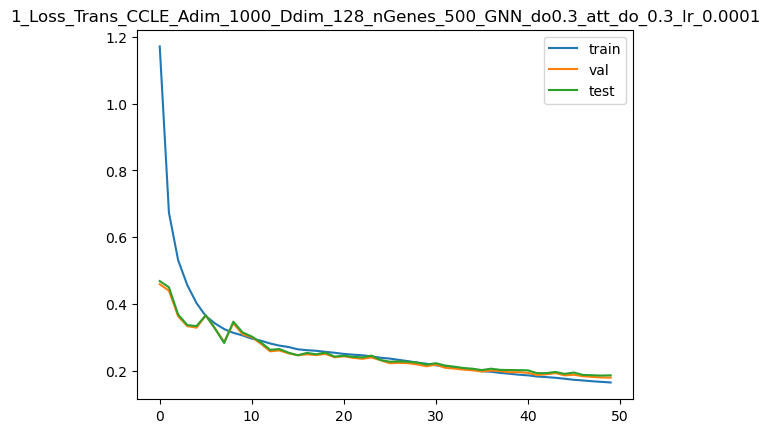

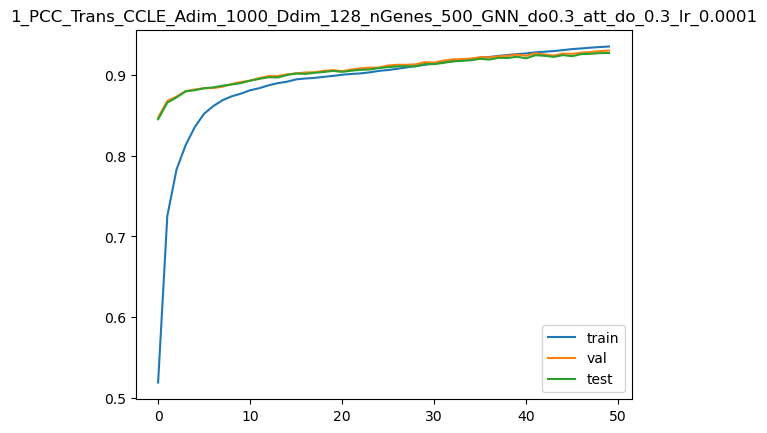

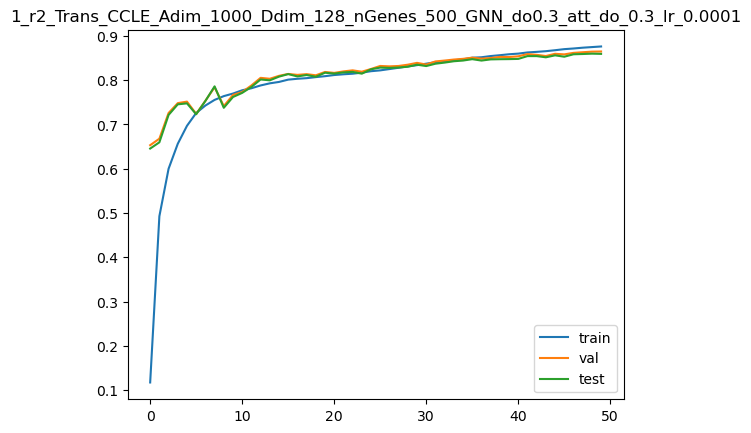

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2679489254951477
The overall Pearson's correlation is 0.8924.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16680791974067688
The overall Pearson's correlation is 0.9461.
Train avg_loss:  0.16313928
Train avg_pcc:  0.9365338210210721
Train r2:  0.8770879708669747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17686532
Validation avg_pcc:  0.9315480760786952
Validation r2:  0.8663620155375762
Best Val r2  0.8663620155375762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18390515
Test avg_pcc:  0.9285010618976103
Test r2:  0.8608453956223087
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15347568690776825
The overall Pearson's correlation is 0.9464.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20723691582679749
The overall Pearson's correlation is 0.9389.
Train avg_loss:  0.16189316
Train avg_pcc:  0.9370345653723442
Train r2:  0.8780268204573868


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17498383
Validation avg_pcc:  0.9319869986262366
Validation r2:  0.867783648716296
Best Val r2  0.867783648716296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18109241
Test avg_pcc:  0.9294045174868563
Test r2:  0.8629736888448171
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26811566948890686
The overall Pearson's correlation is 0.8988.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1824144721031189
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.15882422
Train avg_pcc:  0.938266743985646
Train r2:  0.8803390096068948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18032646
Validation avg_pcc:  0.9300967058249869
Validation r2:  0.8637467988262418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18399668
Test avg_pcc:  0.9285945694607518
Test r2:  0.8607761404068206
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16100189089775085
The overall Pearson's correlation is 0.9498.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17359186708927155
The overall Pearson's correlation is 0.9112.
Train avg_loss:  0.15702459
Train avg_pcc:  0.9389899245166862
Train r2:  0.8816948936122426


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1749254
Validation avg_pcc:  0.9321618737019715
Validation r2:  0.867827819389976
Best Val r2  0.867827819389976


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18018892
Test avg_pcc:  0.9299193220860295
Test r2:  0.8636573237438858
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20284560322761536
The overall Pearson's correlation is 0.9401.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1841336339712143
The overall Pearson's correlation is 0.9498.
Train avg_loss:  0.15624334
Train avg_pcc:  0.9393035654188229
Train r2:  0.8822834954690435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17778847
Validation avg_pcc:  0.9319217539269609
Validation r2:  0.8656644925199554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18282741
Test avg_pcc:  0.9296716629821038
Test r2:  0.8616608763948607
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16961392760276794
The overall Pearson's correlation is 0.9410.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1733301877975464
The overall Pearson's correlation is 0.9525.
Train avg_loss:  0.1544842
Train avg_pcc:  0.9400085823185884
Train r2:  0.8836088577808053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1760496
Validation avg_pcc:  0.9319053502633662
Validation r2:  0.8669783702664624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17970285
Test avg_pcc:  0.9302319489408015
Test r2:  0.864025126975447
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11369722336530685
The overall Pearson's correlation is 0.9140.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18882539868354797
The overall Pearson's correlation is 0.9350.
Train avg_loss:  0.15215272
Train avg_pcc:  0.9409424728395723
Train r2:  0.885365438875441


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.174978
Validation avg_pcc:  0.9322000471837242
Validation r2:  0.867788069223149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1794871
Test avg_pcc:  0.9301215594978796
Test r2:  0.8641883743203348
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1557115614414215
The overall Pearson's correlation is 0.9285.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16071265935897827
The overall Pearson's correlation is 0.9118.
Train avg_loss:  0.15020469
Train avg_pcc:  0.9417211213211001
Train r2:  0.8868331291067892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17506197
Validation avg_pcc:  0.932089682898087
Validation r2:  0.8677246087330874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18164384
Test avg_pcc:  0.9291359879363262
Test r2:  0.8625564335892572
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2302466779947281
The overall Pearson's correlation is 0.9162.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08370544016361237
The overall Pearson's correlation is 0.9454.
Train avg_loss:  0.14839943
Train avg_pcc:  0.9424433100958184
Train r2:  0.8881932397756871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17501977
Validation avg_pcc:  0.9322360854184386
Validation r2:  0.8677565039165386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17920657
Test avg_pcc:  0.9302842134125643
Test r2:  0.864400640425204
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18135817348957062
The overall Pearson's correlation is 0.9335.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26460546255111694
The overall Pearson's correlation is 0.9012.
Train avg_loss:  0.14753132
Train avg_pcc:  0.9427906010501617
Train r2:  0.8888472969747019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17138879
Validation avg_pcc:  0.9333294696241656
Validation r2:  0.8705000431702389
Best Val r2  0.8705000431702389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17695972
Test avg_pcc:  0.9309025862356032
Test r2:  0.8661007501139439
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15574882924556732
The overall Pearson's correlation is 0.9469.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11277405917644501
The overall Pearson's correlation is 0.9456.
Train avg_loss:  0.1466877
Train avg_pcc:  0.9431283477864582
Train r2:  0.8894828721763623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17723033
Validation avg_pcc:  0.9326267626412008
Validation r2:  0.8660862240819523


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1828363
Test avg_pcc:  0.9301135785830444
Test r2:  0.8616541582171641
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13507962226867676
The overall Pearson's correlation is 0.9441.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12418030202388763
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.14470811
Train avg_pcc:  0.9439174423208938
Train r2:  0.8909743424705732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17026609
Validation avg_pcc:  0.9341414267897904
Validation r2:  0.8713483572602561
Best Val r2  0.8713483572602561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17504482
Test avg_pcc:  0.9320313830591916
Test r2:  0.8675496889162521
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1559477299451828
The overall Pearson's correlation is 0.9360.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17476291954517365
The overall Pearson's correlation is 0.9116.
Train avg_loss:  0.14212859
Train avg_pcc:  0.944946647064528
Train r2:  0.8929178075210991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1685949
Validation avg_pcc:  0.9349664758110144
Validation r2:  0.8726110828016167
Best Val r2  0.8726110828016167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17426406
Test avg_pcc:  0.9324734284252979
Test r2:  0.868140464482971
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12242702394723892
The overall Pearson's correlation is 0.9604.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21094711124897003
The overall Pearson's correlation is 0.9156.
Train avg_loss:  0.14178528
Train avg_pcc:  0.9450831354090881
Train r2:  0.8931764629336525


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17382905
Validation avg_pcc:  0.9339953159299944
Validation r2:  0.8686561962144219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17865247
Test avg_pcc:  0.9318438803047123
Test r2:  0.8648199084986681
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15385761857032776
The overall Pearson's correlation is 0.9328.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15305359661579132
The overall Pearson's correlation is 0.9479.
Train avg_loss:  0.1401267
Train avg_pcc:  0.9457447323645103
Train r2:  0.8944260532852492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16897109
Validation avg_pcc:  0.9351043361900913
Validation r2:  0.8723268254052605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17559403
Test avg_pcc:  0.9321479551611611
Test r2:  0.8671341322467062
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17930206656455994
The overall Pearson's correlation is 0.9237.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1482466161251068
The overall Pearson's correlation is 0.9508.
Train avg_loss:  0.13783674
Train avg_pcc:  0.9466559055890782
Train r2:  0.8961513456136124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16935007
Validation avg_pcc:  0.9347403584748162
Validation r2:  0.8720404706360607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17381799
Test avg_pcc:  0.9327589899697523
Test r2:  0.8684779906575644
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11833091080188751
The overall Pearson's correlation is 0.9563.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06489391624927521
The overall Pearson's correlation is 0.9656.
Train avg_loss:  0.13807335
Train avg_pcc:  0.9465616462212634
Train r2:  0.8959730702130717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16928193
Validation avg_pcc:  0.9345020967589561
Validation r2:  0.8720919655099175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1742728
Test avg_pcc:  0.9322792346592207
Test r2:  0.8681338375314767
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1838659942150116
The overall Pearson's correlation is 0.9428.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1618194580078125
The overall Pearson's correlation is 0.9085.
Train avg_loss:  0.13636513
Train avg_pcc:  0.9472421224954317
Train r2:  0.89726008338923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1722778
Validation avg_pcc:  0.9347891309025459
Validation r2:  0.8698283105777274


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1769332
Test avg_pcc:  0.9326753263948786
Test r2:  0.866120809684016
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14550606906414032
The overall Pearson's correlation is 0.9357.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1332578808069229
The overall Pearson's correlation is 0.9546.
Train avg_loss:  0.13518503
Train avg_pcc:  0.9477103639171902
Train r2:  0.8981491859925257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16623548
Validation avg_pcc:  0.9351325043192371
Validation r2:  0.8743938385492466
Best Val r2  0.8743938385492466


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17223209
Test avg_pcc:  0.932634624848704
Test r2:  0.8696779806550688
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1084747463464737
The overall Pearson's correlation is 0.9655.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09581664949655533
The overall Pearson's correlation is 0.9491.
Train avg_loss:  0.13299662
Train avg_pcc:  0.9485801968376716
Train r2:  0.8997979822067146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1664956
Validation avg_pcc:  0.9351306779911231
Validation r2:  0.8741972843883214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16972393
Test avg_pcc:  0.9336781060623687
Test r2:  0.8715758190335775
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08469386398792267
The overall Pearson's correlation is 0.9473.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11367025971412659
The overall Pearson's correlation is 0.9634.
Train avg_loss:  0.13307846
Train avg_pcc:  0.948548404725684
Train r2:  0.899736332644832


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1679296
Validation avg_pcc:  0.9346941629470629
Validation r2:  0.873113773815509


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1733956
Test avg_pcc:  0.9323431220176519
Test r2:  0.8687975900751417
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09479275345802307
The overall Pearson's correlation is 0.9653.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19018428027629852
The overall Pearson's correlation is 0.9287.
Train avg_loss:  0.13138528
Train avg_pcc:  0.9492197167397239
Train r2:  0.9010120075030298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.165333
Validation avg_pcc:  0.9356654384785118
Validation r2:  0.8750757419963054
Best Val r2  0.8750757419963054


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17148653
Test avg_pcc:  0.932972864167697
Test r2:  0.8702421364356401
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08868660777807236
The overall Pearson's correlation is 0.9527.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10511472821235657
The overall Pearson's correlation is 0.9517.
Train avg_loss:  0.12981811
Train avg_pcc:  0.9498412040959897
Train r2:  0.9021927281408857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16290718
Validation avg_pcc:  0.9365974327220337
Validation r2:  0.8769086659329974
Best Val r2  0.8769086659329974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1691536
Test avg_pcc:  0.9339349876024601
Test r2:  0.8720073717477889
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13015428185462952
The overall Pearson's correlation is 0.9559.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10488705337047577
The overall Pearson's correlation is 0.9642.
Train avg_loss:  0.13005482
Train avg_pcc:  0.949747249261576
Train r2:  0.902014386530763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16563386
Validation avg_pcc:  0.936141001148249
Validation r2:  0.8748484143443914


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17081974
Test avg_pcc:  0.9338029493474257
Test r2:  0.8707466539828863
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15407602488994598
The overall Pearson's correlation is 0.9306.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10492265224456787
The overall Pearson's correlation is 0.9635.
Train avg_loss:  0.12837972
Train avg_pcc:  0.9504112923360488
Train r2:  0.9032764340431321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16487816
Validation avg_pcc:  0.936287433202033
Validation r2:  0.8754194127440131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17045829
Test avg_pcc:  0.933802796298574
Test r2:  0.8710201641794002
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08002852648496628
The overall Pearson's correlation is 0.9708.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12356898188591003
The overall Pearson's correlation is 0.9531.
Train avg_loss:  0.12686205
Train avg_pcc:  0.9510134806954543
Train r2:  0.9044198841662794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1628752
Validation avg_pcc:  0.9368033877665441
Validation r2:  0.8769328273252683
Best Val r2  0.8769328273252683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16845913
Test avg_pcc:  0.9343672617449116
Test r2:  0.8725328545326687
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09190614521503448
The overall Pearson's correlation is 0.9580.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12796036899089813
The overall Pearson's correlation is 0.9520.
Train avg_loss:  0.126006
Train avg_pcc:  0.9513518759227542
Train r2:  0.905064834859983


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16371551
Validation avg_pcc:  0.9367955093933256
Validation r2:  0.8762979041026877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16858616
Test avg_pcc:  0.934643391245588
Test r2:  0.8724367438022558
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10629675537347794
The overall Pearson's correlation is 0.9751.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12198801338672638
The overall Pearson's correlation is 0.9695.
Train avg_loss:  0.12648004
Train avg_pcc:  0.9511643559777407
Train r2:  0.9047076730165262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16378707
Validation avg_pcc:  0.9367905589503549
Validation r2:  0.8762438365133092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16922909
Test avg_pcc:  0.9344400437673203
Test r2:  0.8719502504073018
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13476723432540894
The overall Pearson's correlation is 0.9479.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12443414330482483
The overall Pearson's correlation is 0.9561.
Train avg_loss:  0.12387846
Train avg_pcc:  0.952194186197024
Train r2:  0.9066677643658279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16541515
Validation avg_pcc:  0.9374573176449843
Validation r2:  0.8750136679581194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17014438
Test avg_pcc:  0.935157829835233
Test r2:  0.8712576890875162
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1332167088985443
The overall Pearson's correlation is 0.9308.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14595437049865723
The overall Pearson's correlation is 0.9526.
Train avg_loss:  0.12337548
Train avg_pcc:  0.952393654643549
Train r2:  0.9070467205536807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16209629
Validation avg_pcc:  0.937428666226466
Validation r2:  0.8775213638594628
Best Val r2  0.8775213638594628


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16666594
Test avg_pcc:  0.9353045325002394
Test r2:  0.8738896957369648
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11428705602884293
The overall Pearson's correlation is 0.9616.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2026418149471283
The overall Pearson's correlation is 0.9355.
Train avg_loss:  0.12177279
Train avg_pcc:  0.9530267014958232
Train r2:  0.9082542218967431


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16419947
Validation avg_pcc:  0.9365852696059553
Validation r2:  0.8759322236771598


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1695887
Test avg_pcc:  0.9341405904436162
Test r2:  0.871678148435118
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12331262230873108
The overall Pearson's correlation is 0.9652.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14141851663589478
The overall Pearson's correlation is 0.9627.
Train avg_loss:  0.12129767
Train avg_pcc:  0.9532154690587833
Train r2:  0.9086121888395462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16329527
Validation avg_pcc:  0.9372066576604481
Validation r2:  0.8766154443980013


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16774227
Test avg_pcc:  0.9351639161462973
Test r2:  0.873075268453992
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11588709056377411
The overall Pearson's correlation is 0.9545.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15053711831569672
The overall Pearson's correlation is 0.9552.
Train avg_loss:  0.1208106
Train avg_pcc:  0.9534068780076183
Train r2:  0.9089791525306319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1602994
Validation avg_pcc:  0.9378686261543518
Validation r2:  0.878879097698359
Best Val r2  0.878879097698359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16519728
Test avg_pcc:  0.9356965605565821
Test r2:  0.8750009680008176
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11552266776561737
The overall Pearson's correlation is 0.9675.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09009379148483276
The overall Pearson's correlation is 0.9718.
Train avg_loss:  0.11994396
Train avg_pcc:  0.9537492276904603
Train r2:  0.9096320776881563


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16197541
Validation avg_pcc:  0.9377309743883341
Validation r2:  0.8776127174517517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16695575
Test avg_pcc:  0.9355138473213448
Test r2:  0.8736703987931471
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10579514503479004
The overall Pearson's correlation is 0.9412.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16268374025821686
The overall Pearson's correlation is 0.9430.
Train avg_loss:  0.1177592
Train avg_pcc:  0.9546111806478672
Train r2:  0.9112781376835366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16107823
Validation avg_pcc:  0.9377374371343516
Validation r2:  0.8782906179130487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1659399
Test avg_pcc:  0.9355471134197086
Test r2:  0.8744390698762888
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10882198810577393
The overall Pearson's correlation is 0.9570.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1129266619682312
The overall Pearson's correlation is 0.9649.
Train avg_loss:  0.11701828
Train avg_pcc:  0.9549040679980373
Train r2:  0.9118363417925701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16301772
Validation avg_pcc:  0.9368993083313217
Validation r2:  0.8768251453984838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16755225
Test avg_pcc:  0.9348369651505182
Test r2:  0.8732190615295256
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10107026994228363
The overall Pearson's correlation is 0.9688.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11705663800239563
The overall Pearson's correlation is 0.9390.
Train avg_loss:  0.116500966
Train avg_pcc:  0.9551090352260072
Train r2:  0.9122260946838587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1617981
Validation avg_pcc:  0.9372946558284562
Validation r2:  0.8777466789804397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16614883
Test avg_pcc:  0.9354138731091184
Test r2:  0.8742809818638023
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09100991487503052
The overall Pearson's correlation is 0.9635.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0871509313583374
The overall Pearson's correlation is 0.9597.
Train avg_loss:  0.11538983
Train avg_pcc:  0.9555465491353072
Train r2:  0.9130632551785359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16203932
Validation avg_pcc:  0.9380408784205302
Validation r2:  0.8775644198474173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16823699
Test avg_pcc:  0.935366504669841
Test r2:  0.8727009552843613
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12882892787456512
The overall Pearson's correlation is 0.9524.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1537887305021286
The overall Pearson's correlation is 0.9526.
Train avg_loss:  0.114489906
Train avg_pcc:  0.9559005981829136
Train r2:  0.9137412781859305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16301851
Validation avg_pcc:  0.9379059166135664
Validation r2:  0.8768245517909211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16769071
Test avg_pcc:  0.9357245822283692
Test r2:  0.8731142906016316
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12503531575202942
The overall Pearson's correlation is 0.9326.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13441643118858337
The overall Pearson's correlation is 0.9688.
Train avg_loss:  0.114450485
Train avg_pcc:  0.9559167496516608
Train r2:  0.9137709693025754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16022179
Validation avg_pcc:  0.9381601288110907
Validation r2:  0.878937733913422
Best Val r2  0.878937733913422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16661307
Test avg_pcc:  0.9353571705668187
Test r2:  0.8739296907405671
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11196057498455048
The overall Pearson's correlation is 0.9584.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15575513243675232
The overall Pearson's correlation is 0.9565.
Train avg_loss:  0.11392764
Train avg_pcc:  0.9561228151304774
Train r2:  0.9141648822186939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1622364
Validation avg_pcc:  0.9375076083965529
Validation r2:  0.877415496334116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16625124
Test avg_pcc:  0.9356941849696188
Test r2:  0.8742034796219695
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1407119333744049
The overall Pearson's correlation is 0.9416.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10171985626220703
The overall Pearson's correlation is 0.9570.
Train avg_loss:  0.11235994
Train avg_pcc:  0.9567403668347481
Train r2:  0.9153460320461794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1595819
Validation avg_pcc:  0.9383962169533464
Validation r2:  0.8794212338037505
Best Val r2  0.8794212338037505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16388507
Test avg_pcc:  0.9364419441489394
Test r2:  0.8759938791157728
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11480025947093964
The overall Pearson's correlation is 0.9591.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11719505488872528
The overall Pearson's correlation is 0.9309.
Train avg_loss:  0.111235745
Train avg_pcc:  0.9571821810697668
Train r2:  0.9161930140422571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16180508
Validation avg_pcc:  0.9374978149392142
Validation r2:  0.8777414120867695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16544178
Test avg_pcc:  0.9358212831175934
Test r2:  0.87481597476866
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1559486836194992
The overall Pearson's correlation is 0.9580.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11693231016397476
The overall Pearson's correlation is 0.9607.
Train avg_loss:  0.11220738
Train avg_pcc:  0.9568006037607093
Train r2:  0.9154609632731964


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16071779
Validation avg_pcc:  0.9382352751587624
Validation r2:  0.878562955211673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16520308
Test avg_pcc:  0.9362294133258711
Test r2:  0.8749965857251539
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19993607699871063
The overall Pearson's correlation is 0.9361.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12189774215221405
The overall Pearson's correlation is 0.9638.
Train avg_loss:  0.11073984
Train avg_pcc:  0.9573769302513966
Train r2:  0.91656664623528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1635178
Validation avg_pcc:  0.9376964027464494
Validation r2:  0.8764472855177127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16835353
Test avg_pcc:  0.9356266999538159
Test r2:  0.8726127642972579
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1701270043849945
The overall Pearson's correlation is 0.9467.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1306501179933548
The overall Pearson's correlation is 0.9545.
Train avg_loss:  0.10913689
Train avg_pcc:  0.9580088074002617
Train r2:  0.9177743321199899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16009933
Validation avg_pcc:  0.9387809645800207
Validation r2:  0.8790302720879793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16633153
Test avg_pcc:  0.9360422251112532
Test r2:  0.8741427349073829
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1363087147474289
The overall Pearson's correlation is 0.9532.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08413255214691162
The overall Pearson's correlation is 0.9708.
Train avg_loss:  0.108149186
Train avg_pcc:  0.9583965513814158
Train r2:  0.9185184883283103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16333272
Validation avg_pcc:  0.9387048945739902
Validation r2:  0.8765871473249258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16920552
Test avg_pcc:  0.9361229966159232
Test r2:  0.8719680915755164
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0822451114654541
The overall Pearson's correlation is 0.9709.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08091665804386139
The overall Pearson's correlation is 0.9592.
Train avg_loss:  0.10774364
Train avg_pcc:  0.9585553771611821
Train r2:  0.918824030190878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15929282
Validation avg_pcc:  0.9386469582273477
Validation r2:  0.8796396670360092
Best Val r2  0.8796396670360092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16365226
Test avg_pcc:  0.9366515491737633
Test r2:  0.8761700478262396
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10596568882465363
The overall Pearson's correlation is 0.9529.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11488577723503113
The overall Pearson's correlation is 0.9591.
Train avg_loss:  0.10737824
Train avg_pcc:  0.9586990662049779
Train r2:  0.919099334444603


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15821749
Validation avg_pcc:  0.9391347755506884
Validation r2:  0.8804521640531444
Best Val r2  0.8804521640531444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1632202
Test avg_pcc:  0.9368134107570685
Test r2:  0.8764969757067457
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0865747407078743
The overall Pearson's correlation is 0.9681.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.127186119556427
The overall Pearson's correlation is 0.9617.
Train avg_loss:  0.10699004
Train avg_pcc:  0.9588521481563893
Train r2:  0.9193918019354015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16300288
Validation avg_pcc:  0.9386791859705126
Validation r2:  0.8768363659808991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16926211
Test avg_pcc:  0.9357567780754142
Test r2:  0.8719252665481534


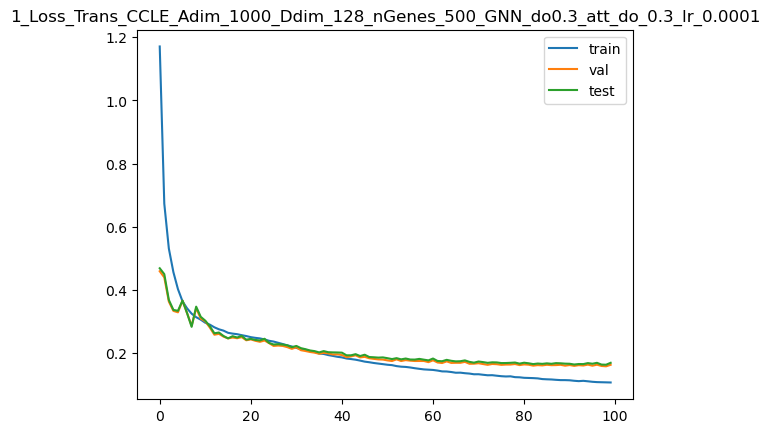

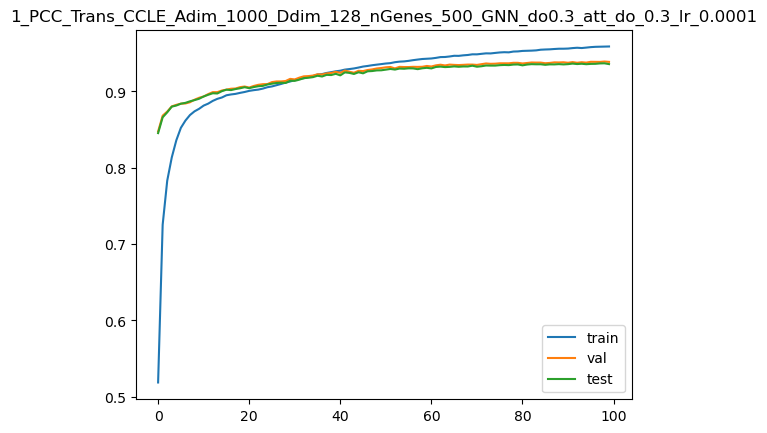

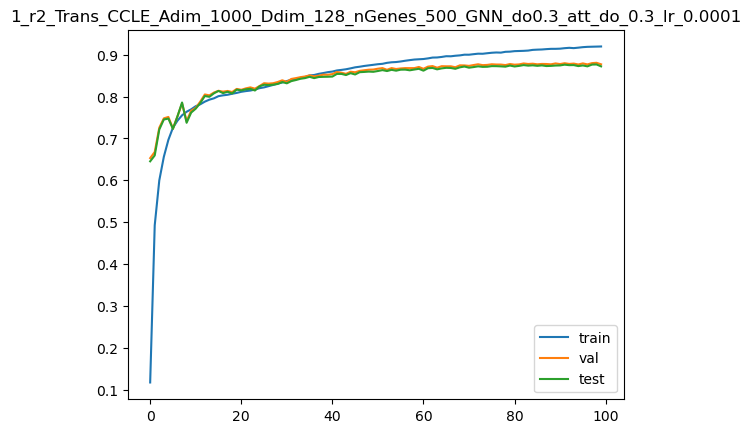

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07827877253293991
The overall Pearson's correlation is 0.9679.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0645715594291687
The overall Pearson's correlation is 0.9758.
Train avg_loss:  0.10635709
Train avg_pcc:  0.9591005503845559
Train r2:  0.9198686765240056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15916204
Validation avg_pcc:  0.938434319861662
Validation r2:  0.8797384654287365


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16401605
Test avg_pcc:  0.9363194193460279
Test r2:  0.8758947663611834
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09481273591518402
The overall Pearson's correlation is 0.9393.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08685627579689026
The overall Pearson's correlation is 0.9532.
Train avg_loss:  0.104596816
Train avg_pcc:  0.9597916550220619
Train r2:  0.9211949058794444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1586774
Validation avg_pcc:  0.9387071935294222
Validation r2:  0.8801046664586544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16526474
Test avg_pcc:  0.9357725363848385
Test r2:  0.8749499365861217
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07830466330051422
The overall Pearson's correlation is 0.9691.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0903107225894928
The overall Pearson's correlation is 0.9491.
Train avg_loss:  0.10511826
Train avg_pcc:  0.9595870902266584
Train r2:  0.9208020325504838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15867734
Validation avg_pcc:  0.93925212272553
Validation r2:  0.8801046946990551


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16487047
Test avg_pcc:  0.9366054735056103
Test r2:  0.8752482598245788
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0931728407740593
The overall Pearson's correlation is 0.9547.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1080348938703537
The overall Pearson's correlation is 0.9585.
Train avg_loss:  0.10459272
Train avg_pcc:  0.9597932672909877
Train r2:  0.9211979919107001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15981604
Validation avg_pcc:  0.9386828202597437
Validation r2:  0.8792443252451925


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16541907
Test avg_pcc:  0.9362524743733306
Test r2:  0.8748331674606259
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13031475245952606
The overall Pearson's correlation is 0.9543.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10492311418056488
The overall Pearson's correlation is 0.9646.
Train avg_loss:  0.103212
Train avg_pcc:  0.9603349916679067
Train r2:  0.9222382531070874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15841073
Validation avg_pcc:  0.9389353197222325
Validation r2:  0.8803061580111873


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16409846
Test avg_pcc:  0.936452857444941
Test r2:  0.8758324241194878
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12015050649642944
The overall Pearson's correlation is 0.9484.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0757012888789177
The overall Pearson's correlation is 0.9589.
Train avg_loss:  0.10255269
Train avg_pcc:  0.960592862047847
Train r2:  0.9227349817754538


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15999608
Validation avg_pcc:  0.9388688782434783
Validation r2:  0.8791082825798741


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16559781
Test avg_pcc:  0.9363496856253786
Test r2:  0.8746979181012026
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08551238477230072
The overall Pearson's correlation is 0.9640.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10289715230464935
The overall Pearson's correlation is 0.9582.
Train avg_loss:  0.10191504
Train avg_pcc:  0.9608436745424691
Train r2:  0.9232154040026688


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16173512
Validation avg_pcc:  0.9372259883423821
Validation r2:  0.877794271957053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16629253
Test avg_pcc:  0.9352340365324117
Test r2:  0.874172243653984
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07841140776872635
The overall Pearson's correlation is 0.9740.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13804621994495392
The overall Pearson's correlation is 0.9500.
Train avg_loss:  0.101999916
Train avg_pcc:  0.9608109192727808
Train r2:  0.9231514412588597


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16369694
Validation avg_pcc:  0.9390019966258932
Validation r2:  0.8763119378954842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16774979
Test avg_pcc:  0.9369565768636521
Test r2:  0.8730695828789945
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1097375676035881
The overall Pearson's correlation is 0.9679.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08756598085165024
The overall Pearson's correlation is 0.9686.
Train avg_loss:  0.10098526
Train avg_pcc:  0.9612079159875923
Train r2:  0.9239159133434981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15893137
Validation avg_pcc:  0.9397296890608368
Validation r2:  0.8799127521480937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16556728
Test avg_pcc:  0.9368429157312506
Test r2:  0.8747210221160349
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09676908701658249
The overall Pearson's correlation is 0.9523.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09367948025465012
The overall Pearson's correlation is 0.9691.
Train avg_loss:  0.10067049
Train avg_pcc:  0.9613311035570649
Train r2:  0.9241530689699582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16006668
Validation avg_pcc:  0.9389516309031366
Validation r2:  0.8790549439562307


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16566361
Test avg_pcc:  0.9364892182261525
Test r2:  0.8746481242153845
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11849715560674667
The overall Pearson's correlation is 0.9536.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09401330351829529
The overall Pearson's correlation is 0.9590.
Train avg_loss:  0.1003166
Train avg_pcc:  0.9614702445837034
Train r2:  0.9244196955318109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16245484
Validation avg_pcc:  0.9385288577427386
Validation r2:  0.8772504575070822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16607751
Test avg_pcc:  0.9370551814758594
Test r2:  0.8743349431220611
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10497789084911346
The overall Pearson's correlation is 0.9637.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09050221741199493
The overall Pearson's correlation is 0.9598.
Train avg_loss:  0.09944369
Train avg_pcc:  0.9618117749908411
Train r2:  0.925077352969203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15748979
Validation avg_pcc:  0.9393726695130525
Validation r2:  0.8810020074375132
Best Val r2  0.8810020074375132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16081545
Test avg_pcc:  0.9378140848989648
Test r2:  0.8783165579632509
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07916916906833649
The overall Pearson's correlation is 0.9671.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10262414813041687
The overall Pearson's correlation is 0.9667.
Train avg_loss:  0.09871111
Train avg_pcc:  0.9620985087004762
Train r2:  0.9256293006863751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15772337
Validation avg_pcc:  0.9395754795853044
Validation r2:  0.8808255042127041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1616926
Test avg_pcc:  0.9377017315433331
Test r2:  0.8776528517390345
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07346443831920624
The overall Pearson's correlation is 0.9657.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08875569701194763
The overall Pearson's correlation is 0.9619.
Train avg_loss:  0.098343715
Train avg_pcc:  0.9622432319652949
Train r2:  0.9259061042734522


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16195454
Validation avg_pcc:  0.9390381304769282
Validation r2:  0.8776284932534546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16661674
Test avg_pcc:  0.9369482504129557
Test r2:  0.8739269291999184
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1251753866672516
The overall Pearson's correlation is 0.9457.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.148826465010643
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.09753965
Train avg_pcc:  0.9625577732300206
Train r2:  0.9265118981413357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16067043
Validation avg_pcc:  0.9389184543789747
Validation r2:  0.8785987448261551


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16667072
Test avg_pcc:  0.9363649087060852
Test r2:  0.8738860786493555
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05924550071358681
The overall Pearson's correlation is 0.9729.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10545344650745392
The overall Pearson's correlation is 0.9707.
Train avg_loss:  0.09761561
Train avg_pcc:  0.962527414006351
Train r2:  0.9264546653360572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15591642
Validation avg_pcc:  0.9396971369172589
Validation r2:  0.8821908298305979
Best Val r2  0.8821908298305979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16258448
Test avg_pcc:  0.9368788384923693
Test r2:  0.8769779930475996
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07928254455327988
The overall Pearson's correlation is 0.9717.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08997684717178345
The overall Pearson's correlation is 0.9571.
Train avg_loss:  0.09634788
Train avg_pcc:  0.9630241341801906
Train r2:  0.9274097919525157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15867227
Validation avg_pcc:  0.939213154346612
Validation r2:  0.8801085319153635


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1642299
Test avg_pcc:  0.9367721737323121
Test r2:  0.8757329614137498
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0837256982922554
The overall Pearson's correlation is 0.9606.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11519502103328705
The overall Pearson's correlation is 0.9668.
Train avg_loss:  0.09753816
Train avg_pcc:  0.9625581223118019
Train r2:  0.9265130272048221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15730026
Validation avg_pcc:  0.9395139291561595
Validation r2:  0.8811452184877745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16253528
Test avg_pcc:  0.9371020717605139
Test r2:  0.8770152235009685
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07624904811382294
The overall Pearson's correlation is 0.9753.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1534527987241745
The overall Pearson's correlation is 0.9590.
Train avg_loss:  0.096440904
Train avg_pcc:  0.962987119271364
Train r2:  0.9273397095488844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15811808
Validation avg_pcc:  0.9391836179919275
Validation r2:  0.8805272712551042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16341259
Test avg_pcc:  0.9368375208239952
Test r2:  0.8763514039523121
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1514418125152588
The overall Pearson's correlation is 0.9369.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08605822175741196
The overall Pearson's correlation is 0.9636.
Train avg_loss:  0.09523458
Train avg_pcc:  0.9634589421758775
Train r2:  0.928248572720292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1591641
Validation avg_pcc:  0.9393568072434251
Validation r2:  0.8797369101323951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16476679
Test avg_pcc:  0.936722615813515
Test r2:  0.875326723383662
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08532899618148804
The overall Pearson's correlation is 0.9468.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07971348613500595
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.0947094
Train avg_pcc:  0.9636644868727011
Train r2:  0.9286442625474334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15905552
Validation avg_pcc:  0.9395746675896344
Validation r2:  0.8798189675010701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16517688
Test avg_pcc:  0.9368471894951376
Test r2:  0.8750164106339021
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12229783087968826
The overall Pearson's correlation is 0.9615.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10368016362190247
The overall Pearson's correlation is 0.9531.
Train avg_loss:  0.09507798
Train avg_pcc:  0.9635203729455162
Train r2:  0.9283665644779041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15553062
Validation avg_pcc:  0.9398558393474995
Validation r2:  0.8824823506570905
Best Val r2  0.8824823506570905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16201368
Test avg_pcc:  0.9371162925446062
Test r2:  0.8774099031955224
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07039199769496918
The overall Pearson's correlation is 0.9707.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13106900453567505
The overall Pearson's correlation is 0.9453.
Train avg_loss:  0.09369136
Train avg_pcc:  0.9640624540682391
Train r2:  0.9294112647844255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16031432
Validation avg_pcc:  0.9382948393725044
Validation r2:  0.8788678154128466


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16530219
Test avg_pcc:  0.9360470908070747
Test r2:  0.8749215987489153
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09675300866365433
The overall Pearson's correlation is 0.9697.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11108747124671936
The overall Pearson's correlation is 0.9641.
Train avg_loss:  0.09310525
Train avg_pcc:  0.9642910256079822
Train r2:  0.9298528505833705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15899348
Validation avg_pcc:  0.939401392508973
Validation r2:  0.8798658406859203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16284432
Test avg_pcc:  0.9376077539413253
Test r2:  0.8767813821210559
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10446301102638245
The overall Pearson's correlation is 0.9499.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08782656490802765
The overall Pearson's correlation is 0.9698.
Train avg_loss:  0.093091935
Train avg_pcc:  0.9642962558002128
Train r2:  0.9298628857964812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15931405
Validation avg_pcc:  0.9393651253065617
Validation r2:  0.879623619270612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16593954
Test avg_pcc:  0.9364174491909812
Test r2:  0.8744393441871925
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10704536736011505
The overall Pearson's correlation is 0.9493.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09831425547599792
The overall Pearson's correlation is 0.9393.
Train avg_loss:  0.0933946
Train avg_pcc:  0.9641783101342675
Train r2:  0.9296348478737922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15677387
Validation avg_pcc:  0.9399779471661481
Validation r2:  0.8815429571962136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16146997
Test avg_pcc:  0.9378011922908615
Test r2:  0.8778213049799883
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08812477439641953
The overall Pearson's correlation is 0.9705.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05067028850317001
The overall Pearson's correlation is 0.9832.
Train avg_loss:  0.09233982
Train avg_pcc:  0.9645899148120617
Train r2:  0.9304295413928589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15811896
Validation avg_pcc:  0.9395084781959653
Validation r2:  0.880526604921885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16404684
Test avg_pcc:  0.9368770801787332
Test r2:  0.8758714765147291
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06799452006816864
The overall Pearson's correlation is 0.9729.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05702213943004608
The overall Pearson's correlation is 0.9775.
Train avg_loss:  0.09139718
Train avg_pcc:  0.9649579855484929
Train r2:  0.9311397406026187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15999183
Validation avg_pcc:  0.9399080542057786
Validation r2:  0.8791114919597147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16516018
Test avg_pcc:  0.937689742963155
Test r2:  0.8750290536697056
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08109153807163239
The overall Pearson's correlation is 0.9765.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10978135466575623
The overall Pearson's correlation is 0.9622.
Train avg_loss:  0.09175614
Train avg_pcc:  0.964818005273698
Train r2:  0.9308692913260493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15808532
Validation avg_pcc:  0.9394773614033438
Validation r2:  0.8805520323101135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16315837
Test avg_pcc:  0.9371837331895781
Test r2:  0.8765437572228661
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07002124935388565
The overall Pearson's correlation is 0.9719.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12882979214191437
The overall Pearson's correlation is 0.9555.
Train avg_loss:  0.09212613
Train avg_pcc:  0.9646739513941809
Train r2:  0.9305905362285252


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15791407
Validation avg_pcc:  0.9399587013169756
Validation r2:  0.88068142489082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1628647
Test avg_pcc:  0.9376759176024501
Test r2:  0.8767659628904002
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07680407911539078
The overall Pearson's correlation is 0.9753.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07393600046634674
The overall Pearson's correlation is 0.9653.
Train avg_loss:  0.09105941
Train avg_pcc:  0.9650897550131651
Train r2:  0.9313942249551662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15904313
Validation avg_pcc:  0.9392958177218117
Validation r2:  0.8798283092937224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16562015
Test avg_pcc:  0.936550872477492
Test r2:  0.8746810127496447
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1114610880613327
The overall Pearson's correlation is 0.9753.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07948155701160431
The overall Pearson's correlation is 0.9760.
Train avg_loss:  0.08974309
Train avg_pcc:  0.9656040675251777
Train r2:  0.9323859530171417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16308674
Validation avg_pcc:  0.9390424455689709
Validation r2:  0.8767729968233265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16798434
Test avg_pcc:  0.9369928868468744
Test r2:  0.8728921197431803
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08933822065591812
The overall Pearson's correlation is 0.9498.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07798843085765839
The overall Pearson's correlation is 0.9631.
Train avg_loss:  0.089266166
Train avg_pcc:  0.965789910925002
Train r2:  0.9327452860476528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15942624
Validation avg_pcc:  0.938535888962907
Validation r2:  0.8795388400332584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16258018
Test avg_pcc:  0.9371378235552342
Test r2:  0.8769812445630742
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13086849451065063
The overall Pearson's correlation is 0.9288.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11367737501859665
The overall Pearson's correlation is 0.9487.
Train avg_loss:  0.09047653
Train avg_pcc:  0.9653172349852238
Train r2:  0.9318333801385953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15756565
Validation avg_pcc:  0.9398110547432461
Validation r2:  0.8809446920470737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16222829
Test avg_pcc:  0.9377407153392072
Test r2:  0.8772475237053817
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10540427267551422
The overall Pearson's correlation is 0.9615.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07376761734485626
The overall Pearson's correlation is 0.9737.
Train avg_loss:  0.08952001
Train avg_pcc:  0.9656904640309192
Train r2:  0.9325540388104779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15461193
Validation avg_pcc:  0.9401347869992955
Validation r2:  0.8831764853011469
Best Val r2  0.8831764853011469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16088836
Test avg_pcc:  0.9374557738088833
Test r2:  0.8782613992445353
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11967474222183228
The overall Pearson's correlation is 0.9467.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08742685616016388
The overall Pearson's correlation is 0.9697.
Train avg_loss:  0.08911165
Train avg_pcc:  0.9658503237595572
Train r2:  0.9328617058612478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16019383
Validation avg_pcc:  0.9391710548683327
Validation r2:  0.8789588578462221


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16448078
Test avg_pcc:  0.9373937847267638
Test r2:  0.8755431248972408
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09448669850826263
The overall Pearson's correlation is 0.9665.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08974094688892365
The overall Pearson's correlation is 0.9629.
Train avg_loss:  0.088991135
Train avg_pcc:  0.9658969386251521
Train r2:  0.9329524975910811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15826818
Validation avg_pcc:  0.9395458466333018
Validation r2:  0.8804138596466244


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16456982
Test avg_pcc:  0.9367919374516417
Test r2:  0.8754757469782917
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1099216490983963
The overall Pearson's correlation is 0.9551.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10797999799251556
The overall Pearson's correlation is 0.9613.
Train avg_loss:  0.088189796
Train avg_pcc:  0.966209542277537
Train r2:  0.9335562378137588


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15801334
Validation avg_pcc:  0.9393706363295603
Validation r2:  0.8806064076510156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16389391
Test avg_pcc:  0.9368426400692526
Test r2:  0.8759871900285595
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07898445427417755
The overall Pearson's correlation is 0.9739.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1331777572631836
The overall Pearson's correlation is 0.9535.
Train avg_loss:  0.088395156
Train avg_pcc:  0.9661293634546418
Train r2:  0.9334015150617213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15688707
Validation avg_pcc:  0.9396481719274707
Validation r2:  0.8814574061265469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16194145
Test avg_pcc:  0.9374211623477675
Test r2:  0.8774645564486678
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08892831206321716
The overall Pearson's correlation is 0.9721.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07370036840438843
The overall Pearson's correlation is 0.9715.
Train avg_loss:  0.087547086
Train avg_pcc:  0.9664603620330195
Train r2:  0.9340404739586515


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16169493
Validation avg_pcc:  0.9389658296421813
Validation r2:  0.8778246531469786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16756758
Test avg_pcc:  0.9364520992621903
Test r2:  0.8732074479042643
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0866575837135315
The overall Pearson's correlation is 0.9753.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0707058385014534
The overall Pearson's correlation is 0.9703.
Train avg_loss:  0.08754261
Train avg_pcc:  0.9664615980552888
Train r2:  0.9340438458857894


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16212772
Validation avg_pcc:  0.9390516436756879
Validation r2:  0.8774976279957709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1662514
Test avg_pcc:  0.9372024018511588
Test r2:  0.8742033500177195
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09508148580789566
The overall Pearson's correlation is 0.9682.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10831734538078308
The overall Pearson's correlation is 0.9494.
Train avg_loss:  0.088076524
Train avg_pcc:  0.9662532584623936
Train r2:  0.9336415824536837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15916148
Validation avg_pcc:  0.9396391886346745
Validation r2:  0.8797388925150866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16480619
Test avg_pcc:  0.9371201399650898
Test r2:  0.8752969135161661
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07524251937866211
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07571820169687271
The overall Pearson's correlation is 0.9745.
Train avg_loss:  0.087054126
Train avg_pcc:  0.9666518091530913
Train r2:  0.9344118738132949


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15652353
Validation avg_pcc:  0.9395109006878014
Validation r2:  0.8817321201218598


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16049232
Test avg_pcc:  0.93773076389902
Test r2:  0.8785610623503239
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07260282337665558
The overall Pearson's correlation is 0.9710.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11116767674684525
The overall Pearson's correlation is 0.9374.
Train avg_loss:  0.08684784
Train avg_pcc:  0.966732637841186
Train r2:  0.9345672957997686


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1563927
Validation avg_pcc:  0.939939375529957
Validation r2:  0.8818309746468143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16329527
Test avg_pcc:  0.9369961333796164
Test r2:  0.8764401622276512
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07209336757659912
The overall Pearson's correlation is 0.9668.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1544654667377472
The overall Pearson's correlation is 0.9462.
Train avg_loss:  0.085846074
Train avg_pcc:  0.9671228927653349
Train r2:  0.9353220375176258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15912521
Validation avg_pcc:  0.9395971766963921
Validation r2:  0.8797663023140421


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1646261
Test avg_pcc:  0.9371852094557671
Test r2:  0.8754331716390107
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08521635830402374
The overall Pearson's correlation is 0.9651.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0750381201505661
The overall Pearson's correlation is 0.9634.
Train avg_loss:  0.08566741
Train avg_pcc:  0.9671921039115698
Train r2:  0.9354566540945943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15610357
Validation avg_pcc:  0.9402162543625694
Validation r2:  0.882049434229115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16133036
Test avg_pcc:  0.9380146027592081
Test r2:  0.8779269466870638
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07970531284809113
The overall Pearson's correlation is 0.9639.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07391606271266937
The overall Pearson's correlation is 0.9732.
Train avg_loss:  0.08533164
Train avg_pcc:  0.9673225293478529
Train r2:  0.9357096227271124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15846258
Validation avg_pcc:  0.940062321471818
Validation r2:  0.8802669730357885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16491751
Test avg_pcc:  0.9373148728965631
Test r2:  0.875212661969641
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07447606325149536
The overall Pearson's correlation is 0.9680.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08735223859548569
The overall Pearson's correlation is 0.9668.
Train avg_loss:  0.08500806
Train avg_pcc:  0.9674493008671841
Train r2:  0.9359534183855589


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16067296
Validation avg_pcc:  0.9389170569853353
Validation r2:  0.8785968420142677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16661891
Test avg_pcc:  0.936429195838113
Test r2:  0.8739252692478311
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07994117587804794
The overall Pearson's correlation is 0.9744.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07536088675260544
The overall Pearson's correlation is 0.9657.
Train avg_loss:  0.08545463
Train avg_pcc:  0.9672751375909893
Train r2:  0.935616961202131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15693681
Validation avg_pcc:  0.938971116026266
Validation r2:  0.8814198343246522


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16132802
Test avg_pcc:  0.9370505726293843
Test r2:  0.8779287175192675
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06695932149887085
The overall Pearson's correlation is 0.9717.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07592234015464783
The overall Pearson's correlation is 0.9606.
Train avg_loss:  0.084294
Train avg_pcc:  0.9677273842158632
Train r2:  0.9364914120975155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15996195
Validation avg_pcc:  0.9392643104345126
Validation r2:  0.8791340601809949


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16618687
Test avg_pcc:  0.9364556947396775
Test r2:  0.8742521877689842


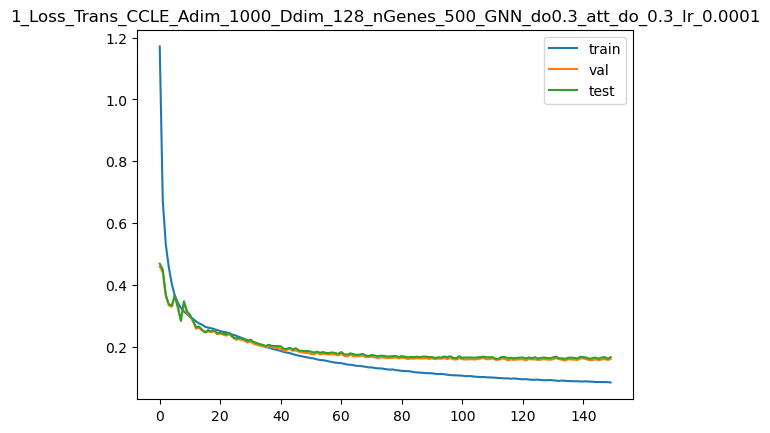

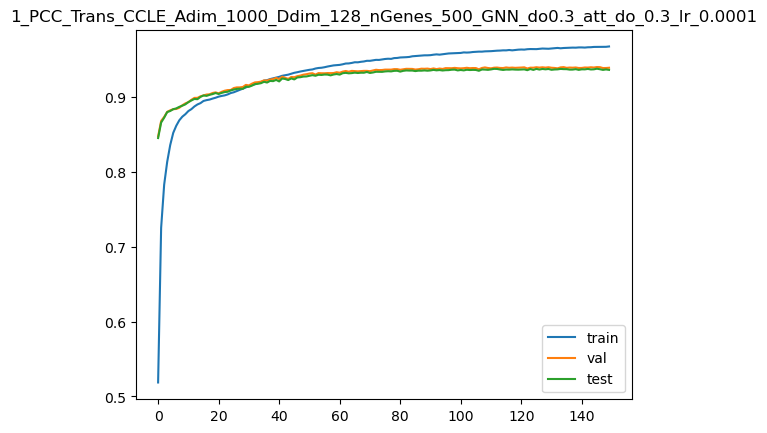

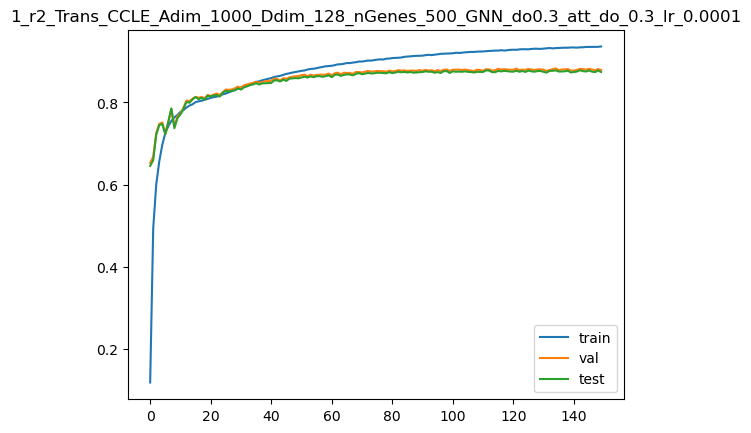

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07499686628580093
The overall Pearson's correlation is 0.9773.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08975385129451752
The overall Pearson's correlation is 0.9688.
Train avg_loss:  0.083202995
Train avg_pcc:  0.9681514245888162
Train r2:  0.9373133821818936


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15892255
Validation avg_pcc:  0.939990482714832
Validation r2:  0.87991942868306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16386825
Test avg_pcc:  0.9378419226886385
Test r2:  0.8760066167991276
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06124690920114517
The overall Pearson's correlation is 0.9698.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10327856242656708
The overall Pearson's correlation is 0.9742.
Train avg_loss:  0.08360209
Train avg_pcc:  0.9679961867281145
Train r2:  0.9370127021635682


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1566256
Validation avg_pcc:  0.9400025901907577
Validation r2:  0.8816549903140308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16362305
Test avg_pcc:  0.9369970393212623
Test r2:  0.8761921490448003
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07833506166934967
The overall Pearson's correlation is 0.9747.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07364031672477722
The overall Pearson's correlation is 0.9603.
Train avg_loss:  0.08339483
Train avg_pcc:  0.9680767722539744
Train r2:  0.9371688475539465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1537325
Validation avg_pcc:  0.9407929669671611
Validation r2:  0.8838410007132024
Best Val r2  0.8838410007132024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15916683
Test avg_pcc:  0.9383496665402674
Test r2:  0.8795640066844987
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08051630109548569
The overall Pearson's correlation is 0.9776.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08349494636058807
The overall Pearson's correlation is 0.9734.
Train avg_loss:  0.083108895
Train avg_pcc:  0.9681880091929356
Train r2:  0.9373842848592181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15552676
Validation avg_pcc:  0.9398415584903449
Validation r2:  0.8824852666904107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1598875
Test avg_pcc:  0.9379262633664797
Test r2:  0.8790187025247961
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08732666075229645
The overall Pearson's correlation is 0.9585.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07205362617969513
The overall Pearson's correlation is 0.9674.
Train avg_loss:  0.08366807
Train avg_pcc:  0.967971180946662
Train r2:  0.9369629926408036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15688246
Validation avg_pcc:  0.9398314603620999
Validation r2:  0.8814609116125676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16100425
Test avg_pcc:  0.9380386309040936
Test r2:  0.878173717713093
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08882507681846619
The overall Pearson's correlation is 0.9735.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08335589617490768
The overall Pearson's correlation is 0.9726.
Train avg_loss:  0.082575604
Train avg_pcc:  0.9683956172722933
Train r2:  0.9377860779112078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1590985
Validation avg_pcc:  0.938926675034976
Validation r2:  0.8797864700357837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16220771
Test avg_pcc:  0.9375787238686937
Test r2:  0.877263083275336
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06329323351383209
The overall Pearson's correlation is 0.9790.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11477909237146378
The overall Pearson's correlation is 0.9573.
Train avg_loss:  0.08252016
Train avg_pcc:  0.9684172120205232
Train r2:  0.9378278538694501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15699074
Validation avg_pcc:  0.9397703025065305
Validation r2:  0.8813790823804272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16190104
Test avg_pcc:  0.9376228786652605
Test r2:  0.877495134626448
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0606062188744545
The overall Pearson's correlation is 0.9760.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09570129215717316
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.081942365
Train avg_pcc:  0.9686419089886682
Train r2:  0.9382631561755966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15648293
Validation avg_pcc:  0.9406709008119178
Validation r2:  0.8817627783808046


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16209042
Test avg_pcc:  0.9381279845426034
Test r2:  0.8773518402632456
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09131452441215515
The overall Pearson's correlation is 0.9604.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07104133069515228
The overall Pearson's correlation is 0.9801.
Train avg_loss:  0.08172205
Train avg_pcc:  0.9687273529597882
Train r2:  0.9384291545020897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15853092
Validation avg_pcc:  0.9396003596248672
Validation r2:  0.88021533220067


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16407204
Test avg_pcc:  0.9371613304726419
Test r2:  0.8758524102687097
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09319257736206055
The overall Pearson's correlation is 0.9767.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05968232825398445
The overall Pearson's correlation is 0.9793.
Train avg_loss:  0.08222325
Train avg_pcc:  0.9685329857447934
Train r2:  0.938051545782015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15752293
Validation avg_pcc:  0.940426325963537
Validation r2:  0.8809769728534786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16377658
Test avg_pcc:  0.9378092031662032
Test r2:  0.8760759720858944
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08329552412033081
The overall Pearson's correlation is 0.9716.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07020119577646255
The overall Pearson's correlation is 0.9740.
Train avg_loss:  0.081484884
Train avg_pcc:  0.9688194628179603
Train r2:  0.9386078322343471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15528217
Validation avg_pcc:  0.9403030400799951
Validation r2:  0.8826700704698337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16036105
Test avg_pcc:  0.938080013588848
Test r2:  0.8786603691609937
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07019166648387909
The overall Pearson's correlation is 0.9582.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08018771559000015
The overall Pearson's correlation is 0.9667.
Train avg_loss:  0.0806224
Train avg_pcc:  0.9691554641833448
Train r2:  0.9392576521872289


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15719451
Validation avg_pcc:  0.9400960143607964
Validation r2:  0.8812251296429487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16283582
Test avg_pcc:  0.9374685542258302
Test r2:  0.876787823417331
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07128795236349106
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10158482193946838
The overall Pearson's correlation is 0.9585.
Train avg_loss:  0.080825314
Train avg_pcc:  0.9690758669754389
Train r2:  0.9391047693315886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15711819
Validation avg_pcc:  0.9392603199538159
Validation r2:  0.8812827917694754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16111815
Test avg_pcc:  0.9374540471650017
Test r2:  0.8780875154835174
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09784524142742157
The overall Pearson's correlation is 0.9559.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07427042722702026
The overall Pearson's correlation is 0.9615.
Train avg_loss:  0.0807616
Train avg_pcc:  0.969101135313735
Train r2:  0.939152777432021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15428273
Validation avg_pcc:  0.9410428650350202
Validation r2:  0.8834252313950339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16053848
Test avg_pcc:  0.9381914526071877
Test r2:  0.8785261361636321
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11255456507205963
The overall Pearson's correlation is 0.9373.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08342549204826355
The overall Pearson's correlation is 0.9693.
Train avg_loss:  0.08020988
Train avg_pcc:  0.9693158092667048
Train r2:  0.9395684491923217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16163549
Validation avg_pcc:  0.9399573627016476
Validation r2:  0.8778695588759673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16676378
Test avg_pcc:  0.9374568918331889
Test r2:  0.873815668481341
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07751374691724777
The overall Pearson's correlation is 0.9623.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09020201861858368
The overall Pearson's correlation is 0.9616.
Train avg_loss:  0.08043379
Train avg_pcc:  0.969228242682168
Train r2:  0.939399755663505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15624999
Validation avg_pcc:  0.9398932187648429
Validation r2:  0.8819387949130032


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1608381
Test avg_pcc:  0.9377993029207454
Test r2:  0.8782994211528069
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08247832953929901
The overall Pearson's correlation is 0.9733.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11269886046648026
The overall Pearson's correlation is 0.9533.
Train avg_loss:  0.07976169
Train avg_pcc:  0.9694899373432986
Train r2:  0.9399061292356132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15479085
Validation avg_pcc:  0.9409946848306586
Validation r2:  0.883041310811845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16129063
Test avg_pcc:  0.9380938953825964
Test r2:  0.8779570035940758
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06517279148101807
The overall Pearson's correlation is 0.9805.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09069056808948517
The overall Pearson's correlation is 0.9676.
Train avg_loss:  0.07961146
Train avg_pcc:  0.9695476692039023
Train r2:  0.9400193121344713


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16060725
Validation avg_pcc:  0.939477290661592
Validation r2:  0.8786464822402336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1660256
Test avg_pcc:  0.9370947887976238
Test r2:  0.8743742200013966
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10149705410003662
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1071992814540863
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.07957322
Train avg_pcc:  0.969562888921058
Train r2:  0.9400481211273372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15693545
Validation avg_pcc:  0.9405583159771215
Validation r2:  0.8814208590782031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16196364
Test avg_pcc:  0.9382544225974242
Test r2:  0.877447757993822
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06906121224164963
The overall Pearson's correlation is 0.9667.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07942397892475128
The overall Pearson's correlation is 0.9721.
Train avg_loss:  0.078711964
Train avg_pcc:  0.9698968515385615
Train r2:  0.940697005461259


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1557902
Validation avg_pcc:  0.9399007328045303
Validation r2:  0.8822862188730101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15954272
Test avg_pcc:  0.9381896373305532
Test r2:  0.8792795859877087
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06811012327671051
The overall Pearson's correlation is 0.9744.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07710583508014679
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.07930917
Train avg_pcc:  0.9696658048212539
Train r2:  0.9402470576982946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15673447
Validation avg_pcc:  0.9406700520000099
Validation r2:  0.8815727330123487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16315156
Test avg_pcc:  0.9379240785826569
Test r2:  0.8765488983786502
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07667819410562515
The overall Pearson's correlation is 0.9744.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08750361949205399
The overall Pearson's correlation is 0.9668.
Train avg_loss:  0.079153895
Train avg_pcc:  0.9697252791188543
Train r2:  0.9403640509596429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15234904
Validation avg_pcc:  0.9410449877492434
Validation r2:  0.8848863084945501
Best Val r2  0.8848863084945501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15963653
Test avg_pcc:  0.9379184489624832
Test r2:  0.8792086102242683
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0916668176651001
The overall Pearson's correlation is 0.9654.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06942878663539886
The overall Pearson's correlation is 0.9717.
Train avg_loss:  0.07861631
Train avg_pcc:  0.9699339086337041
Train r2:  0.9407690743176652


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15654598
Validation avg_pcc:  0.9398632989100401
Validation r2:  0.8817151431226897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1621655
Test avg_pcc:  0.9374091514834161
Test r2:  0.8772950220819842
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0758797824382782
The overall Pearson's correlation is 0.9691.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07510890066623688
The overall Pearson's correlation is 0.9745.
Train avg_loss:  0.07868806
Train avg_pcc:  0.9699070635414644
Train r2:  0.9407150193765748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1540669
Validation avg_pcc:  0.9405819549506345
Validation r2:  0.8835883065344426


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15993124
Test avg_pcc:  0.9380097528448139
Test r2:  0.8789856066576034
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09186206012964249
The overall Pearson's correlation is 0.9569.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0938667431473732
The overall Pearson's correlation is 0.9658.
Train avg_loss:  0.078274325
Train avg_pcc:  0.9700678306744076
Train r2:  0.9410267332574266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15598218
Validation avg_pcc:  0.9404587791110082
Validation r2:  0.8821411473906219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16170168
Test avg_pcc:  0.937903935674437
Test r2:  0.8776459918468668
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07431691884994507
The overall Pearson's correlation is 0.9735.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07564358413219452
The overall Pearson's correlation is 0.9808.
Train avg_loss:  0.07839644
Train avg_pcc:  0.9700195158013855
Train r2:  0.9409347294816536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15458287
Validation avg_pcc:  0.9406448566044718
Validation r2:  0.8831984581513002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15931138
Test avg_pcc:  0.9386615294031386
Test r2:  0.8794546357820512
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05821922793984413
The overall Pearson's correlation is 0.9717.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07709019631147385
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.077766985
Train avg_pcc:  0.9702643872125816
Train r2:  0.9414089694041754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15460943
Validation avg_pcc:  0.9403663025227629
Validation r2:  0.8831783980450557


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16002773
Test avg_pcc:  0.9380154045549177
Test r2:  0.878912590941573
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09598715603351593
The overall Pearson's correlation is 0.9597.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07670977711677551
The overall Pearson's correlation is 0.9732.
Train avg_loss:  0.07762151
Train avg_pcc:  0.9703209673018032
Train r2:  0.9415185742510291


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15392435
Validation avg_pcc:  0.9409660452526134
Validation r2:  0.8836960302432617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15912844
Test avg_pcc:  0.9386643056357233
Test r2:  0.8795930540932906
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09276872873306274
The overall Pearson's correlation is 0.9693.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11731068789958954
The overall Pearson's correlation is 0.9540.
Train avg_loss:  0.077829055
Train avg_pcc:  0.9702397764574996
Train r2:  0.9413622080774257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15414739
Validation avg_pcc:  0.9405409791764398
Validation r2:  0.8835274990284703


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15917319
Test avg_pcc:  0.9383613265274773
Test r2:  0.879559193652429
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07167313247919083
The overall Pearson's correlation is 0.9769.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0808381736278534
The overall Pearson's correlation is 0.9695.
Train avg_loss:  0.07742065
Train avg_pcc:  0.9703989385296219
Train r2:  0.941669908560078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15667611
Validation avg_pcc:  0.9404248264940082
Validation r2:  0.8816168233830234


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16183223
Test avg_pcc:  0.9379685064167009
Test r2:  0.8775471994738651
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07979926466941833
The overall Pearson's correlation is 0.9732.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09057877957820892
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.0772157
Train avg_pcc:  0.9704783500221534
Train r2:  0.9418243241940103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15709454
Validation avg_pcc:  0.9400959814080493
Validation r2:  0.8813006620512625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1616005
Test avg_pcc:  0.9380474118715281
Test r2:  0.8777225385041569
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08533827215433121
The overall Pearson's correlation is 0.9674.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09248063713312149
The overall Pearson's correlation is 0.9677.
Train avg_loss:  0.07686274
Train avg_pcc:  0.9706150958665909
Train r2:  0.9420902501026245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.156024
Validation avg_pcc:  0.9397208630538574
Validation r2:  0.8821095554429946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.159335
Test avg_pcc:  0.9381725347504409
Test r2:  0.8794367701127044
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08838693797588348
The overall Pearson's correlation is 0.9648.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.060125768184661865
The overall Pearson's correlation is 0.9846.
Train avg_loss:  0.07586119
Train avg_pcc:  0.9710035031389976
Train r2:  0.9428448298080916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1549845
Validation avg_pcc:  0.9403016922543201
Validation r2:  0.882894990019002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16127105
Test avg_pcc:  0.9375845663575765
Test r2:  0.8779718181913287
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08358560502529144
The overall Pearson's correlation is 0.9647.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08880801498889923
The overall Pearson's correlation is 0.9631.
Train avg_loss:  0.076538764
Train avg_pcc:  0.9707410035524375
Train r2:  0.9423343412160912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15724024
Validation avg_pcc:  0.9406362197680419
Validation r2:  0.881190574505679


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16314931
Test avg_pcc:  0.9380400356084523
Test r2:  0.8765506035584603
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05325065553188324
The overall Pearson's correlation is 0.9769.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05115721374750137
The overall Pearson's correlation is 0.9798.
Train avg_loss:  0.07573502
Train avg_pcc:  0.9710525920338516
Train r2:  0.9429398938650945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1568697
Validation avg_pcc:  0.9397066204130469
Validation r2:  0.8814705497746709


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1615807
Test avg_pcc:  0.937540756421893
Test r2:  0.8777375308774336
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07990192621946335
The overall Pearson's correlation is 0.9746.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0697915256023407
The overall Pearson's correlation is 0.9689.
Train avg_loss:  0.076457754
Train avg_pcc:  0.9707725409106722
Train r2:  0.9423953699910385


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15675315
Validation avg_pcc:  0.9397611080630501
Validation r2:  0.8815586115771199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16202022
Test avg_pcc:  0.9373948683782518
Test r2:  0.8774049545383811
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07052323967218399
The overall Pearson's correlation is 0.9771.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07041729986667633
The overall Pearson's correlation is 0.9780.
Train avg_loss:  0.07601529
Train avg_pcc:  0.9709438076375914
Train r2:  0.9427287294902479


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15285936
Validation avg_pcc:  0.9405869171293488
Validation r2:  0.8845007129302257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15862085
Test avg_pcc:  0.9381141843268355
Test r2:  0.8799771380045407
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06189996376633644
The overall Pearson's correlation is 0.9739.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09336775541305542
The overall Pearson's correlation is 0.9646.
Train avg_loss:  0.07637597
Train avg_pcc:  0.9708042943182922
Train r2:  0.9424569863598136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15483409
Validation avg_pcc:  0.9404146221428463
Validation r2:  0.8830086316346063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16007374
Test avg_pcc:  0.9380833487196866
Test r2:  0.8788777853383359
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08882920444011688
The overall Pearson's correlation is 0.9575.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.04774751514196396
The overall Pearson's correlation is 0.9812.
Train avg_loss:  0.07559956
Train avg_pcc:  0.9711055884045546
Train r2:  0.9430419507761643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15749513
Validation avg_pcc:  0.9396924129200219
Validation r2:  0.8809979769322441


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1620257
Test avg_pcc:  0.9376418730848807
Test r2:  0.8774007976384285
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11879313737154007
The overall Pearson's correlation is 0.9626.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08269219100475311
The overall Pearson's correlation is 0.9730.
Train avg_loss:  0.07498391
Train avg_pcc:  0.971343903878341
Train r2:  0.9435057866044656


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15871635
Validation avg_pcc:  0.9399329635598694
Validation r2:  0.8800752232926767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16343366
Test avg_pcc:  0.9378436595972968
Test r2:  0.8763354371213874
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0615108385682106
The overall Pearson's correlation is 0.9829.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06174876540899277
The overall Pearson's correlation is 0.9824.
Train avg_loss:  0.07464712
Train avg_pcc:  0.9714752790351483
Train r2:  0.9437595322144476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15484361
Validation avg_pcc:  0.940443693809661
Validation r2:  0.8830014381144426


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16032216
Test avg_pcc:  0.9379841957937664
Test r2:  0.8786898318130199
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08833929896354675
The overall Pearson's correlation is 0.9637.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06928928941488266
The overall Pearson's correlation is 0.9742.
Train avg_loss:  0.07549279
Train avg_pcc:  0.9711467352923118
Train r2:  0.9431223840253745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16141734
Validation avg_pcc:  0.940220731013664
Validation r2:  0.8780343907284599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16615717
Test avg_pcc:  0.9379849960243122
Test r2:  0.8742746719658094
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06406207382678986
The overall Pearson's correlation is 0.9751.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09215341508388519
The overall Pearson's correlation is 0.9707.
Train avg_loss:  0.07386072
Train avg_pcc:  0.9717795787442299
Train r2:  0.9443520235019891


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16291748
Validation avg_pcc:  0.9395005720770644
Validation r2:  0.8769008957071489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16797563
Test avg_pcc:  0.9372169517374231
Test r2:  0.8728986908540799
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06341016292572021
The overall Pearson's correlation is 0.9705.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.04686570167541504
The overall Pearson's correlation is 0.9774.
Train avg_loss:  0.0742503
Train avg_pcc:  0.9716283309915791
Train r2:  0.9440585042989971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15596908
Validation avg_pcc:  0.9401734837528644
Validation r2:  0.882151035528943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16166435
Test avg_pcc:  0.9375746740459154
Test r2:  0.8776742287873439
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07644671201705933
The overall Pearson's correlation is 0.9719.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08574052155017853
The overall Pearson's correlation is 0.9819.
Train avg_loss:  0.0750103
Train avg_pcc:  0.9713339069043703
Train r2:  0.9434859050145471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15298538
Validation avg_pcc:  0.9408439015868406
Validation r2:  0.8844055061362586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15900642
Test avg_pcc:  0.9382348182708538
Test r2:  0.8796853869876882
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06312219798564911
The overall Pearson's correlation is 0.9679.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.060953639447689056
The overall Pearson's correlation is 0.9805.
Train avg_loss:  0.0745148
Train avg_pcc:  0.9715255439935953
Train r2:  0.9438592251382506


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15368445
Validation avg_pcc:  0.9406146420626257
Validation r2:  0.883877288072194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1597544
Test avg_pcc:  0.9380499335048346
Test r2:  0.8791194243423885
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08116281032562256
The overall Pearson's correlation is 0.9690.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06929223239421844
The overall Pearson's correlation is 0.9711.
Train avg_loss:  0.0739429
Train avg_pcc:  0.971748187514817
Train r2:  0.944290109987954


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15990777
Validation avg_pcc:  0.9400479744634992
Validation r2:  0.8791750014707886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16586587
Test avg_pcc:  0.9372904829032557
Test r2:  0.8744950849149608
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08000749349594116
The overall Pearson's correlation is 0.9740.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.050343502312898636
The overall Pearson's correlation is 0.9781.
Train avg_loss:  0.07409932
Train avg_pcc:  0.9716872923556478
Train r2:  0.9441722519559017


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15458179
Validation avg_pcc:  0.940500992983354
Validation r2:  0.8831992778957911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16091408
Test avg_pcc:  0.9377443713468852
Test r2:  0.8782419232548693
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07871655374765396
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0533161386847496
The overall Pearson's correlation is 0.9779.
Train avg_loss:  0.07366983
Train avg_pcc:  0.9718534864081237
Train r2:  0.9444958424333033


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1560278
Validation avg_pcc:  0.9401709127321369
Validation r2:  0.8821066798341897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16123487
Test avg_pcc:  0.9378060466312651
Test r2:  0.8779991950502531
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08376065641641617
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09066861867904663
The overall Pearson's correlation is 0.9564.
Train avg_loss:  0.073574565
Train avg_pcc:  0.9718909541771453
Train r2:  0.9445676182538831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15785465
Validation avg_pcc:  0.9402937504534254
Validation r2:  0.8807263238488077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16404314
Test avg_pcc:  0.9375622381812273
Test r2:  0.875874283931062


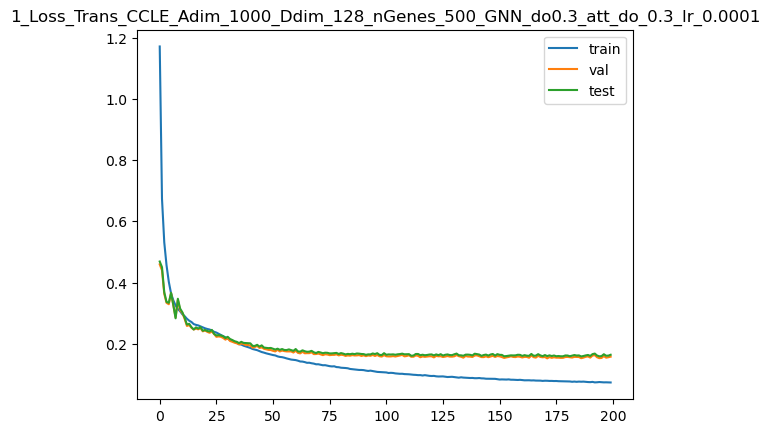

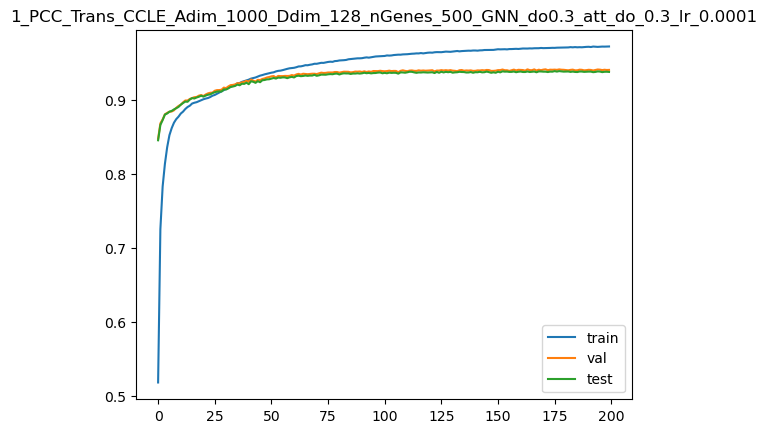

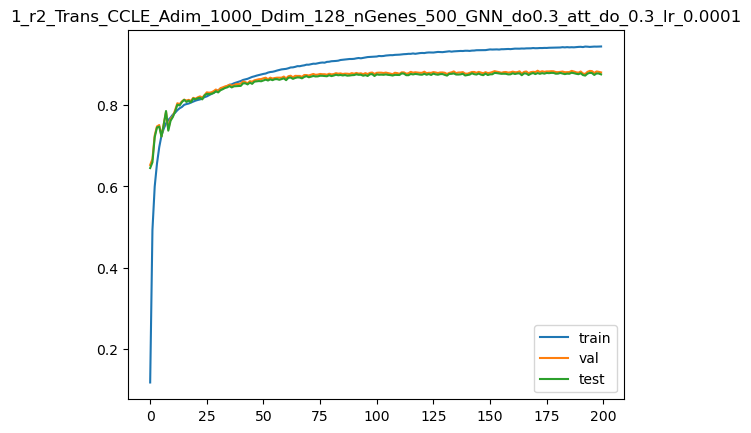

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15963653
Test avg_pcc:  0.9379184487394765
Test r2:  0.8792086098662004


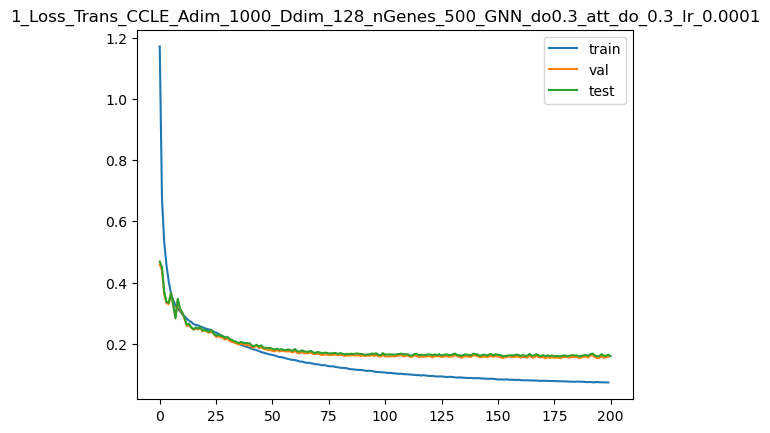

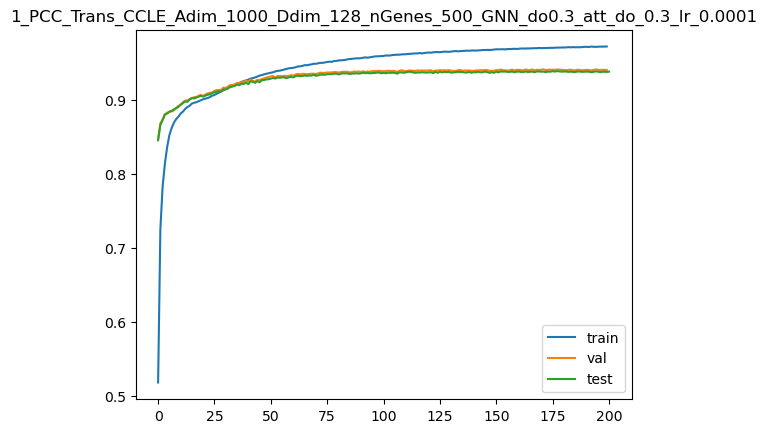

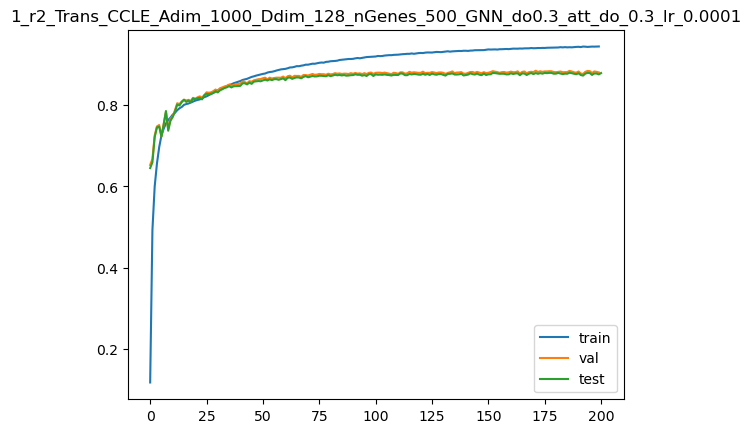

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.875835657119751
The overall Pearson's correlation is 0.6486.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.8812734484672546
The overall Pearson's correlation is 0.6443.
Train avg_loss:  1.1436104
Train avg_pcc:  0.5347465374643059
Train r2:  0.14425764142525543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.39901897
Validation avg_pcc:  0.845791835979856
Validation r2:  0.6958495204650501
Best Val r2  0.6958495204650501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.39839515
Test avg_pcc:  0.8433384885770263
Test r2:  0.6924001708339229
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.1134110689163208
The overall Pearson's correlation is 0.7000.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5396252870559692
The overall Pearson's correlation is 0.7923.
Train avg_loss:  0.6582335
Train avg_pcc:  0.7333814324035329
Train r2:  0.5074561511012645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.36719227
Validation avg_pcc:  0.8639546295864721
Validation r2:  0.7201092920774683
Best Val r2  0.7201092920774683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.36406583
Test avg_pcc:  0.8629092816684766
Test r2:  0.7189057591205134
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5581899881362915
The overall Pearson's correlation is 0.8256.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4083133637905121
The overall Pearson's correlation is 0.8453.
Train avg_loss:  0.5341253
Train avg_pcc:  0.783048451816681
Train r2:  0.6003239748522671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34250906
Validation avg_pcc:  0.8734404934205158
Validation r2:  0.7389239616065008
Best Val r2  0.7389239616065008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34133253
Test avg_pcc:  0.8716633997898192
Test r2:  0.7364580708335413
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.6066993474960327
The overall Pearson's correlation is 0.7814.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5575284957885742
The overall Pearson's correlation is 0.7729.
Train avg_loss:  0.4543235
Train avg_pcc:  0.8158221151938286
Train r2:  0.6600381735732272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3361073
Validation avg_pcc:  0.8756631464395992
Validation r2:  0.74380367467838
Best Val r2  0.74380367467838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3324378
Test avg_pcc:  0.8744249632271265
Test r2:  0.7433256442541216
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4397861361503601
The overall Pearson's correlation is 0.8424.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4740767478942871
The overall Pearson's correlation is 0.8024.
Train avg_loss:  0.39924258
Train avg_pcc:  0.8386055388569168
Train r2:  0.701254225460278


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32674563
Validation avg_pcc:  0.8797865817977683
Validation r2:  0.7509395740165882
Best Val r2  0.7509395740165882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3279136
Test avg_pcc:  0.8780265188400046
Test r2:  0.7468187876857213
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3049238324165344
The overall Pearson's correlation is 0.8454.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.6309329867362976
The overall Pearson's correlation is 0.7655.
Train avg_loss:  0.36608222
Train avg_pcc:  0.8525427329161215
Train r2:  0.7260674915455798


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.37230286
Validation avg_pcc:  0.880889801158381
Validation r2:  0.7162137519434502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.368458
Test avg_pcc:  0.8800694804329913
Test r2:  0.7155145846070314
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2685355246067047
The overall Pearson's correlation is 0.9082.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3873739242553711
The overall Pearson's correlation is 0.8367.
Train avg_loss:  0.34179255
Train avg_pcc:  0.8628543443443745
Train r2:  0.7442429944157799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30605337
Validation avg_pcc:  0.8842276661128764
Validation r2:  0.7667121590413375
Best Val r2  0.7667121590413375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30649453
Test avg_pcc:  0.881852653082051
Test r2:  0.7633563935658763
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.39194995164871216
The overall Pearson's correlation is 0.7964.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3461223244667053
The overall Pearson's correlation is 0.8694.
Train avg_loss:  0.32634926
Train avg_pcc:  0.8694200160948424
Train r2:  0.7557989277158675


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30210134
Validation avg_pcc:  0.8859290729539279
Validation r2:  0.7697245694572228
Best Val r2  0.7697245694572228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30243704
Test avg_pcc:  0.8841803727567169
Test r2:  0.7664891929402146
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20924481749534607
The overall Pearson's correlation is 0.9410.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.27730920910835266
The overall Pearson's correlation is 0.8799.
Train avg_loss:  0.31448156
Train avg_pcc:  0.8744840520804801
Train r2:  0.7646793151279827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2880302
Validation avg_pcc:  0.8876737539703209
Validation r2:  0.7804502320009932
Best Val r2  0.7804502320009932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28900513
Test avg_pcc:  0.8857715831976797
Test r2:  0.7768598964825366
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.290432333946228
The overall Pearson's correlation is 0.9113.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.32844996452331543
The overall Pearson's correlation is 0.8925.
Train avg_loss:  0.30510646
Train avg_pcc:  0.8784802855568185
Train r2:  0.7716945212352625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30370435
Validation avg_pcc:  0.886036127321893
Validation r2:  0.7685027030020547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30625045
Test avg_pcc:  0.8840048320639039
Test r2:  0.7635448370455308
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3473244309425354
The overall Pearson's correlation is 0.8835.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.306854784488678
The overall Pearson's correlation is 0.8773.
Train avg_loss:  0.29861
Train avg_pcc:  0.8812386596562142
Train r2:  0.7765556960399467


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27767533
Validation avg_pcc:  0.8904936581610028
Validation r2:  0.7883432052510952
Best Val r2  0.7883432052510952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27947998
Test avg_pcc:  0.8882267735784353
Test r2:  0.7842142469733209
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29165130853652954
The overall Pearson's correlation is 0.8350.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30086395144462585
The overall Pearson's correlation is 0.8848.
Train avg_loss:  0.29212868
Train avg_pcc:  0.883983276427094
Train r2:  0.7814055829641402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28430933
Validation avg_pcc:  0.8930975430049132
Validation r2:  0.7832864777552426


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28489158
Test avg_pcc:  0.8906313628430421
Test r2:  0.7800359676745252
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19651810824871063
The overall Pearson's correlation is 0.9127.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25929391384124756
The overall Pearson's correlation is 0.8629.
Train avg_loss:  0.28395554
Train avg_pcc:  0.8874333779938202
Train r2:  0.7875213772947633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26509687
Validation avg_pcc:  0.8968657301054508
Validation r2:  0.7979310841919383
Best Val r2  0.7979310841919383


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2669772
Test avg_pcc:  0.8941252663849113
Test r2:  0.7938676327793475
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31895437836647034
The overall Pearson's correlation is 0.8916.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2427794635295868
The overall Pearson's correlation is 0.8905.
Train avg_loss:  0.27637583
Train avg_pcc:  0.8906246131123501
Train r2:  0.7931931267736306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2810123
Validation avg_pcc:  0.8970258072546721
Validation r2:  0.7857995974771328


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2813433
Test avg_pcc:  0.8951026230696353
Test r2:  0.7827755885416687
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20430892705917358
The overall Pearson's correlation is 0.9150.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23724424839019775
The overall Pearson's correlation is 0.8946.
Train avg_loss:  0.27084187
Train avg_pcc:  0.8929458707835652
Train r2:  0.7973340844094361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26188487
Validation avg_pcc:  0.8999254999277609
Validation r2:  0.8003794148728282
Best Val r2  0.8003794148728282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26220667
Test avg_pcc:  0.8978721281791439
Test r2:  0.7975509169027586
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26516231894493103
The overall Pearson's correlation is 0.9211.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25554656982421875
The overall Pearson's correlation is 0.8896.
Train avg_loss:  0.26667428
Train avg_pcc:  0.8946900722039307
Train r2:  0.800452600239884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2575232
Validation avg_pcc:  0.9022352677098978
Validation r2:  0.8037040494096008
Best Val r2  0.8037040494096008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25953498
Test avg_pcc:  0.8998640250993597
Test r2:  0.7996137269380358
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1862839162349701
The overall Pearson's correlation is 0.8955.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3490903973579407
The overall Pearson's correlation is 0.8429.
Train avg_loss:  0.26244444
Train avg_pcc:  0.8964566698169842
Train r2:  0.803617707076201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26277363
Validation avg_pcc:  0.9017544567558259
Validation r2:  0.7997019335902518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2623856
Test avg_pcc:  0.8999174703491358
Test r2:  0.7974127841113487
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19916900992393494
The overall Pearson's correlation is 0.9153.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2533169388771057
The overall Pearson's correlation is 0.8995.
Train avg_loss:  0.25859162
Train avg_pcc:  0.8980631820140502
Train r2:  0.8065006861063577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26261678
Validation avg_pcc:  0.9024847837667033
Validation r2:  0.7998215118448668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26572967
Test avg_pcc:  0.8991292287915946
Test r2:  0.7948308306079296
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32646113634109497
The overall Pearson's correlation is 0.8860.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19570279121398926
The overall Pearson's correlation is 0.8827.
Train avg_loss:  0.25416756
Train avg_pcc:  0.8999029379749334
Train r2:  0.8098111535847072


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24861823
Validation avg_pcc:  0.9035744460567809
Validation r2:  0.8104918305492816
Best Val r2  0.8104918305492816


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25127065
Test avg_pcc:  0.9009025703951165
Test r2:  0.80599459871535
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2319525182247162
The overall Pearson's correlation is 0.8940.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26742032170295715
The overall Pearson's correlation is 0.8975.
Train avg_loss:  0.25189278
Train avg_pcc:  0.900850043003645
Train r2:  0.8115133371335668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24089453
Validation avg_pcc:  0.9044161898714146
Validation r2:  0.8163792044422358
Best Val r2  0.8163792044422358


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2434968
Test avg_pcc:  0.9019707625854728
Test r2:  0.8119967720373399
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3336893618106842
The overall Pearson's correlation is 0.9053.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25158122181892395
The overall Pearson's correlation is 0.8967.
Train avg_loss:  0.24758261
Train avg_pcc:  0.902636161076564
Train r2:  0.8147385512618197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24287912
Validation avg_pcc:  0.9037839455718987
Validation r2:  0.8148664489655219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2431802
Test avg_pcc:  0.9021276040174061
Test r2:  0.8122412203142221
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24496249854564667
The overall Pearson's correlation is 0.8852.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1983533501625061
The overall Pearson's correlation is 0.8723.
Train avg_loss:  0.24616486
Train avg_pcc:  0.9032223512342885
Train r2:  0.8157994217470443


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23872623
Validation avg_pcc:  0.9057842830885133
Validation r2:  0.8180319827753308
Best Val r2  0.8180319827753308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24172278
Test avg_pcc:  0.9030755292683915
Test r2:  0.8133664819738262
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2856990098953247
The overall Pearson's correlation is 0.8886.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.27309897541999817
The overall Pearson's correlation is 0.8993.
Train avg_loss:  0.243928
Train avg_pcc:  0.9041508548625287
Train r2:  0.8174732256616153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2363503
Validation avg_pcc:  0.9056067653208166
Validation r2:  0.8198430197332691
Best Val r2  0.8198430197332691


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23778363
Test avg_pcc:  0.9036362150434696
Test r2:  0.816407892468531
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2709779739379883
The overall Pearson's correlation is 0.9031.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16510695219039917
The overall Pearson's correlation is 0.9506.
Train avg_loss:  0.23965217
Train avg_pcc:  0.9059173488978771
Train r2:  0.820672743341124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23882541
Validation avg_pcc:  0.9067711337116465
Validation r2:  0.8179563870935078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24081048
Test avg_pcc:  0.9043691644345964
Test r2:  0.8140708774672885
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25582897663116455
The overall Pearson's correlation is 0.8923.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2532515525817871
The overall Pearson's correlation is 0.9136.
Train avg_loss:  0.2369256
Train avg_pcc:  0.9070433671987822
Train r2:  0.8227129699894424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23109055
Validation avg_pcc:  0.9079868382780906
Validation r2:  0.8238522443947004
Best Val r2  0.8238522443947004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.232363
Test avg_pcc:  0.9063016043100458
Test r2:  0.8205931614343387
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22646397352218628
The overall Pearson's correlation is 0.9227.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20312273502349854
The overall Pearson's correlation is 0.9249.
Train avg_loss:  0.2346214
Train avg_pcc:  0.9079918405605656
Train r2:  0.8244371797191254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23339283
Validation avg_pcc:  0.9097932628336405
Validation r2:  0.8220973284545083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23544516
Test avg_pcc:  0.9073448071140773
Test r2:  0.8182134051110563
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17939431965351105
The overall Pearson's correlation is 0.9208.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1881694495677948
The overall Pearson's correlation is 0.9316.
Train avg_loss:  0.23010898
Train avg_pcc:  0.9098494936428194
Train r2:  0.8278137371964106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22362636
Validation avg_pcc:  0.9113633560201216
Validation r2:  0.82954178754115
Best Val r2  0.82954178754115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22773392
Test avg_pcc:  0.9084304550125918
Test r2:  0.8241672347491548
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20753583312034607
The overall Pearson's correlation is 0.9162.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2519570589065552
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.226064
Train avg_pcc:  0.9115105977580522
Train r2:  0.8308405073693005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22388308
Validation avg_pcc:  0.9107904184928507
Validation r2:  0.8293461060520593


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22900535
Test avg_pcc:  0.907393518723854
Test r2:  0.8231855928793996
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2092713564634323
The overall Pearson's correlation is 0.9332.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17817968130111694
The overall Pearson's correlation is 0.9404.
Train avg_loss:  0.22354461
Train avg_pcc:  0.9125432941406757
Train r2:  0.8327257261606617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22408798
Validation avg_pcc:  0.91217520253154
Validation r2:  0.8291899120686554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22906579
Test avg_pcc:  0.908851709310038
Test r2:  0.8231389165322691
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20882031321525574
The overall Pearson's correlation is 0.9052.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26986366510391235
The overall Pearson's correlation is 0.9043.
Train avg_loss:  0.22083892
Train avg_pcc:  0.913652876513525
Train r2:  0.834750337207206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22056688
Validation avg_pcc:  0.913593694724454
Validation r2:  0.8318738515759017
Best Val r2  0.8318738515759017


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22421104
Test avg_pcc:  0.91095251225715
Test r2:  0.8268872543964767
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23998302221298218
The overall Pearson's correlation is 0.8906.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17433035373687744
The overall Pearson's correlation is 0.9195.
Train avg_loss:  0.21760793
Train avg_pcc:  0.9149752500671453
Train r2:  0.8371680339111107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21786283
Validation avg_pcc:  0.9140664969753225
Validation r2:  0.8339350082939441
Best Val r2  0.8339350082939441


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22163689
Test avg_pcc:  0.9111562683864775
Test r2:  0.8288747517113656
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.241171196103096
The overall Pearson's correlation is 0.9061.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24888496100902557
The overall Pearson's correlation is 0.8574.
Train avg_loss:  0.21257384
Train avg_pcc:  0.917029355770019
Train r2:  0.840934966250986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2138815
Validation avg_pcc:  0.9159744834891855
Validation r2:  0.8369697666512084
Best Val r2  0.8369697666512084


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21707259
Test avg_pcc:  0.9133517403848511
Test r2:  0.8323988361610676
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2973666787147522
The overall Pearson's correlation is 0.9297.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26505717635154724
The overall Pearson's correlation is 0.8647.
Train avg_loss:  0.21006435
Train avg_pcc:  0.9180539748725995
Train r2:  0.8428127478310505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20886095
Validation avg_pcc:  0.9171064502990481
Validation r2:  0.8407966601073698
Best Val r2  0.8407966601073698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21275939
Test avg_pcc:  0.9144118094227748
Test r2:  0.8357290506181676
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22085976600646973
The overall Pearson's correlation is 0.9068.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15432602167129517
The overall Pearson's correlation is 0.9036.
Train avg_loss:  0.20700383
Train avg_pcc:  0.9193005723935108
Train r2:  0.8451029078453864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20609233
Validation avg_pcc:  0.9182297057038453
Validation r2:  0.8429070353511405
Best Val r2  0.8429070353511405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21170413
Test avg_pcc:  0.914790853748057
Test r2:  0.8365438089964063
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25051379203796387
The overall Pearson's correlation is 0.8929.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18318885564804077
The overall Pearson's correlation is 0.8675.
Train avg_loss:  0.20370407
Train avg_pcc:  0.9206429204857525
Train r2:  0.847572044865765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20537622
Validation avg_pcc:  0.9184113973528328
Validation r2:  0.8434528809861099
Best Val r2  0.8434528809861099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20831893
Test avg_pcc:  0.9160833330163096
Test r2:  0.839157519139332
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20266708731651306
The overall Pearson's correlation is 0.9309.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19083622097969055
The overall Pearson's correlation is 0.9333.
Train avg_loss:  0.20012075
Train avg_pcc:  0.9220959672506619
Train r2:  0.8502533788823374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20244834
Validation avg_pcc:  0.9197127245220744
Validation r2:  0.8456846456197837
Best Val r2  0.8456846456197837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20649658
Test avg_pcc:  0.9168906622921416
Test r2:  0.8405645385261085
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11484595388174057
The overall Pearson's correlation is 0.9474.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18090152740478516
The overall Pearson's correlation is 0.9069.
Train avg_loss:  0.19722375
Train avg_pcc:  0.9232721984530341
Train r2:  0.8524211362956593


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20859538
Validation avg_pcc:  0.9203188562166089
Validation r2:  0.8409990999086322


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21201247
Test avg_pcc:  0.9177103890673821
Test r2:  0.8363057358372015
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12875133752822876
The overall Pearson's correlation is 0.9317.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20047461986541748
The overall Pearson's correlation is 0.9217.
Train avg_loss:  0.19301143
Train avg_pcc:  0.9249750123336947
Train r2:  0.8555731386848144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20516494
Validation avg_pcc:  0.9205735835033558
Validation r2:  0.8436139171389052


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21017176
Test avg_pcc:  0.9175170283784226
Test r2:  0.8377269468314067
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2065906673669815
The overall Pearson's correlation is 0.8755.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1580769121646881
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.19292845
Train avg_pcc:  0.9250131958079791
Train r2:  0.8556352258964801


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19903986
Validation avg_pcc:  0.9213835129696988
Validation r2:  0.8482827443349945
Best Val r2  0.8482827443349945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20382868
Test avg_pcc:  0.9182435178186528
Test r2:  0.8426244285420389
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19767899811267853
The overall Pearson's correlation is 0.9359.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.27774256467819214
The overall Pearson's correlation is 0.8649.
Train avg_loss:  0.18769029
Train avg_pcc:  0.9271253591992769
Train r2:  0.8595548613478752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19973074
Validation avg_pcc:  0.9237296867771787
Validation r2:  0.8477561113712242


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20341107
Test avg_pcc:  0.9211475988461889
Test r2:  0.8429468488666094
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15018342435359955
The overall Pearson's correlation is 0.9524.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19316987693309784
The overall Pearson's correlation is 0.9327.
Train avg_loss:  0.18617643
Train avg_pcc:  0.9277368086520207
Train r2:  0.860687640779549


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19267541
Validation avg_pcc:  0.9239578225613587
Validation r2:  0.8531339947683058
Best Val r2  0.8531339947683058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19826576
Test avg_pcc:  0.920646363770318
Test r2:  0.8469195374832028
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2159174084663391
The overall Pearson's correlation is 0.8761.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16072413325309753
The overall Pearson's correlation is 0.9444.
Train avg_loss:  0.18274122
Train avg_pcc:  0.9291213261016548
Train r2:  0.8632581409002321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19675745
Validation avg_pcc:  0.9219902042742449
Validation r2:  0.8500224937628623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20088072
Test avg_pcc:  0.9192299689055383
Test r2:  0.8449005372129599
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1701471209526062
The overall Pearson's correlation is 0.9397.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12196549028158188
The overall Pearson's correlation is 0.9487.
Train avg_loss:  0.18052192
Train avg_pcc:  0.930013862098906
Train r2:  0.8649188035085978


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1912433
Validation avg_pcc:  0.9251096580376366
Validation r2:  0.8542256246930533
Best Val r2  0.8542256246930533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19556957
Test avg_pcc:  0.9222516562773045
Test r2:  0.8490012567160435
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11568418145179749
The overall Pearson's correlation is 0.9566.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13947035372257233
The overall Pearson's correlation is 0.9520.
Train avg_loss:  0.17857589
Train avg_pcc:  0.9307974339496121
Train r2:  0.8663749873886253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18976504
Validation avg_pcc:  0.9250312155925533
Validation r2:  0.8553524315406207
Best Val r2  0.8553524315406207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19351785
Test avg_pcc:  0.9223615476013822
Test r2:  0.8505853876698022
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2259112447500229
The overall Pearson's correlation is 0.9018.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1535349190235138
The overall Pearson's correlation is 0.9418.
Train avg_loss:  0.17665976
Train avg_pcc:  0.9315660785090032
Train r2:  0.8678087916947761


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.187074
Validation avg_pcc:  0.9263400620584652
Validation r2:  0.8574036645926439
Best Val r2  0.8574036645926439


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19064616
Test avg_pcc:  0.9237953134789926
Test r2:  0.8528026264414822
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14769357442855835
The overall Pearson's correlation is 0.9413.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20029222965240479
The overall Pearson's correlation is 0.9325.
Train avg_loss:  0.17350118
Train avg_pcc:  0.9328346777584191
Train r2:  0.870172299455619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18790986
Validation avg_pcc:  0.9259352225213848
Validation r2:  0.8567665269246603


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19035843
Test avg_pcc:  0.923834628812319
Test r2:  0.8530247641907915
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1461930274963379
The overall Pearson's correlation is 0.9486.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20055358111858368
The overall Pearson's correlation is 0.9320.
Train avg_loss:  0.17128271
Train avg_pcc:  0.9337235402363728
Train r2:  0.8718323388945168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19277498
Validation avg_pcc:  0.9267173126126783
Validation r2:  0.8530581161930855


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19775246
Test avg_pcc:  0.923437686464349
Test r2:  0.8473158535529186
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14601212739944458
The overall Pearson's correlation is 0.9267.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13490162789821625
The overall Pearson's correlation is 0.9497.
Train avg_loss:  0.16939189
Train avg_pcc:  0.9344810929863003
Train r2:  0.8732472224059029


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18378538
Validation avg_pcc:  0.9276590111550761
Validation r2:  0.8599103942418655
Best Val r2  0.8599103942418655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18735144
Test avg_pcc:  0.9250966349818809
Test r2:  0.8553464573942882
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16259059309959412
The overall Pearson's correlation is 0.9454.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17396628856658936
The overall Pearson's correlation is 0.9391.
Train avg_loss:  0.16703032
Train avg_pcc:  0.9354254870970918
Train r2:  0.8750143195987301


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18599713
Validation avg_pcc:  0.9283529853432565
Validation r2:  0.85822450317775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18986025
Test avg_pcc:  0.9257516117585227
Test r2:  0.8534094213944907
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13799145817756653
The overall Pearson's correlation is 0.9591.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19579379260540009
The overall Pearson's correlation is 0.9189.
Train avg_loss:  0.16591656
Train avg_pcc:  0.9358716629636913
Train r2:  0.8758477251030945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17805153
Validation avg_pcc:  0.9297690442196697
Validation r2:  0.8642810043535631
Best Val r2  0.8642810043535631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1834757
Test avg_pcc:  0.92654548620404
Test r2:  0.8583389090111475


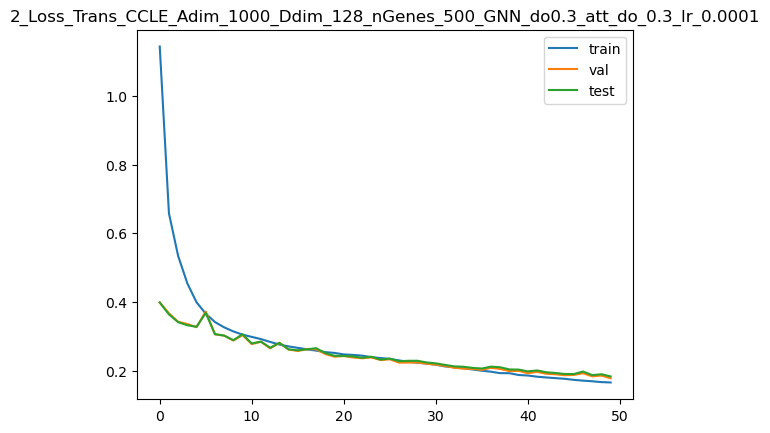

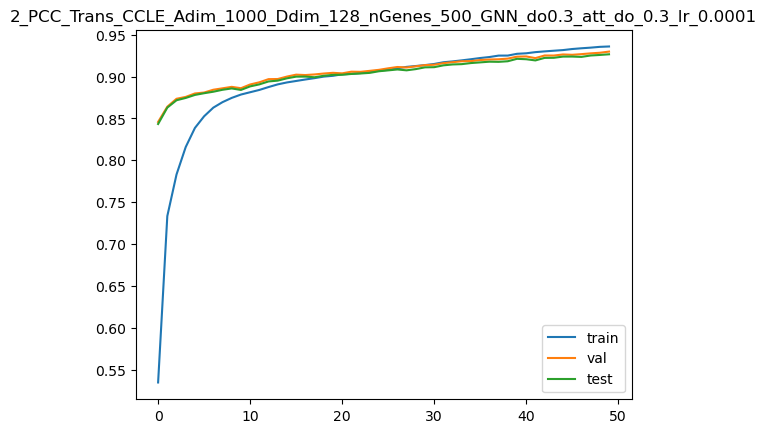

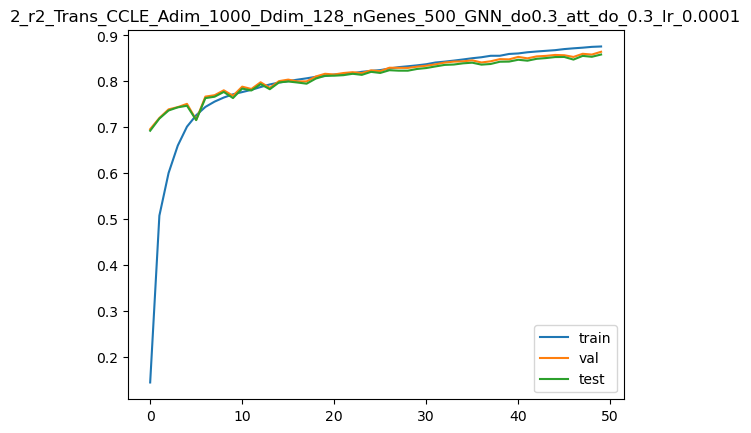

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15581446886062622
The overall Pearson's correlation is 0.9085.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23004725575447083
The overall Pearson's correlation is 0.9174.
Train avg_loss:  0.16280818
Train avg_pcc:  0.937113395678267
Train r2:  0.8781736601832577


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1846544
Validation avg_pcc:  0.9290541034195542
Validation r2:  0.8592479992037207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1893838
Test avg_pcc:  0.9261012517432206
Test r2:  0.8537772651987363
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17360937595367432
The overall Pearson's correlation is 0.9505.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15654225647449493
The overall Pearson's correlation is 0.9285.
Train avg_loss:  0.16094065
Train avg_pcc:  0.9378583813495649
Train r2:  0.8795711009612831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18073834
Validation avg_pcc:  0.9298808684659198
Validation r2:  0.8622329857782698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18590772
Test avg_pcc:  0.9266032192339483
Test r2:  0.8564611345096811
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14519339799880981
The overall Pearson's correlation is 0.9425.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13242840766906738
The overall Pearson's correlation is 0.9190.
Train avg_loss:  0.15954553
Train avg_pcc:  0.9384143128872138
Train r2:  0.8806150402787748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17895827
Validation avg_pcc:  0.9298859670909789
Validation r2:  0.863589836057665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18431954
Test avg_pcc:  0.9265692030163996
Test r2:  0.8576873906364153
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18872201442718506
The overall Pearson's correlation is 0.9493.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12145629525184631
The overall Pearson's correlation is 0.9610.
Train avg_loss:  0.15827747
Train avg_pcc:  0.9389194154632587
Train r2:  0.8815639419674912


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18101606
Validation avg_pcc:  0.9299011125651628
Validation r2:  0.8620213063209472


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18549159
Test avg_pcc:  0.9267958209379833
Test r2:  0.8567824453772729
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17036072909832
The overall Pearson's correlation is 0.9256.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25061357021331787
The overall Pearson's correlation is 0.8943.
Train avg_loss:  0.1568941
Train avg_pcc:  0.9394710855747134
Train r2:  0.8825990686666041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1799609
Validation avg_pcc:  0.9295032721742639
Validation r2:  0.8628255897224714


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1854517
Test avg_pcc:  0.9261624581951323
Test r2:  0.8568132255723432
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12835055589675903
The overall Pearson's correlation is 0.9585.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18069666624069214
The overall Pearson's correlation is 0.9342.
Train avg_loss:  0.15384544
Train avg_pcc:  0.9406840962293888
Train r2:  0.884880322999113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18024263
Validation avg_pcc:  0.9296015533104584
Validation r2:  0.8626108476962592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18496329
Test avg_pcc:  0.92683276260691
Test r2:  0.8571903504302875
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1401061713695526
The overall Pearson's correlation is 0.9442.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1244790107011795
The overall Pearson's correlation is 0.9630.
Train avg_loss:  0.15269355
Train avg_pcc:  0.9411425461410076
Train r2:  0.8857422419929927


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17550866
Validation avg_pcc:  0.9308058144104226
Validation r2:  0.8662192891717435
Best Val r2  0.8662192891717435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18039592
Test avg_pcc:  0.9278013491416623
Test r2:  0.8607167823247549
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22546051442623138
The overall Pearson's correlation is 0.8839.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13447661697864532
The overall Pearson's correlation is 0.9383.
Train avg_loss:  0.15232703
Train avg_pcc:  0.9412884728358708
Train r2:  0.8860165102199659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18156824
Validation avg_pcc:  0.9317325973129138
Validation r2:  0.8616004194864394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18572533
Test avg_pcc:  0.9287220950425961
Test r2:  0.8566019759551478
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15738445520401
The overall Pearson's correlation is 0.9484.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18182821571826935
The overall Pearson's correlation is 0.9462.
Train avg_loss:  0.14926945
Train avg_pcc:  0.9425026568278396
Train r2:  0.8883044584970393


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17634313
Validation avg_pcc:  0.9322555381415308
Validation r2:  0.8655832192865535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18225376
Test avg_pcc:  0.9287473205598881
Test r2:  0.8592823516825467
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12269411981105804
The overall Pearson's correlation is 0.9582.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09062948077917099
The overall Pearson's correlation is 0.9621.
Train avg_loss:  0.14964974
Train avg_pcc:  0.9423520577615401
Train r2:  0.8880198935081279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1766445
Validation avg_pcc:  0.9315076992273004
Validation r2:  0.8653534943453016


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1802373
Test avg_pcc:  0.9288575198945414
Test r2:  0.8608392656158336
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13931630551815033
The overall Pearson's correlation is 0.9599.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12417640537023544
The overall Pearson's correlation is 0.9608.
Train avg_loss:  0.14598815
Train avg_pcc:  0.9438046024381548
Train r2:  0.8907597893602519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17478997
Validation avg_pcc:  0.9319630575057732
Validation r2:  0.866767107576008
Best Val r2  0.866767107576008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17844361
Test avg_pcc:  0.9293101169809073
Test r2:  0.8622241725720333
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11907801777124405
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20724648237228394
The overall Pearson's correlation is 0.9208.
Train avg_loss:  0.1444305
Train avg_pcc:  0.944420820784644
Train r2:  0.8919253437935051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17486049
Validation avg_pcc:  0.9316039005958425
Validation r2:  0.8667133654123225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1790287
Test avg_pcc:  0.928851015537129
Test r2:  0.8617724212578266
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13485804200172424
The overall Pearson's correlation is 0.9355.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15780684351921082
The overall Pearson's correlation is 0.9550.
Train avg_loss:  0.14367768
Train avg_pcc:  0.9447196418865976
Train r2:  0.8924886672653132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17164883
Validation avg_pcc:  0.9323683756308242
Validation r2:  0.8691614248267161
Best Val r2  0.8691614248267161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17582442
Test avg_pcc:  0.9296856169773327
Test r2:  0.864246443586153
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1514427214860916
The overall Pearson's correlation is 0.9478.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12508538365364075
The overall Pearson's correlation is 0.9610.
Train avg_loss:  0.14193608
Train avg_pcc:  0.9454088120625418
Train r2:  0.8937918725485412


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17019993
Validation avg_pcc:  0.933386336954533
Validation r2:  0.8702658458703834
Best Val r2  0.8702658458703834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1740543
Test avg_pcc:  0.930748576138578
Test r2:  0.865613132839962
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12040114402770996
The overall Pearson's correlation is 0.9461.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17389023303985596
The overall Pearson's correlation is 0.9361.
Train avg_loss:  0.13989407
Train avg_pcc:  0.9462167701283871
Train r2:  0.8953198754710497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16900045
Validation avg_pcc:  0.9335627530077514
Validation r2:  0.871180151920001
Best Val r2  0.871180151920001


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17300892
Test avg_pcc:  0.9309915852882691
Test r2:  0.8664202695829387
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11120778322219849
The overall Pearson's correlation is 0.9247.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1194957047700882
The overall Pearson's correlation is 0.9529.
Train avg_loss:  0.1384567
Train avg_pcc:  0.9467851019673565
Train r2:  0.8963954240209921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17392822
Validation avg_pcc:  0.9328983759153573
Validation r2:  0.867423978543103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17821993
Test avg_pcc:  0.9300446449154617
Test r2:  0.8623968634578701
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1336725801229477
The overall Pearson's correlation is 0.9387.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17125055193901062
The overall Pearson's correlation is 0.9422.
Train avg_loss:  0.13810715
Train avg_pcc:  0.9469227977045178
Train r2:  0.896656992840415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16929206
Validation avg_pcc:  0.9338846836074387
Validation r2:  0.8709578772845952


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17461568
Test avg_pcc:  0.9306702202208388
Test r2:  0.8651796962291367
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20149976015090942
The overall Pearson's correlation is 0.9377.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1083345115184784
The overall Pearson's correlation is 0.9545.
Train avg_loss:  0.13690953
Train avg_pcc:  0.9473960898720453
Train r2:  0.897553138723364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16913095
Validation avg_pcc:  0.9338721196011832
Validation r2:  0.8710806758457982


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17274149
Test avg_pcc:  0.9313505247524261
Test r2:  0.8666267555161024
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0888771116733551
The overall Pearson's correlation is 0.9651.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1525561809539795
The overall Pearson's correlation is 0.9425.
Train avg_loss:  0.13615412
Train avg_pcc:  0.9476952463267992
Train r2:  0.898118408289827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16957104
Validation avg_pcc:  0.93440358480217
Validation r2:  0.8707452158931923


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17404096
Test avg_pcc:  0.9313640674048457
Test r2:  0.8656234401275666
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16451746225357056
The overall Pearson's correlation is 0.9018.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15401838719844818
The overall Pearson's correlation is 0.9482.
Train avg_loss:  0.13450727
Train avg_pcc:  0.9483437510951832
Train r2:  0.8993507208002038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17028305
Validation avg_pcc:  0.9339791580700423
Validation r2:  0.8702024786379063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17495793
Test avg_pcc:  0.9309724897873761
Test r2:  0.8649154392341509
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12863655388355255
The overall Pearson's correlation is 0.9552.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12676271796226501
The overall Pearson's correlation is 0.9370.
Train avg_loss:  0.13292383
Train avg_pcc:  0.9489686331564607
Train r2:  0.9005355740145515


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17302577
Validation avg_pcc:  0.9331054142289705
Validation r2:  0.8681118508232267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17736736
Test avg_pcc:  0.9302161708190458
Test r2:  0.8630551343408805
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12671922147274017
The overall Pearson's correlation is 0.9582.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14500504732131958
The overall Pearson's correlation is 0.9245.
Train avg_loss:  0.13154948
Train avg_pcc:  0.9495104833968302
Train r2:  0.9015639762980465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16626534
Validation avg_pcc:  0.9355409608748165
Validation r2:  0.8732649775414002
Best Val r2  0.8732649775414002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17243302
Test avg_pcc:  0.9319726823723831
Test r2:  0.8668649258145884
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16238701343536377
The overall Pearson's correlation is 0.9622.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10305313766002655
The overall Pearson's correlation is 0.9706.
Train avg_loss:  0.13080503
Train avg_pcc:  0.949803514055099
Train r2:  0.9021210176566724


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16931778
Validation avg_pcc:  0.933648071798225
Validation r2:  0.8709382575849502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17334203
Test avg_pcc:  0.9309617895192045
Test r2:  0.8661630835114008
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12698949873447418
The overall Pearson's correlation is 0.9504.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10081810504198074
The overall Pearson's correlation is 0.9700.
Train avg_loss:  0.12891519
Train avg_pcc:  0.9505479177128302
Train r2:  0.903535166254638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16506428
Validation avg_pcc:  0.9357688855592858
Validation r2:  0.874180471557225
Best Val r2  0.874180471557225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17128064
Test avg_pcc:  0.9322332443338603
Test r2:  0.8677546783086512
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1696936935186386
The overall Pearson's correlation is 0.9436.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11655876040458679
The overall Pearson's correlation is 0.9555.
Train avg_loss:  0.1286787
Train avg_pcc:  0.950640619707167
Train r2:  0.9037121278508168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16526105
Validation avg_pcc:  0.9353877160757883
Validation r2:  0.874030495880254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17025416
Test avg_pcc:  0.9324018410694229
Test r2:  0.8685472198535253
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15906734764575958
The overall Pearson's correlation is 0.9625.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11420886963605881
The overall Pearson's correlation is 0.9549.
Train avg_loss:  0.12824923
Train avg_pcc:  0.9508101682515692
Train r2:  0.9040334998158219


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16914883
Validation avg_pcc:  0.9353647202956487
Validation r2:  0.8710670416908685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1738381
Test avg_pcc:  0.9324063883168396
Test r2:  0.8657800730186387
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17262326180934906
The overall Pearson's correlation is 0.9376.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11131323873996735
The overall Pearson's correlation is 0.9392.
Train avg_loss:  0.12642792
Train avg_pcc:  0.9515263452867453
Train r2:  0.9053963407289681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17273587
Validation avg_pcc:  0.9334146889468511
Validation r2:  0.8683328472330425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17705314
Test avg_pcc:  0.9305672629057484
Test r2:  0.8632977418193224
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1138906255364418
The overall Pearson's correlation is 0.9461.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10456030070781708
The overall Pearson's correlation is 0.9787.
Train avg_loss:  0.12593518
Train avg_pcc:  0.9517195131616982
Train r2:  0.9057650580468783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16607344
Validation avg_pcc:  0.9356128467282443
Validation r2:  0.8734112353459315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17142087
Test avg_pcc:  0.9324014587487753
Test r2:  0.8676464033693003
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13613682985305786
The overall Pearson's correlation is 0.9562.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14889191091060638
The overall Pearson's correlation is 0.9332.
Train avg_loss:  0.12402609
Train avg_pcc:  0.9524696346436328
Train r2:  0.9071935883953948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16539627
Validation avg_pcc:  0.9355126554683305
Validation r2:  0.8739274151537558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16942899
Test avg_pcc:  0.9328769320146126
Test r2:  0.8691843309072428
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12726734578609467
The overall Pearson's correlation is 0.9550.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14195998013019562
The overall Pearson's correlation is 0.9536.
Train avg_loss:  0.12359084
Train avg_pcc:  0.9526413325989281
Train r2:  0.9075192791671928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16886348
Validation avg_pcc:  0.9346230671233954
Validation r2:  0.8712845565215572


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17212912
Test avg_pcc:  0.932213153362795
Test r2:  0.8670995597709319
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13607490062713623
The overall Pearson's correlation is 0.9571.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13758841156959534
The overall Pearson's correlation is 0.9450.
Train avg_loss:  0.1224971
Train avg_pcc:  0.9530704946375972
Train r2:  0.9083377022889279


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17701928
Validation avg_pcc:  0.935908690721193
Validation r2:  0.8650678296372802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18000561
Test avg_pcc:  0.9333229016620901
Test r2:  0.8610181538815918
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1800719052553177
The overall Pearson's correlation is 0.9420.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15588024258613586
The overall Pearson's correlation is 0.9296.
Train avg_loss:  0.120249584
Train avg_pcc:  0.9539523744227029
Train r2:  0.9100194708809073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1744516
Validation avg_pcc:  0.9359467596821422
Validation r2:  0.8670250316380957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17774262
Test avg_pcc:  0.9333218957834687
Test r2:  0.8627654044653985
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21023255586624146
The overall Pearson's correlation is 0.9324.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14720579981803894
The overall Pearson's correlation is 0.9516.
Train avg_loss:  0.120369986
Train avg_pcc:  0.9539057457040702
Train r2:  0.9099293870132888


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16486804
Validation avg_pcc:  0.9361611864754185
Validation r2:  0.8743300579165917
Best Val r2  0.8743300579165917


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16886589
Test avg_pcc:  0.9334785527737899
Test r2:  0.8696191012938025
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13211128115653992
The overall Pearson's correlation is 0.9549.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10951908677816391
The overall Pearson's correlation is 0.9628.
Train avg_loss:  0.11947957
Train avg_pcc:  0.9542541610315034
Train r2:  0.9105956704901264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16829206
Validation avg_pcc:  0.9352121817959856
Validation r2:  0.871720113078077


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17106222
Test avg_pcc:  0.9329383448839776
Test r2:  0.8679233171120112
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09101120382547379
The overall Pearson's correlation is 0.9491.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13208645582199097
The overall Pearson's correlation is 0.9038.
Train avg_loss:  0.117521405
Train avg_pcc:  0.9550218327224214
Train r2:  0.9120609196991554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16455851
Validation avg_pcc:  0.9356071771477639
Validation r2:  0.8745659920733215
Best Val r2  0.8745659920733215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16974784
Test avg_pcc:  0.9324936261889658
Test r2:  0.8689381477813356
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11305303871631622
The overall Pearson's correlation is 0.9614.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12423780560493469
The overall Pearson's correlation is 0.9641.
Train avg_loss:  0.117144674
Train avg_pcc:  0.9551695253023622
Train r2:  0.9123428174356858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16741332
Validation avg_pcc:  0.9355964842958987
Validation r2:  0.8723899305906512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.170221
Test avg_pcc:  0.9333455982083593
Test r2:  0.8685728312171638
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1281239092350006
The overall Pearson's correlation is 0.9620.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10579249262809753
The overall Pearson's correlation is 0.9649.
Train avg_loss:  0.11654654
Train avg_pcc:  0.9554031881938257
Train r2:  0.912790390518396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16386549
Validation avg_pcc:  0.9357037416486158
Validation r2:  0.8750942595342367
Best Val r2  0.8750942595342367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16752324
Test avg_pcc:  0.9333309190679886
Test r2:  0.87065575084632
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11655616015195847
The overall Pearson's correlation is 0.9654.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08398261666297913
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.116218776
Train avg_pcc:  0.9555326281811569
Train r2:  0.9130356566590956


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16669767
Validation avg_pcc:  0.936290650544546
Validation r2:  0.8729354375255337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17057697
Test avg_pcc:  0.9336539373585931
Test r2:  0.8682979777168407
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07434625178575516
The overall Pearson's correlation is 0.9731.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08696423470973969
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.11442769
Train avg_pcc:  0.95623241369971
Train r2:  0.914375888272474


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16240552
Validation avg_pcc:  0.9364617658280258
Validation r2:  0.8762071043985792
Best Val r2  0.8762071043985792


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16590512
Test avg_pcc:  0.9340525082288269
Test r2:  0.8719051017224378
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14700300991535187
The overall Pearson's correlation is 0.9489.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0816684141755104
The overall Pearson's correlation is 0.9709.
Train avg_loss:  0.11458232
Train avg_pcc:  0.9561721048068184
Train r2:  0.9142601842883842


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16331698
Validation avg_pcc:  0.9367440900283921
Validation r2:  0.8755123465657183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16758776
Test avg_pcc:  0.9340291127127892
Test r2:  0.8706059488397961
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14541848003864288
The overall Pearson's correlation is 0.9550.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12444542348384857
The overall Pearson's correlation is 0.9477.
Train avg_loss:  0.113790505
Train avg_pcc:  0.9564825811137887
Train r2:  0.9148526828866429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16202345
Validation avg_pcc:  0.9366939344554691
Validation r2:  0.8764983272235247
Best Val r2  0.8764983272235247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16665371
Test avg_pcc:  0.9339824799888298
Test r2:  0.8713271041230337
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07176439464092255
The overall Pearson's correlation is 0.9742.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1101054698228836
The overall Pearson's correlation is 0.9672.
Train avg_loss:  0.11267311
Train avg_pcc:  0.9569190091601663
Train r2:  0.9156888111461909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16385728
Validation avg_pcc:  0.9373027120450447
Validation r2:  0.8751005028347271


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16884935
Test avg_pcc:  0.9340959468076
Test r2:  0.8696318748507652
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11130727082490921
The overall Pearson's correlation is 0.9634.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10972748696804047
The overall Pearson's correlation is 0.9430.
Train avg_loss:  0.11178745
Train avg_pcc:  0.9572654976306622
Train r2:  0.9163515262465112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1625112
Validation avg_pcc:  0.9372580334306786
Validation r2:  0.8761265447101174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16615918
Test avg_pcc:  0.934794639201473
Test r2:  0.8717089376528364
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11555351316928864
The overall Pearson's correlation is 0.9627.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0967930257320404
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.1114324
Train avg_pcc:  0.95740430976424
Train r2:  0.9166172029206967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16555871
Validation avg_pcc:  0.9370846806646458
Validation r2:  0.8738035947244445


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16864641
Test avg_pcc:  0.9346948120323658
Test r2:  0.8697885605528392
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08568275719881058
The overall Pearson's correlation is 0.9686.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0977996289730072
The overall Pearson's correlation is 0.9660.
Train avg_loss:  0.11039837
Train avg_pcc:  0.9578079317286385
Train r2:  0.9173909614709984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16658255
Validation avg_pcc:  0.936148125675749
Validation r2:  0.8730231795483303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17063977
Test avg_pcc:  0.9334397699019619
Test r2:  0.8682495046223746
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08362037688493729
The overall Pearson's correlation is 0.9755.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10257074981927872
The overall Pearson's correlation is 0.9657.
Train avg_loss:  0.10929639
Train avg_pcc:  0.9582381675089585
Train r2:  0.9182155513534485


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16068584
Validation avg_pcc:  0.9375988376127442
Validation r2:  0.8775179260025805
Best Val r2  0.8775179260025805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16533054
Test avg_pcc:  0.9346470043307724
Test r2:  0.8723487236883618
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13973960280418396
The overall Pearson's correlation is 0.9301.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08934710919857025
The overall Pearson's correlation is 0.9670.
Train avg_loss:  0.10767008
Train avg_pcc:  0.9588730582381882
Train r2:  0.9194324812158345


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16011669
Validation avg_pcc:  0.9376920606796094
Validation r2:  0.8779517501435992
Best Val r2  0.8779517501435992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16604677
Test avg_pcc:  0.9343649243117165
Test r2:  0.8717957472946245
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11376732587814331
The overall Pearson's correlation is 0.9582.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1337355077266693
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.1086987
Train avg_pcc:  0.9584721451384318
Train r2:  0.9186627906157167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16198385
Validation avg_pcc:  0.9373199857585179
Validation r2:  0.876528522775442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16573544
Test avg_pcc:  0.9347783568927281
Test r2:  0.8720361075265032
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06966068595647812
The overall Pearson's correlation is 0.9820.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09669545292854309
The overall Pearson's correlation is 0.9698.
Train avg_loss:  0.10778327
Train avg_pcc:  0.9588285847711121
Train r2:  0.9193477807579764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16300143
Validation avg_pcc:  0.9369949186047022
Validation r2:  0.8757528693941043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16554031
Test avg_pcc:  0.9348891013412364
Test r2:  0.8721867753631094
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1205255463719368
The overall Pearson's correlation is 0.9617.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09114810824394226
The overall Pearson's correlation is 0.9573.
Train avg_loss:  0.10649329
Train avg_pcc:  0.9593325762184417
Train r2:  0.9203130580455889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16425323
Validation avg_pcc:  0.9359932505281303
Validation r2:  0.8747986934673769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16697857
Test avg_pcc:  0.9338565732898005
Test r2:  0.8710763014681622


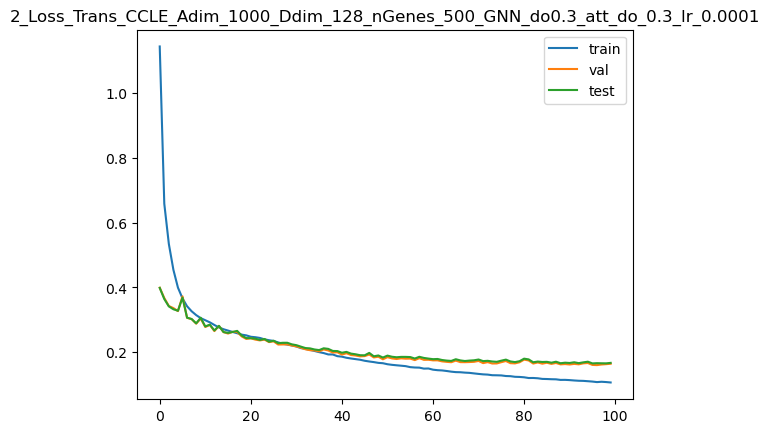

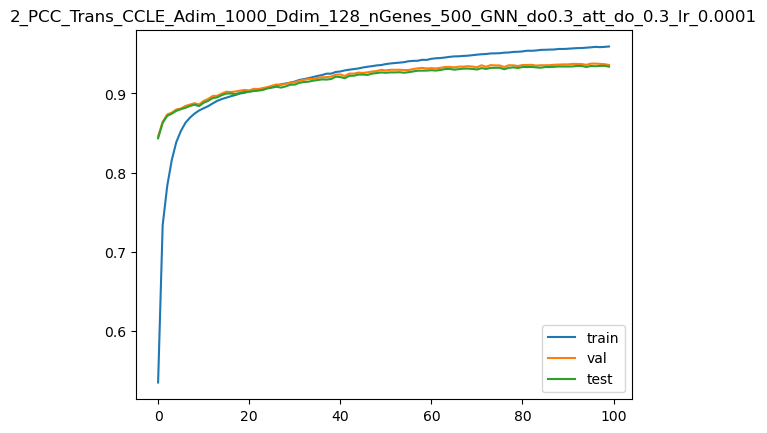

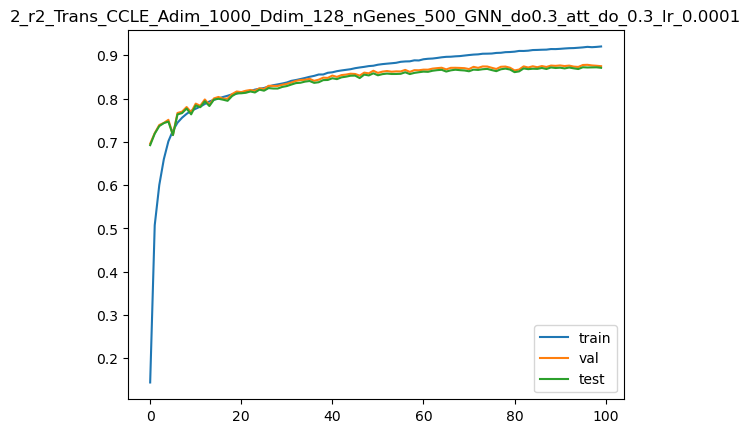

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09859296679496765
The overall Pearson's correlation is 0.9660.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11146921664476395
The overall Pearson's correlation is 0.9634.
Train avg_loss:  0.106422156
Train avg_pcc:  0.9593598164126566
Train r2:  0.9203662760218783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16223681
Validation avg_pcc:  0.936505399346627
Validation r2:  0.8763356948137214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16447262
Test avg_pcc:  0.9346221748171878
Test r2:  0.8730111347998595
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13253828883171082
The overall Pearson's correlation is 0.9682.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1391245722770691
The overall Pearson's correlation is 0.9552.
Train avg_loss:  0.10593315
Train avg_pcc:  0.9595509066752016
Train r2:  0.9207321987378153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16384856
Validation avg_pcc:  0.9372636570297428
Validation r2:  0.8751071495618565


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1666908
Test avg_pcc:  0.9349063097960922
Test r2:  0.871298480758287
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09389194846153259
The overall Pearson's correlation is 0.9694.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0608639195561409
The overall Pearson's correlation is 0.9782.
Train avg_loss:  0.105454765
Train avg_pcc:  0.9597371181818503
Train r2:  0.9210901619077273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15948012
Validation avg_pcc:  0.9385058150973056
Validation r2:  0.8784369843220395
Best Val r2  0.8784369843220395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16401727
Test avg_pcc:  0.935509978536307
Test r2:  0.8733627045441674
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11035783588886261
The overall Pearson's correlation is 0.9653.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.072273388504982
The overall Pearson's correlation is 0.9793.
Train avg_loss:  0.10444367
Train avg_pcc:  0.9601306868201305
Train r2:  0.92184674688601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16095686
Validation avg_pcc:  0.9378133617747687
Validation r2:  0.8773113337668159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16620335
Test avg_pcc:  0.9347709793452941
Test r2:  0.871674833709573
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11101377755403519
The overall Pearson's correlation is 0.9634.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12789088487625122
The overall Pearson's correlation is 0.9483.
Train avg_loss:  0.10349488
Train avg_pcc:  0.9605003845357886
Train r2:  0.9225567147953173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15811034
Validation avg_pcc:  0.937960022747872
Validation r2:  0.8794810879172626
Best Val r2  0.8794810879172626


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1632803
Test avg_pcc:  0.9349520587581963
Test r2:  0.8739317316980837
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11225004494190216
The overall Pearson's correlation is 0.9643.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07894483208656311
The overall Pearson's correlation is 0.9656.
Train avg_loss:  0.102867484
Train avg_pcc:  0.9607456403309867
Train r2:  0.9230261837409707


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16133866
Validation avg_pcc:  0.9374623882148309
Validation r2:  0.8770203166263556


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16506776
Test avg_pcc:  0.9349441254295875
Test r2:  0.8725516193707944
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10226563364267349
The overall Pearson's correlation is 0.9646.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12886232137680054
The overall Pearson's correlation is 0.9568.
Train avg_loss:  0.102345616
Train avg_pcc:  0.9609486465469196
Train r2:  0.9234166855936614


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16177005
Validation avg_pcc:  0.9383913743576277
Validation r2:  0.8766914839317916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16711494
Test avg_pcc:  0.9353001183929228
Test r2:  0.8709710073890299
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12801101803779602
The overall Pearson's correlation is 0.9526.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11175759881734848
The overall Pearson's correlation is 0.9503.
Train avg_loss:  0.10154768
Train avg_pcc:  0.9612583972723223
Train r2:  0.9240137609045154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16110207
Validation avg_pcc:  0.9380277573867141
Validation r2:  0.8772006649321569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1655803
Test avg_pcc:  0.9351281867586594
Test r2:  0.8721558939033505
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09623846411705017
The overall Pearson's correlation is 0.9662.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09206254780292511
The overall Pearson's correlation is 0.9712.
Train avg_loss:  0.1010787
Train avg_pcc:  0.9614407053846424
Train r2:  0.9243646898208722


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16240023
Validation avg_pcc:  0.936707503430202
Validation r2:  0.8762111351512734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16710193
Test avg_pcc:  0.9337779670322304
Test r2:  0.8709810508225139
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11925540864467621
The overall Pearson's correlation is 0.9404.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11137518286705017
The overall Pearson's correlation is 0.9559.
Train avg_loss:  0.1010675
Train avg_pcc:  0.9614465458951077
Train r2:  0.9243730713548819


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16108216
Validation avg_pcc:  0.9376243127721337
Validation r2:  0.877215824542627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16521774
Test avg_pcc:  0.9349161569403499
Test r2:  0.8724358336815556
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07202029228210449
The overall Pearson's correlation is 0.9468.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08431117236614227
The overall Pearson's correlation is 0.9567.
Train avg_loss:  0.10083137
Train avg_pcc:  0.9615367986412882
Train r2:  0.9245497636091249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15747027
Validation avg_pcc:  0.9389059266870643
Validation r2:  0.879968967317081
Best Val r2  0.879968967317081


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16322497
Test avg_pcc:  0.9356132473053587
Test r2:  0.8739744479503156
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08390765637159348
The overall Pearson's correlation is 0.9708.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12470397353172302
The overall Pearson's correlation is 0.9547.
Train avg_loss:  0.099233955
Train avg_pcc:  0.9621586143780296
Train r2:  0.9257450826755573


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15912083
Validation avg_pcc:  0.9380427690592005
Validation r2:  0.8787108503180435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16375488
Test avg_pcc:  0.9353177825389326
Test r2:  0.8735652920110719
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1166454553604126
The overall Pearson's correlation is 0.9600.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09494494646787643
The overall Pearson's correlation is 0.9698.
Train avg_loss:  0.098729864
Train avg_pcc:  0.9623550236283984
Train r2:  0.9261222823698175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16123231
Validation avg_pcc:  0.9375524432730687
Validation r2:  0.8771013791568203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16616
Test avg_pcc:  0.9345898257917514
Test r2:  0.8717083077673297
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1142963320016861
The overall Pearson's correlation is 0.9707.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1281464397907257
The overall Pearson's correlation is 0.9460.
Train avg_loss:  0.09859304
Train avg_pcc:  0.9624081502924792
Train r2:  0.9262246713997861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16510972
Validation avg_pcc:  0.9377203912975292
Validation r2:  0.8741458451872397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16966693
Test avg_pcc:  0.9348627689320246
Test r2:  0.8690006137572539
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11465845257043839
The overall Pearson's correlation is 0.9526.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12990307807922363
The overall Pearson's correlation is 0.9294.
Train avg_loss:  0.098132625
Train avg_pcc:  0.9625874173825033
Train r2:  0.9265691828277872


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1584423
Validation avg_pcc:  0.9388815111716984
Validation r2:  0.8792280455966258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16342294
Test avg_pcc:  0.9359170296148033
Test r2:  0.8738215886594257
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1061825156211853
The overall Pearson's correlation is 0.9394.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11339236795902252
The overall Pearson's correlation is 0.9496.
Train avg_loss:  0.09798687
Train avg_pcc:  0.9626432206659793
Train r2:  0.926678246160484


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15783201
Validation avg_pcc:  0.9384358255905044
Validation r2:  0.879693227953162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1627229
Test avg_pcc:  0.9354499591008614
Test r2:  0.8743620859637806
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08794554322957993
The overall Pearson's correlation is 0.9624.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07609239220619202
The overall Pearson's correlation is 0.9672.
Train avg_loss:  0.097109795
Train avg_pcc:  0.9629843406143328
Train r2:  0.9273345529716164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15718383
Validation avg_pcc:  0.938722255142397
Validation r2:  0.8801873122740493
Best Val r2  0.8801873122740493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16270036
Test avg_pcc:  0.9355007543277979
Test r2:  0.8743794814909475
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11501193046569824
The overall Pearson's correlation is 0.9691.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09733616560697556
The overall Pearson's correlation is 0.9691.
Train avg_loss:  0.097690254
Train avg_pcc:  0.9627591131514308
Train r2:  0.9269002040190846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15983103
Validation avg_pcc:  0.9384891713226217
Validation r2:  0.8781694956471666


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.164937
Test avg_pcc:  0.9356712279885092
Test r2:  0.8726525878799134
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09214607626199722
The overall Pearson's correlation is 0.9619.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12588170170783997
The overall Pearson's correlation is 0.9628.
Train avg_loss:  0.09648835
Train avg_pcc:  0.9632261880876751
Train r2:  0.9277995712315004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15815358
Validation avg_pcc:  0.9383674060448801
Validation r2:  0.8794481312863388


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16315633
Test avg_pcc:  0.9353916634216634
Test r2:  0.8740274373404284
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11719027906656265
The overall Pearson's correlation is 0.9640.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07787658274173737
The overall Pearson's correlation is 0.9672.
Train avg_loss:  0.09540145
Train avg_pcc:  0.9636488184140647
Train r2:  0.9286128710249393


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16064902
Validation avg_pcc:  0.9384314386749008
Validation r2:  0.8775459922317655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16358195
Test avg_pcc:  0.9362385110846579
Test r2:  0.8736988107257023
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1461743712425232
The overall Pearson's correlation is 0.9523.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09354302287101746
The overall Pearson's correlation is 0.9407.
Train avg_loss:  0.095464446
Train avg_pcc:  0.9636232354068208
Train r2:  0.9285657285459368


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15896203
Validation avg_pcc:  0.9378880954245837
Validation r2:  0.87883189390689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1630777
Test avg_pcc:  0.9353140796792015
Test r2:  0.8740881398961374
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06347865611314774
The overall Pearson's correlation is 0.9793.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07675632834434509
The overall Pearson's correlation is 0.9738.
Train avg_loss:  0.094757944
Train avg_pcc:  0.9638972991096246
Train r2:  0.929094392093721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15868428
Validation avg_pcc:  0.9382172494880269
Validation r2:  0.879043607483296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16397218
Test avg_pcc:  0.9351233633570961
Test r2:  0.8733975237567738
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08311396092176437
The overall Pearson's correlation is 0.9701.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09691189974546432
The overall Pearson's correlation is 0.9618.
Train avg_loss:  0.09388296
Train avg_pcc:  0.9642373768381286
Train r2:  0.9297491274824607


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16056192
Validation avg_pcc:  0.937407078556423
Validation r2:  0.8776123872918263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16492102
Test avg_pcc:  0.9346265095049423
Test r2:  0.8726649230049377
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09781859815120697
The overall Pearson's correlation is 0.9546.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09021823853254318
The overall Pearson's correlation is 0.9664.
Train avg_loss:  0.09400541
Train avg_pcc:  0.9641900563717822
Train r2:  0.9296574957782967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1593776
Validation avg_pcc:  0.9386214440253984
Validation r2:  0.8785151147762006


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16443491
Test avg_pcc:  0.935660206033781
Test r2:  0.8730402433029694
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09633618593215942
The overall Pearson's correlation is 0.9666.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13292159140110016
The overall Pearson's correlation is 0.9456.
Train avg_loss:  0.09281021
Train avg_pcc:  0.964653261176594
Train r2:  0.9305518522816814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1582373
Validation avg_pcc:  0.9385694487559609
Validation r2:  0.8793843185827348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16378129
Test avg_pcc:  0.9353705241130985
Test r2:  0.873544906325704
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09498396515846252
The overall Pearson's correlation is 0.9709.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0771009773015976
The overall Pearson's correlation is 0.9765.
Train avg_loss:  0.09310565
Train avg_pcc:  0.9645388731840683
Train r2:  0.9303307724350169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15966606
Validation avg_pcc:  0.9379970646601052
Validation r2:  0.8782952446835315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16385415
Test avg_pcc:  0.9352927376113748
Test r2:  0.8734886478002084
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10123442113399506
The overall Pearson's correlation is 0.9597.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23564764857292175
The overall Pearson's correlation is 0.9351.
Train avg_loss:  0.09299215
Train avg_pcc:  0.964582797180985
Train r2:  0.9304157066636781


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15679081
Validation avg_pcc:  0.9385940938431734
Validation r2:  0.8804868856109844
Best Val r2  0.8804868856109844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1618775
Test avg_pcc:  0.9356626211914824
Test r2:  0.8750148250209853
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08904017508029938
The overall Pearson's correlation is 0.9676.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09127429127693176
The overall Pearson's correlation is 0.9569.
Train avg_loss:  0.09259429
Train avg_pcc:  0.9647370833593079
Train r2:  0.9307134140499301


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15850574
Validation avg_pcc:  0.9387949743853123
Validation r2:  0.879179687721342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16562255
Test avg_pcc:  0.9348337141393407
Test r2:  0.8721232740789875
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1340523362159729
The overall Pearson's correlation is 0.9492.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08053836226463318
The overall Pearson's correlation is 0.9686.
Train avg_loss:  0.09207346
Train avg_pcc:  0.9649393057884182
Train r2:  0.9311031419075487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15656099
Validation avg_pcc:  0.9390903172139503
Validation r2:  0.880662075990418
Best Val r2  0.880662075990418


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16204195
Test avg_pcc:  0.9359132069898326
Test r2:  0.8748878405358212
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07159692794084549
The overall Pearson's correlation is 0.9744.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05621635168790817
The overall Pearson's correlation is 0.9779.
Train avg_loss:  0.09054253
Train avg_pcc:  0.9655322958668701
Train r2:  0.932248714252462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15865612
Validation avg_pcc:  0.9386570626056945
Validation r2:  0.8790650688598409


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16430502
Test avg_pcc:  0.9353831922752766
Test r2:  0.8731405312282299
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08919181674718857
The overall Pearson's correlation is 0.9769.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08244626969099045
The overall Pearson's correlation is 0.9668.
Train avg_loss:  0.09133666
Train avg_pcc:  0.9652244511405362
Train r2:  0.931654476488359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16049236
Validation avg_pcc:  0.9384531475777972
Validation r2:  0.8776654017248116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1652856
Test avg_pcc:  0.9354324203394108
Test r2:  0.8723834317058821
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07799021899700165
The overall Pearson's correlation is 0.9759.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10988951474428177
The overall Pearson's correlation is 0.9643.
Train avg_loss:  0.09063562
Train avg_pcc:  0.965496861324341
Train r2:  0.932179053849056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16192168
Validation avg_pcc:  0.9378257213558799
Validation r2:  0.876575912623888


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16674598
Test avg_pcc:  0.9348368700558167
Test r2:  0.8712558796194267
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0894973948597908
The overall Pearson's correlation is 0.9527.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11107690632343292
The overall Pearson's correlation is 0.9678.
Train avg_loss:  0.09058727
Train avg_pcc:  0.9655149520530928
Train r2:  0.9322152331966188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15836625
Validation avg_pcc:  0.9383028618391054
Validation r2:  0.8792860238313283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16350085
Test avg_pcc:  0.9353931417235126
Test r2:  0.8737614380716636
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09629964083433151
The overall Pearson's correlation is 0.9661.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1008811816573143
The overall Pearson's correlation is 0.9705.
Train avg_loss:  0.08871207
Train avg_pcc:  0.9662413327432969
Train r2:  0.9336184111537366


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15950342
Validation avg_pcc:  0.938089198491905
Validation r2:  0.8784192263208497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16358364
Test avg_pcc:  0.9354329026394411
Test r2:  0.8736975081914893
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0863405242562294
The overall Pearson's correlation is 0.9630.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11085081845521927
The overall Pearson's correlation is 0.9705.
Train avg_loss:  0.089757375
Train avg_pcc:  0.9658368360543492
Train r2:  0.9328362347002899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15809187
Validation avg_pcc:  0.9384583245636748
Validation r2:  0.8794951577254039


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16219373
Test avg_pcc:  0.9358136855416564
Test r2:  0.8747706613901634
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09429127722978592
The overall Pearson's correlation is 0.9566.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09250088036060333
The overall Pearson's correlation is 0.9703.
Train avg_loss:  0.089346685
Train avg_pcc:  0.9659958541885565
Train r2:  0.9331435409182204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16028664
Validation avg_pcc:  0.9375228291042549
Validation r2:  0.8778222177135181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16352358
Test avg_pcc:  0.935197446595449
Test r2:  0.8737438686119925
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07961346209049225
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09719565510749817
The overall Pearson's correlation is 0.9616.
Train avg_loss:  0.08868431
Train avg_pcc:  0.9662524936016704
Train r2:  0.9336391828094258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16150063
Validation avg_pcc:  0.9383086866172912
Validation r2:  0.8768968556485536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1673894
Test avg_pcc:  0.9349714310350676
Test r2:  0.870759096996947
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10084319859743118
The overall Pearson's correlation is 0.9598.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12445752322673798
The overall Pearson's correlation is 0.9475.
Train avg_loss:  0.08806012
Train avg_pcc:  0.9664939282312004
Train r2:  0.9341062578308926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16060406
Validation avg_pcc:  0.9386872828093591
Validation r2:  0.8775802502821726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16604789
Test avg_pcc:  0.9353844846799491
Test r2:  0.8717948724969848
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07189951092004776
The overall Pearson's correlation is 0.9777.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07851306349039078
The overall Pearson's correlation is 0.9739.
Train avg_loss:  0.08857734
Train avg_pcc:  0.9662938220828119
Train r2:  0.9337192389542103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15980908
Validation avg_pcc:  0.9382518865512984
Validation r2:  0.8781862330233404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1640296
Test avg_pcc:  0.9354536825501806
Test r2:  0.8733531804101825
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1247425228357315
The overall Pearson's correlation is 0.9660.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08984048664569855
The overall Pearson's correlation is 0.9689.
Train avg_loss:  0.08777924
Train avg_pcc:  0.9666026225220745
Train r2:  0.9343164284464718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15647998
Validation avg_pcc:  0.9394486404133315
Validation r2:  0.880723821053242
Best Val r2  0.880723821053242


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16187619
Test avg_pcc:  0.9362927537190746
Test r2:  0.8750158346544104
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0896005779504776
The overall Pearson's correlation is 0.9569.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11034110188484192
The overall Pearson's correlation is 0.9619.
Train avg_loss:  0.087411836
Train avg_pcc:  0.9667449510908529
Train r2:  0.9345913541223643


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1576879
Validation avg_pcc:  0.9392534754721097
Validation r2:  0.8798030906202919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1633105
Test avg_pcc:  0.9359992026422154
Test r2:  0.8739083950545705
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09064768254756927
The overall Pearson's correlation is 0.9639.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07610003650188446
The overall Pearson's correlation is 0.9771.
Train avg_loss:  0.08775464
Train avg_pcc:  0.9666123260549787
Train r2:  0.9343348423554794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15750366
Validation avg_pcc:  0.9385340025806695
Validation r2:  0.8799435285079845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16259708
Test avg_pcc:  0.9355122203113792
Test r2:  0.8744592294179188
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0840006172657013
The overall Pearson's correlation is 0.9559.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1324480175971985
The overall Pearson's correlation is 0.9374.
Train avg_loss:  0.086163275
Train avg_pcc:  0.9672277202404712
Train r2:  0.9355256372051521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15602297
Validation avg_pcc:  0.9389726303778417
Validation r2:  0.8810721817721211
Best Val r2  0.8810721817721211


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16158287
Test avg_pcc:  0.9358780810663627
Test r2:  0.8752422910927993
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0845564529299736
The overall Pearson's correlation is 0.9558.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10422355681657791
The overall Pearson's correlation is 0.9660.
Train avg_loss:  0.08613988
Train avg_pcc:  0.9672370997735081
Train r2:  0.9355431331168971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16010503
Validation avg_pcc:  0.9384849133004625
Validation r2:  0.8779606374029985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1644171
Test avg_pcc:  0.9357352750790415
Test r2:  0.8730539990667799
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07420933246612549
The overall Pearson's correlation is 0.9668.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11085636913776398
The overall Pearson's correlation is 0.9561.
Train avg_loss:  0.08572017
Train avg_pcc:  0.9673985756866529
Train r2:  0.9358571999553358


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15651666
Validation avg_pcc:  0.9392821493712936
Validation r2:  0.8806958575527645


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16171983
Test avg_pcc:  0.9361077956509263
Test r2:  0.8751365602018628
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09460267424583435
The overall Pearson's correlation is 0.9721.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0675959512591362
The overall Pearson's correlation is 0.9677.
Train avg_loss:  0.08635778
Train avg_pcc:  0.9671528400644007
Train r2:  0.9353800815767188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15852275
Validation avg_pcc:  0.9388839602908005
Validation r2:  0.8791667302193376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16427024
Test avg_pcc:  0.9355712260113768
Test r2:  0.8731673926344646
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09004040062427521
The overall Pearson's correlation is 0.9608.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10581241548061371
The overall Pearson's correlation is 0.9595.
Train avg_loss:  0.08549754
Train avg_pcc:  0.9674852031086437
Train r2:  0.9360237881307341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15873434
Validation avg_pcc:  0.938967873980818
Validation r2:  0.8790054481773367


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16347574
Test avg_pcc:  0.9360214343524182
Test r2:  0.8737808253148699
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06266259402036667
The overall Pearson's correlation is 0.9730.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07126343250274658
The overall Pearson's correlation is 0.9696.
Train avg_loss:  0.08552113
Train avg_pcc:  0.9674764246202565
Train r2:  0.9360061244417919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15806866
Validation avg_pcc:  0.9387359666384758
Validation r2:  0.8795128639983216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16343312
Test avg_pcc:  0.9355893909233376
Test r2:  0.8738137279611318
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0912921354174614
The overall Pearson's correlation is 0.9610.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10773713141679764
The overall Pearson's correlation is 0.9648.
Train avg_loss:  0.08485911
Train avg_pcc:  0.9677317599693087
Train r2:  0.9365015129840624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15684706
Validation avg_pcc:  0.9383410282532679
Validation r2:  0.8804440190076357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16288455
Test avg_pcc:  0.9350082068487118
Test r2:  0.8742372766186478
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06845686584711075
The overall Pearson's correlation is 0.9792.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07496359944343567
The overall Pearson's correlation is 0.9552.
Train avg_loss:  0.08437202
Train avg_pcc:  0.9679205414232563
Train r2:  0.9368659923951534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15852447
Validation avg_pcc:  0.9390898879302798
Validation r2:  0.8791654074009227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16322538
Test avg_pcc:  0.9360308664229827
Test r2:  0.8739741207200831


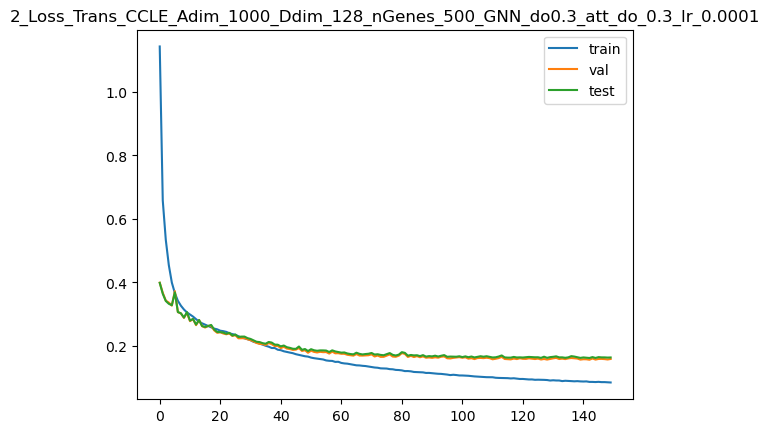

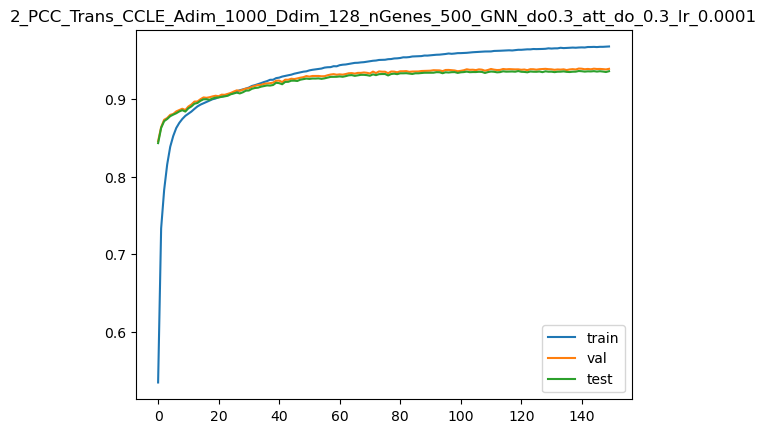

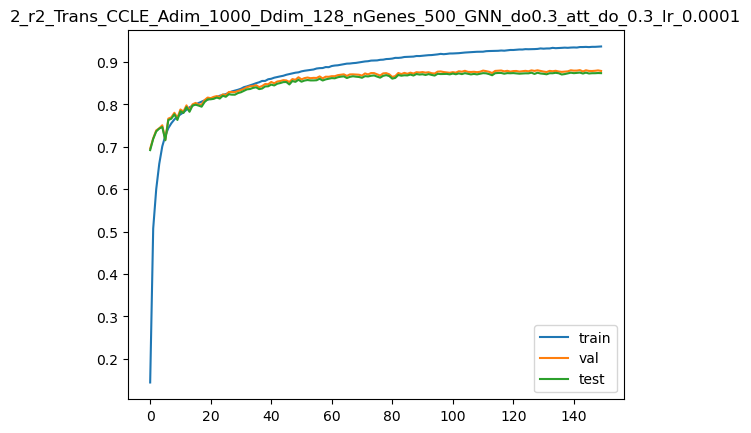

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10540856420993805
The overall Pearson's correlation is 0.9694.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07856256514787674
The overall Pearson's correlation is 0.9494.
Train avg_loss:  0.084356286
Train avg_pcc:  0.9679264893464963
Train r2:  0.9368777701066554


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15902525
Validation avg_pcc:  0.9388517409562761
Validation r2:  0.8787837106830877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16378105
Test avg_pcc:  0.9358104168044117
Test r2:  0.8735450918652461
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06380289793014526
The overall Pearson's correlation is 0.9683.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06354138255119324
The overall Pearson's correlation is 0.9789.
Train avg_loss:  0.08442936
Train avg_pcc:  0.9678985069952322
Train r2:  0.936823082894112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15814276
Validation avg_pcc:  0.9389043618013025
Validation r2:  0.8794563699624286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16225007
Test avg_pcc:  0.9361401144085638
Test r2:  0.8747271437047016
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09144165366888046
The overall Pearson's correlation is 0.9764.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07983112335205078
The overall Pearson's correlation is 0.9665.
Train avg_loss:  0.08309091
Train avg_pcc:  0.9684152557594106
Train r2:  0.9378246282634326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15885137
Validation avg_pcc:  0.9391681240152806
Validation r2:  0.8789162384036671


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16391775
Test avg_pcc:  0.9360014409155549
Test r2:  0.8734395512607347
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06435682624578476
The overall Pearson's correlation is 0.9783.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.04398292675614357
The overall Pearson's correlation is 0.9813.
Train avg_loss:  0.08318326
Train avg_pcc:  0.9683791547626437
Train r2:  0.9377555207238947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15729247
Validation avg_pcc:  0.938907315636248
Validation r2:  0.8801044990237243


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16297656
Test avg_pcc:  0.9355369344036792
Test r2:  0.8741662215763274
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06260336935520172
The overall Pearson's correlation is 0.9803.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08841901272535324
The overall Pearson's correlation is 0.9690.
Train avg_loss:  0.08286311
Train avg_pcc:  0.9685035076495554
Train r2:  0.9379950802387735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.158181
Validation avg_pcc:  0.9385703293449903
Validation r2:  0.8794272247015765


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16308974
Test avg_pcc:  0.9355833186029081
Test r2:  0.8740788508080134
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06393700838088989
The overall Pearson's correlation is 0.9716.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10763758420944214
The overall Pearson's correlation is 0.9625.
Train avg_loss:  0.082470156
Train avg_pcc:  0.9686553168437614
Train r2:  0.9382891196892498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15968236
Validation avg_pcc:  0.9388829272765987
Validation r2:  0.8782828258851599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16606858
Test avg_pcc:  0.9351356924034375
Test r2:  0.8717788871611456
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06297691911458969
The overall Pearson's correlation is 0.9813.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09501170367002487
The overall Pearson's correlation is 0.9575.
Train avg_loss:  0.08283819
Train avg_pcc:  0.9685130438636999
Train r2:  0.9380137269124592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15499371
Validation avg_pcc:  0.9396243419914161
Validation r2:  0.8818567058844419
Best Val r2  0.8818567058844419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16145484
Test avg_pcc:  0.9359898201848438
Test r2:  0.875341147013083
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.061437949538230896
The overall Pearson's correlation is 0.9751.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09238077700138092
The overall Pearson's correlation is 0.9533.
Train avg_loss:  0.08186935
Train avg_pcc:  0.968887531692791
Train r2:  0.9387386988981947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15861556
Validation avg_pcc:  0.9383822469815893
Validation r2:  0.8790959810408994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1627415
Test avg_pcc:  0.9356286817735766
Test r2:  0.8743477200637262
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0758756697177887
The overall Pearson's correlation is 0.9693.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10544495284557343
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.08301042
Train avg_pcc:  0.9684462614532051
Train r2:  0.937884846983985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15965986
Validation avg_pcc:  0.9389759960733206
Validation r2:  0.8782999700126208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1642801
Test avg_pcc:  0.9360288237678642
Test r2:  0.8731597682586545
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09322712570428848
The overall Pearson's correlation is 0.9582.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07822757959365845
The overall Pearson's correlation is 0.9663.
Train avg_loss:  0.081982516
Train avg_pcc:  0.9688436158270513
Train r2:  0.9386540122535031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1566235
Validation avg_pcc:  0.9393021386002879
Validation r2:  0.8806144157378317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16148275
Test avg_pcc:  0.936396985554005
Test r2:  0.8753195848483206
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1043841540813446
The overall Pearson's correlation is 0.9579.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14466026425361633
The overall Pearson's correlation is 0.9626.
Train avg_loss:  0.08208304
Train avg_pcc:  0.9688049117157479
Train r2:  0.9385787920939567


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15926145
Validation avg_pcc:  0.9384505467344831
Validation r2:  0.8786036524866995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16364336
Test avg_pcc:  0.9355689629163779
Test r2:  0.873651389528479
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08906948566436768
The overall Pearson's correlation is 0.9633.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09073995053768158
The overall Pearson's correlation is 0.9673.
Train avg_loss:  0.08123937
Train avg_pcc:  0.9691306965555267
Train r2:  0.939210087600746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1605493
Validation avg_pcc:  0.9385869812771745
Validation r2:  0.8776220104024296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1648294
Test avg_pcc:  0.9359022015834981
Test r2:  0.8727356567935456
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08008439093828201
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06674642115831375
The overall Pearson's correlation is 0.9758.
Train avg_loss:  0.08144242
Train avg_pcc:  0.9690520032962964
Train r2:  0.9390581489682924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16006969
Validation avg_pcc:  0.9389078409208942
Validation r2:  0.8779875735799608


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16407692
Test avg_pcc:  0.9361354518920397
Test r2:  0.8733166480806165
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09049135446548462
The overall Pearson's correlation is 0.9664.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0984991267323494
The overall Pearson's correlation is 0.9701.
Train avg_loss:  0.08093507
Train avg_pcc:  0.969247981929761
Train r2:  0.9394377944834048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15765288
Validation avg_pcc:  0.9391644126964394
Validation r2:  0.8798297771107818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1630909
Test avg_pcc:  0.9360284248098005
Test r2:  0.8740779513691002
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0982227623462677
The overall Pearson's correlation is 0.9727.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.058747999370098114
The overall Pearson's correlation is 0.9771.
Train avg_loss:  0.08005437
Train avg_pcc:  0.969588007295473
Train r2:  0.9400968017692253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16393867
Validation avg_pcc:  0.938815668246687
Validation r2:  0.8750384683722584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16825075
Test avg_pcc:  0.9358889703851958
Test r2:  0.8700940488993152
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0844581127166748
The overall Pearson's correlation is 0.9675.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08120168745517731
The overall Pearson's correlation is 0.9783.
Train avg_loss:  0.080141015
Train avg_pcc:  0.9695541845163589
Train r2:  0.9400319690029313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15763538
Validation avg_pcc:  0.9398674286195395
Validation r2:  0.8798431280300623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.163142
Test avg_pcc:  0.9365530710071273
Test r2:  0.8740385018084127
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10940510779619217
The overall Pearson's correlation is 0.9629.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08695872128009796
The overall Pearson's correlation is 0.9716.
Train avg_loss:  0.080251135
Train avg_pcc:  0.9695124408479033
Train r2:  0.9399495703829231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16059501
Validation avg_pcc:  0.9384336441112067
Validation r2:  0.8775871507181321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16490553
Test avg_pcc:  0.9357238889383137
Test r2:  0.8726768734771835
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08504458516836166
The overall Pearson's correlation is 0.9708.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08758141100406647
The overall Pearson's correlation is 0.9660.
Train avg_loss:  0.07923178
Train avg_pcc:  0.9699048544478849
Train r2:  0.9407123418226185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15361969
Validation avg_pcc:  0.9400899064507688
Validation r2:  0.8829040620160167
Best Val r2  0.8829040620160167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16010241
Test avg_pcc:  0.9365605454763266
Test r2:  0.8763853608346642
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.051354628056287766
The overall Pearson's correlation is 0.9817.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.053571753203868866
The overall Pearson's correlation is 0.9740.
Train avg_loss:  0.080293596
Train avg_pcc:  0.9694960380562402
Train r2:  0.9399178037898445


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16105735
Validation avg_pcc:  0.9385830990203224
Validation r2:  0.877234738540769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16587484
Test avg_pcc:  0.9356560073127805
Test r2:  0.8719284806680556
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06839758902788162
The overall Pearson's correlation is 0.9717.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07017889618873596
The overall Pearson's correlation is 0.9667.
Train avg_loss:  0.07942966
Train avg_pcc:  0.9698286216159765
Train r2:  0.9405642666175051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15464386
Validation avg_pcc:  0.9401699277613965
Validation r2:  0.8821233945947411


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16112795
Test avg_pcc:  0.936603916764933
Test r2:  0.8755935354889719
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08149711042642593
The overall Pearson's correlation is 0.9584.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07673898339271545
The overall Pearson's correlation is 0.9746.
Train avg_loss:  0.07897685
Train avg_pcc:  0.9700033256677132
Train r2:  0.9409030904897864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15844661
Validation avg_pcc:  0.9384790613250874
Validation r2:  0.8792247628978874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1631947
Test avg_pcc:  0.9355469720751096
Test r2:  0.8739977965019611
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08146330714225769
The overall Pearson's correlation is 0.9692.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08308950066566467
The overall Pearson's correlation is 0.9532.
Train avg_loss:  0.079322934
Train avg_pcc:  0.9698699021577487
Train r2:  0.9406441254523176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16066937
Validation avg_pcc:  0.9386829851159525
Validation r2:  0.8775304701182871


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16522062
Test avg_pcc:  0.9357341761885765
Test r2:  0.8724335958651538
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09478515386581421
The overall Pearson's correlation is 0.9722.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10139039903879166
The overall Pearson's correlation is 0.9493.
Train avg_loss:  0.079161406
Train avg_pcc:  0.9699323734094327
Train r2:  0.9407649918751401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15837541
Validation avg_pcc:  0.9390183983546921
Validation r2:  0.8792790316597302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16291095
Test avg_pcc:  0.9361412556100702
Test r2:  0.8742168755420415
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11689868569374084
The overall Pearson's correlation is 0.9465.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11228575557470322
The overall Pearson's correlation is 0.9578.
Train avg_loss:  0.078965805
Train avg_pcc:  0.97000798432593
Train r2:  0.9409113538613548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1579959
Validation avg_pcc:  0.9393374686942028
Validation r2:  0.8795683227875386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16387403
Test avg_pcc:  0.9357732682187121
Test r2:  0.8734733014938368
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07293117046356201
The overall Pearson's correlation is 0.9765.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1004369705915451
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.07824288
Train avg_pcc:  0.9702866424392961
Train r2:  0.9414523143127476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16291462
Validation avg_pcc:  0.9394706161549196
Validation r2:  0.8758190476877028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16820623
Test avg_pcc:  0.9362301484022657
Test r2:  0.8701284092768148
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07952682673931122
The overall Pearson's correlation is 0.9787.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.062449708580970764
The overall Pearson's correlation is 0.9702.
Train avg_loss:  0.07848574
Train avg_pcc:  0.9701923795760878
Train r2:  0.941270589659178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15469077
Validation avg_pcc:  0.9396350693384268
Validation r2:  0.8820876443033281


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16015466
Test avg_pcc:  0.9364439575939559
Test r2:  0.8763450185192325
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.043825872242450714
The overall Pearson's correlation is 0.9825.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08083472400903702
The overall Pearson's correlation is 0.9692.
Train avg_loss:  0.07844687
Train avg_pcc:  0.9702078340053625
Train r2:  0.9412996620289136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15770473
Validation avg_pcc:  0.939037060215971
Validation r2:  0.8797902606230024


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1621134
Test avg_pcc:  0.9362243893598584
Test r2:  0.8748326779651868
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07310053706169128
The overall Pearson's correlation is 0.9759.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08069416135549545
The overall Pearson's correlation is 0.9637.
Train avg_loss:  0.077958174
Train avg_pcc:  0.9703966867397976
Train r2:  0.94166534975347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15904987
Validation avg_pcc:  0.939635258939137
Validation r2:  0.8787649355260047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16556427
Test avg_pcc:  0.9358599925344303
Test r2:  0.872168271443208
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07963629066944122
The overall Pearson's correlation is 0.9668.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07008157670497894
The overall Pearson's correlation is 0.9759.
Train avg_loss:  0.077228025
Train avg_pcc:  0.9706775577721015
Train r2:  0.9422117103384109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15654935
Validation avg_pcc:  0.9397383314367377
Validation r2:  0.8806709455268721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16245152
Test avg_pcc:  0.9363449111843695
Test r2:  0.8745716064675852
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08319145441055298
The overall Pearson's correlation is 0.9676.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08212903141975403
The overall Pearson's correlation is 0.9776.
Train avg_loss:  0.07707275
Train avg_pcc:  0.9707376130329095
Train r2:  0.9423278985323257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1586356
Validation avg_pcc:  0.9393871347447311
Validation r2:  0.8790807019648281


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1627527
Test avg_pcc:  0.9367313070015135
Test r2:  0.8743390734786057
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08579783886671066
The overall Pearson's correlation is 0.9768.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0770401805639267
The overall Pearson's correlation is 0.9679.
Train avg_loss:  0.077240765
Train avg_pcc:  0.9706728490528871
Train r2:  0.9422021752770552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.157134
Validation avg_pcc:  0.9394731316912097
Validation r2:  0.8802253039200402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1618596
Test avg_pcc:  0.9366143694568416
Test r2:  0.8750286334490325
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06315328925848007
The overall Pearson's correlation is 0.9827.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0628620833158493
The overall Pearson's correlation is 0.9753.
Train avg_loss:  0.07732968
Train avg_pcc:  0.9706386303286438
Train r2:  0.9421356366780141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1567606
Validation avg_pcc:  0.9394419162342803
Validation r2:  0.8805099119672752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16167422
Test avg_pcc:  0.9365122537730537
Test r2:  0.875171769405716
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.051185399293899536
The overall Pearson's correlation is 0.9771.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07174066454172134
The overall Pearson's correlation is 0.9642.
Train avg_loss:  0.076856226
Train avg_pcc:  0.9708207071227133
Train r2:  0.9424899140814518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15621357
Validation avg_pcc:  0.9389381481683988
Validation r2:  0.8809268923078805


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16148263
Test avg_pcc:  0.9358300688029231
Test r2:  0.8753196886110484
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06440476328134537
The overall Pearson's correlation is 0.9693.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0652928501367569
The overall Pearson's correlation is 0.9703.
Train avg_loss:  0.076425366
Train avg_pcc:  0.9709869461398969
Train r2:  0.942812320144768


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15736027
Validation avg_pcc:  0.9382974937170854
Validation r2:  0.8800528237903791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16290204
Test avg_pcc:  0.9351106771183423
Test r2:  0.8742237790247809
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11064667999744415
The overall Pearson's correlation is 0.9579.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10351638495922089
The overall Pearson's correlation is 0.9542.
Train avg_loss:  0.07622127
Train avg_pcc:  0.9710657574650345
Train r2:  0.9429650476006518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16033937
Validation avg_pcc:  0.9388232973938101
Validation r2:  0.8777820163518465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16624458
Test avg_pcc:  0.9354454690860995
Test r2:  0.8716430042674216
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07567821443080902
The overall Pearson's correlation is 0.9718.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07928095757961273
The overall Pearson's correlation is 0.9777.
Train avg_loss:  0.07608762
Train avg_pcc:  0.9711169974438485
Train r2:  0.943065059349991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15702036
Validation avg_pcc:  0.9392231611800899
Validation r2:  0.880311916460764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1627649
Test avg_pcc:  0.9359748737487501
Test r2:  0.8743296488997069
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06869667023420334
The overall Pearson's correlation is 0.9785.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06874290108680725
The overall Pearson's correlation is 0.9707.
Train avg_loss:  0.07524196
Train avg_pcc:  0.9714428884531956
Train r2:  0.9436978425539285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15547562
Validation avg_pcc:  0.9392880691422151
Validation r2:  0.8814893955284564


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16097656
Test avg_pcc:  0.9360585953123477
Test r2:  0.8757104238003987
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.055360402911901474
The overall Pearson's correlation is 0.9849.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09462426602840424
The overall Pearson's correlation is 0.9722.
Train avg_loss:  0.07546329
Train avg_pcc:  0.97135733668341
Train r2:  0.9435322286293304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15519647
Validation avg_pcc:  0.9396709692010338
Validation r2:  0.8817021683819105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16136469
Test avg_pcc:  0.936221639549669
Test r2:  0.8754107409246074
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06805670261383057
The overall Pearson's correlation is 0.9801.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06394989043474197
The overall Pearson's correlation is 0.9771.
Train avg_loss:  0.07504743
Train avg_pcc:  0.9715181503023629
Train r2:  0.9438434021908308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15734914
Validation avg_pcc:  0.9400422509840013
Validation r2:  0.8800613107586444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1632988
Test avg_pcc:  0.9366310158507166
Test r2:  0.8739174398678531
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.055959492921829224
The overall Pearson's correlation is 0.9850.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11508221924304962
The overall Pearson's correlation is 0.9509.
Train avg_loss:  0.07586995
Train avg_pcc:  0.9712011646931198
Train r2:  0.9432279288219834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1585286
Validation avg_pcc:  0.9389279416131552
Validation r2:  0.8791622641043895


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16423206
Test avg_pcc:  0.9356340100391167
Test r2:  0.8731968634052496
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08062167465686798
The overall Pearson's correlation is 0.9706.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09953580796718597
The overall Pearson's correlation is 0.9683.
Train avg_loss:  0.07548744
Train avg_pcc:  0.9713482938109962
Train r2:  0.9435141553085431


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15458344
Validation avg_pcc:  0.9394706379937972
Validation r2:  0.8821694454452176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15998931
Test avg_pcc:  0.9363606087416707
Test r2:  0.8764726879129789
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08184786140918732
The overall Pearson's correlation is 0.9756.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09875115752220154
The overall Pearson's correlation is 0.9695.
Train avg_loss:  0.07498286
Train avg_pcc:  0.9715425236741521
Train r2:  0.9438917194123042


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15812087
Validation avg_pcc:  0.9395267860116411
Validation r2:  0.8794730542084732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16391908
Test avg_pcc:  0.9362327376875328
Test r2:  0.8734385240501266
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.060926370322704315
The overall Pearson's correlation is 0.9784.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0662403553724289
The overall Pearson's correlation is 0.9745.
Train avg_loss:  0.07508537
Train avg_pcc:  0.9715031049278906
Train r2:  0.9438150123722705


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15794279
Validation avg_pcc:  0.9391879300720413
Validation r2:  0.8796088034624975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16404529
Test avg_pcc:  0.935571488687217
Test r2:  0.8733410792136218
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0650375708937645
The overall Pearson's correlation is 0.9696.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.058412641286849976
The overall Pearson's correlation is 0.9727.
Train avg_loss:  0.07474837
Train avg_pcc:  0.971633138353218
Train r2:  0.9440671882002698


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15907313
Validation avg_pcc:  0.939104215256267
Validation r2:  0.8787472014755826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16393344
Test avg_pcc:  0.9360622929737069
Test r2:  0.8734274292063258
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10573483258485794
The overall Pearson's correlation is 0.9438.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09185603260993958
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.07462966
Train avg_pcc:  0.9716784334321165
Train r2:  0.9441560186805736


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1549459
Validation avg_pcc:  0.9404179103265256
Validation r2:  0.8818931704974743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1608602
Test avg_pcc:  0.9368740628239617
Test r2:  0.87580027284676
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0753219798207283
The overall Pearson's correlation is 0.9803.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07812869548797607
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.0744302
Train avg_pcc:  0.9717559406079215
Train r2:  0.9443052779257988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15654957
Validation avg_pcc:  0.9395542423172313
Validation r2:  0.8806707721661506


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16374685
Test avg_pcc:  0.9358651074874437
Test r2:  0.873571500275435
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07287353277206421
The overall Pearson's correlation is 0.9721.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0668836385011673
The overall Pearson's correlation is 0.9803.
Train avg_loss:  0.07288649
Train avg_pcc:  0.9723495228552295
Train r2:  0.945460398130002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15598445
Validation avg_pcc:  0.939468145084745
Validation r2:  0.8811015383288283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16222869
Test avg_pcc:  0.9359699472107809
Test r2:  0.8747436638285552
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.04365543648600578
The overall Pearson's correlation is 0.9714.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08184130489826202
The overall Pearson's correlation is 0.9599.
Train avg_loss:  0.07318731
Train avg_pcc:  0.9722337022018366
Train r2:  0.9452353039647302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15678976
Validation avg_pcc:  0.9392839429899213
Validation r2:  0.8804876943927739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16284776
Test avg_pcc:  0.9357772395534978
Test r2:  0.8742656922271149
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07089164853096008
The overall Pearson's correlation is 0.9750.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09069794416427612
The overall Pearson's correlation is 0.9720.
Train avg_loss:  0.07372049
Train avg_pcc:  0.972028536967657
Train r2:  0.9448363274446172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1545112
Validation avg_pcc:  0.9395882799718068
Validation r2:  0.8822245176234247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16064884
Test avg_pcc:  0.9361411625510744
Test r2:  0.875963461695543
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07382139563560486
The overall Pearson's correlation is 0.9600.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0782160758972168
The overall Pearson's correlation is 0.9758.
Train avg_loss:  0.07376487
Train avg_pcc:  0.9720114952309515
Train r2:  0.9448031229293755


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.15579756
Validation avg_pcc:  0.9396129137123689
Validation r2:  0.8812440062176164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1615143
Test avg_pcc:  0.9362248696162999
Test r2:  0.8752952428687668


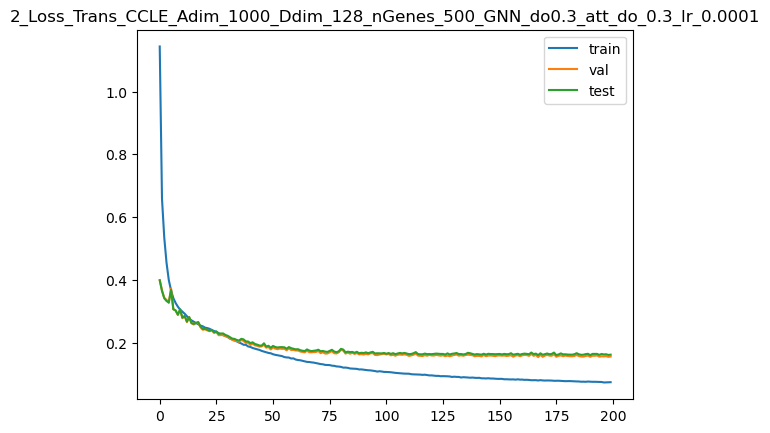

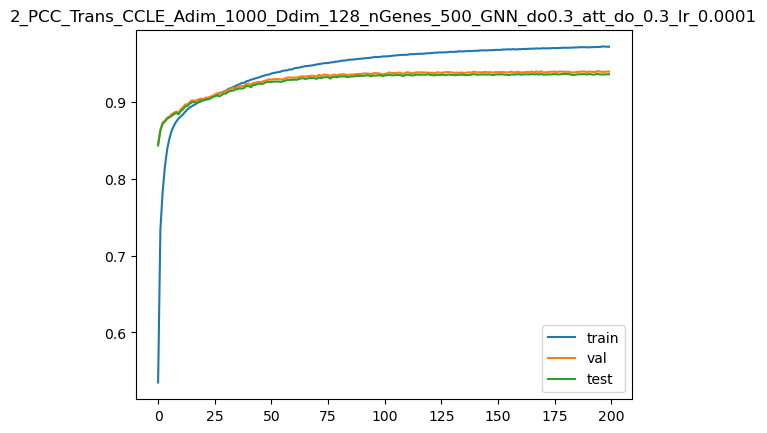

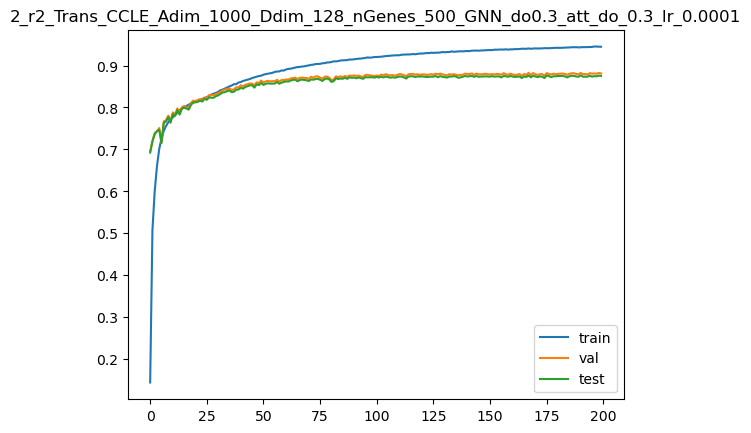

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16010241
Test avg_pcc:  0.9365605453555896
Test r2:  0.8763853604897796


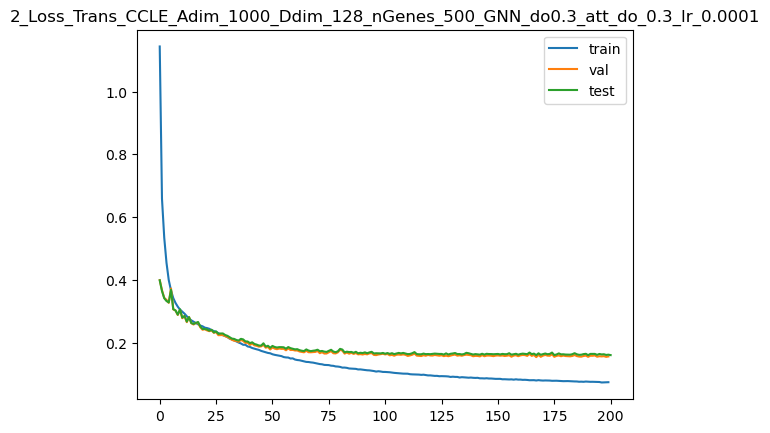

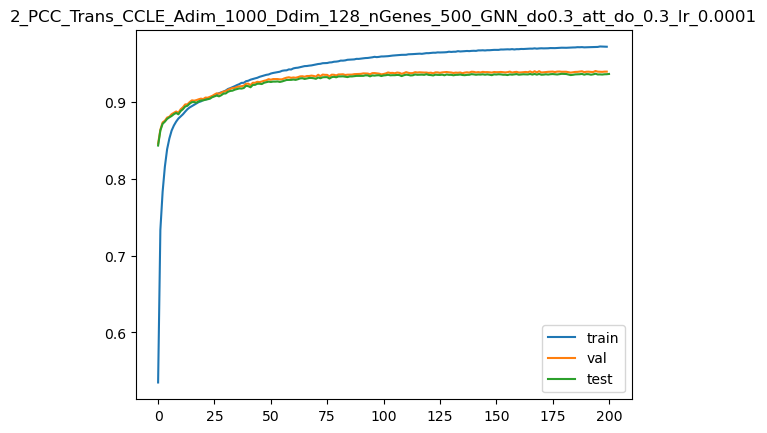

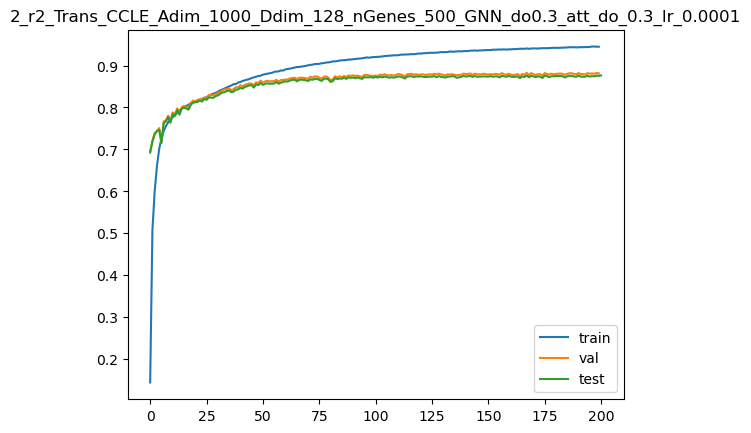

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  1.5141854286193848
The overall Pearson's correlation is 0.5067.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.9866428375244141
The overall Pearson's correlation is 0.5988.
Train avg_loss:  1.1933827
Train avg_pcc:  0.5117788717786125
Train r2:  0.09890309757030069


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.4601539
Validation avg_pcc:  0.8424792173533889
Validation r2:  0.6562650562858846
Best Val r2  0.6562650562858846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.45654172
Test avg_pcc:  0.8406048561119592
Test r2:  0.6551447849273792
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.7219509482383728
The overall Pearson's correlation is 0.7757.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.7145655155181885
The overall Pearson's correlation is 0.7439.
Train avg_loss:  0.6847461
Train avg_pcc:  0.7198585309635236
Train r2:  0.482963408788611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35707963
Validation avg_pcc:  0.868880695008565
Validation r2:  0.7332615077030413
Best Val r2  0.7332615077030413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3568474
Test avg_pcc:  0.867736889824143
Test r2:  0.7304502953629575
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.494728147983551
The overall Pearson's correlation is 0.7928.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5847878456115723
The overall Pearson's correlation is 0.8462.
Train avg_loss:  0.5500148
Train avg_pcc:  0.7748235574935558
Train r2:  0.5846960118840747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.34574932
Validation avg_pcc:  0.8749812149315841
Validation r2:  0.7417252429766712
Best Val r2  0.7417252429766712


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.34697753
Test avg_pcc:  0.8723282719333154
Test r2:  0.737905625133336
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.45033323764801025
The overall Pearson's correlation is 0.7832.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.39430809020996094
The overall Pearson's correlation is 0.8351.
Train avg_loss:  0.46512184
Train avg_pcc:  0.8094764635348798
Train r2:  0.6487968107655008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.37636063
Validation avg_pcc:  0.8806967398664401
Validation r2:  0.7188586157988935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.370866
Test avg_pcc:  0.8796041388048392
Test r2:  0.7198611575131146
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3788701891899109
The overall Pearson's correlation is 0.8387.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3732190728187561
The overall Pearson's correlation is 0.8670.
Train avg_loss:  0.40743786
Train avg_pcc:  0.8335576726868319
Train r2:  0.6923527140522122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.361334
Validation avg_pcc:  0.8859574498504461
Validation r2:  0.7300835099892417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35866323
Test avg_pcc:  0.8841050277589347
Test r2:  0.7290786684271027
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3357052206993103
The overall Pearson's correlation is 0.7995.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2603769898414612
The overall Pearson's correlation is 0.8844.
Train avg_loss:  0.36994156
Train avg_pcc:  0.8494042282113827
Train r2:  0.7206653410428497


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35476518
Validation avg_pcc:  0.8863523904932307
Validation r2:  0.7349904212704398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.35097793
Test avg_pcc:  0.8847846395788105
Test r2:  0.7348839005373751
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.35289204120635986
The overall Pearson's correlation is 0.8755.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5038455724716187
The overall Pearson's correlation is 0.8014.
Train avg_loss:  0.3433101
Train avg_pcc:  0.8608559493941672
Train r2:  0.7407741500549663


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33624008
Validation avg_pcc:  0.8874403495176397
Validation r2:  0.7488286796360762
Best Val r2  0.7488286796360762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32998446
Test avg_pcc:  0.8871459982536025
Test r2:  0.7507415900996802
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.36749470233917236
The overall Pearson's correlation is 0.8638.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3065558671951294
The overall Pearson's correlation is 0.8415.
Train avg_loss:  0.327238
Train avg_pcc:  0.8677638482501899
Train r2:  0.7529098340679587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30896854
Validation avg_pcc:  0.8914230758406965
Validation r2:  0.7692004857197893
Best Val r2  0.7692004857197893


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30730304
Test avg_pcc:  0.8902337317982325
Test r2:  0.7678743179946386
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.28356558084487915
The overall Pearson's correlation is 0.8919.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.41970258951187134
The overall Pearson's correlation is 0.8784.
Train avg_loss:  0.3176417
Train avg_pcc:  0.8718981694068356
Train r2:  0.7601558087611415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31488657
Validation avg_pcc:  0.8901269676563598
Validation r2:  0.7647797351354017


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30989817
Test avg_pcc:  0.8896552292326252
Test r2:  0.7659140516475474
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25847363471984863
The overall Pearson's correlation is 0.8945.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.38893353939056396
The overall Pearson's correlation is 0.8327.
Train avg_loss:  0.3071876
Train avg_pcc:  0.8764028591358988
Train r2:  0.7680494512659342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28962067
Validation avg_pcc:  0.8931330783171573
Validation r2:  0.7836533484781331
Best Val r2  0.7836533484781331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28613672
Test avg_pcc:  0.8925308542922313
Test r2:  0.7838625959553335
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2747039198875427
The overall Pearson's correlation is 0.9027.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2227557897567749
The overall Pearson's correlation is 0.9164.
Train avg_loss:  0.30045965
Train avg_pcc:  0.879290721710053
Train r2:  0.7731295709843929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2826915
Validation avg_pcc:  0.8958731726325591
Validation r2:  0.7888294422832043
Best Val r2  0.7888294422832043


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2790177
Test avg_pcc:  0.8953134696704471
Test r2:  0.7892400816226203
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.34734806418418884
The overall Pearson's correlation is 0.8771.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1986074596643448
The overall Pearson's correlation is 0.9430.
Train avg_loss:  0.29104453
Train avg_pcc:  0.8833198444843416
Train r2:  0.7802387270625727


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33229515
Validation avg_pcc:  0.8983049239697283
Validation r2:  0.7517755106150195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3293509
Test avg_pcc:  0.8966160858108844
Test r2:  0.7512201779436473
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23670423030853271
The overall Pearson's correlation is 0.8599.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3127714991569519
The overall Pearson's correlation is 0.8548.
Train avg_loss:  0.28782365
Train avg_pcc:  0.8846986930178591
Train r2:  0.7826707328624658


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29106846
Validation avg_pcc:  0.8976573494657818
Validation r2:  0.7825718692478455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.28565663
Test avg_pcc:  0.8977957197926891
Test r2:  0.7842252579958965
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19191382825374603
The overall Pearson's correlation is 0.9338.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2240288257598877
The overall Pearson's correlation is 0.9018.
Train avg_loss:  0.28041002
Train avg_pcc:  0.8878582389760217
Train r2:  0.7882685892984344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26767498
Validation avg_pcc:  0.9019746394180164
Validation r2:  0.8000467937155953
Best Val r2  0.8000467937155953


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26590487
Test avg_pcc:  0.9010281096733949
Test r2:  0.7991450149002584
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2551237940788269
The overall Pearson's correlation is 0.9207.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20656028389930725
The overall Pearson's correlation is 0.9096.
Train avg_loss:  0.2734633
Train avg_pcc:  0.89080447934554
Train r2:  0.793513923034073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2515384
Validation avg_pcc:  0.9014363774238332
Validation r2:  0.8121007958417711
Best Val r2  0.8121007958417711


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2499493
Test avg_pcc:  0.9008291465522893
Test r2:  0.8111972654868567
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2950649559497833
The overall Pearson's correlation is 0.8482.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2837614417076111
The overall Pearson's correlation is 0.8813.
Train avg_loss:  0.26876664
Train avg_pcc:  0.8927909765953609
Train r2:  0.797060266783065


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27402037
Validation avg_pcc:  0.9038160122969378
Validation r2:  0.7953067892935384


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2720538
Test avg_pcc:  0.9029278410725319
Test r2:  0.794500329786781
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22062622010707855
The overall Pearson's correlation is 0.9189.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19154784083366394
The overall Pearson's correlation is 0.9321.
Train avg_loss:  0.264275
Train avg_pcc:  0.8946899068689572
Train r2:  0.8004517928518448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24211809
Validation avg_pcc:  0.9055129642658379
Validation r2:  0.8191377882240933
Best Val r2  0.8191377882240933


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2400343
Test avg_pcc:  0.9051080416104091
Test r2:  0.8186867347885733
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3225247263908386
The overall Pearson's correlation is 0.8939.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.35992956161499023
The overall Pearson's correlation is 0.8187.
Train avg_loss:  0.26262546
Train avg_pcc:  0.8953843124591073
Train r2:  0.8016973614278422


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24538976
Validation avg_pcc:  0.9069546357260337
Validation r2:  0.816693846331659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24342282
Test avg_pcc:  0.906087596964385
Test r2:  0.8161271533294487
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.26124751567840576
The overall Pearson's correlation is 0.9200.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26158541440963745
The overall Pearson's correlation is 0.8923.
Train avg_loss:  0.25822166
Train avg_pcc:  0.8972398768481663
Train r2:  0.8050225308164974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2488107
Validation avg_pcc:  0.9060754112881545
Validation r2:  0.81413840654073


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24834599
Test avg_pcc:  0.9047248304552571
Test r2:  0.8124083733860402
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24811971187591553
The overall Pearson's correlation is 0.9290.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24775640666484833
The overall Pearson's correlation is 0.8837.
Train avg_loss:  0.25607672
Train avg_pcc:  0.8981423173676236
Train r2:  0.8066421365361525


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24955446
Validation avg_pcc:  0.9061995594666888
Validation r2:  0.8135828321041719


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2474326
Test avg_pcc:  0.9056156090335171
Test r2:  0.8130982929488
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.28302907943725586
The overall Pearson's correlation is 0.8956.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.46134713292121887
The overall Pearson's correlation is 0.8618.
Train avg_loss:  0.25371048
Train avg_pcc:  0.8991360005393976
Train r2:  0.8084288411711569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24051331
Validation avg_pcc:  0.9079852290118514
Validation r2:  0.8203365658727233
Best Val r2  0.8203365658727233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24258281
Test avg_pcc:  0.9061361198669002
Test r2:  0.8167616503484215
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2416405975818634
The overall Pearson's correlation is 0.9309.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1870807409286499
The overall Pearson's correlation is 0.9131.
Train avg_loss:  0.25013518
Train avg_pcc:  0.9006343794886931
Train r2:  0.8111284927617545


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24733925
Validation avg_pcc:  0.9079712904789182
Validation r2:  0.8152375829083326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24728946
Test avg_pcc:  0.9066138221164817
Test r2:  0.8132064237006609
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3498914837837219
The overall Pearson's correlation is 0.8589.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2674074172973633
The overall Pearson's correlation is 0.9129.
Train avg_loss:  0.24680948
Train avg_pcc:  0.9020283279428982
Train r2:  0.8136396233532457


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23633897
Validation avg_pcc:  0.9094847718932362
Validation r2:  0.8234547941541357
Best Val r2  0.8234547941541357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23539753
Test avg_pcc:  0.9086396798237637
Test r2:  0.8221891567276093
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19299936294555664
The overall Pearson's correlation is 0.9083.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.29936498403549194
The overall Pearson's correlation is 0.9076.
Train avg_loss:  0.2431627
Train avg_pcc:  0.903551506806475
Train r2:  0.8163932205027546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2333506
Validation avg_pcc:  0.9102713530159106
Validation r2:  0.8256870975393003
Best Val r2  0.8256870975393003


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23247108
Test avg_pcc:  0.9093983934966946
Test r2:  0.8243997025485912
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17468683421611786
The overall Pearson's correlation is 0.9685.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21484380960464478
The overall Pearson's correlation is 0.9016.
Train avg_loss:  0.24027781
Train avg_pcc:  0.904755947230778
Train r2:  0.81857154133906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23191214
Validation avg_pcc:  0.9117198416959098
Validation r2:  0.8267616314834835
Best Val r2  0.8267616314834835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23073645
Test avg_pcc:  0.9109305551413929
Test r2:  0.8257099846567487
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18643726408481598
The overall Pearson's correlation is 0.9331.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15690511465072632
The overall Pearson's correlation is 0.9308.
Train avg_loss:  0.236949
Train avg_pcc:  0.906145139118405
Train r2:  0.8210850725384885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.228372
Validation avg_pcc:  0.912833567175913
Validation r2:  0.8294061264131315
Best Val r2  0.8294061264131315


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22660734
Test avg_pcc:  0.9123733776955842
Test r2:  0.828828951762587
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1955532431602478
The overall Pearson's correlation is 0.9141.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.35867971181869507
The overall Pearson's correlation is 0.8982.
Train avg_loss:  0.23266475
Train avg_pcc:  0.9079266296609556
Train r2:  0.8243200177936477


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23831585
Validation avg_pcc:  0.912591031707997
Validation r2:  0.8219780551198939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23346402
Test avg_pcc:  0.9128901661144748
Test r2:  0.8236496635611877
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19179505109786987
The overall Pearson's correlation is 0.9101.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15230144560337067
The overall Pearson's correlation is 0.9471.
Train avg_loss:  0.22838187
Train avg_pcc:  0.9097073920321016
Train r2:  0.8275539170950275


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22418419
Validation avg_pcc:  0.9145449291469484
Validation r2:  0.8325344113931487
Best Val r2  0.8325344113931487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22300765
Test avg_pcc:  0.9139909901612772
Test r2:  0.8315480313265429
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19281277060508728
The overall Pearson's correlation is 0.9242.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21657846868038177
The overall Pearson's correlation is 0.9000.
Train avg_loss:  0.22479776
Train avg_pcc:  0.9111925638550723
Train r2:  0.830260172990266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2256564
Validation avg_pcc:  0.9129665189640807
Validation r2:  0.8314346619861519


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22409964
Test avg_pcc:  0.9125551469599383
Test r2:  0.8307231888665108
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31456905603408813
The overall Pearson's correlation is 0.8968.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2390456199645996
The overall Pearson's correlation is 0.9225.
Train avg_loss:  0.22052413
Train avg_pcc:  0.9129601218850588
Train r2:  0.8334871203688192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21241222
Validation avg_pcc:  0.9174516125779204
Validation r2:  0.8413280655270163
Best Val r2  0.8413280655270163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21100906
Test avg_pcc:  0.917036734170713
Test r2:  0.8406113550143128
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2870236933231354
The overall Pearson's correlation is 0.8965.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2222961187362671
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.2180284
Train avg_pcc:  0.913993154553375
Train r2:  0.8353715831552635


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21610492
Validation avg_pcc:  0.9165621815151113
Validation r2:  0.8385696168891014


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21447262
Test avg_pcc:  0.9161608283530441
Test r2:  0.8379950938469296
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20610377192497253
The overall Pearson's correlation is 0.9338.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21247568726539612
The overall Pearson's correlation is 0.9294.
Train avg_loss:  0.21437886
Train avg_pcc:  0.9154987463552821
Train r2:  0.8381272722426074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20631035
Validation avg_pcc:  0.9198031340051818
Validation r2:  0.8458861643121027
Best Val r2  0.8458861643121027


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20633546
Test avg_pcc:  0.9188932109686021
Test r2:  0.8441416230988008
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17688168585300446
The overall Pearson's correlation is 0.9316.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17142938077449799
The overall Pearson's correlation is 0.9532.
Train avg_loss:  0.20971115
Train avg_pcc:  0.9174213533049049
Train r2:  0.8416517500007752


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20872357
Validation avg_pcc:  0.9192427227368355
Validation r2:  0.8440835014129382


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20783263
Test avg_pcc:  0.918631423965261
Test r2:  0.843010687441601
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23878750205039978
The overall Pearson's correlation is 0.9305.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.29354017972946167
The overall Pearson's correlation is 0.8589.
Train avg_loss:  0.20689142
Train avg_pcc:  0.918580959404106
Train r2:  0.8437808829229212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2054636
Validation avg_pcc:  0.9206600375478163
Validation r2:  0.8465186841517172
Best Val r2  0.8465186841517172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20335378
Test avg_pcc:  0.9205581788618347
Test r2:  0.8463938720602305
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16787223517894745
The overall Pearson's correlation is 0.9211.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1759740710258484
The overall Pearson's correlation is 0.9180.
Train avg_loss:  0.20387389
Train avg_pcc:  0.9198206013004164
Train r2:  0.846059353213581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21044922
Validation avg_pcc:  0.9193340099883022
Validation r2:  0.8427944412757212


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20971648
Test avg_pcc:  0.9185989920716431
Test r2:  0.8415876924353252
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2404089868068695
The overall Pearson's correlation is 0.9029.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17092113196849823
The overall Pearson's correlation is 0.9429.
Train avg_loss:  0.20131315
Train avg_pcc:  0.9208713260214685
Train r2:  0.8479928877601779


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20084019
Validation avg_pcc:  0.9225088069729263
Validation r2:  0.849972374502864
Best Val r2  0.849972374502864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1985796
Test avg_pcc:  0.9224481330675027
Test r2:  0.8500001121908058
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18518990278244019
The overall Pearson's correlation is 0.9405.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16347521543502808
The overall Pearson's correlation is 0.9283.
Train avg_loss:  0.19794184
Train avg_pcc:  0.9222508629238562
Train r2:  0.8505385045547306


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19820024
Validation avg_pcc:  0.9237105615553047
Validation r2:  0.8519444170490476
Best Val r2  0.8519444170490476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19730379
Test avg_pcc:  0.9230774970926865
Test r2:  0.8509638121122728
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18004153668880463
The overall Pearson's correlation is 0.9293.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21974319219589233
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.19453861
Train avg_pcc:  0.92364334500896
Train r2:  0.8531082006927311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20784304
Validation avg_pcc:  0.9241764809246282
Validation r2:  0.8447412539821094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20841317
Test avg_pcc:  0.9228533862693877
Test r2:  0.8425721829006416
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14808471500873566
The overall Pearson's correlation is 0.9551.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18377643823623657
The overall Pearson's correlation is 0.9455.
Train avg_loss:  0.19195169
Train avg_pcc:  0.9247010504208869
Train r2:  0.8550615387796465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21027187
Validation avg_pcc:  0.9235961625638112
Validation r2:  0.8429269229281526


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2045305
Test avg_pcc:  0.9246209248890529
Test r2:  0.8455049970200101
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17389404773712158
The overall Pearson's correlation is 0.9397.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15657472610473633
The overall Pearson's correlation is 0.9373.
Train avg_loss:  0.18970792
Train avg_pcc:  0.9256158008174481
Train r2:  0.856755749309511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19712727
Validation avg_pcc:  0.9235129371820945
Validation r2:  0.8527459329413749
Best Val r2  0.8527459329413749


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19282596
Test avg_pcc:  0.9243645318345706
Test r2:  0.8543462025650028
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15772978961467743
The overall Pearson's correlation is 0.9366.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16081494092941284
The overall Pearson's correlation is 0.9177.
Train avg_loss:  0.18717824
Train avg_pcc:  0.926645631307859
Train r2:  0.8586658607346208


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21266752
Validation avg_pcc:  0.923474026474622
Validation r2:  0.8411373590374114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20860827
Test avg_pcc:  0.9237415437759692
Test r2:  0.8424248215437697
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1456487774848938
The overall Pearson's correlation is 0.9500.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17935001850128174
The overall Pearson's correlation is 0.9393.
Train avg_loss:  0.18362658
Train avg_pcc:  0.928092441254739
Train r2:  0.8613476330234053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1951143
Validation avg_pcc:  0.9242984786026979
Validation r2:  0.8542496228086681
Best Val r2  0.8542496228086681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19235133
Test avg_pcc:  0.9245134439222011
Test r2:  0.8547047159665879
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2663966417312622
The overall Pearson's correlation is 0.8893.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20390437543392181
The overall Pearson's correlation is 0.9202.
Train avg_loss:  0.18281414
Train avg_pcc:  0.9284238707756213
Train r2:  0.8619611020073649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19341156
Validation avg_pcc:  0.9249731837501208
Validation r2:  0.8555215660718822
Best Val r2  0.8555215660718822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18912615
Test avg_pcc:  0.9258438687683941
Test r2:  0.8571409037697686
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11621322482824326
The overall Pearson's correlation is 0.9522.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12619498372077942
The overall Pearson's correlation is 0.9534.
Train avg_loss:  0.17913099
Train avg_pcc:  0.929918438193936
Train r2:  0.8647421747099957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19299985
Validation avg_pcc:  0.9252171606000522
Validation r2:  0.8558290966517786
Best Val r2  0.8558290966517786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19023417
Test avg_pcc:  0.9254847027347302
Test r2:  0.8563039411494251
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22294515371322632
The overall Pearson's correlation is 0.9085.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10119754821062088
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.17686166
Train avg_pcc:  0.930840760507515
Train r2:  0.8664556770687266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19021694
Validation avg_pcc:  0.9262720275142025
Validation r2:  0.8579079346151222
Best Val r2  0.8579079346151222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18568361
Test avg_pcc:  0.9272413609222449
Test r2:  0.8597412670049445
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2327497899532318
The overall Pearson's correlation is 0.8505.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23171201348304749
The overall Pearson's correlation is 0.8968.
Train avg_loss:  0.1755073
Train avg_pcc:  0.9313886022300544
Train r2:  0.8674783202681398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18896775
Validation avg_pcc:  0.9273798188344838
Validation r2:  0.858841093186015
Best Val r2  0.858841093186015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18701442
Test avg_pcc:  0.9271895421487547
Test r2:  0.858736033074701
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1468549370765686
The overall Pearson's correlation is 0.9583.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.276273638010025
The overall Pearson's correlation is 0.8827.
Train avg_loss:  0.17298685
Train avg_pcc:  0.9324098358968428
Train r2:  0.8693814659701455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19038433
Validation avg_pcc:  0.9269240633815118
Validation r2:  0.8577828987741736


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18560132
Test avg_pcc:  0.9278930507807863
Test r2:  0.8598034132119855
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2516780197620392
The overall Pearson's correlation is 0.9033.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30572688579559326
The overall Pearson's correlation is 0.8689.
Train avg_loss:  0.17030084
Train avg_pcc:  0.9334981085040165
Train r2:  0.8714096092411214


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19362074
Validation avg_pcc:  0.9267553230347849
Validation r2:  0.855365291804583


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18788652
Test avg_pcc:  0.928145503783983
Test r2:  0.8580772696635921
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20710663497447968
The overall Pearson's correlation is 0.9056.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18300463259220123
The overall Pearson's correlation is 0.9538.
Train avg_loss:  0.16756383
Train avg_pcc:  0.9346030820636679
Train r2:  0.8734762760774701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1868527
Validation avg_pcc:  0.9276349064225263
Validation r2:  0.8604210465202906
Best Val r2  0.8604210465202906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18377815
Test avg_pcc:  0.9280348575233136
Test r2:  0.8611805813085872
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1475788950920105
The overall Pearson's correlation is 0.9325.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11936495453119278
The overall Pearson's correlation is 0.9646.
Train avg_loss:  0.16584516
Train avg_pcc:  0.9352965882833081
Train r2:  0.8747739993781088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18710628
Validation avg_pcc:  0.9286787435649125
Validation r2:  0.8602316065722235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1849774
Test avg_pcc:  0.9286089526262782
Test r2:  0.8602747342433129


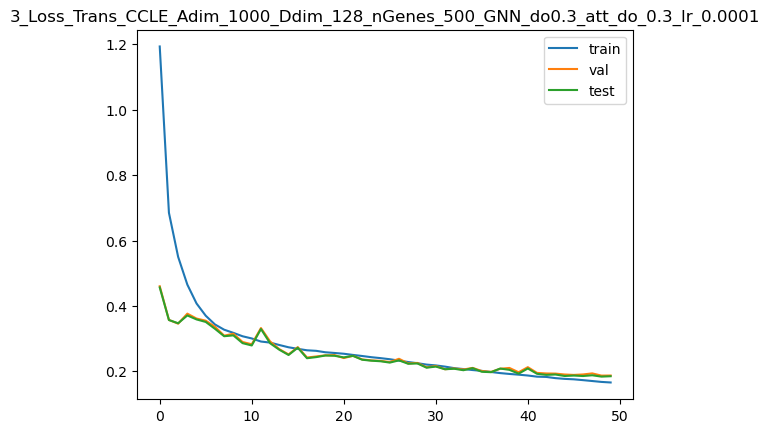

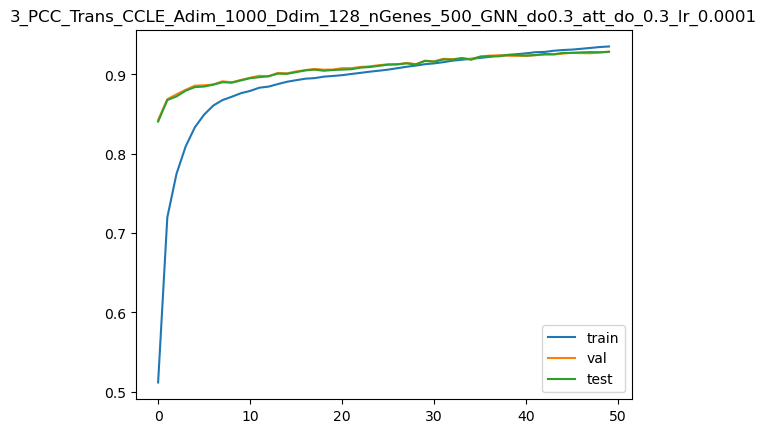

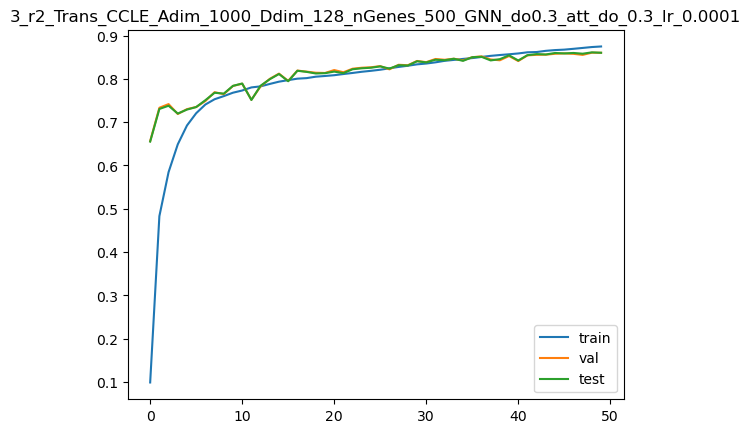

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19722339510917664
The overall Pearson's correlation is 0.9390.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15177008509635925
The overall Pearson's correlation is 0.9474.
Train avg_loss:  0.16379695
Train avg_pcc:  0.9361246562671184
Train r2:  0.8763205681929326


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18533595
Validation avg_pcc:  0.9290119323144821
Validation r2:  0.8615540328599914
Best Val r2  0.8615540328599914


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18116562
Test avg_pcc:  0.9297512688534418
Test r2:  0.8631540136966495
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1838645040988922
The overall Pearson's correlation is 0.9072.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24230676889419556
The overall Pearson's correlation is 0.9325.
Train avg_loss:  0.16168024
Train avg_pcc:  0.9369767302717437
Train r2:  0.877918836910266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19788536
Validation avg_pcc:  0.9267120887735205
Validation r2:  0.8521796390904262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19076246
Test avg_pcc:  0.9284274786101192
Test r2:  0.8559049070760806
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13142436742782593
The overall Pearson's correlation is 0.9336.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0914214551448822
The overall Pearson's correlation is 0.9708.
Train avg_loss:  0.1609861
Train avg_pcc:  0.9372570429486085
Train r2:  0.8784429588724401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19886287
Validation avg_pcc:  0.9285300274222392
Validation r2:  0.8514494528413995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19446939
Test avg_pcc:  0.9292156417949001
Test r2:  0.8531048066141675
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12474619597196579
The overall Pearson's correlation is 0.9658.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20514485239982605
The overall Pearson's correlation is 0.9140.
Train avg_loss:  0.15931082
Train avg_pcc:  0.9379314788003962
Train r2:  0.879707921228845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18526027
Validation avg_pcc:  0.9291096535084648
Validation r2:  0.8616105750713814
Best Val r2  0.8616105750713814


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17964028
Test avg_pcc:  0.9304533649594364
Test r2:  0.8643061765440726
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24524018168449402
The overall Pearson's correlation is 0.9425.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1683182567358017
The overall Pearson's correlation is 0.9438.
Train avg_loss:  0.15714161
Train avg_pcc:  0.938804463088716
Train r2:  0.8813458446810012


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18197162
Validation avg_pcc:  0.930460397532844
Validation r2:  0.8640671978954473
Best Val r2  0.8640671978954473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17992036
Test avg_pcc:  0.9305429670231186
Test r2:  0.8640946213156507
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14043167233467102
The overall Pearson's correlation is 0.9427.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11968912929296494
The overall Pearson's correlation is 0.9709.
Train avg_loss:  0.1560622
Train avg_pcc:  0.9392367745214925
Train r2:  0.8821608859866041


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17915751
Validation avg_pcc:  0.9309373697957743
Validation r2:  0.8661693316135147
Best Val r2  0.8661693316135147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17435779
Test avg_pcc:  0.9320855002266476
Test r2:  0.8682964048700214
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20267479121685028
The overall Pearson's correlation is 0.9491.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09449904412031174
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.15395765
Train avg_pcc:  0.940083684387729
Train r2:  0.8837499797665445


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18818864
Validation avg_pcc:  0.9290602545478578
Validation r2:  0.8594230769153047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.183107
Test avg_pcc:  0.9301190063772824
Test r2:  0.861687538850219
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18579798936843872
The overall Pearson's correlation is 0.9147.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12574021518230438
The overall Pearson's correlation is 0.9688.
Train avg_loss:  0.15231234
Train avg_pcc:  0.940743896968321
Train r2:  0.8849923221931144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19189042
Validation avg_pcc:  0.9289912616652145
Validation r2:  0.8566578460144085


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18549456
Test avg_pcc:  0.9305375248969887
Test r2:  0.8598840724795154
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18712720274925232
The overall Pearson's correlation is 0.9321.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14382490515708923
The overall Pearson's correlation is 0.9201.
Train avg_loss:  0.15126969
Train avg_pcc:  0.9411638699512904
Train r2:  0.8857796094676155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18892494
Validation avg_pcc:  0.9297567825855463
Validation r2:  0.8588730830465792


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1835121
Test avg_pcc:  0.9308247332700184
Test r2:  0.8613815506672788
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16300983726978302
The overall Pearson's correlation is 0.9448.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14838187396526337
The overall Pearson's correlation is 0.9589.
Train avg_loss:  0.1503612
Train avg_pcc:  0.9415262090016362
Train r2:  0.8864655981857642


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18197042
Validation avg_pcc:  0.9308366487122374
Validation r2:  0.8640680945454058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17776582
Test avg_pcc:  0.9315911716846278
Test r2:  0.8657220867936728
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18884572386741638
The overall Pearson's correlation is 0.9196.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1406724900007248
The overall Pearson's correlation is 0.9646.
Train avg_loss:  0.14763223
Train avg_pcc:  0.9426203019451105
Train r2:  0.8885261767842559


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18053916
Validation avg_pcc:  0.9312910233613305
Validation r2:  0.865137239212552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17777124
Test avg_pcc:  0.9315290552738895
Test r2:  0.8657179920291207
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1262504756450653
The overall Pearson's correlation is 0.9625.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22995927929878235
The overall Pearson's correlation is 0.9332.
Train avg_loss:  0.14606859
Train avg_pcc:  0.9432462993381193
Train r2:  0.889706851878892


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18062067
Validation avg_pcc:  0.9315143325224392
Validation r2:  0.865076361310305


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17560849
Test avg_pcc:  0.9324978981543376
Test r2:  0.8673516632616798
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12532156705856323
The overall Pearson's correlation is 0.9572.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1152099147439003
The overall Pearson's correlation is 0.9359.
Train avg_loss:  0.1443486
Train avg_pcc:  0.9439339047343348
Train r2:  0.8910055744702184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18074174
Validation avg_pcc:  0.9312575534132421
Validation r2:  0.8649859178053945


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17579721
Test avg_pcc:  0.9322977174349337
Test r2:  0.867209105777298
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1119038462638855
The overall Pearson's correlation is 0.9531.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10667398571968079
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.14398724
Train avg_pcc:  0.9440802733473223
Train r2:  0.8912784360915874


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18085223
Validation avg_pcc:  0.9304542027591263
Validation r2:  0.864903383925408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17465012
Test avg_pcc:  0.9320779087736584
Test r2:  0.8680755778462371
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1343473196029663
The overall Pearson's correlation is 0.9404.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08566451072692871
The overall Pearson's correlation is 0.9749.
Train avg_loss:  0.14253877
Train avg_pcc:  0.9446573117489491
Train r2:  0.8923721250054337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17819418
Validation avg_pcc:  0.9316721415342075
Validation r2:  0.8668889486604586
Best Val r2  0.8668889486604586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17313774
Test avg_pcc:  0.9328434439813296
Test r2:  0.8692179746561345
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1384848654270172
The overall Pearson's correlation is 0.9420.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09383052587509155
The overall Pearson's correlation is 0.9616.
Train avg_loss:  0.14005452
Train avg_pcc:  0.9456505632770711
Train r2:  0.8942479287830076


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1784673
Validation avg_pcc:  0.9319429493897815
Validation r2:  0.8666849185265941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17601682
Test avg_pcc:  0.9320320299627973
Test r2:  0.8670432146822059
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10821681469678879
The overall Pearson's correlation is 0.9572.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0971338301897049
The overall Pearson's correlation is 0.9736.
Train avg_loss:  0.13973479
Train avg_pcc:  0.9457771343600754
Train r2:  0.8944893482542298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18243358
Validation avg_pcc:  0.9318335504633092
Validation r2:  0.863722122460882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17809242
Test avg_pcc:  0.9325774148997648
Test r2:  0.8654753793642548
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1268068552017212
The overall Pearson's correlation is 0.9689.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10689756274223328
The overall Pearson's correlation is 0.9236.
Train avg_loss:  0.13832383
Train avg_pcc:  0.9463404888567462
Train r2:  0.8955547400198282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17348774
Validation avg_pcc:  0.9338288184154457
Validation r2:  0.8704046687543247
Best Val r2  0.8704046687543247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1715913
Test avg_pcc:  0.9336869990556411
Test r2:  0.8703861048591307
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09789805114269257
The overall Pearson's correlation is 0.9683.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10517609864473343
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.13763534
Train avg_pcc:  0.9466153153361888
Train r2:  0.8960746017771193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17615326
Validation avg_pcc:  0.9324276608859644
Validation r2:  0.8684135137339757


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17183891
Test avg_pcc:  0.9333029331615481
Test r2:  0.870199060116804
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.156532883644104
The overall Pearson's correlation is 0.9544.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15902353823184967
The overall Pearson's correlation is 0.9251.
Train avg_loss:  0.13519971
Train avg_pcc:  0.9475862874766416
Train r2:  0.8979136903708569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17547132
Validation avg_pcc:  0.9330564875681308
Validation r2:  0.8689229270076699


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1735355
Test avg_pcc:  0.9330685850388343
Test r2:  0.868917529546232
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15278437733650208
The overall Pearson's correlation is 0.9468.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1282060146331787
The overall Pearson's correlation is 0.9319.
Train avg_loss:  0.13558131
Train avg_pcc:  0.9474338489370436
Train r2:  0.8976255505227217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17392506
Validation avg_pcc:  0.9329849530621381
Validation r2:  0.8700779902249737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16998076
Test avg_pcc:  0.9337388837255629
Test r2:  0.8716026475273975
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14118018746376038
The overall Pearson's correlation is 0.9126.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18132975697517395
The overall Pearson's correlation is 0.9195.
Train avg_loss:  0.133718
Train avg_pcc:  0.9481778908078138
Train r2:  0.89903250628625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17590193
Validation avg_pcc:  0.9337374602816495
Validation r2:  0.8686012624034741


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17275095
Test avg_pcc:  0.9341153175923835
Test r2:  0.8695101329938983
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18725064396858215
The overall Pearson's correlation is 0.9334.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12256117165088654
The overall Pearson's correlation is 0.9375.
Train avg_loss:  0.13139777
Train avg_pcc:  0.9490993914759919
Train r2:  0.9007844554769341


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17712717
Validation avg_pcc:  0.9322736531070347
Validation r2:  0.8676860015384776


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17318389
Test avg_pcc:  0.9329403047316953
Test r2:  0.8691831126044213
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2433992326259613
The overall Pearson's correlation is 0.8992.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1353023499250412
The overall Pearson's correlation is 0.9094.
Train avg_loss:  0.13021156
Train avg_pcc:  0.9495718940413564
Train r2:  0.9016801407529154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17523071
Validation avg_pcc:  0.9334566391620948
Validation r2:  0.8691026648268034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17330164
Test avg_pcc:  0.9333397733504689
Test r2:  0.8690941754677585
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08840128779411316
The overall Pearson's correlation is 0.9656.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11549404263496399
The overall Pearson's correlation is 0.9536.
Train avg_loss:  0.12991883
Train avg_pcc:  0.949688036654939
Train r2:  0.9019011711499788


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17586201
Validation avg_pcc:  0.9324580786408523
Validation r2:  0.8686310689660898


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16998884
Test avg_pcc:  0.9339412955586913
Test r2:  0.8715965405764047
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11196448653936386
The overall Pearson's correlation is 0.9568.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14174884557724
The overall Pearson's correlation is 0.9565.
Train avg_loss:  0.1293438
Train avg_pcc:  0.9499167960659073
Train r2:  0.9023353707949799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17614667
Validation avg_pcc:  0.9330748794388223
Validation r2:  0.8684184421804919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17009646
Test avg_pcc:  0.9348839939751322
Test r2:  0.8715152520721449
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11142612993717194
The overall Pearson's correlation is 0.9539.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15238332748413086
The overall Pearson's correlation is 0.9473.
Train avg_loss:  0.1277963
Train avg_pcc:  0.9505314704352718
Train r2:  0.9035038388862239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17327665
Validation avg_pcc:  0.9332586988036952
Validation r2:  0.8705623428361811
Best Val r2  0.8705623428361811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16912563
Test avg_pcc:  0.9341955970418867
Test r2:  0.8722485684631026
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1596289724111557
The overall Pearson's correlation is 0.9420.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17594102025032043
The overall Pearson's correlation is 0.9267.
Train avg_loss:  0.12659428
Train avg_pcc:  0.9510087276888533
Train r2:  0.9044114779211788


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17485437
Validation avg_pcc:  0.933361982482289
Validation r2:  0.8693837976957576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1717553
Test avg_pcc:  0.933773831377652
Test r2:  0.8702622223264856
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11696608364582062
The overall Pearson's correlation is 0.9336.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10282059013843536
The overall Pearson's correlation is 0.9495.
Train avg_loss:  0.12594219
Train avg_pcc:  0.9512674707042436
Train r2:  0.9049038524468441


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17132805
Validation avg_pcc:  0.9344457551189205
Validation r2:  0.8720179479363156
Best Val r2  0.8720179479363156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16552125
Test avg_pcc:  0.935946188602103
Test r2:  0.874971209201591
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13536426424980164
The overall Pearson's correlation is 0.9467.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16299831867218018
The overall Pearson's correlation is 0.9320.
Train avg_loss:  0.12603083
Train avg_pcc:  0.9512329318496835
Train r2:  0.9048369023582226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17570636
Validation avg_pcc:  0.9344796662788886
Validation r2:  0.8687473491144336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16952667
Test avg_pcc:  0.9361174250452702
Test r2:  0.8719456466042255
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1190389096736908
The overall Pearson's correlation is 0.9487.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14031937718391418
The overall Pearson's correlation is 0.9170.
Train avg_loss:  0.12389106
Train avg_pcc:  0.9520805696011568
Train r2:  0.906452605940897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17459588
Validation avg_pcc:  0.9333498110677616
Validation r2:  0.8695768838117222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16924985
Test avg_pcc:  0.9346658015297634
Test r2:  0.8721547583083076
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10579909384250641
The overall Pearson's correlation is 0.9458.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13144686818122864
The overall Pearson's correlation is 0.9528.
Train avg_loss:  0.12325938
Train avg_pcc:  0.9523325910185195
Train r2:  0.9069295789585802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17191075
Validation avg_pcc:  0.9340100357756423
Validation r2:  0.8715826726231879


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16706942
Test avg_pcc:  0.935277022870274
Test r2:  0.8738017673634922
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1125640869140625
The overall Pearson's correlation is 0.9616.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1599302589893341
The overall Pearson's correlation is 0.9335.
Train avg_loss:  0.12155612
Train avg_pcc:  0.9530061851895413
Train r2:  0.9082156747411142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17120291
Validation avg_pcc:  0.9350877767594822
Validation r2:  0.8721114265468055
Best Val r2  0.8721114265468055


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16816722
Test avg_pcc:  0.9354094086509525
Test r2:  0.8729725245808947
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10089150071144104
The overall Pearson's correlation is 0.9656.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11920659989118576
The overall Pearson's correlation is 0.9662.
Train avg_loss:  0.11990978
Train avg_pcc:  0.9536584996653256
Train r2:  0.9094587794719837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17179485
Validation avg_pcc:  0.9354803247451671
Validation r2:  0.8716692448012555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16930413
Test avg_pcc:  0.9357092942144891
Test r2:  0.8721137521438584
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10678404569625854
The overall Pearson's correlation is 0.9642.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1272757649421692
The overall Pearson's correlation is 0.9522.
Train avg_loss:  0.119783066
Train avg_pcc:  0.9537084361276552
Train r2:  0.9095544581748615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1706958
Validation avg_pcc:  0.9341153360580534
Validation r2:  0.8724902448990048
Best Val r2  0.8724902448990048


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16775434
Test avg_pcc:  0.9345383524315958
Test r2:  0.8732844039251766
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1512846201658249
The overall Pearson's correlation is 0.9410.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12753409147262573
The overall Pearson's correlation is 0.9400.
Train avg_loss:  0.11895674
Train avg_pcc:  0.9540370022849
Train r2:  0.9101784006875715


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1748002
Validation avg_pcc:  0.9338661721990179
Validation r2:  0.869424245310415


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17064954
Test avg_pcc:  0.9347103991062292
Test r2:  0.8710974745358808
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10712961852550507
The overall Pearson's correlation is 0.9593.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10718154907226562
The overall Pearson's correlation is 0.9369.
Train avg_loss:  0.118174486
Train avg_pcc:  0.9543455097832843
Train r2:  0.9107690591873034


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17164788
Validation avg_pcc:  0.9348612061452108
Validation r2:  0.8717790378734831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16662373
Test avg_pcc:  0.9360123740985582
Test r2:  0.8741384234628291
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10724352300167084
The overall Pearson's correlation is 0.9703.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12795518338680267
The overall Pearson's correlation is 0.9584.
Train avg_loss:  0.11634859
Train avg_pcc:  0.9550666657767845
Train r2:  0.9121477659255651


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17128956
Validation avg_pcc:  0.9352914815870137
Validation r2:  0.8720466927780616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16757904
Test avg_pcc:  0.9358984386777168
Test r2:  0.8734168106309971
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09140606969594955
The overall Pearson's correlation is 0.9702.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09184905886650085
The overall Pearson's correlation is 0.9531.
Train avg_loss:  0.11674646
Train avg_pcc:  0.9549098827076277
Train r2:  0.911847336988459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17541833
Validation avg_pcc:  0.9348386057769755
Validation r2:  0.8689624989975518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16905743
Test avg_pcc:  0.9364227375187186
Test r2:  0.8723001014899878
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11782626807689667
The overall Pearson's correlation is 0.9550.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09263746440410614
The overall Pearson's correlation is 0.9650.
Train avg_loss:  0.11496523
Train avg_pcc:  0.9556132913563367
Train r2:  0.9131922950489504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17638819
Validation avg_pcc:  0.9344952510014147
Validation r2:  0.8682380345622808


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17134668
Test avg_pcc:  0.9357588548488043
Test r2:  0.8705708823390529
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12095525860786438
The overall Pearson's correlation is 0.9529.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09416662156581879
The overall Pearson's correlation is 0.9731.
Train avg_loss:  0.1148693
Train avg_pcc:  0.9556515943919515
Train r2:  0.9132647388132249


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17177619
Validation avg_pcc:  0.9342715757236378
Validation r2:  0.8716831870857981


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16544376
Test avg_pcc:  0.9359141042941647
Test r2:  0.8750297280994057
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.122773177921772
The overall Pearson's correlation is 0.9688.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09317508339881897
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.11415936
Train avg_pcc:  0.955932399430963
Train r2:  0.9138008030326847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17573194
Validation avg_pcc:  0.9352691054246715
Validation r2:  0.868728234887357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16816339
Test avg_pcc:  0.9372864481328587
Test r2:  0.8729754194328703
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07757073640823364
The overall Pearson's correlation is 0.9442.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09343872964382172
The overall Pearson's correlation is 0.9477.
Train avg_loss:  0.11342607
Train avg_pcc:  0.956222091226853
Train r2:  0.9143544817756264


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16755559
Validation avg_pcc:  0.9361149813715369
Validation r2:  0.8748359721961959
Best Val r2  0.8748359721961959


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16351956
Test avg_pcc:  0.9369087990774783
Test r2:  0.8764832076872224
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10994996130466461
The overall Pearson's correlation is 0.9536.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11373540759086609
The overall Pearson's correlation is 0.9653.
Train avg_loss:  0.11239222
Train avg_pcc:  0.9566300738411196
Train r2:  0.9151351312252428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1675434
Validation avg_pcc:  0.9360079602056012
Validation r2:  0.8748450861716224
Best Val r2  0.8748450861716224


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16338284
Test avg_pcc:  0.9368361725658023
Test r2:  0.8765864789290982
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1159648597240448
The overall Pearson's correlation is 0.9483.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14699658751487732
The overall Pearson's correlation is 0.9606.
Train avg_loss:  0.1124794
Train avg_pcc:  0.95659527806862
Train r2:  0.9150692969515942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17620556
Validation avg_pcc:  0.9342741726692346
Validation r2:  0.8683744481580878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16998751
Test avg_pcc:  0.935760603718727
Test r2:  0.8715975454633663
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08314898610115051
The overall Pearson's correlation is 0.9698.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06947411596775055
The overall Pearson's correlation is 0.9692.
Train avg_loss:  0.11212026
Train avg_pcc:  0.9567370287678565
Train r2:  0.9153404786428834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16628109
Validation avg_pcc:  0.9364344711131775
Validation r2:  0.875788034476193
Best Val r2  0.875788034476193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16318728
Test avg_pcc:  0.9368181010599981
Test r2:  0.8767341878437493
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10815154761075974
The overall Pearson's correlation is 0.9572.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11359594762325287
The overall Pearson's correlation is 0.9684.
Train avg_loss:  0.11030057
Train avg_pcc:  0.9574554079978019
Train r2:  0.9167144877019716


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16873077
Validation avg_pcc:  0.936551846138284
Validation r2:  0.8739581195445327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16447628
Test avg_pcc:  0.9373603449077195
Test r2:  0.8757605401463728
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11509554088115692
The overall Pearson's correlation is 0.9570.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1146419569849968
The overall Pearson's correlation is 0.9585.
Train avg_loss:  0.11041759
Train avg_pcc:  0.9574081167990576
Train r2:  0.9166261251553156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1665003
Validation avg_pcc:  0.9364441906343088
Validation r2:  0.8756242786071796


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16232453
Test avg_pcc:  0.9373120534845335
Test r2:  0.8773858896978269
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19890302419662476
The overall Pearson's correlation is 0.9092.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10171076655387878
The overall Pearson's correlation is 0.9611.
Train avg_loss:  0.10953033
Train avg_pcc:  0.9577586552844726
Train r2:  0.9172960747413706


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.168437
Validation avg_pcc:  0.9361824049881197
Validation r2:  0.8741775558345539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16373716
Test avg_pcc:  0.9371512730164759
Test r2:  0.8763188393601593
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11798176169395447
The overall Pearson's correlation is 0.9565.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09475912153720856
The overall Pearson's correlation is 0.9674.
Train avg_loss:  0.10839644
Train avg_pcc:  0.9582056782350462
Train r2:  0.9181522511770561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17330869
Validation avg_pcc:  0.9345819313157242
Validation r2:  0.8705384099612489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16826287
Test avg_pcc:  0.9357152818565302
Test r2:  0.872900275845877


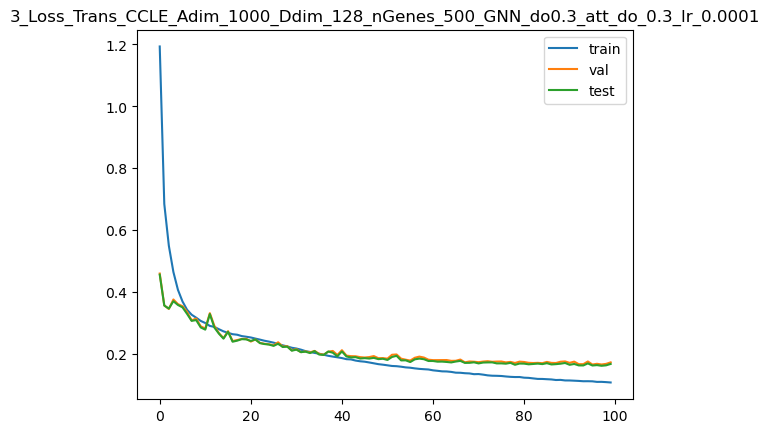

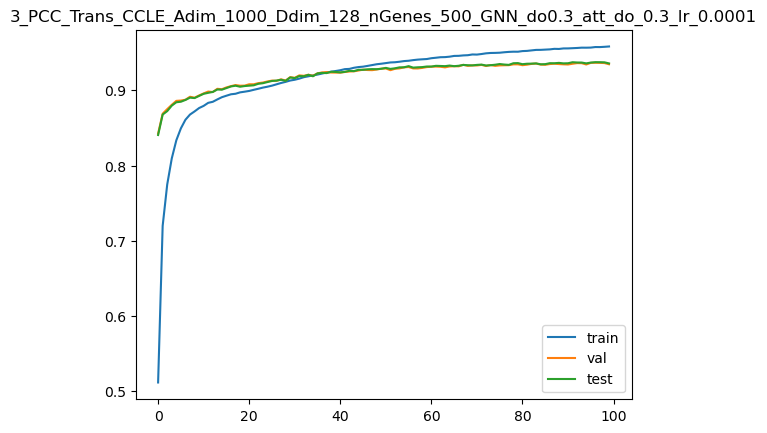

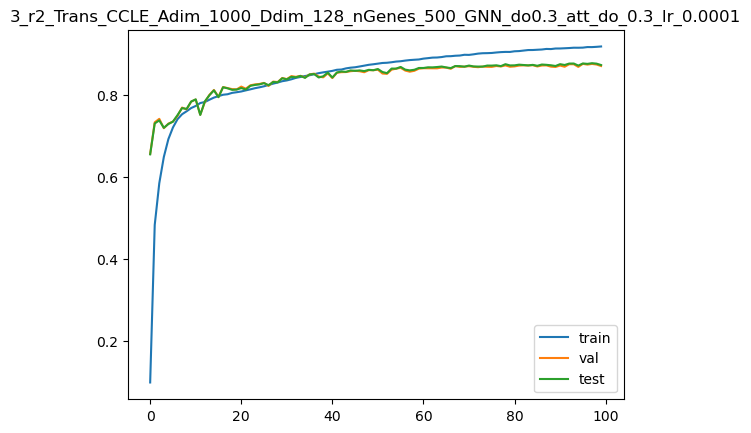

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1195310577750206
The overall Pearson's correlation is 0.9487.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09188488870859146
The overall Pearson's correlation is 0.9421.
Train avg_loss:  0.10702008
Train avg_pcc:  0.9587472829464005
Train r2:  0.9191915002710191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16718632
Validation avg_pcc:  0.9364110085681379
Validation r2:  0.8751118153294821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16323347
Test avg_pcc:  0.9372431953050215
Test r2:  0.8766993056740124
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1469971090555191
The overall Pearson's correlation is 0.9234.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1445017009973526
The overall Pearson's correlation is 0.9393.
Train avg_loss:  0.1066821
Train avg_pcc:  0.9588813721821909
Train r2:  0.9194467051156789


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17198543
Validation avg_pcc:  0.9363352288868647
Validation r2:  0.8715268755754526


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16873774
Test avg_pcc:  0.9366330313985666
Test r2:  0.8725415827611097
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14054569602012634
The overall Pearson's correlation is 0.9509.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1045336127281189
The overall Pearson's correlation is 0.9477.
Train avg_loss:  0.10648492
Train avg_pcc:  0.9589577635948776
Train r2:  0.9195955944091434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16742942
Validation avg_pcc:  0.9363050574484217
Validation r2:  0.8749302294412703


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.162445
Test avg_pcc:  0.9374471382314491
Test r2:  0.8772948831261931
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12923133373260498
The overall Pearson's correlation is 0.9434.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1447618305683136
The overall Pearson's correlation is 0.9477.
Train avg_loss:  0.106191665
Train avg_pcc:  0.9590738381982531
Train r2:  0.9198170265658555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16788328
Validation avg_pcc:  0.9354575591798127
Validation r2:  0.8745911913747992


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16246797
Test avg_pcc:  0.9368970766898594
Test r2:  0.8772775344770055
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09559330344200134
The overall Pearson's correlation is 0.9659.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10613935440778732
The overall Pearson's correlation is 0.9686.
Train avg_loss:  0.10495487
Train avg_pcc:  0.9595604143984351
Train r2:  0.9207509093134091


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16437452
Validation avg_pcc:  0.9371983222869921
Validation r2:  0.8772122400323616
Best Val r2  0.8772122400323616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.163165
Test avg_pcc:  0.9369199998057445
Test r2:  0.8767510133518103
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17252926528453827
The overall Pearson's correlation is 0.9210.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07795407623052597
The overall Pearson's correlation is 0.9759.
Train avg_loss:  0.10465166
Train avg_pcc:  0.9596800257762803
Train r2:  0.9209798506758605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.171657
Validation avg_pcc:  0.9352606886148498
Validation r2:  0.87177221621215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16854079
Test avg_pcc:  0.9357002098789227
Test r2:  0.8726903420867181
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09408161044120789
The overall Pearson's correlation is 0.9718.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08809841424226761
The overall Pearson's correlation is 0.9547.
Train avg_loss:  0.10486559
Train avg_pcc:  0.9595957658806763
Train r2:  0.9208183241743668


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16951494
Validation avg_pcc:  0.9361017634906794
Validation r2:  0.873372338954929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16551659
Test avg_pcc:  0.936913637452159
Test r2:  0.874974722854487
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11990343779325485
The overall Pearson's correlation is 0.9565.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0933571606874466
The overall Pearson's correlation is 0.9731.
Train avg_loss:  0.10369571
Train avg_pcc:  0.9600554896082869
Train r2:  0.9217016631425838


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16697738
Validation avg_pcc:  0.9362032156812877
Validation r2:  0.8752679068919721


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16104
Test avg_pcc:  0.9377920383296238
Test r2:  0.8783561845357472
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08502066135406494
The overall Pearson's correlation is 0.9627.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07526342570781708
The overall Pearson's correlation is 0.9635.
Train avg_loss:  0.103186324
Train avg_pcc:  0.9602552060237343
Train r2:  0.9220862860072154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17121837
Validation avg_pcc:  0.9366794788281702
Validation r2:  0.8720998808051058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16861133
Test avg_pcc:  0.9368313344222036
Test r2:  0.8726370593981664
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11209085583686829
The overall Pearson's correlation is 0.9694.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0835660919547081
The overall Pearson's correlation is 0.9656.
Train avg_loss:  0.102508314
Train avg_pcc:  0.960522217262352
Train r2:  0.922598245821988


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16445333
Validation avg_pcc:  0.9374675935928405
Validation r2:  0.8771533520720058


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16203703
Test avg_pcc:  0.9376232791337438
Test r2:  0.8776030418557825
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12654559314250946
The overall Pearson's correlation is 0.9568.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08165201544761658
The overall Pearson's correlation is 0.9734.
Train avg_loss:  0.1023727
Train avg_pcc:  0.9605759197658476
Train r2:  0.9227006546143866


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1702736
Validation avg_pcc:  0.9359085496950631
Validation r2:  0.8728056262543172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16678807
Test avg_pcc:  0.936375635994127
Test r2:  0.8740142785542627
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09268274903297424
The overall Pearson's correlation is 0.9687.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08917760848999023
The overall Pearson's correlation is 0.9630.
Train avg_loss:  0.100422606
Train avg_pcc:  0.9613418018211316
Train r2:  0.9241731129460999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17044678
Validation avg_pcc:  0.936072330882587
Validation r2:  0.8726762451919351


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16573334
Test avg_pcc:  0.9370655152855691
Test r2:  0.8748109957618316
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13349413871765137
The overall Pearson's correlation is 0.9519.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09926390647888184
The overall Pearson's correlation is 0.9618.
Train avg_loss:  0.10088597
Train avg_pcc:  0.9611593487227417
Train r2:  0.9238232370019883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16848196
Validation avg_pcc:  0.9357887253932953
Validation r2:  0.8741439654532336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16353333
Test avg_pcc:  0.9369089444760986
Test r2:  0.876472808605238
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11160507798194885
The overall Pearson's correlation is 0.9667.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1568256914615631
The overall Pearson's correlation is 0.9214.
Train avg_loss:  0.09988095
Train avg_pcc:  0.9615551301425298
Train r2:  0.9245821107462723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16581401
Validation avg_pcc:  0.9366970853045155
Validation r2:  0.876136928795967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16190909
Test avg_pcc:  0.937445239259628
Test r2:  0.8776996893418406
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05514468997716904
The overall Pearson's correlation is 0.9724.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0932154506444931
The overall Pearson's correlation is 0.9781.
Train avg_loss:  0.09980344
Train avg_pcc:  0.9615849780852301
Train r2:  0.9246406291717283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17274503
Validation avg_pcc:  0.9362961841235176
Validation r2:  0.8709594659618254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16652746
Test avg_pcc:  0.9377844763801326
Test r2:  0.8742111382208444
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08828289061784744
The overall Pearson's correlation is 0.9572.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11020637303590775
The overall Pearson's correlation is 0.9358.
Train avg_loss:  0.09829468
Train avg_pcc:  0.9621772334141738
Train r2:  0.9257798697774581


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16782962
Validation avg_pcc:  0.9363215117673475
Validation r2:  0.8746312750747762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16251892
Test avg_pcc:  0.9375871152726293
Test r2:  0.8772390395755711
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09523245692253113
The overall Pearson's correlation is 0.9648.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08505266904830933
The overall Pearson's correlation is 0.9648.
Train avg_loss:  0.098718286
Train avg_pcc:  0.9620104141314727
Train r2:  0.9254600084934745


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16870013
Validation avg_pcc:  0.9368682996365708
Validation r2:  0.8739810134785075


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16272043
Test avg_pcc:  0.938395033118097
Test r2:  0.8770868255533294
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09887771308422089
The overall Pearson's correlation is 0.9595.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08535873889923096
The overall Pearson's correlation is 0.9657.
Train avg_loss:  0.09875113
Train avg_pcc:  0.961998104753585
Train r2:  0.9254352154108451


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1711527
Validation avg_pcc:  0.936157844731787
Validation r2:  0.8721489443409797


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1671094
Test avg_pcc:  0.9368870213050715
Test r2:  0.8737715673652887
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11125616729259491
The overall Pearson's correlation is 0.9394.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1148693785071373
The overall Pearson's correlation is 0.9654.
Train avg_loss:  0.09770852
Train avg_pcc:  0.9624073306756359
Train r2:  0.9262224576605693


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16778895
Validation avg_pcc:  0.9366123150680452
Validation r2:  0.8746616414401652


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16322099
Test avg_pcc:  0.9377098890186124
Test r2:  0.8767087341954712
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08907629549503326
The overall Pearson's correlation is 0.9661.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09848124533891678
The overall Pearson's correlation is 0.9657.
Train avg_loss:  0.096917324
Train avg_pcc:  0.9627173622472734
Train r2:  0.9268198770822434


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16835043
Validation avg_pcc:  0.9366463023080921
Validation r2:  0.874242229627926


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16542792
Test avg_pcc:  0.9370979650289657
Test r2:  0.8750416887813769
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12163199484348297
The overall Pearson's correlation is 0.9377.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1629173904657364
The overall Pearson's correlation is 0.9290.
Train avg_loss:  0.09645875
Train avg_pcc:  0.9628968988789939
Train r2:  0.9271661340528548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16897619
Validation avg_pcc:  0.9364049628386
Validation r2:  0.8737747865216586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16378573
Test avg_pcc:  0.9375915222415206
Test r2:  0.8762821648489981
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11724618077278137
The overall Pearson's correlation is 0.9620.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10667701065540314
The overall Pearson's correlation is 0.9691.
Train avg_loss:  0.096943915
Train avg_pcc:  0.9627069469028449
Train r2:  0.9267998027645071


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17284739
Validation avg_pcc:  0.9357077402475692
Validation r2:  0.8708829914929004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16622475
Test avg_pcc:  0.9374289145820919
Test r2:  0.8744398097930537
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09317299723625183
The overall Pearson's correlation is 0.9557.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11995266377925873
The overall Pearson's correlation is 0.9416.
Train avg_loss:  0.095952846
Train avg_pcc:  0.9630948691441832
Train r2:  0.9275481302904943


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16722907
Validation avg_pcc:  0.9368133847555994
Validation r2:  0.8750798803339791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16325042
Test avg_pcc:  0.9375527495812841
Test r2:  0.8766864978779548
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08294805884361267
The overall Pearson's correlation is 0.9709.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08437128365039825
The overall Pearson's correlation is 0.9613.
Train avg_loss:  0.09545021
Train avg_pcc:  0.96329255165147
Train r2:  0.9279276666300451


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1693794
Validation avg_pcc:  0.9362370441045303
Validation r2:  0.8734735913540993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16329755
Test avg_pcc:  0.9380128826329706
Test r2:  0.8766509066134907
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0971316397190094
The overall Pearson's correlation is 0.9581.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13053005933761597
The overall Pearson's correlation is 0.9540.
Train avg_loss:  0.094628766
Train avg_pcc:  0.9636146169495965
Train r2:  0.9285479161704313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16846915
Validation avg_pcc:  0.9368089403908022
Validation r2:  0.8741535480875829


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1655878
Test avg_pcc:  0.9370266520164442
Test r2:  0.8749209364931194
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06519939005374908
The overall Pearson's correlation is 0.9722.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07089545577764511
The overall Pearson's correlation is 0.9693.
Train avg_loss:  0.09378923
Train avg_pcc:  0.963943262813183
Train r2:  0.9291818242000051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17046216
Validation avg_pcc:  0.9368483633282179
Validation r2:  0.872664763774931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16482966
Test avg_pcc:  0.9381128450331823
Test r2:  0.8754935943897827
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09313388168811798
The overall Pearson's correlation is 0.9621.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09257853031158447
The overall Pearson's correlation is 0.9630.
Train avg_loss:  0.09424768
Train avg_pcc:  0.9637637433188928
Train r2:  0.928835672257786


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16796081
Validation avg_pcc:  0.93675677021994
Validation r2:  0.8745332848311549


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16282634
Test avg_pcc:  0.9379934790274804
Test r2:  0.8770068329625204
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12592971324920654
The overall Pearson's correlation is 0.9628.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08894985914230347
The overall Pearson's correlation is 0.9679.
Train avg_loss:  0.093362026
Train avg_pcc:  0.9641104034051559
Train r2:  0.9295044028780899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16704912
Validation avg_pcc:  0.9361425142036068
Validation r2:  0.8752143012085729


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16144063
Test avg_pcc:  0.9375890583915821
Test r2:  0.8780535519452682
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06137798726558685
The overall Pearson's correlation is 0.9750.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08068305253982544
The overall Pearson's correlation is 0.9533.
Train avg_loss:  0.09358361
Train avg_pcc:  0.9640240002262364
Train r2:  0.9293370858548056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16518727
Validation avg_pcc:  0.9369655822463566
Validation r2:  0.8766051010013285


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1616934
Test avg_pcc:  0.9375296568273465
Test r2:  0.8778626217129362
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07944953441619873
The overall Pearson's correlation is 0.9732.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08774913102388382
The overall Pearson's correlation is 0.9641.
Train avg_loss:  0.09305974
Train avg_pcc:  0.964228884627028
Train r2:  0.9297326499392633


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16517618
Validation avg_pcc:  0.9377749469311228
Validation r2:  0.8766133970967119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16287756
Test avg_pcc:  0.9378421570240838
Test r2:  0.8769681506236825
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09793133288621902
The overall Pearson's correlation is 0.9592.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09630230069160461
The overall Pearson's correlation is 0.9637.
Train avg_loss:  0.09256598
Train avg_pcc:  0.9644219991194558
Train r2:  0.9301054726229401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17052668
Validation avg_pcc:  0.9372952131069954
Validation r2:  0.872616567788822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16616942
Test avg_pcc:  0.938070018893202
Test r2:  0.8744815902995368
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07659527659416199
The overall Pearson's correlation is 0.9700.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05120991915464401
The overall Pearson's correlation is 0.9808.
Train avg_loss:  0.09200174
Train avg_pcc:  0.9646432276259993
Train r2:  0.9305315154004101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16621251
Validation avg_pcc:  0.9376077645646375
Validation r2:  0.8758392522747913


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16226044
Test avg_pcc:  0.9383531079928307
Test r2:  0.8774342935195097
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0699441134929657
The overall Pearson's correlation is 0.9763.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08285601437091827
The overall Pearson's correlation is 0.9747.
Train avg_loss:  0.09137932
Train avg_pcc:  0.9648863124913301
Train r2:  0.931001504296136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16846107
Validation avg_pcc:  0.9365322199807191
Validation r2:  0.8741595846526061


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16263907
Test avg_pcc:  0.9380411795199631
Test r2:  0.8771482966585233
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06964749097824097
The overall Pearson's correlation is 0.9724.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09496428072452545
The overall Pearson's correlation is 0.9633.
Train avg_loss:  0.09111332
Train avg_pcc:  0.9649907313846696
Train r2:  0.9312023468587648


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16973668
Validation avg_pcc:  0.9368110414835675
Validation r2:  0.8732067015397201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16480361
Test avg_pcc:  0.9378260217991111
Test r2:  0.8755132805901056
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09053495526313782
The overall Pearson's correlation is 0.9579.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13139145076274872
The overall Pearson's correlation is 0.9570.
Train avg_loss:  0.090487696
Train avg_pcc:  0.9652350893161521
Train r2:  0.931674748951578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1651738
Validation avg_pcc:  0.9377339815669677
Validation r2:  0.8766151779510487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16139692
Test avg_pcc:  0.9383866888945847
Test r2:  0.8780865633519357
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07446715235710144
The overall Pearson's correlation is 0.9758.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0802602544426918
The overall Pearson's correlation is 0.9811.
Train avg_loss:  0.09010441
Train avg_pcc:  0.9653849756630121
Train r2:  0.931964156834517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16666067
Validation avg_pcc:  0.9371556111753403
Validation r2:  0.8755044845580008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16140728
Test avg_pcc:  0.9384930021253756
Test r2:  0.8780787332868815
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10234113037586212
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10799627006053925
The overall Pearson's correlation is 0.9616.
Train avg_loss:  0.08985821
Train avg_pcc:  0.9654812657966833
Train r2:  0.9321500579752202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16623572
Validation avg_pcc:  0.9373919921652045
Validation r2:  0.8758219159591708


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16261996
Test avg_pcc:  0.9380577132892104
Test r2:  0.8771627228343579
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08504361659288406
The overall Pearson's correlation is 0.9705.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11256939172744751
The overall Pearson's correlation is 0.9389.
Train avg_loss:  0.089186564
Train avg_pcc:  0.9657441368309818
Train r2:  0.9326572037949193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1643082
Validation avg_pcc:  0.9378245804052381
Validation r2:  0.8772617716263346
Best Val r2  0.8772617716263346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15863462
Test avg_pcc:  0.9394238662701268
Test r2:  0.8801731040911598
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1085139811038971
The overall Pearson's correlation is 0.9455.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08344264328479767
The overall Pearson's correlation is 0.9783.
Train avg_loss:  0.08928516
Train avg_pcc:  0.9657052621901541
Train r2:  0.932582752676932


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16208565
Validation avg_pcc:  0.9382381480753267
Validation r2:  0.8789220156829649
Best Val r2  0.8789220156829649


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15899394
Test avg_pcc:  0.9387255495235537
Test r2:  0.8799016986277558
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08783315867185593
The overall Pearson's correlation is 0.9690.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10326622426509857
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.08925556
Train avg_pcc:  0.96571726243408
Train r2:  0.9326051082158632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16403335
Validation avg_pcc:  0.9377404563961073
Validation r2:  0.8774670911708548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15867643
Test avg_pcc:  0.9391181460708669
Test r2:  0.8801415343709487
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06793971359729767
The overall Pearson's correlation is 0.9782.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05917246267199516
The overall Pearson's correlation is 0.9839.
Train avg_loss:  0.08853978
Train avg_pcc:  0.9659972650289699
Train r2:  0.9331455741931428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1648119
Validation avg_pcc:  0.9377317009959875
Validation r2:  0.8768855087492676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16028224
Test avg_pcc:  0.9387080967662323
Test r2:  0.87892855483394
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.075898677110672
The overall Pearson's correlation is 0.9568.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06418482959270477
The overall Pearson's correlation is 0.9779.
Train avg_loss:  0.0884095
Train avg_pcc:  0.9660479582643915
Train r2:  0.9332439402306277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16511501
Validation avg_pcc:  0.9375601386920874
Validation r2:  0.8766590899691294


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1612238
Test avg_pcc:  0.9382286319611943
Test r2:  0.8782173362605775
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09355418384075165
The overall Pearson's correlation is 0.9696.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09986881166696548
The overall Pearson's correlation is 0.9422.
Train avg_loss:  0.08734699
Train avg_pcc:  0.9664625858793442
Train r2:  0.9340462290125634


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16679826
Validation avg_pcc:  0.9361977081772672
Validation r2:  0.875401695822974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16167654
Test avg_pcc:  0.9374875901106123
Test r2:  0.8778753476649
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07496418058872223
The overall Pearson's correlation is 0.9610.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07313527166843414
The overall Pearson's correlation is 0.9759.
Train avg_loss:  0.087623894
Train avg_pcc:  0.9663547625690352
Train r2:  0.9338371362155008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1666594
Validation avg_pcc:  0.9370375990950573
Validation r2:  0.8755054342480738


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16108292
Test avg_pcc:  0.9385464342002384
Test r2:  0.8783237447067974
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09667696803808212
The overall Pearson's correlation is 0.9607.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07965046167373657
The overall Pearson's correlation is 0.9771.
Train avg_loss:  0.08654373
Train avg_pcc:  0.966776471236477
Train r2:  0.9346527475376831


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16308619
Validation avg_pcc:  0.9375874075739031
Validation r2:  0.8781746194678933


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15885645
Test avg_pcc:  0.9385584618560251
Test r2:  0.8800055532263218
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.064730703830719
The overall Pearson's correlation is 0.9730.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06886754184961319
The overall Pearson's correlation is 0.9763.
Train avg_loss:  0.086743824
Train avg_pcc:  0.9666985183778911
Train r2:  0.9345016605413827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16638386
Validation avg_pcc:  0.9370819696577677
Validation r2:  0.8757112568501922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.160363
Test avg_pcc:  0.9386744868981428
Test r2:  0.8788675467172067
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07843615114688873
The overall Pearson's correlation is 0.9633.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1527377963066101
The overall Pearson's correlation is 0.9550.
Train avg_loss:  0.08646281
Train avg_pcc:  0.9668080567708912
Train r2:  0.9347138461161304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16492182
Validation avg_pcc:  0.9381278424481042
Validation r2:  0.876803393127178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15932353
Test avg_pcc:  0.9395722339659723
Test r2:  0.8796527431899394
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10121406614780426
The overall Pearson's correlation is 0.9515.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06489458680152893
The overall Pearson's correlation is 0.9682.
Train avg_loss:  0.08628561
Train avg_pcc:  0.9668773415490305
Train r2:  0.934847652051803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16738647
Validation avg_pcc:  0.9371147804341339
Validation r2:  0.8749623095030895


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16440862
Test avg_pcc:  0.9374159849781697
Test r2:  0.875811625044638
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05016348883509636
The overall Pearson's correlation is 0.9871.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11339186131954193
The overall Pearson's correlation is 0.9535.
Train avg_loss:  0.08701943
Train avg_pcc:  0.9665910514822399
Train r2:  0.9342935603460655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1663586
Validation avg_pcc:  0.9368577020345131
Validation r2:  0.8757301260448107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16143477
Test avg_pcc:  0.9380612240502174
Test r2:  0.8780579735612957
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10154972970485687
The overall Pearson's correlation is 0.9600.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09193249046802521
The overall Pearson's correlation is 0.9684.
Train avg_loss:  0.08637874
Train avg_pcc:  0.9668408490006877
Train r2:  0.9347773349799317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16696559
Validation avg_pcc:  0.9375474273914083
Validation r2:  0.8752767039309037


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16226369
Test avg_pcc:  0.9385964817624353
Test r2:  0.8774318389647237


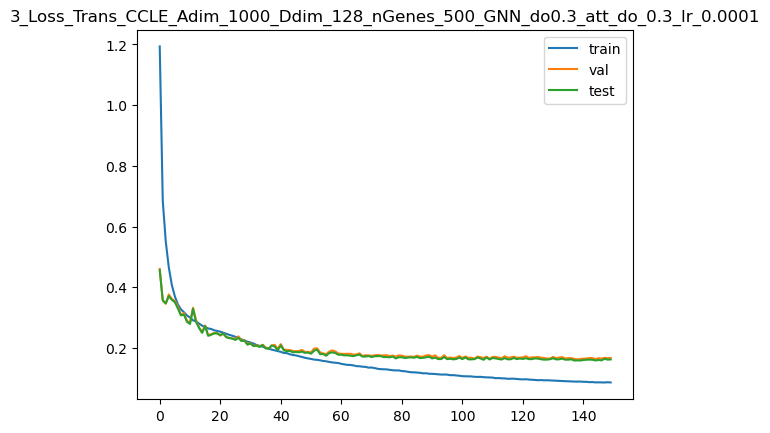

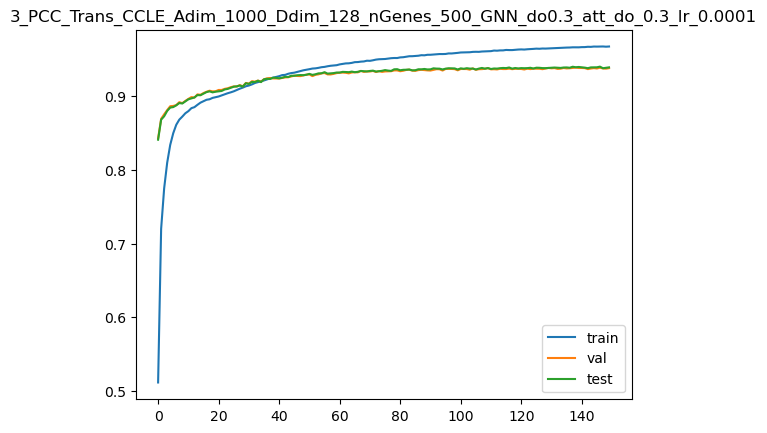

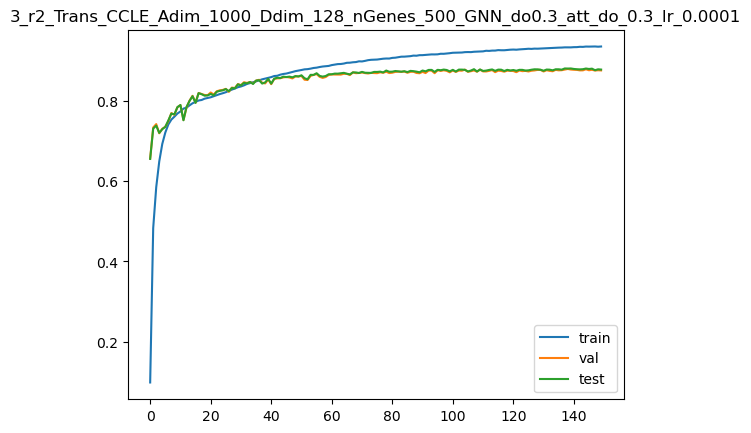

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08354039490222931
The overall Pearson's correlation is 0.9690.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0810997486114502
The overall Pearson's correlation is 0.9704.
Train avg_loss:  0.0845813
Train avg_pcc:  0.9675424086731546
Train r2:  0.9361345297001421


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16558182
Validation avg_pcc:  0.9373611517394282
Validation r2:  0.8763103759841141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16027533
Test avg_pcc:  0.9386325415159066
Test r2:  0.8789337812520108
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09217818081378937
The overall Pearson's correlation is 0.9615.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07556413859128952
The overall Pearson's correlation is 0.9705.
Train avg_loss:  0.085590124
Train avg_pcc:  0.9671491318655762
Train r2:  0.9353727926682414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1627201
Validation avg_pcc:  0.9386926736727944
Validation r2:  0.8784480908592271


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15962383
Test avg_pcc:  0.939173270734046
Test r2:  0.8794259011982791
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12361478805541992
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08218713104724884
The overall Pearson's correlation is 0.9680.
Train avg_loss:  0.08464069
Train avg_pcc:  0.9675190573009423
Train r2:  0.9360896936999854


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16433285
Validation avg_pcc:  0.9381591067641244
Validation r2:  0.8772433582315062


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16173413
Test avg_pcc:  0.9382546216607969
Test r2:  0.8778318500925437
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08662331104278564
The overall Pearson's correlation is 0.9612.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07175880670547485
The overall Pearson's correlation is 0.9695.
Train avg_loss:  0.08449294
Train avg_pcc:  0.9675776557036517
Train r2:  0.9362012538436352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16679087
Validation avg_pcc:  0.9382214462698327
Validation r2:  0.875407221057239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16247661
Test avg_pcc:  0.9391065036856212
Test r2:  0.8772710086111123
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08352235704660416
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09790003299713135
The overall Pearson's correlation is 0.9671.
Train avg_loss:  0.08472284
Train avg_pcc:  0.9674867819339039
Train r2:  0.9360276610461172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16414471
Validation avg_pcc:  0.9379538078549828
Validation r2:  0.8773839085324718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1602182
Test avg_pcc:  0.938826573308884
Test r2:  0.8789769336389749
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.052901145070791245
The overall Pearson's correlation is 0.9813.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07878909260034561
The overall Pearson's correlation is 0.9655.
Train avg_loss:  0.0840066
Train avg_pcc:  0.9677670614583841
Train r2:  0.9365684766333986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16498673
Validation avg_pcc:  0.9382372212447735
Validation r2:  0.8767549124262827


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16073295
Test avg_pcc:  0.9390620032875941
Test r2:  0.878588096726364
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.059060581028461456
The overall Pearson's correlation is 0.9801.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06369687616825104
The overall Pearson's correlation is 0.9727.
Train avg_loss:  0.08320748
Train avg_pcc:  0.9680785944580068
Train r2:  0.9371718754011267


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16536956
Validation avg_pcc:  0.937981744705845
Validation r2:  0.876468936324948


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16143736
Test avg_pcc:  0.9387987404193436
Test r2:  0.8780560185048041
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06005656719207764
The overall Pearson's correlation is 0.9731.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1478453278541565
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.083712496
Train avg_pcc:  0.9678815565325712
Train r2:  0.9367905452480225


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16580096
Validation avg_pcc:  0.9381659987918273
Validation r2:  0.8761466901665136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16166446
Test avg_pcc:  0.9389286504024429
Test r2:  0.8778844839818832
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11042600125074387
The overall Pearson's correlation is 0.9581.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0856170579791069
The overall Pearson's correlation is 0.9714.
Train avg_loss:  0.08243367
Train avg_pcc:  0.9683799656717753
Train r2:  0.9377561554863799


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16293134
Validation avg_pcc:  0.9379427369323867
Validation r2:  0.8782902927924603


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15878226
Test avg_pcc:  0.9388141462818331
Test r2:  0.8800615961663596
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0850246250629425
The overall Pearson's correlation is 0.9750.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10157611966133118
The overall Pearson's correlation is 0.9533.
Train avg_loss:  0.08336548
Train avg_pcc:  0.9680171525203696
Train r2:  0.9370525782657575


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16665085
Validation avg_pcc:  0.936774954748924
Validation r2:  0.8755118266684543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16173257
Test avg_pcc:  0.9379272195818275
Test r2:  0.8778330339810959
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07983963191509247
The overall Pearson's correlation is 0.9649.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09370902180671692
The overall Pearson's correlation is 0.9555.
Train avg_loss:  0.0824953
Train avg_pcc:  0.9683562086843749
Train r2:  0.9377096223562935


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16850112
Validation avg_pcc:  0.9370500408986676
Validation r2:  0.8741296621947248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16188362
Test avg_pcc:  0.938939908642861
Test r2:  0.877718926457608
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07711273431777954
The overall Pearson's correlation is 0.9728.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07349474728107452
The overall Pearson's correlation is 0.9653.
Train avg_loss:  0.08143092
Train avg_pcc:  0.9687705655631712
Train r2:  0.9385133230762617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16306816
Validation avg_pcc:  0.9373484528407026
Validation r2:  0.8781880865835087


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1580571
Test avg_pcc:  0.9385790038996483
Test r2:  0.8806093525072728
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08027626574039459
The overall Pearson's correlation is 0.9661.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09473887085914612
The overall Pearson's correlation is 0.9644.
Train avg_loss:  0.08281209
Train avg_pcc:  0.9682330911311408
Train r2:  0.9374704193707774


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16401947
Validation avg_pcc:  0.9381426949774097
Validation r2:  0.877477456096404


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1606755
Test avg_pcc:  0.938594887863564
Test r2:  0.8786314978604561
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0973767340183258
The overall Pearson's correlation is 0.9638.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09377078711986542
The overall Pearson's correlation is 0.9654.
Train avg_loss:  0.08161977
Train avg_pcc:  0.9686973715651795
Train r2:  0.9383707209807941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16403882
Validation avg_pcc:  0.9376591098247755
Validation r2:  0.8774629969625453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1605286
Test avg_pcc:  0.9381930844085121
Test r2:  0.8787424657116911
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11004995554685593
The overall Pearson's correlation is 0.9405.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10901543498039246
The overall Pearson's correlation is 0.9523.
Train avg_loss:  0.08178641
Train avg_pcc:  0.9686325772974275
Train r2:  0.9382448983041725


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16343822
Validation avg_pcc:  0.9379612776559499
Validation r2:  0.8779116520958681


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15926307
Test avg_pcc:  0.9387603701615451
Test r2:  0.8796983898752753
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06903298199176788
The overall Pearson's correlation is 0.9778.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07474780082702637
The overall Pearson's correlation is 0.9713.
Train avg_loss:  0.08152908
Train avg_pcc:  0.9687324795572545
Train r2:  0.9384391952764103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16405171
Validation avg_pcc:  0.9371807654733714
Validation r2:  0.8774533673319694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15889929
Test avg_pcc:  0.9384092503399409
Test r2:  0.8799731788806191
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07819429039955139
The overall Pearson's correlation is 0.9767.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08851040154695511
The overall Pearson's correlation is 0.9750.
Train avg_loss:  0.081000425
Train avg_pcc:  0.9689390098281113
Train r2:  0.9388383783484346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16421896
Validation avg_pcc:  0.9385318123268692
Validation r2:  0.8773284213834263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15947309
Test avg_pcc:  0.9396872842632333
Test r2:  0.8795397661406982
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12286510318517685
The overall Pearson's correlation is 0.9545.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05674104392528534
The overall Pearson's correlation is 0.9776.
Train avg_loss:  0.08043586
Train avg_pcc:  0.9691587203634584
Train r2:  0.9392646615141733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16353764
Validation avg_pcc:  0.9385566857632014
Validation r2:  0.877837389854252


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15953891
Test avg_pcc:  0.9393321085962082
Test r2:  0.8794900372394516
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11738867312669754
The overall Pearson's correlation is 0.9553.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0688450038433075
The overall Pearson's correlation is 0.9823.
Train avg_loss:  0.08091084
Train avg_pcc:  0.9689738878045916
Train r2:  0.9389060174531582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16582753
Validation avg_pcc:  0.9378431177399107
Validation r2:  0.8761268370769029


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16154708
Test avg_pcc:  0.9388011326189158
Test r2:  0.8779731389450354
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07786040008068085
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06661604344844818
The overall Pearson's correlation is 0.9615.
Train avg_loss:  0.08003698
Train avg_pcc:  0.9693135311160523
Train r2:  0.9395658428827387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16372512
Validation avg_pcc:  0.9375037495111831
Validation r2:  0.8776973367628818


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1575991
Test avg_pcc:  0.9392066531552504
Test r2:  0.8809552880965209
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06625553965568542
The overall Pearson's correlation is 0.9719.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0858335942029953
The overall Pearson's correlation is 0.9731.
Train avg_loss:  0.079795636
Train avg_pcc:  0.9694079761195046
Train r2:  0.9397480820956902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16316798
Validation avg_pcc:  0.9380675080096362
Validation r2:  0.8781135169381542


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15802854
Test avg_pcc:  0.9394034417851977
Test r2:  0.8806309264763668
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08840121328830719
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07371795177459717
The overall Pearson's correlation is 0.9767.
Train avg_loss:  0.07928794
Train avg_pcc:  0.9696056649315917
Train r2:  0.9401314308451466


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16332209
Validation avg_pcc:  0.937895527609653
Validation r2:  0.8779984049937528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15916322
Test avg_pcc:  0.9388385873093436
Test r2:  0.8797738266170934
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08606354892253876
The overall Pearson's correlation is 0.9652.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10357289761304855
The overall Pearson's correlation is 0.9711.
Train avg_loss:  0.07936511
Train avg_pcc:  0.9695761247828392
Train r2:  0.940073156205637


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16463685
Validation avg_pcc:  0.9386811279201045
Validation r2:  0.8770162738018837


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15998597
Test avg_pcc:  0.9397148206277104
Test r2:  0.8791523502983571
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09829910099506378
The overall Pearson's correlation is 0.9620.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10794465988874435
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.07941276
Train avg_pcc:  0.9695575041324539
Train r2:  0.9400371908923131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16665503
Validation avg_pcc:  0.9380064108846353
Validation r2:  0.8755086984769407


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16240306
Test avg_pcc:  0.9388534576058243
Test r2:  0.8773265731220548
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13209806382656097
The overall Pearson's correlation is 0.9462.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08154977858066559
The overall Pearson's correlation is 0.9657.
Train avg_loss:  0.07872105
Train avg_pcc:  0.9698262547681987
Train r2:  0.9405594803190997


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16387172
Validation avg_pcc:  0.9376961730759296
Validation r2:  0.877587827998487


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15656239
Test avg_pcc:  0.9398643927626534
Test r2:  0.8817384049876577
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06840261816978455
The overall Pearson's correlation is 0.9674.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09382697194814682
The overall Pearson's correlation is 0.9599.
Train avg_loss:  0.07909812
Train avg_pcc:  0.9696796432539321
Train r2:  0.9402747564667951


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16265886
Validation avg_pcc:  0.9385893559656686
Validation r2:  0.878493842486455


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15880539
Test avg_pcc:  0.9393407045773872
Test r2:  0.8800441257622785
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08115779608488083
The overall Pearson's correlation is 0.9684.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08800699561834335
The overall Pearson's correlation is 0.9696.
Train avg_loss:  0.07914527
Train avg_pcc:  0.9696607557866087
Train r2:  0.9402391582087424


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16777983
Validation avg_pcc:  0.9382761964406938
Validation r2:  0.8746684683539486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16431314
Test avg_pcc:  0.9389371031165602
Test r2:  0.8758837666057826
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06003159284591675
The overall Pearson's correlation is 0.9684.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10424430668354034
The overall Pearson's correlation is 0.9529.
Train avg_loss:  0.07864073
Train avg_pcc:  0.9698578098720402
Train r2:  0.9406201272942449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16358545
Validation avg_pcc:  0.9385349409808588
Validation r2:  0.8778016643454901


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15981637
Test avg_pcc:  0.9391984862728742
Test r2:  0.8792804587403392
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08143676817417145
The overall Pearson's correlation is 0.9714.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.066639244556427
The overall Pearson's correlation is 0.9608.
Train avg_loss:  0.07860977
Train avg_pcc:  0.969870105161253
Train r2:  0.9406435048630394


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16177413
Validation avg_pcc:  0.9386147433027852
Validation r2:  0.8791547286550676
Best Val r2  0.8791547286550676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15737338
Test avg_pcc:  0.9396218199032286
Test r2:  0.8811258033708856
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05379745364189148
The overall Pearson's correlation is 0.9799.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07287470996379852
The overall Pearson's correlation is 0.9653.
Train avg_loss:  0.07826452
Train avg_pcc:  0.9700035176425664
Train r2:  0.9409041956376092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16440281
Validation avg_pcc:  0.9378947273164733
Validation r2:  0.8771910978318179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16079389
Test avg_pcc:  0.9385063641432735
Test r2:  0.8785420713547273
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07530602812767029
The overall Pearson's correlation is 0.9683.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07090456783771515
The overall Pearson's correlation is 0.9754.
Train avg_loss:  0.07768719
Train avg_pcc:  0.9702290282304068
Train r2:  0.9413401274787168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16451666
Validation avg_pcc:  0.9377300033783661
Validation r2:  0.8771060615903372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16002637
Test avg_pcc:  0.9388286740496788
Test r2:  0.8791218245167443
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10684878379106522
The overall Pearson's correlation is 0.9625.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09603668004274368
The overall Pearson's correlation is 0.9692.
Train avg_loss:  0.07854354
Train avg_pcc:  0.9698957414472081
Train r2:  0.9406935119870669


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16436455
Validation avg_pcc:  0.937479953856877
Validation r2:  0.8772196858670989


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1592726
Test avg_pcc:  0.9387322165540718
Test r2:  0.8796912073126623
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07868210971355438
The overall Pearson's correlation is 0.9749.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06079814210534096
The overall Pearson's correlation is 0.9768.
Train avg_loss:  0.07799999
Train avg_pcc:  0.9701069338985832
Train r2:  0.9411039355991015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16429369
Validation avg_pcc:  0.9382820727445381
Validation r2:  0.8772726036825611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16067754
Test avg_pcc:  0.9389453879019997
Test r2:  0.878629963025059
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07820838689804077
The overall Pearson's correlation is 0.9676.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07202058285474777
The overall Pearson's correlation is 0.9777.
Train avg_loss:  0.07689082
Train avg_pcc:  0.9705384772476743
Train r2:  0.9419414436444365


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16305646
Validation avg_pcc:  0.9384268585369385
Validation r2:  0.8781968303774292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15782931
Test avg_pcc:  0.9398158453850933
Test r2:  0.8807813992468593
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09229843318462372
The overall Pearson's correlation is 0.9603.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06046155095100403
The overall Pearson's correlation is 0.9778.
Train avg_loss:  0.077502236
Train avg_pcc:  0.9703003014169979
Train r2:  0.9414797819116774


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16534111
Validation avg_pcc:  0.9367730873971931
Validation r2:  0.876490193378563


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15994434
Test avg_pcc:  0.9382024458197371
Test r2:  0.8791837928912098
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06954198330640793
The overall Pearson's correlation is 0.9732.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08759741485118866
The overall Pearson's correlation is 0.9762.
Train avg_loss:  0.0772596
Train avg_pcc:  0.9703950624292402
Train r2:  0.9416629850967677


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16259946
Validation avg_pcc:  0.9385766290374034
Validation r2:  0.8785382006381974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15867479
Test avg_pcc:  0.9394459541461219
Test r2:  0.8801427648098524
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1351560652256012
The overall Pearson's correlation is 0.9514.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08404621481895447
The overall Pearson's correlation is 0.9729.
Train avg_loss:  0.077438585
Train avg_pcc:  0.9703254737675344
Train r2:  0.9415278393161082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16282909
Validation avg_pcc:  0.9377217916401006
Validation r2:  0.8783666711227355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16034244
Test avg_pcc:  0.9379718161686635
Test r2:  0.8788830843308839
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07503184676170349
The overall Pearson's correlation is 0.9605.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08099532127380371
The overall Pearson's correlation is 0.9734.
Train avg_loss:  0.076523565
Train avg_pcc:  0.9706814170543512
Train r2:  0.9422187510886272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1619498
Validation avg_pcc:  0.9382645830752517
Validation r2:  0.8790234920657538


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15735638
Test avg_pcc:  0.9393149172573985
Test r2:  0.8811386462066395
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0660090446472168
The overall Pearson's correlation is 0.9740.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07137974351644516
The overall Pearson's correlation is 0.9750.
Train avg_loss:  0.07591976
Train avg_pcc:  0.9709162507293466
Train r2:  0.9426746746011556


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16353132
Validation avg_pcc:  0.9378459166264792
Validation r2:  0.8778421020372924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15838085
Test avg_pcc:  0.9391272509995626
Test r2:  0.8803647975990108
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08699816465377808
The overall Pearson's correlation is 0.9721.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07674941420555115
The overall Pearson's correlation is 0.9727.
Train avg_loss:  0.07519409
Train avg_pcc:  0.9711982691168105
Train r2:  0.9432226168314456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16329803
Validation avg_pcc:  0.9382740905994983
Validation r2:  0.8780163814513148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15932842
Test avg_pcc:  0.9390546832237902
Test r2:  0.8796490562160276
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08641809225082397
The overall Pearson's correlation is 0.9767.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06978920102119446
The overall Pearson's correlation is 0.9793.
Train avg_loss:  0.07586051
Train avg_pcc:  0.9709394050020378
Train r2:  0.9427194120701295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16746908
Validation avg_pcc:  0.937388151043646
Validation r2:  0.8749005871941152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16302855
Test avg_pcc:  0.9383370360102721
Test r2:  0.8768540966292222
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08246266841888428
The overall Pearson's correlation is 0.9736.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06644584238529205
The overall Pearson's correlation is 0.9766.
Train avg_loss:  0.07598987
Train avg_pcc:  0.970888969571367
Train r2:  0.942621732583734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16379362
Validation avg_pcc:  0.938113187107869
Validation r2:  0.8776461614212826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16064148
Test avg_pcc:  0.9386024462983242
Test r2:  0.8786572002626121
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06620181351900101
The overall Pearson's correlation is 0.9739.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06990392506122589
The overall Pearson's correlation is 0.9729.
Train avg_loss:  0.07526467
Train avg_pcc:  0.9711707793121828
Train r2:  0.9431693173236491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16432835
Validation avg_pcc:  0.9384290068689956
Validation r2:  0.8772467150481451


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16062027
Test avg_pcc:  0.9392776303999706
Test r2:  0.8786732246225898
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08253376930952072
The overall Pearson's correlation is 0.9603.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11013341695070267
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.07609152
Train avg_pcc:  0.9708492603965911
Train r2:  0.9425449741446861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16187392
Validation avg_pcc:  0.9387789864668238
Validation r2:  0.8790801796059435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1572857
Test avg_pcc:  0.9397471883366212
Test r2:  0.8811920353330231
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06976096332073212
The overall Pearson's correlation is 0.9796.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07624533772468567
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.07573126
Train avg_pcc:  0.970989437206984
Train r2:  0.9428169996349867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16450316
Validation avg_pcc:  0.938007951823586
Validation r2:  0.8771161434832149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15930825
Test avg_pcc:  0.9391472177510397
Test r2:  0.8796642750698038
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09792302548885345
The overall Pearson's correlation is 0.9675.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09159328043460846
The overall Pearson's correlation is 0.9726.
Train avg_loss:  0.075190865
Train avg_pcc:  0.9711995707887547
Train r2:  0.9432250466349702


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16343746
Validation avg_pcc:  0.9383747144395067
Validation r2:  0.8779122270222784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15888432
Test avg_pcc:  0.9393940578003731
Test r2:  0.8799845004256852
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07388145476579666
The overall Pearson's correlation is 0.9817.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08010083436965942
The overall Pearson's correlation is 0.9712.
Train avg_loss:  0.07415234
Train avg_pcc:  0.9716028120861808
Train r2:  0.9440092027861229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16593964
Validation avg_pcc:  0.9371425977383699
Validation r2:  0.876043087991793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15887907
Test avg_pcc:  0.9391070632137116
Test r2:  0.8799884622832982
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06716636568307877
The overall Pearson's correlation is 0.9830.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07978647947311401
The overall Pearson's correlation is 0.9726.
Train avg_loss:  0.075592786
Train avg_pcc:  0.9710436608730625
Train r2:  0.9429215607154968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16635594
Validation avg_pcc:  0.937348168003835
Validation r2:  0.8757321055635984


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1617829
Test avg_pcc:  0.9383568930552206
Test r2:  0.8777950045423185
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07934185862541199
The overall Pearson's correlation is 0.9744.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0722353607416153
The overall Pearson's correlation is 0.9657.
Train avg_loss:  0.07472321
Train avg_pcc:  0.9713812111055737
Train r2:  0.9435781573512587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16356039
Validation avg_pcc:  0.9379866065190157
Validation r2:  0.8778203852830511


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15849406
Test avg_pcc:  0.9392143431776415
Test r2:  0.8802792828998877
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06396710872650146
The overall Pearson's correlation is 0.9671.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07218337059020996
The overall Pearson's correlation is 0.9672.
Train avg_loss:  0.07463907
Train avg_pcc:  0.9714140714911064
Train r2:  0.9436416963820875


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16326003
Validation avg_pcc:  0.9383685338342619
Validation r2:  0.87804476912986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15824313
Test avg_pcc:  0.9396546281973536
Test r2:  0.8804688241999103


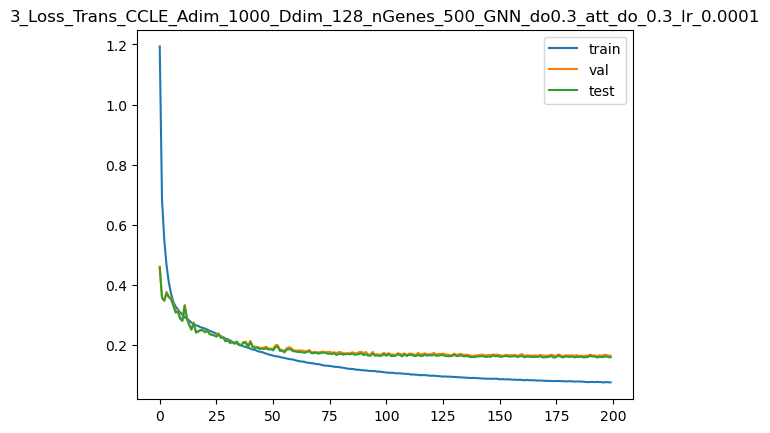

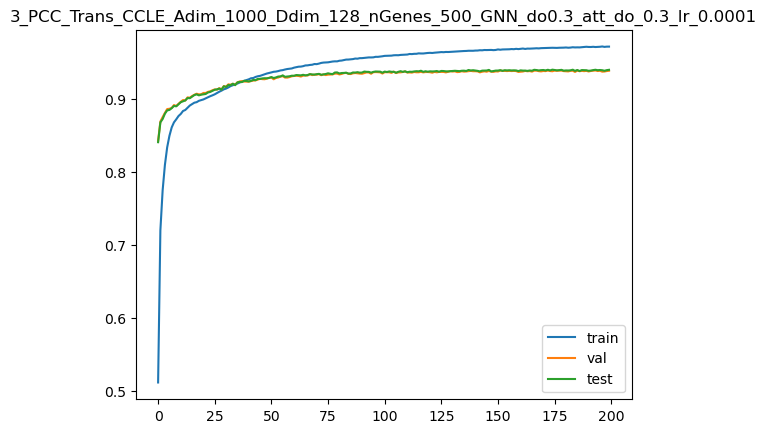

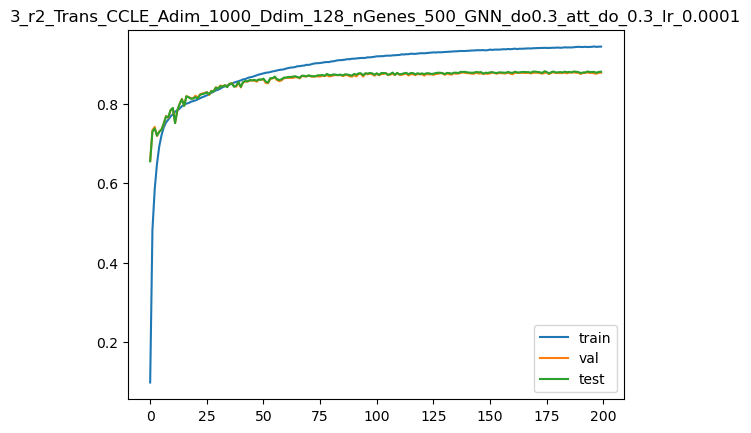

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15737337
Test avg_pcc:  0.939621819707114
Test r2:  0.8811258028229719


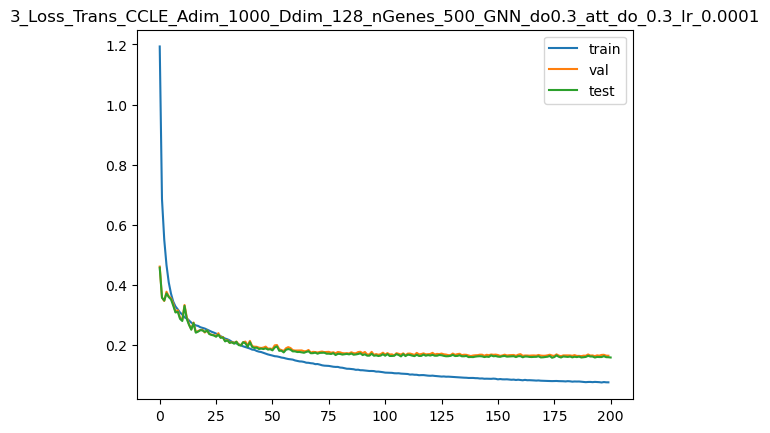

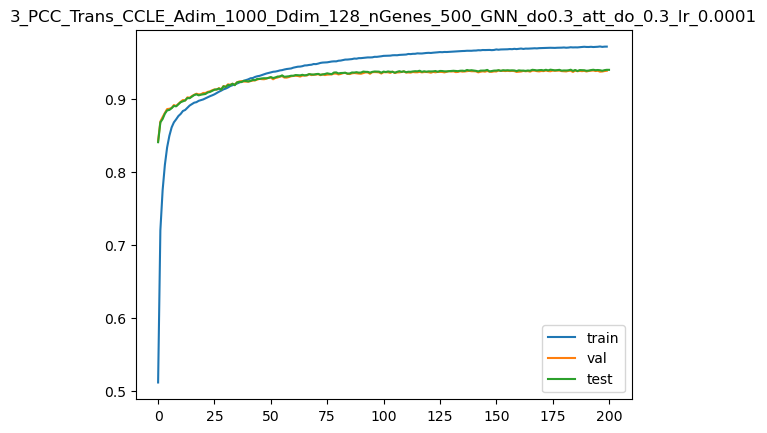

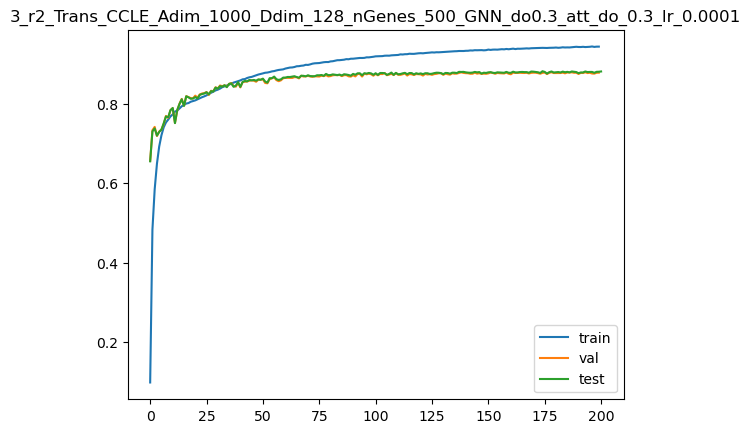

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.8551605343818665
The overall Pearson's correlation is 0.6450.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  1.0364739894866943
The overall Pearson's correlation is 0.6971.
Train avg_loss:  1.144866
Train avg_pcc:  0.5256619874770466
Train r2:  0.1362928944671239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.51187164
Validation avg_pcc:  0.8482261238721167
Validation r2:  0.6225291821207919
Best Val r2  0.6225291821207919


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.49432573
Test avg_pcc:  0.8525809903963142
Test r2:  0.6230695027736639
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.8431532979011536
The overall Pearson's correlation is 0.7289.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.8105970025062561
The overall Pearson's correlation is 0.6826.
Train avg_loss:  0.66449827
Train avg_pcc:  0.7271237948892865
Train r2:  0.49869079635055036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.38920495
Validation avg_pcc:  0.8633056738905909
Validation r2:  0.7129876248422287
Best Val r2  0.7129876248422287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.36914238
Test avg_pcc:  0.8681422837332947
Test r2:  0.718523646674933
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.8088680505752563
The overall Pearson's correlation is 0.6093.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.6806513667106628
The overall Pearson's correlation is 0.6852.
Train avg_loss:  0.53656757
Train avg_pcc:  0.7796899901628566
Train r2:  0.595203950221405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.39578205
Validation avg_pcc:  0.8767471457518791
Validation r2:  0.7081374526560881


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3858431
Test avg_pcc:  0.8796071673985243
Test r2:  0.7057890756300789
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3710729777812958
The overall Pearson's correlation is 0.8750.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3598161041736603
The overall Pearson's correlation is 0.8711.
Train avg_loss:  0.4520637
Train avg_pcc:  0.814860155638602
Train r2:  0.65895514487231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3606551
Validation avg_pcc:  0.8816667485172763
Validation r2:  0.7340411922318059
Best Val r2  0.7340411922318059


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3423727
Test avg_pcc:  0.8851603182241962
Test r2:  0.7389359055986235
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.45572933554649353
The overall Pearson's correlation is 0.7786.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.4159064292907715
The overall Pearson's correlation is 0.8622.
Train avg_loss:  0.403745
Train avg_pcc:  0.8351059198746746
Train r2:  0.6954076377787941


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31635693
Validation avg_pcc:  0.8818382939340246
Validation r2:  0.7667081033238049
Best Val r2  0.7667081033238049


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3021725
Test avg_pcc:  0.884696455573107
Test r2:  0.7695891224080817
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4081234633922577
The overall Pearson's correlation is 0.8409.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21689245104789734
The overall Pearson's correlation is 0.9115.
Train avg_loss:  0.36459208
Train avg_pcc:  0.8518322776073957
Train r2:  0.7249453055150732


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.30145094
Validation avg_pcc:  0.8861638478995746
Validation r2:  0.777700251190693
Best Val r2  0.777700251190693


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29295105
Test avg_pcc:  0.8870809494184551
Test r2:  0.776620615420452
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3987422287464142
The overall Pearson's correlation is 0.8292.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.365037739276886
The overall Pearson's correlation is 0.8605.
Train avg_loss:  0.3451092
Train avg_pcc:  0.860161052536269
Train r2:  0.7396435243066206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32882965
Validation avg_pcc:  0.8879090662262871
Validation r2:  0.7575103262642665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32273775
Test avg_pcc:  0.8892495665729045
Test r2:  0.75390779219655
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3376652002334595
The overall Pearson's correlation is 0.8352.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2523900866508484
The overall Pearson's correlation is 0.8837.
Train avg_loss:  0.32833704
Train avg_pcc:  0.8674047812614154
Train r2:  0.7522967210686824


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32066804
Validation avg_pcc:  0.8904258211425674
Validation r2:  0.7635289616244277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.31339082
Test avg_pcc:  0.8915180978217545
Test r2:  0.7610349857117555
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27927201986312866
The overall Pearson's correlation is 0.8842.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2595064640045166
The overall Pearson's correlation is 0.9247.
Train avg_loss:  0.31676552
Train avg_pcc:  0.872394138860729
Train r2:  0.7610264998101106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2871789
Validation avg_pcc:  0.8913141252677685
Validation r2:  0.788224916289604
Best Val r2  0.788224916289604


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27693853
Test avg_pcc:  0.8926925914386067
Test r2:  0.7888303724969496
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.31542301177978516
The overall Pearson's correlation is 0.8869.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22813887894153595
The overall Pearson's correlation is 0.9161.
Train avg_loss:  0.30891857
Train avg_pcc:  0.8757745590556218
Train r2:  0.766946371765836


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.27809978
Validation avg_pcc:  0.8926316333569596
Validation r2:  0.7949201885688767
Best Val r2  0.7949201885688767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2654507
Test avg_pcc:  0.8944495772671563
Test r2:  0.7975900057001875
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3530294895172119
The overall Pearson's correlation is 0.8437.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.31902146339416504
The overall Pearson's correlation is 0.9122.
Train avg_loss:  0.30057704
Train avg_pcc:  0.879352528739582
Train r2:  0.773239395389897


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.31235152
Validation avg_pcc:  0.8931808985041465
Validation r2:  0.7696618320310925


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.30411744
Test avg_pcc:  0.8940995008383787
Test r2:  0.7681060856681483
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2866383194923401
The overall Pearson's correlation is 0.8786.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21347872912883759
The overall Pearson's correlation is 0.9037.
Train avg_loss:  0.294912
Train avg_pcc:  0.8817827238557563
Train r2:  0.7775132012182895


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26897755
Validation avg_pcc:  0.8973874929451565
Validation r2:  0.8016472228554333
Best Val r2  0.8016472228554333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25869715
Test avg_pcc:  0.8986643249860291
Test r2:  0.8027397183612492
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3130238950252533
The overall Pearson's correlation is 0.8985.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3292487859725952
The overall Pearson's correlation is 0.8615.
Train avg_loss:  0.28695983
Train avg_pcc:  0.8851721359647319
Train r2:  0.7835124413808459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28282455
Validation avg_pcc:  0.898062440249186
Validation r2:  0.7914359818309452


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27478006
Test avg_pcc:  0.8991666152771062
Test r2:  0.790476234505892
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2470092624425888
The overall Pearson's correlation is 0.8994.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20714157819747925
The overall Pearson's correlation is 0.9000.
Train avg_loss:  0.28126165
Train avg_pcc:  0.8875995062250247
Train r2:  0.7878112566561383


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2631951
Validation avg_pcc:  0.8999336759950723
Validation r2:  0.805911373009885
Best Val r2  0.805911373009885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25489545
Test avg_pcc:  0.900652368701018
Test r2:  0.8056385589007934
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2102179229259491
The overall Pearson's correlation is 0.9090.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2568286657333374
The overall Pearson's correlation is 0.8871.
Train avg_loss:  0.2733638
Train avg_pcc:  0.890947828550304
Train r2:  0.7937695186157312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2593376
Validation avg_pcc:  0.9004491906922342
Validation r2:  0.8087560187489442
Best Val r2  0.8087560187489442


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24662173
Test avg_pcc:  0.9020327213192099
Test r2:  0.8119474008014113
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.36900267004966736
The overall Pearson's correlation is 0.9085.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.36108338832855225
The overall Pearson's correlation is 0.8717.
Train avg_loss:  0.27045333
Train avg_pcc:  0.8921764512749476
Train r2:  0.7959652317484233


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25747022
Validation avg_pcc:  0.9031471785280435
Validation r2:  0.8101330685843444
Best Val r2  0.8101330685843444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24821663
Test avg_pcc:  0.9041892082327729
Test r2:  0.8107312583810709
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4685612916946411
The overall Pearson's correlation is 0.8457.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2752295732498169
The overall Pearson's correlation is 0.9137.
Train avg_loss:  0.26633945
Train avg_pcc:  0.8939166053025136
Train r2:  0.799068799008791


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26119426
Validation avg_pcc:  0.9022960709308643
Validation r2:  0.8073868545661272


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25426054
Test avg_pcc:  0.9027136284891698
Test r2:  0.806122674632259
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23308894038200378
The overall Pearson's correlation is 0.9043.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25289586186408997
The overall Pearson's correlation is 0.8858.
Train avg_loss:  0.26208717
Train avg_pcc:  0.8957092517202795
Train r2:  0.8022768162762156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25410625
Validation avg_pcc:  0.9043280225460095
Validation r2:  0.8126137933257186
Best Val r2  0.8126137933257186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24746063
Test avg_pcc:  0.904509664003856
Test r2:  0.8113076917336901
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23357146978378296
The overall Pearson's correlation is 0.9300.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3586447834968567
The overall Pearson's correlation is 0.8522.
Train avg_loss:  0.26015663
Train avg_pcc:  0.8965217479132768
Train r2:  0.803733263529518


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24872601
Validation avg_pcc:  0.9048965201403935
Validation r2:  0.816581354061491
Best Val r2  0.816581354061491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24264318
Test avg_pcc:  0.9043845194987895
Test r2:  0.8149810743119253
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.215300053358078
The overall Pearson's correlation is 0.9265.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2548861801624298
The overall Pearson's correlation is 0.9114.
Train avg_loss:  0.25580317
Train avg_pcc:  0.898351035301675
Train r2:  0.8070175587386774


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24508032
Validation avg_pcc:  0.9057722920891862
Validation r2:  0.8192697875140014
Best Val r2  0.8192697875140014


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23561336
Test avg_pcc:  0.9066854974533661
Test r2:  0.820341417392349
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21989071369171143
The overall Pearson's correlation is 0.9247.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22770348191261292
The overall Pearson's correlation is 0.8930.
Train avg_loss:  0.25463304
Train avg_pcc:  0.8988408824192471
Train r2:  0.8079003237182414


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24645084
Validation avg_pcc:  0.9060347312765965
Validation r2:  0.8182591424507861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23651196
Test avg_pcc:  0.9072974476096518
Test r2:  0.8196562288970787
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24784092605113983
The overall Pearson's correlation is 0.8728.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2164456695318222
The overall Pearson's correlation is 0.9121.
Train avg_loss:  0.24862236
Train avg_pcc:  0.9013586306355839
Train r2:  0.812434901321174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24203783
Validation avg_pcc:  0.9084991964165369
Validation r2:  0.8215134292213775
Best Val r2  0.8215134292213775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23507929
Test avg_pcc:  0.9085908652722785
Test r2:  0.8207486701812976
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22509682178497314
The overall Pearson's correlation is 0.8985.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3918519616127014
The overall Pearson's correlation is 0.8679.
Train avg_loss:  0.24839447
Train avg_pcc:  0.9014545567366075
Train r2:  0.8126068277776861


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2359208
Validation avg_pcc:  0.909967752622255
Validation r2:  0.8260243342338207
Best Val r2  0.8260243342338207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2296647
Test avg_pcc:  0.9099733647322471
Test r2:  0.8248773567454701
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.30185431241989136
The overall Pearson's correlation is 0.8504.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3476124405860901
The overall Pearson's correlation is 0.8615.
Train avg_loss:  0.24347152
Train avg_pcc:  0.9035118725304299
Train r2:  0.8163207856425974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23768796
Validation avg_pcc:  0.9092544287418308
Validation r2:  0.8247211660805559


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23090789
Test avg_pcc:  0.9094391128146916
Test r2:  0.8239294223090633
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.265028178691864
The overall Pearson's correlation is 0.9010.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3039011061191559
The overall Pearson's correlation is 0.8536.
Train avg_loss:  0.24163364
Train avg_pcc:  0.904278323104161
Train r2:  0.817707317699517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23301305
Validation avg_pcc:  0.9116787649965898
Validation r2:  0.8281686072634302
Best Val r2  0.8281686072634302


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22776075
Test avg_pcc:  0.9113464462472989
Test r2:  0.8263291466909521
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20551538467407227
The overall Pearson's correlation is 0.9415.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20076817274093628
The overall Pearson's correlation is 0.9177.
Train avg_loss:  0.23728643
Train avg_pcc:  0.9060909525675075
Train r2:  0.8209869273587826


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23009585
Validation avg_pcc:  0.9117783523691578
Validation r2:  0.8303198415124298
Best Val r2  0.8303198415124298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22274557
Test avg_pcc:  0.9114630271992681
Test r2:  0.8301532936300066
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17314675450325012
The overall Pearson's correlation is 0.9345.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2848132252693176
The overall Pearson's correlation is 0.9359.
Train avg_loss:  0.23533295
Train avg_pcc:  0.9069033624354668
Train r2:  0.8224606662938603


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22518635
Validation avg_pcc:  0.9142563247297321
Validation r2:  0.8339402548342336
Best Val r2  0.8339402548342336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2223173
Test avg_pcc:  0.9131278019810934
Test r2:  0.8304798556592049
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.24612879753112793
The overall Pearson's correlation is 0.9136.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22839650511741638
The overall Pearson's correlation is 0.8908.
Train avg_loss:  0.23059879
Train avg_pcc:  0.9088689700106936
Train r2:  0.8260321958412769


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22863474
Validation avg_pcc:  0.9135324578151524
Validation r2:  0.8313973051255883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22207294
Test avg_pcc:  0.9130814492131634
Test r2:  0.8306661852297609
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17435169219970703
The overall Pearson's correlation is 0.9285.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18876804411411285
The overall Pearson's correlation is 0.9395.
Train avg_loss:  0.22896266
Train avg_pcc:  0.9095487254645932
Train r2:  0.8272665148781083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22770093
Validation avg_pcc:  0.9129718065343603
Validation r2:  0.8320859197246419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22269008
Test avg_pcc:  0.9125521981662132
Test r2:  0.830195607541204
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21277570724487305
The overall Pearson's correlation is 0.9412.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22968439757823944
The overall Pearson's correlation is 0.9115.
Train avg_loss:  0.22487512
Train avg_pcc:  0.9112416229506156
Train r2:  0.8303502226404833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22543697
Validation avg_pcc:  0.9151871894899616
Validation r2:  0.8337554502723099


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22090283
Test avg_pcc:  0.9142109750823493
Test r2:  0.831558409532613
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23733451962471008
The overall Pearson's correlation is 0.8874.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24478402733802795
The overall Pearson's correlation is 0.9143.
Train avg_loss:  0.2209566
Train avg_pcc:  0.9128616955758406
Train r2:  0.8333064519940148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22071539
Validation avg_pcc:  0.9160773660390968
Validation r2:  0.8372372913583256
Best Val r2  0.8372372913583256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21678935
Test avg_pcc:  0.9151667497876825
Test r2:  0.8346949863141866
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1342560052871704
The overall Pearson's correlation is 0.9310.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.37517476081848145
The overall Pearson's correlation is 0.8987.
Train avg_loss:  0.21637106
Train avg_pcc:  0.9147554808411591
Train r2:  0.8367658526322803


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21306264
Validation avg_pcc:  0.9182437663838362
Validation r2:  0.8428806915315535
Best Val r2  0.8428806915315535


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20775777
Test avg_pcc:  0.9176100365920664
Test r2:  0.8415817022121526
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.4017309844493866
The overall Pearson's correlation is 0.8089.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22925177216529846
The overall Pearson's correlation is 0.9054.
Train avg_loss:  0.21356031
Train avg_pcc:  0.9159129013707894
Train r2:  0.8388863293393296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2099738
Validation avg_pcc:  0.9197239381860504
Validation r2:  0.8451584909122559
Best Val r2  0.8451584909122559


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2073928
Test avg_pcc:  0.9182216532533359
Test r2:  0.8418600167369896
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20829376578330994
The overall Pearson's correlation is 0.9401.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12491767108440399
The overall Pearson's correlation is 0.9511.
Train avg_loss:  0.20887788
Train avg_pcc:  0.9178380223728637
Train r2:  0.8424188401582542


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21831617
Validation avg_pcc:  0.9192085204348065
Validation r2:  0.8390065427722546


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21490324
Test avg_pcc:  0.9182370885338563
Test r2:  0.836133200288095
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16430135071277618
The overall Pearson's correlation is 0.9302.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22598211467266083
The overall Pearson's correlation is 0.8960.
Train avg_loss:  0.20596747
Train avg_pcc:  0.9190353258812964
Train r2:  0.8446145050447642


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21369901
Validation avg_pcc:  0.9204354436037101
Validation r2:  0.8424113880987423


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20904121
Test avg_pcc:  0.9199780128591568
Test r2:  0.8406030619627084
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25422403216362
The overall Pearson's correlation is 0.9245.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2964581847190857
The overall Pearson's correlation is 0.9115.
Train avg_loss:  0.20194384
Train avg_pcc:  0.920683901425881
Train r2:  0.84764999550742


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21273045
Validation avg_pcc:  0.9221504036505266
Validation r2:  0.8431256518887286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20790175
Test avg_pcc:  0.9215374004357159
Test r2:  0.8414719221840126
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16926848888397217
The overall Pearson's correlation is 0.9580.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1742675006389618
The overall Pearson's correlation is 0.9049.
Train avg_loss:  0.19928584
Train avg_pcc:  0.9217729693677589
Train r2:  0.8496552483508726


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20737968
Validation avg_pcc:  0.9228006237829478
Validation r2:  0.8470714811929811
Best Val r2  0.8470714811929811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19997954
Test avg_pcc:  0.9230915984167668
Test r2:  0.8475127341546578
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12496602535247803
The overall Pearson's correlation is 0.9568.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21268121898174286
The overall Pearson's correlation is 0.9176.
Train avg_loss:  0.19731954
Train avg_pcc:  0.9225778548936318
Train r2:  0.8511386638620088


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20106043
Validation avg_pcc:  0.9236006056565731
Validation r2:  0.8517315026302296
Best Val r2  0.8517315026302296


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19573934
Test avg_pcc:  0.9233401758190326
Test r2:  0.8507459318749573
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20966558158397675
The overall Pearson's correlation is 0.9229.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19756749272346497
The overall Pearson's correlation is 0.8866.
Train avg_loss:  0.19386518
Train avg_pcc:  0.9239873496150187
Train r2:  0.85374467718115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20596676
Validation avg_pcc:  0.9214562443793639
Validation r2:  0.848113415664739


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19926612
Test avg_pcc:  0.9214888659891246
Test r2:  0.8480567237426112
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2837377190589905
The overall Pearson's correlation is 0.9160.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11109313368797302
The overall Pearson's correlation is 0.9572.
Train avg_loss:  0.19090743
Train avg_pcc:  0.9251943157007478
Train r2:  0.855976052157204


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1967194
Validation avg_pcc:  0.9249265726756372
Validation r2:  0.8549327244019036
Best Val r2  0.8549327244019036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19265369
Test avg_pcc:  0.9241218414037095
Test r2:  0.8530987931648865
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1715254783630371
The overall Pearson's correlation is 0.9453.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1650320589542389
The overall Pearson's correlation is 0.9377.
Train avg_loss:  0.1874069
Train avg_pcc:  0.9266206118565645
Train r2:  0.8586169240116113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19994795
Validation avg_pcc:  0.9235431218955582
Validation r2:  0.8525518802902508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19397743
Test avg_pcc:  0.9232550572552798
Test r2:  0.8520894216237092
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15847650170326233
The overall Pearson's correlation is 0.9311.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13544705510139465
The overall Pearson's correlation is 0.9462.
Train avg_loss:  0.18553875
Train avg_pcc:  0.9273798726394884
Train r2:  0.8600262940728245


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19311823
Validation avg_pcc:  0.9262576826236533
Validation r2:  0.8575883299907595
Best Val r2  0.8575883299907595


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18892677
Test avg_pcc:  0.9255564331632326
Test r2:  0.8559406147172964
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14960870146751404
The overall Pearson's correlation is 0.9364.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17397543787956238
The overall Pearson's correlation is 0.8938.
Train avg_loss:  0.18351941
Train avg_pcc:  0.9282020620210443
Train r2:  0.8615497130749629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19675367
Validation avg_pcc:  0.9257184432776034
Validation r2:  0.8549074604997248


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19116619
Test avg_pcc:  0.9251421578675152
Test r2:  0.8542330323846095
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19089873135089874
The overall Pearson's correlation is 0.9280.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1701328158378601
The overall Pearson's correlation is 0.9138.
Train avg_loss:  0.18046209
Train avg_pcc:  0.9294420594338265
Train r2:  0.8638562094829462


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19390531
Validation avg_pcc:  0.9260416620770784
Validation r2:  0.857007929220136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18864617
Test avg_pcc:  0.9256349610329475
Test r2:  0.856154585981782
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18261881172657013
The overall Pearson's correlation is 0.9515.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24776005744934082
The overall Pearson's correlation is 0.8765.
Train avg_loss:  0.17884137
Train avg_pcc:  0.9301011791625579
Train r2:  0.8650789145771753


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19246976
Validation avg_pcc:  0.9280153485819994
Validation r2:  0.8580665442372492
Best Val r2  0.8580665442372492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18955906
Test avg_pcc:  0.9267942906648079
Test r2:  0.8554584880122588
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1398313343524933
The overall Pearson's correlation is 0.9454.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13389769196510315
The overall Pearson's correlation is 0.9641.
Train avg_loss:  0.17615524
Train avg_pcc:  0.9311896009460837
Train r2:  0.8671053772999802


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19058259
Validation avg_pcc:  0.9273904308580133
Validation r2:  0.8594582082163582
Best Val r2  0.8594582082163582


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18600638
Test avg_pcc:  0.9266206277375397
Test r2:  0.8581674526988324
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13706852495670319
The overall Pearson's correlation is 0.9428.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1410563588142395
The overall Pearson's correlation is 0.9131.
Train avg_loss:  0.1730397
Train avg_pcc:  0.932449989113151
Train r2:  0.8694557920423924


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19233875
Validation avg_pcc:  0.9267764592471494
Validation r2:  0.858163144440979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18889366
Test avg_pcc:  0.925593158171214
Test r2:  0.8559658749471653
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1530475616455078
The overall Pearson's correlation is 0.9377.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10542512685060501
The overall Pearson's correlation is 0.9520.
Train avg_loss:  0.17174953
Train avg_pcc:  0.9329725983470167
Train r2:  0.8704291257598344


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18785013
Validation avg_pcc:  0.9288135739002712
Validation r2:  0.8614732074739848
Best Val r2  0.8614732074739848


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1821204
Test avg_pcc:  0.9284905256795488
Test r2:  0.861130573567565
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20420411229133606
The overall Pearson's correlation is 0.9131.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17014937102794647
The overall Pearson's correlation is 0.9094.
Train avg_loss:  0.1683859
Train avg_pcc:  0.9343304744950187
Train r2:  0.872966722185383


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18989596
Validation avg_pcc:  0.9286048911746262
Validation r2:  0.8599645501234847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18686272
Test avg_pcc:  0.9271088960535152
Test r2:  0.857514474499768
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16485169529914856
The overall Pearson's correlation is 0.9486.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1574692577123642
The overall Pearson's correlation is 0.9278.
Train avg_loss:  0.16682433
Train avg_pcc:  0.9349614451223931
Train r2:  0.8741447922837529


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19228423
Validation avg_pcc:  0.9274235729648637
Validation r2:  0.8582033519217966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18910019
Test avg_pcc:  0.9259577544188975
Test r2:  0.855808382804627


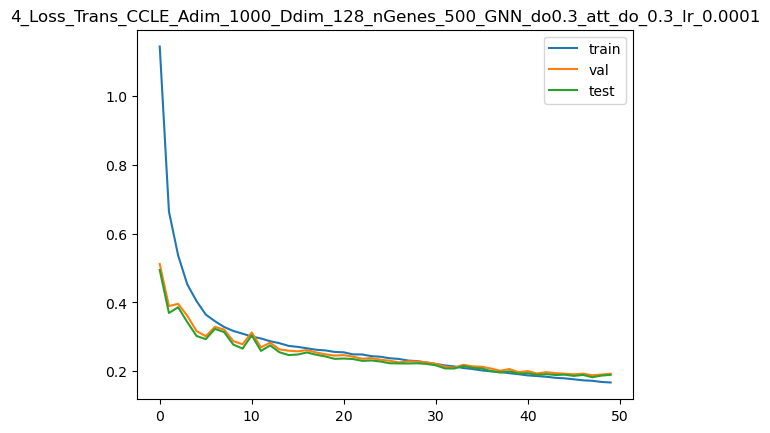

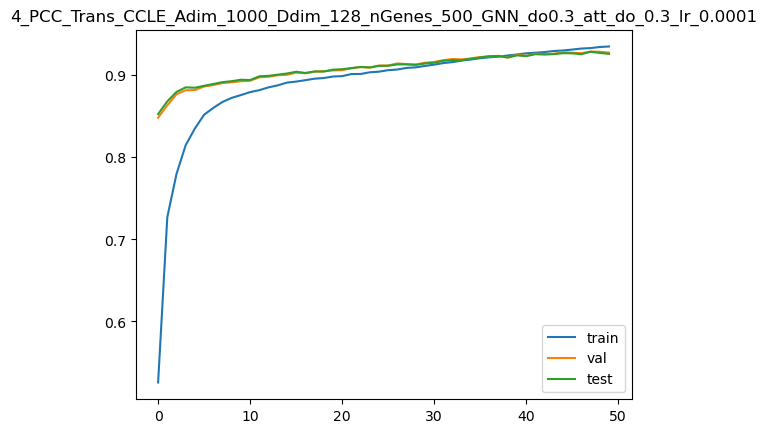

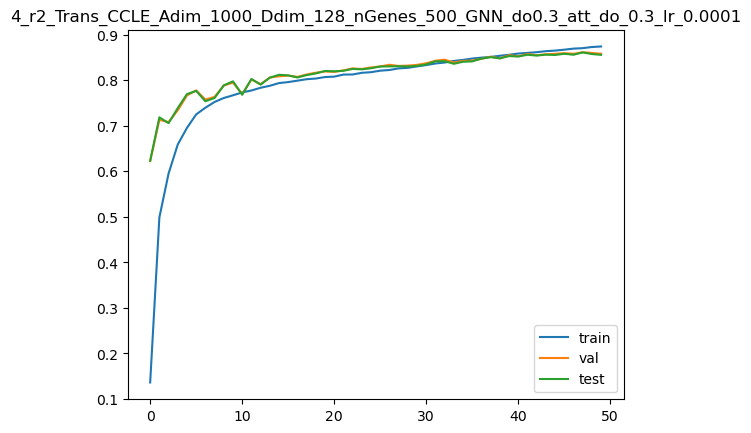

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13886946439743042
The overall Pearson's correlation is 0.9370.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1359127312898636
The overall Pearson's correlation is 0.9493.
Train avg_loss:  0.16520776
Train avg_pcc:  0.93561275587049
Train r2:  0.8753643639730878


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18820089
Validation avg_pcc:  0.9291858734794869
Validation r2:  0.8612145299131673


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1854494
Test avg_pcc:  0.927572457751811
Test r2:  0.8585921614299904
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22253675758838654
The overall Pearson's correlation is 0.9166.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23613163828849792
The overall Pearson's correlation is 0.9144.
Train avg_loss:  0.1639504
Train avg_pcc:  0.9361196664096272
Train r2:  0.8763129183461283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19180861
Validation avg_pcc:  0.9289207647908878
Validation r2:  0.8585540908416825


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1876673
Test avg_pcc:  0.9275415967067141
Test r2:  0.8569009730253303
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15423384308815002
The overall Pearson's correlation is 0.9424.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19493579864501953
The overall Pearson's correlation is 0.9118.
Train avg_loss:  0.16176654
Train avg_pcc:  0.9369993993971094
Train r2:  0.8779604560951676


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18525624
Validation avg_pcc:  0.9307962060470364
Validation r2:  0.8633860154067252
Best Val r2  0.8633860154067252


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18189564
Test avg_pcc:  0.9296066153390065
Test r2:  0.861301948462384
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10076385736465454
The overall Pearson's correlation is 0.9684.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14737960696220398
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.1595581
Train avg_pcc:  0.9378885526920604
Train r2:  0.87962656474281


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18487515
Validation avg_pcc:  0.9311212852901625
Validation r2:  0.8636670596158592
Best Val r2  0.8636670596158592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18170711
Test avg_pcc:  0.9298073463008334
Test r2:  0.8614457132494224
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12866444885730743
The overall Pearson's correlation is 0.9351.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1388876736164093
The overall Pearson's correlation is 0.9360.
Train avg_loss:  0.15866771
Train avg_pcc:  0.9382456768675442
Train r2:  0.8802982797724498


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1816376
Validation avg_pcc:  0.9308855957529043
Validation r2:  0.8660545149859543
Best Val r2  0.8660545149859543


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1762253
Test avg_pcc:  0.9305189585672745
Test r2:  0.8656256713649196
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1852981150150299
The overall Pearson's correlation is 0.9288.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22605100274085999
The overall Pearson's correlation is 0.8868.
Train avg_loss:  0.1567615
Train avg_pcc:  0.9390120126682289
Train r2:  0.8817363618941313


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18062195
Validation avg_pcc:  0.9313797827320541
Validation r2:  0.8668034973121532
Best Val r2  0.8668034973121532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17712404
Test avg_pcc:  0.930383839655574
Test r2:  0.8649403687856754
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14073342084884644
The overall Pearson's correlation is 0.9225.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14154386520385742
The overall Pearson's correlation is 0.9540.
Train avg_loss:  0.15459496
Train avg_pcc:  0.9398818206000575
Train r2:  0.8833708421195439


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1824507
Validation avg_pcc:  0.9314211285791759
Validation r2:  0.8654549350588489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1785475
Test avg_pcc:  0.9306606975156948
Test r2:  0.8638549524563564
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17370161414146423
The overall Pearson's correlation is 0.9173.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11806531250476837
The overall Pearson's correlation is 0.9573.
Train avg_loss:  0.15373243
Train avg_pcc:  0.940227939549646
Train r2:  0.8840215336400783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18197532
Validation avg_pcc:  0.9309393892679461
Validation r2:  0.8658054842074158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17652585
Test avg_pcc:  0.9306078434885138
Test r2:  0.8653964909576953
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15385963022708893
The overall Pearson's correlation is 0.9393.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15736067295074463
The overall Pearson's correlation is 0.9512.
Train avg_loss:  0.15280896
Train avg_pcc:  0.9405986904992832
Train r2:  0.8847182206268922


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18164414
Validation avg_pcc:  0.9312117153040151
Validation r2:  0.8660496981763011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.176386
Test avg_pcc:  0.9308512230025208
Test r2:  0.865503130150227
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15376488864421844
The overall Pearson's correlation is 0.9560.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17838388681411743
The overall Pearson's correlation is 0.9508.
Train avg_loss:  0.14942254
Train avg_pcc:  0.9419559396419886
Train r2:  0.8872729934817378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1799712
Validation avg_pcc:  0.9321935463460067
Validation r2:  0.867283396165247
Best Val r2  0.867283396165247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17421947
Test avg_pcc:  0.9318668872543235
Test r2:  0.8671551379857807
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14570890367031097
The overall Pearson's correlation is 0.8847.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12722457945346832
The overall Pearson's correlation is 0.9311.
Train avg_loss:  0.14859353
Train avg_pcc:  0.9422867231817018
Train r2:  0.8878984091800011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18327133
Validation avg_pcc:  0.9301963536935793
Validation r2:  0.8648497655671488


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17762566
Test avg_pcc:  0.9299131177830459
Test r2:  0.8645578746845155
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12196198850870132
The overall Pearson's correlation is 0.9651.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1323387771844864
The overall Pearson's correlation is 0.9469.
Train avg_loss:  0.14787555
Train avg_pcc:  0.9425749784438727
Train r2:  0.8884400810682213


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17981692
Validation avg_pcc:  0.9320022804082756
Validation r2:  0.8673971577703694
Best Val r2  0.8673971577703694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17479074
Test avg_pcc:  0.9314945081712664
Test r2:  0.8667195559338423
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20756003260612488
The overall Pearson's correlation is 0.9346.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21017922461032867
The overall Pearson's correlation is 0.8988.
Train avg_loss:  0.14562333
Train avg_pcc:  0.9434760004255252
Train r2:  0.8901391957222902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17780568
Validation avg_pcc:  0.9328897479308655
Validation r2:  0.8688803143535748
Best Val r2  0.8688803143535748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17303805
Test avg_pcc:  0.9323136142305267
Test r2:  0.8680559967885734
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.204879492521286
The overall Pearson's correlation is 0.9113.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18251362442970276
The overall Pearson's correlation is 0.9488.
Train avg_loss:  0.14453383
Train avg_pcc:  0.9439108885758711
Train r2:  0.8909611292325834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1772354
Validation avg_pcc:  0.9330152184786217
Validation r2:  0.8693008552307109
Best Val r2  0.8693008552307109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1730737
Test avg_pcc:  0.9321414803293734
Test r2:  0.8680288170490282
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13960714638233185
The overall Pearson's correlation is 0.9347.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12556952238082886
The overall Pearson's correlation is 0.9673.
Train avg_loss:  0.14353801
Train avg_pcc:  0.9443087398391035
Train r2:  0.8917123886808929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17667395
Validation avg_pcc:  0.9330723743922197
Validation r2:  0.8697148890378619
Best Val r2  0.8697148890378619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17313664
Test avg_pcc:  0.9321826778643837
Test r2:  0.8679808118960359
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16525322198867798
The overall Pearson's correlation is 0.9343.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15891093015670776
The overall Pearson's correlation is 0.9472.
Train avg_loss:  0.14190446
Train avg_pcc:  0.9449625813097003
Train r2:  0.8929447702787269


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18023367
Validation avg_pcc:  0.9324168586113301
Validation r2:  0.8670898337386905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17359202
Test avg_pcc:  0.9325906094276578
Test r2:  0.8676335881866835
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11142654716968536
The overall Pearson's correlation is 0.9714.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17338517308235168
The overall Pearson's correlation is 0.9481.
Train avg_loss:  0.14114885
Train avg_pcc:  0.9452620938041758
Train r2:  0.893514810068386


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17887272
Validation avg_pcc:  0.9318622908158883
Validation r2:  0.8680934479212767


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17232691
Test avg_pcc:  0.9321929971882518
Test r2:  0.8685982484824583
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.136202871799469
The overall Pearson's correlation is 0.9539.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17271044850349426
The overall Pearson's correlation is 0.9414.
Train avg_loss:  0.13852356
Train avg_pcc:  0.9463090276010159
Train r2:  0.8954953678321405


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17679265
Validation avg_pcc:  0.9339157102938347
Validation r2:  0.8696273482203792


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17111228
Test avg_pcc:  0.9335711036562577
Test r2:  0.869524413645104
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14835837483406067
The overall Pearson's correlation is 0.9372.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10527577996253967
The overall Pearson's correlation is 0.9520.
Train avg_loss:  0.1383699
Train avg_pcc:  0.9463715472806921
Train r2:  0.8956112975852623


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.180335
Validation avg_pcc:  0.9327195378583162
Validation r2:  0.8670151059734253


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17312963
Test avg_pcc:  0.9330190430343402
Test r2:  0.8679861558761658
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.172646626830101
The overall Pearson's correlation is 0.9262.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14312070608139038
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.1376395
Train avg_pcc:  0.9466613503849373
Train r2:  0.8961623262604342


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17772274
Validation avg_pcc:  0.9326369571462361
Validation r2:  0.8689414696287019


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17108743
Test avg_pcc:  0.9328481995778062
Test r2:  0.8695433802710947
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12892964482307434
The overall Pearson's correlation is 0.9551.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15316732227802277
The overall Pearson's correlation is 0.9502.
Train avg_loss:  0.13563654
Train avg_pcc:  0.9474593042755003
Train r2:  0.8976733992105408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17676818
Validation avg_pcc:  0.9332585830555378
Validation r2:  0.8696453902343544


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1686634
Test avg_pcc:  0.9340419403275984
Test r2:  0.8713917290978868
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08441975712776184
The overall Pearson's correlation is 0.9652.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10970180481672287
The overall Pearson's correlation is 0.9433.
Train avg_loss:  0.13410613
Train avg_pcc:  0.9480692373576947
Train r2:  0.8988279622414133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17999353
Validation avg_pcc:  0.9315238775580118
Validation r2:  0.867266930048962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17265789
Test avg_pcc:  0.9320349774197315
Test r2:  0.8683458846786045
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12886279821395874
The overall Pearson's correlation is 0.9622.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10158570110797882
The overall Pearson's correlation is 0.9583.
Train avg_loss:  0.13287498
Train avg_pcc:  0.948558503393673
Train r2:  0.8997567898512089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17517704
Validation avg_pcc:  0.9337459386466256
Validation r2:  0.8708187537094183
Best Val r2  0.8708187537094183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16799943
Test avg_pcc:  0.9341988891643139
Test r2:  0.8718980148197479
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11335206031799316
The overall Pearson's correlation is 0.9438.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10041816532611847
The overall Pearson's correlation is 0.9444.
Train avg_loss:  0.13228448
Train avg_pcc:  0.9487924857225568
Train r2:  0.9002022493689947


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17235097
Validation avg_pcc:  0.9345188695181774
Validation r2:  0.8729027922655974
Best Val r2  0.8729027922655974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16837421
Test avg_pcc:  0.9337343325126513
Test r2:  0.8716122445964233
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09211188554763794
The overall Pearson's correlation is 0.9584.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14757588505744934
The overall Pearson's correlation is 0.9423.
Train avg_loss:  0.13093363
Train avg_pcc:  0.9493307435810321
Train r2:  0.9012213595456038


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17572443
Validation avg_pcc:  0.9348596948400238
Validation r2:  0.8704150908536665


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16942921
Test avg_pcc:  0.9345975772518518
Test r2:  0.8708077850708983
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12415968626737595
The overall Pearson's correlation is 0.9539.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16872470080852509
The overall Pearson's correlation is 0.9343.
Train avg_loss:  0.13022985
Train avg_pcc:  0.9496095801630096
Train r2:  0.9017523079523222


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1752678
Validation avg_pcc:  0.933833741518902
Validation r2:  0.8707518248632555


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16793229
Test avg_pcc:  0.934320581895905
Test r2:  0.8719492143286219
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16028790175914764
The overall Pearson's correlation is 0.9368.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12020625919103622
The overall Pearson's correlation is 0.9602.
Train avg_loss:  0.12901312
Train avg_pcc:  0.950093478583185
Train r2:  0.9026702267406512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17509043
Validation avg_pcc:  0.9339051193416069
Validation r2:  0.8708826141189321


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16969188
Test avg_pcc:  0.9336142984773005
Test r2:  0.8706075028868029
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10160177946090698
The overall Pearson's correlation is 0.9566.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14135806262493134
The overall Pearson's correlation is 0.9332.
Train avg_loss:  0.12772581
Train avg_pcc:  0.9506034913308373
Train r2:  0.903641395011229


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1737747
Validation avg_pcc:  0.9347076737983915
Validation r2:  0.8718528808028227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16770448
Test avg_pcc:  0.9346051941287358
Test r2:  0.8721229221019663
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10244155675172806
The overall Pearson's correlation is 0.9682.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0911984071135521
The overall Pearson's correlation is 0.9748.
Train avg_loss:  0.12769644
Train avg_pcc:  0.9506155164756267
Train r2:  0.9036635713599206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17269833
Validation avg_pcc:  0.9355463105629925
Validation r2:  0.8726466323079962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16853736
Test avg_pcc:  0.9347797216341784
Test r2:  0.8714878338302001
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15476715564727783
The overall Pearson's correlation is 0.9467.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14754727482795715
The overall Pearson's correlation is 0.9437.
Train avg_loss:  0.12648456
Train avg_pcc:  0.9510964895289906
Train r2:  0.9045778206967395


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17415541
Validation avg_pcc:  0.9357239878747933
Validation r2:  0.8715721316692863


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16671988
Test avg_pcc:  0.9360471072679626
Test r2:  0.8728736963156795
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12188360095024109
The overall Pearson's correlation is 0.9584.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13060426712036133
The overall Pearson's correlation is 0.9429.
Train avg_loss:  0.12510285
Train avg_pcc:  0.9516444518546028
Train r2:  0.9056202098050847


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17334619
Validation avg_pcc:  0.9347516515563743
Validation r2:  0.8721688820485536


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1668076
Test avg_pcc:  0.9348221283562912
Test r2:  0.8728067932146042
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1433093249797821
The overall Pearson's correlation is 0.9557.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12479281425476074
The overall Pearson's correlation is 0.9601.
Train avg_loss:  0.12352325
Train avg_pcc:  0.9522690606189733
Train r2:  0.9068118753251444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17384729
Validation avg_pcc:  0.9354237669775556
Validation r2:  0.8717993593968508


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16726802
Test avg_pcc:  0.9356724093082708
Test r2:  0.8724557284000871
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12921172380447388
The overall Pearson's correlation is 0.9303.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1208825558423996
The overall Pearson's correlation is 0.9548.
Train avg_loss:  0.12275567
Train avg_pcc:  0.9525740847333927
Train r2:  0.9073909504371072


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17318963
Validation avg_pcc:  0.9358081638160094
Validation r2:  0.8722843332461353


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16646439
Test avg_pcc:  0.9362406722397706
Test r2:  0.8730685119099042
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10779744386672974
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10778893530368805
The overall Pearson's correlation is 0.9601.
Train avg_loss:  0.12144669
Train avg_pcc:  0.9530921520165756
Train r2:  0.908378472852619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17258891
Validation avg_pcc:  0.9351629999058438
Validation r2:  0.8727273299499473


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16623479
Test avg_pcc:  0.9351826236261053
Test r2:  0.8732435806163212
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13776548206806183
The overall Pearson's correlation is 0.9368.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1588663011789322
The overall Pearson's correlation is 0.9501.
Train avg_loss:  0.121845335
Train avg_pcc:  0.9529341771513408
Train r2:  0.9080777249127207


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17324807
Validation avg_pcc:  0.9348804880906101
Validation r2:  0.8722412448463621


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.166529
Test avg_pcc:  0.9351962305676913
Test r2:  0.8730192412119613
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10506781935691833
The overall Pearson's correlation is 0.9672.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13747623562812805
The overall Pearson's correlation is 0.9521.
Train avg_loss:  0.12046026
Train avg_pcc:  0.953482566525426
Train r2:  0.9091226555589856


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17260765
Validation avg_pcc:  0.9346433610140349
Validation r2:  0.8727135020345008


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16571763
Test avg_pcc:  0.9349157042464058
Test r2:  0.8736379237715217
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12307849526405334
The overall Pearson's correlation is 0.9335.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12621863186359406
The overall Pearson's correlation is 0.9439.
Train avg_loss:  0.11984004
Train avg_pcc:  0.9537274111310812
Train r2:  0.9095905498609169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17186433
Validation avg_pcc:  0.9346873899128973
Validation r2:  0.873261654288015
Best Val r2  0.873261654288015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16696627
Test avg_pcc:  0.9342583581641681
Test r2:  0.8726858200744732
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09250697493553162
The overall Pearson's correlation is 0.9565.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12210223078727722
The overall Pearson's correlation is 0.9416.
Train avg_loss:  0.11867084
Train avg_pcc:  0.9541886283824003
Train r2:  0.9104726122335064


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17124285
Validation avg_pcc:  0.9360330301690907
Validation r2:  0.8737199674989821
Best Val r2  0.8737199674989821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16612624
Test avg_pcc:  0.9357760375484755
Test r2:  0.8733263572915957
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08959966897964478
The overall Pearson's correlation is 0.9431.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12399591505527496
The overall Pearson's correlation is 0.9563.
Train avg_loss:  0.118001595
Train avg_pcc:  0.9544553865850371
Train r2:  0.9109775112921428


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16883665
Validation avg_pcc:  0.9366984493721033
Validation r2:  0.8754943619454896
Best Val r2  0.8754943619454896


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16349973
Test avg_pcc:  0.9363151037307169
Test r2:  0.8753291025673942
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10888901352882385
The overall Pearson's correlation is 0.9548.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1353519707918167
The overall Pearson's correlation is 0.9547.
Train avg_loss:  0.11675771
Train avg_pcc:  0.954945191866547
Train r2:  0.9119159177287561


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16986653
Validation avg_pcc:  0.9360066980841584
Validation r2:  0.8747348999248632


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16452613
Test avg_pcc:  0.9358312882832233
Test r2:  0.874546445111847
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13201904296875
The overall Pearson's correlation is 0.9505.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13223806023597717
The overall Pearson's correlation is 0.9525.
Train avg_loss:  0.116659574
Train avg_pcc:  0.9549857659701474
Train r2:  0.9119899580892072


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1729371
Validation avg_pcc:  0.9361284237136415
Validation r2:  0.8724705531952627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16554122
Test avg_pcc:  0.9365318334615583
Test r2:  0.8737724375694012
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10080654174089432
The overall Pearson's correlation is 0.9693.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13684485852718353
The overall Pearson's correlation is 0.9243.
Train avg_loss:  0.11525391
Train avg_pcc:  0.9555391268459635
Train r2:  0.9130504133348895


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17203286
Validation avg_pcc:  0.9356688341720388
Validation r2:  0.8731373827939015


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16578314
Test avg_pcc:  0.9356154556652532
Test r2:  0.8735879860385987
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11679650843143463
The overall Pearson's correlation is 0.9655.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11080446094274521
The overall Pearson's correlation is 0.9622.
Train avg_loss:  0.11467844
Train avg_pcc:  0.9557673721032539
Train r2:  0.9134845582924578


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17815733
Validation avg_pcc:  0.9347942797764014
Validation r2:  0.8686209896895667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17140289
Test avg_pcc:  0.9350678486185229
Test r2:  0.8693028323247189
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09955459833145142
The overall Pearson's correlation is 0.9632.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13410602509975433
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.113836065
Train avg_pcc:  0.9560991531577339
Train r2:  0.9141200728973263


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16980873
Validation avg_pcc:  0.9370655121240306
Validation r2:  0.8747775233132022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1619745
Test avg_pcc:  0.937701668418961
Test r2:  0.8764921012525029
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10200942307710648
The overall Pearson's correlation is 0.9641.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1376955658197403
The overall Pearson's correlation is 0.9452.
Train avg_loss:  0.11322948
Train avg_pcc:  0.9563385877522241
Train r2:  0.9145776647571311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17009656
Validation avg_pcc:  0.9360964743950073
Validation r2:  0.8745652593119815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1624173
Test avg_pcc:  0.9366460422777042
Test r2:  0.8761544630554264
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10137799382209778
The overall Pearson's correlation is 0.9576.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16379176080226898
The overall Pearson's correlation is 0.9353.
Train avg_loss:  0.11252258
Train avg_pcc:  0.956617159637712
Train r2:  0.9151109694838327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16782176
Validation avg_pcc:  0.9367481089401106
Validation r2:  0.8762427717273609
Best Val r2  0.8762427717273609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16011532
Test avg_pcc:  0.9374165256824628
Test r2:  0.8779097826109359
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09472042322158813
The overall Pearson's correlation is 0.9579.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09520430862903595
The overall Pearson's correlation is 0.9587.
Train avg_loss:  0.11078081
Train avg_pcc:  0.9573041038263429
Train r2:  0.9164250135851751


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17126943
Validation avg_pcc:  0.9366231773149023
Validation r2:  0.8737003466235718


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16328333
Test avg_pcc:  0.9373416592844039
Test r2:  0.8754941049705993
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10765713453292847
The overall Pearson's correlation is 0.9541.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07162076234817505
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.11036953
Train avg_pcc:  0.9574653502574025
Train r2:  0.916735275565004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17063937
Validation avg_pcc:  0.9356538963734228
Validation r2:  0.8741649806876661


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1628262
Test avg_pcc:  0.936367176174284
Test r2:  0.8758426783325343
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11472997069358826
The overall Pearson's correlation is 0.9540.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09326403588056564
The overall Pearson's correlation is 0.9680.
Train avg_loss:  0.11001999
Train avg_pcc:  0.9576031316939424
Train r2:  0.9169989698039357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16979013
Validation avg_pcc:  0.9363863437134385
Validation r2:  0.8747912312828867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16179787
Test avg_pcc:  0.9371167369341245
Test r2:  0.8766268052505681
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15990149974822998
The overall Pearson's correlation is 0.9326.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08265814185142517
The overall Pearson's correlation is 0.9724.
Train avg_loss:  0.11026954
Train avg_pcc:  0.9575055085698716
Train r2:  0.9168107125962319


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16954663
Validation avg_pcc:  0.9360098216112213
Validation r2:  0.8749708060707696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16248015
Test avg_pcc:  0.936368221446305
Test r2:  0.8761065434085353


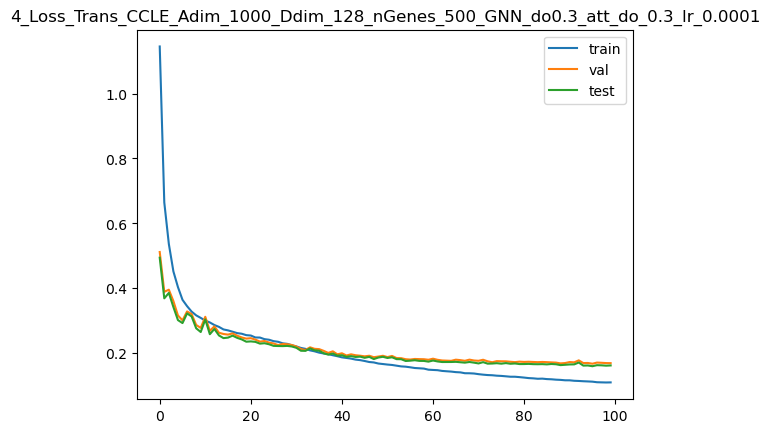

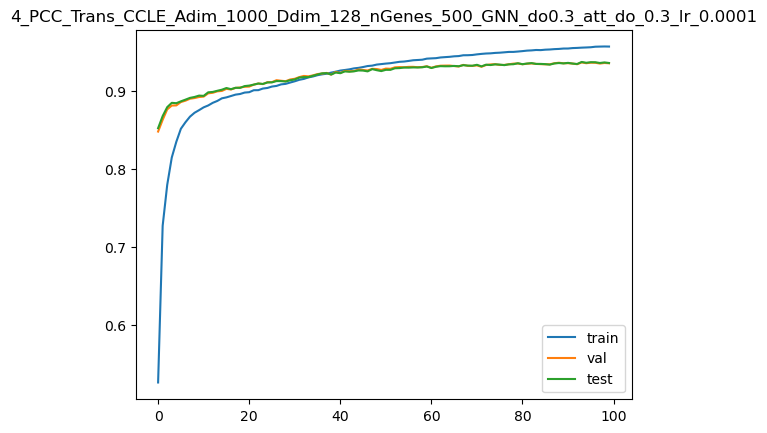

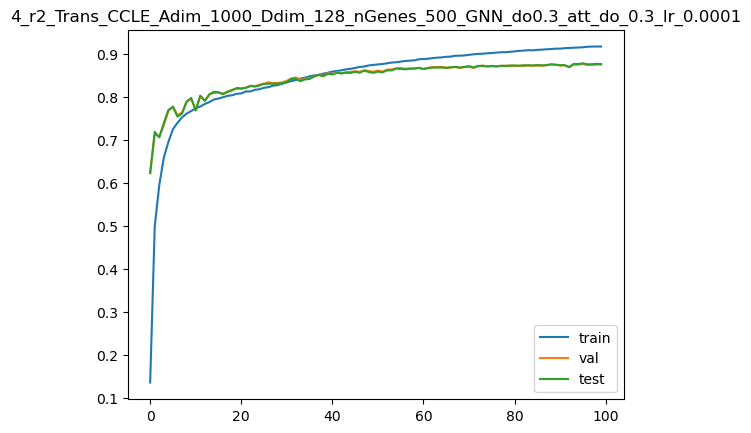

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09916351735591888
The overall Pearson's correlation is 0.9402.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12241481244564056
The overall Pearson's correlation is 0.9610.
Train avg_loss:  0.108853154
Train avg_pcc:  0.958063012360238
Train r2:  0.9178792605595489


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16865492
Validation avg_pcc:  0.9367860742326187
Validation r2:  0.8756283750307566


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.161337
Test avg_pcc:  0.9373135362035605
Test r2:  0.8769782150421459
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11898668110370636
The overall Pearson's correlation is 0.9465.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.130634605884552
The overall Pearson's correlation is 0.9364.
Train avg_loss:  0.10790738
Train avg_pcc:  0.9584351378655526
Train r2:  0.9185927723407258


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16674988
Validation avg_pcc:  0.9370836529759184
Validation r2:  0.8770332174861106
Best Val r2  0.8770332174861106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16098855
Test avg_pcc:  0.9370524674919553
Test r2:  0.8772439040886705
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11185134202241898
The overall Pearson's correlation is 0.9618.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14050081372261047
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.107015945
Train avg_pcc:  0.9587858712008394
Train r2:  0.9192652824385124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16808371
Validation avg_pcc:  0.9367197705849435
Validation r2:  0.8760496086244532


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16083807
Test avg_pcc:  0.9372495516473812
Test r2:  0.8773586521481893
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11916123330593109
The overall Pearson's correlation is 0.9547.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12787507474422455
The overall Pearson's correlation is 0.9419.
Train avg_loss:  0.106807224
Train avg_pcc:  0.9588690159641319
Train r2:  0.9194227388845904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17305133
Validation avg_pcc:  0.9359979506657472
Validation r2:  0.8723863317820444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16522355
Test avg_pcc:  0.9365205868129272
Test r2:  0.8740146604375352
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08764674514532089
The overall Pearson's correlation is 0.9594.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.062295831739902496
The overall Pearson's correlation is 0.9794.
Train avg_loss:  0.10562838
Train avg_pcc:  0.959331315839333
Train r2:  0.9203120797826112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16710992
Validation avg_pcc:  0.9369623470747944
Validation r2:  0.8767677034521659


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16145638
Test avg_pcc:  0.9368383401104513
Test r2:  0.8768871928395826
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09206143766641617
The overall Pearson's correlation is 0.9493.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09301313757896423
The overall Pearson's correlation is 0.9567.
Train avg_loss:  0.106525786
Train avg_pcc:  0.9589790972423127
Train r2:  0.9196350572935201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1684309
Validation avg_pcc:  0.9368685216694933
Validation r2:  0.8757935728278177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15976292
Test avg_pcc:  0.9378910773890813
Test r2:  0.8781784743068257
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12709513306617737
The overall Pearson's correlation is 0.9515.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1458113193511963
The overall Pearson's correlation is 0.9510.
Train avg_loss:  0.10398485
Train avg_pcc:  0.9599769213203821
Train r2:  0.921551997251613


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1703628
Validation avg_pcc:  0.9365500565304992
Validation r2:  0.8743689258834877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1637328
Test avg_pcc:  0.9367142207377603
Test r2:  0.8751513851718093
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08224788308143616
The overall Pearson's correlation is 0.9698.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07842439413070679
The overall Pearson's correlation is 0.9733.
Train avg_loss:  0.10386759
Train avg_pcc:  0.9600239734983766
Train r2:  0.9216404603835435


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16692822
Validation avg_pcc:  0.936812128521149
Validation r2:  0.8769016931275458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.160138
Test avg_pcc:  0.9372100460877233
Test r2:  0.8778924666950061
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1084335446357727
The overall Pearson's correlation is 0.9614.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08216939866542816
The overall Pearson's correlation is 0.9677.
Train avg_loss:  0.104001135
Train avg_pcc:  0.9599712108788645
Train r2:  0.9215397125359654


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17405894
Validation avg_pcc:  0.935467861085397
Validation r2:  0.8716432879747534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16618186
Test avg_pcc:  0.9360572305381604
Test r2:  0.8732839463738715
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08649162948131561
The overall Pearson's correlation is 0.9621.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10780481994152069
The overall Pearson's correlation is 0.9500.
Train avg_loss:  0.10311895
Train avg_pcc:  0.9603173873798995
Train r2:  0.922205242682082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16709603
Validation avg_pcc:  0.9372016481408751
Validation r2:  0.8767779607742189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16054875
Test avg_pcc:  0.9374563723949931
Test r2:  0.8775792753091469
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09606176614761353
The overall Pearson's correlation is 0.9651.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12442564964294434
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.103221506
Train avg_pcc:  0.9602780977397805
Train r2:  0.922127873517334


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16577668
Validation avg_pcc:  0.9378892898927856
Validation r2:  0.8777508789662644
Best Val r2  0.8777508789662644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15833497
Test avg_pcc:  0.9384401038028573
Test r2:  0.8792673083259925
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08980771154165268
The overall Pearson's correlation is 0.9619.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08770450949668884
The overall Pearson's correlation is 0.9649.
Train avg_loss:  0.1014728
Train avg_pcc:  0.9609636946234442
Train r2:  0.9234471295508231


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17100063
Validation avg_pcc:  0.9363909369621807
Validation r2:  0.8738985700994877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16275875
Test avg_pcc:  0.9373514548959637
Test r2:  0.8758941042192366
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09202724695205688
The overall Pearson's correlation is 0.9594.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11196929216384888
The overall Pearson's correlation is 0.9610.
Train avg_loss:  0.10135765
Train avg_pcc:  0.9610094679841088
Train r2:  0.923534001865834


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16824487
Validation avg_pcc:  0.9380451439703901
Validation r2:  0.8759307564491469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1620591
Test avg_pcc:  0.9380870997639592
Test r2:  0.8764276057700356
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09853676706552505
The overall Pearson's correlation is 0.9562.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12365752458572388
The overall Pearson's correlation is 0.9310.
Train avg_loss:  0.10132091
Train avg_pcc:  0.9610238956119963
Train r2:  0.923561714362809


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16824923
Validation avg_pcc:  0.9370655118852755
Validation r2:  0.8759275456323458


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16080505
Test avg_pcc:  0.9377283904899336
Test r2:  0.8773838292260971
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12866878509521484
The overall Pearson's correlation is 0.9497.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06576735526323318
The overall Pearson's correlation is 0.9790.
Train avg_loss:  0.099859096
Train avg_pcc:  0.9615970268558074
Train r2:  0.9246645358268448


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16603601
Validation avg_pcc:  0.9372589966881871
Validation r2:  0.8775596491638967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15934584
Test avg_pcc:  0.9376302592976019
Test r2:  0.8784965100728321
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09488721191883087
The overall Pearson's correlation is 0.9535.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1476210504770279
The overall Pearson's correlation is 0.9428.
Train avg_loss:  0.09881656
Train avg_pcc:  0.9620060185040533
Train r2:  0.9254510402843822


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16497028
Validation avg_pcc:  0.937958074387077
Validation r2:  0.8783455414762082
Best Val r2  0.8783455414762082


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15619957
Test avg_pcc:  0.9391736341103556
Test r2:  0.8808955734847442
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10496949404478073
The overall Pearson's correlation is 0.9541.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09421127289533615
The overall Pearson's correlation is 0.9674.
Train avg_loss:  0.09935326
Train avg_pcc:  0.9617955804557028
Train r2:  0.9250461463024177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16976096
Validation avg_pcc:  0.9361234672928233
Validation r2:  0.8748127568431123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16072004
Test avg_pcc:  0.9373638663985402
Test r2:  0.8774486650179423
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07888656854629517
The overall Pearson's correlation is 0.9705.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07330615818500519
The overall Pearson's correlation is 0.9743.
Train avg_loss:  0.09885708
Train avg_pcc:  0.9619902177026534
Train r2:  0.9254204763583974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16559817
Validation avg_pcc:  0.9377988473230818
Validation r2:  0.8778825234587333


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15800337
Test avg_pcc:  0.9384849439237438
Test r2:  0.8795201588282102
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08836062252521515
The overall Pearson's correlation is 0.9671.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13922689855098724
The overall Pearson's correlation is 0.9394.
Train avg_loss:  0.09783951
Train avg_pcc:  0.9623888786924509
Train r2:  0.9261881454654662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17063534
Validation avg_pcc:  0.9359267689379838
Validation r2:  0.8741679410047478


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16264132
Test avg_pcc:  0.9367021242916197
Test r2:  0.8759836526820102
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10767114162445068
The overall Pearson's correlation is 0.9658.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13200557231903076
The overall Pearson's correlation is 0.9290.
Train avg_loss:  0.09795633
Train avg_pcc:  0.9623429366983282
Train r2:  0.9261000219885293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16725598
Validation avg_pcc:  0.9367559991146638
Validation r2:  0.8766599963555886


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15984629
Test avg_pcc:  0.937390055766001
Test r2:  0.8781149015193983
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2097337394952774
The overall Pearson's correlation is 0.9523.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07209423929452896
The overall Pearson's correlation is 0.9715.
Train avg_loss:  0.09747867
Train avg_pcc:  0.9625309855451277
Train r2:  0.9264603657210994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16979435
Validation avg_pcc:  0.9376430680897034
Validation r2:  0.8747881234455467


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16219974
Test avg_pcc:  0.9380698610807942
Test r2:  0.8763203640429051
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13765111565589905
The overall Pearson's correlation is 0.9406.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1480608731508255
The overall Pearson's correlation is 0.9341.
Train avg_loss:  0.0960967
Train avg_pcc:  0.9630719707112075
Train r2:  0.927502949078396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17009081
Validation avg_pcc:  0.9360544825366575
Validation r2:  0.8745695024904379


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16013302
Test avg_pcc:  0.9376504444652556
Test r2:  0.8778962640268125
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10013989359140396
The overall Pearson's correlation is 0.9654.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06499963998794556
The overall Pearson's correlation is 0.9741.
Train avg_loss:  0.09553571
Train avg_pcc:  0.963291535206419
Train r2:  0.9279261704545835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16808246
Validation avg_pcc:  0.9374694955504846
Validation r2:  0.8760505254300401


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16058034
Test avg_pcc:  0.9379432250951222
Test r2:  0.8775551812475559
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07965452969074249
The overall Pearson's correlation is 0.9634.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1053147166967392
The overall Pearson's correlation is 0.9691.
Train avg_loss:  0.09569783
Train avg_pcc:  0.9632277138737231
Train r2:  0.92780387134063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1678235
Validation avg_pcc:  0.9368519660360793
Validation r2:  0.8762414888615125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15873684
Test avg_pcc:  0.938118390874726
Test r2:  0.8789608714261867
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07746651768684387
The overall Pearson's correlation is 0.9759.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07058209180831909
The overall Pearson's correlation is 0.9757.
Train avg_loss:  0.09538837
Train avg_pcc:  0.9633490637971835
Train r2:  0.9280373318763743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16944669
Validation avg_pcc:  0.9365942969003717
Validation r2:  0.8750444970061299


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16115764
Test avg_pcc:  0.937492727300067
Test r2:  0.8771149771841094
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08600913733243942
The overall Pearson's correlation is 0.9690.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09887340664863586
The overall Pearson's correlation is 0.9624.
Train avg_loss:  0.095008254
Train avg_pcc:  0.9634987550370583
Train r2:  0.9283240934113177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1674164
Validation avg_pcc:  0.9377290989714727
Validation r2:  0.8765417122803627


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15939051
Test avg_pcc:  0.9385364049795907
Test r2:  0.8784624333841913
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08296096324920654
The overall Pearson's correlation is 0.9608.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10860027372837067
The overall Pearson's correlation is 0.9609.
Train avg_loss:  0.094014406
Train avg_pcc:  0.9638868112004726
Train r2:  0.9290738642887254


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16790284
Validation avg_pcc:  0.9376666757243647
Validation r2:  0.8761829768738629


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1604473
Test avg_pcc:  0.9381930702717272
Test r2:  0.8776566205504603
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11617228388786316
The overall Pearson's correlation is 0.9574.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0892571359872818
The overall Pearson's correlation is 0.9466.
Train avg_loss:  0.09438634
Train avg_pcc:  0.9637416369549135
Train r2:  0.9287932847528266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16789956
Validation avg_pcc:  0.9374835457556088
Validation r2:  0.8761854066866257


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16064909
Test avg_pcc:  0.9379339909794402
Test r2:  0.8775027611210232
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07407636940479279
The overall Pearson's correlation is 0.9770.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11342962831258774
The overall Pearson's correlation is 0.9643.
Train avg_loss:  0.09371678
Train avg_pcc:  0.9640036111052451
Train r2:  0.9292984104669738


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16790473
Validation avg_pcc:  0.938341556409202
Validation r2:  0.876181585012599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15970129
Test avg_pcc:  0.9391759025768893
Test r2:  0.8782254713535655
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07081526517868042
The overall Pearson's correlation is 0.9700.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07015256583690643
The overall Pearson's correlation is 0.9658.
Train avg_loss:  0.0935188
Train avg_pcc:  0.964081084814619
Train r2:  0.9294477710850735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16825095
Validation avg_pcc:  0.9379439795434262
Validation r2:  0.8759262759686419


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15952377
Test avg_pcc:  0.9389978135802501
Test r2:  0.8783608223920261
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05387895554304123
The overall Pearson's correlation is 0.9814.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0998908281326294
The overall Pearson's correlation is 0.9532.
Train avg_loss:  0.09281757
Train avg_pcc:  0.9643553377817742
Train r2:  0.9299767871729931


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16760421
Validation avg_pcc:  0.9380748624945815
Validation r2:  0.8764032163782821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15973578
Test avg_pcc:  0.9388062505008358
Test r2:  0.878199166630803
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12178480625152588
The overall Pearson's correlation is 0.9557.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07529851794242859
The overall Pearson's correlation is 0.9631.
Train avg_loss:  0.09278607
Train avg_pcc:  0.9643675563835817
Train r2:  0.9300005494402482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16990697
Validation avg_pcc:  0.9368172314146151
Validation r2:  0.8747050746440778


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16276988
Test avg_pcc:  0.9371918256582887
Test r2:  0.8758856149058369
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0939100980758667
The overall Pearson's correlation is 0.9684.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09484603255987167
The overall Pearson's correlation is 0.9724.
Train avg_loss:  0.0920981
Train avg_pcc:  0.9646368518473767
Train r2:  0.9305195670098086


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16644983
Validation avg_pcc:  0.9378324042544939
Validation r2:  0.8772544711398228


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15841791
Test avg_pcc:  0.9387759349366547
Test r2:  0.8792040630183006
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08355941623449326
The overall Pearson's correlation is 0.9683.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1108737587928772
The overall Pearson's correlation is 0.9599.
Train avg_loss:  0.09180861
Train avg_pcc:  0.9647504008584897
Train r2:  0.9307379564680468


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1664879
Validation avg_pcc:  0.9379095750251064
Validation r2:  0.8772263935406441


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15894935
Test avg_pcc:  0.9385601767258256
Test r2:  0.8787988362367282
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0822150707244873
The overall Pearson's correlation is 0.9566.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07015995681285858
The overall Pearson's correlation is 0.9660.
Train avg_loss:  0.09121067
Train avg_pcc:  0.9649836920056505
Train r2:  0.9311890577125265


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16779514
Validation avg_pcc:  0.9375305266049103
Validation r2:  0.8762624020595662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15786207
Test avg_pcc:  0.9391198456273606
Test r2:  0.879627895787787
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09331907331943512
The overall Pearson's correlation is 0.9638.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07368119060993195
The overall Pearson's correlation is 0.9702.
Train avg_loss:  0.090447925
Train avg_pcc:  0.9652817543841389
Train r2:  0.9317644933822022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1668286
Validation avg_pcc:  0.9382690071551161
Validation r2:  0.8769751652579132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16020106
Test avg_pcc:  0.9384227499201886
Test r2:  0.8778443894770357
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05268228426575661
The overall Pearson's correlation is 0.9784.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06823524832725525
The overall Pearson's correlation is 0.9816.
Train avg_loss:  0.09088178
Train avg_pcc:  0.9651124819146829
Train r2:  0.9314371808443858


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16934389
Validation avg_pcc:  0.937490252516493
Validation r2:  0.8751203060277867


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16101655
Test avg_pcc:  0.9383363953883818
Test r2:  0.8772225742586793
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10729241371154785
The overall Pearson's correlation is 0.9619.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0987456738948822
The overall Pearson's correlation is 0.9707.
Train avg_loss:  0.08991902
Train avg_pcc:  0.9654879327334003
Train r2:  0.9321635098893958


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16584158
Validation avg_pcc:  0.9377669923263345
Validation r2:  0.8777030389741454


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15836625
Test avg_pcc:  0.9383857710833313
Test r2:  0.879243453576898
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06846289336681366
The overall Pearson's correlation is 0.9835.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10638417303562164
The overall Pearson's correlation is 0.9651.
Train avg_loss:  0.08944066
Train avg_pcc:  0.9656758679553269
Train r2:  0.9325243971365184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16666153
Validation avg_pcc:  0.9380660525816114
Validation r2:  0.877098363218374


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.159808
Test avg_pcc:  0.9383101246478618
Test r2:  0.8781440982262274
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10423065721988678
The overall Pearson's correlation is 0.9586.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10438866913318634
The overall Pearson's correlation is 0.9407.
Train avg_loss:  0.08997457
Train avg_pcc:  0.9654665706084029
Train r2:  0.9321215972575465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1669402
Validation avg_pcc:  0.9387958920102897
Validation r2:  0.8768928733939902


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15907425
Test avg_pcc:  0.9394798880232174
Test r2:  0.8787036056162063
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08348912000656128
The overall Pearson's correlation is 0.9537.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10849985480308533
The overall Pearson's correlation is 0.9596.
Train avg_loss:  0.089134514
Train avg_pcc:  0.9657946981441176
Train r2:  0.9327553495926723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16407424
Validation avg_pcc:  0.9386789293903632
Validation r2:  0.8790063105156135
Best Val r2  0.8790063105156135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15653223
Test avg_pcc:  0.939352919332247
Test r2:  0.8806419216688073
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08717134594917297
The overall Pearson's correlation is 0.9725.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0764198899269104
The overall Pearson's correlation is 0.9719.
Train avg_loss:  0.08855453
Train avg_pcc:  0.9660214350023067
Train r2:  0.9331928971749004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16826463
Validation avg_pcc:  0.9379463243828551
Validation r2:  0.8759162033963361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1596068
Test avg_pcc:  0.938983469902031
Test r2:  0.8782975122200191
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08575110137462616
The overall Pearson's correlation is 0.9654.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08056257665157318
The overall Pearson's correlation is 0.9649.
Train avg_loss:  0.08823532
Train avg_pcc:  0.9661458362057204
Train r2:  0.9334337139166539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16585201
Validation avg_pcc:  0.9383432267498371
Validation r2:  0.8776953434775991


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15707016
Test avg_pcc:  0.9394303215235447
Test r2:  0.880231734648721
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11705158650875092
The overall Pearson's correlation is 0.9606.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.057749632745981216
The overall Pearson's correlation is 0.9818.
Train avg_loss:  0.08719708
Train avg_pcc:  0.9665507543877571
Train r2:  0.9342169842957553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16523127
Validation avg_pcc:  0.9379793811092847
Validation r2:  0.8781530842045361


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15798885
Test avg_pcc:  0.9385291514573977
Test r2:  0.8795312350791726
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07817330211400986
The overall Pearson's correlation is 0.9661.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09125735610723495
The overall Pearson's correlation is 0.9597.
Train avg_loss:  0.08695464
Train avg_pcc:  0.9666454683188779
Train r2:  0.9343998857516591


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16527209
Validation avg_pcc:  0.9378932181950552
Validation r2:  0.8781229825408587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15732087
Test avg_pcc:  0.9387361863719552
Test r2:  0.8800405664096715
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10579833388328552
The overall Pearson's correlation is 0.9578.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08874371647834778
The overall Pearson's correlation is 0.9704.
Train avg_loss:  0.087742135
Train avg_pcc:  0.9663386654849939
Train r2:  0.933805781962882


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16644394
Validation avg_pcc:  0.9380287637794027
Validation r2:  0.8772588215008227


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15975508
Test avg_pcc:  0.938329511346347
Test r2:  0.8781844593048574
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08269137889146805
The overall Pearson's correlation is 0.9678.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.069781593978405
The overall Pearson's correlation is 0.9721.
Train avg_loss:  0.0866186
Train avg_pcc:  0.9667772113699412
Train r2:  0.9346533943912835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16753575
Validation avg_pcc:  0.9379839628393398
Validation r2:  0.8764536863628505


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15890665
Test avg_pcc:  0.9391212933636384
Test r2:  0.878831379073936
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09532539546489716
The overall Pearson's correlation is 0.9696.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07650872319936752
The overall Pearson's correlation is 0.9666.
Train avg_loss:  0.086516105
Train avg_pcc:  0.9668163060154675
Train r2:  0.9347307203367985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16323455
Validation avg_pcc:  0.9386933942528607
Validation r2:  0.8796255420640239
Best Val r2  0.8796255420640239


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15468729
Test avg_pcc:  0.9397984266116521
Test r2:  0.8820487086309962
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06059914454817772
The overall Pearson's correlation is 0.9758.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07587370276451111
The overall Pearson's correlation is 0.9709.
Train avg_loss:  0.08662796
Train avg_pcc:  0.9667734831774984
Train r2:  0.9346463394174347


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1652796
Validation avg_pcc:  0.9383986985264497
Validation r2:  0.8781174480652298


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1583385
Test avg_pcc:  0.9388038111331148
Test r2:  0.8792646124399555
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0900489091873169
The overall Pearson's correlation is 0.9703.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08567031472921371
The overall Pearson's correlation is 0.9728.
Train avg_loss:  0.086387336
Train avg_pcc:  0.966867236405299
Train r2:  0.9348278651072278


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16499299
Validation avg_pcc:  0.9381010575012496
Validation r2:  0.8783288067814915


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15656275
Test avg_pcc:  0.9391322608086164
Test r2:  0.8806186543966151


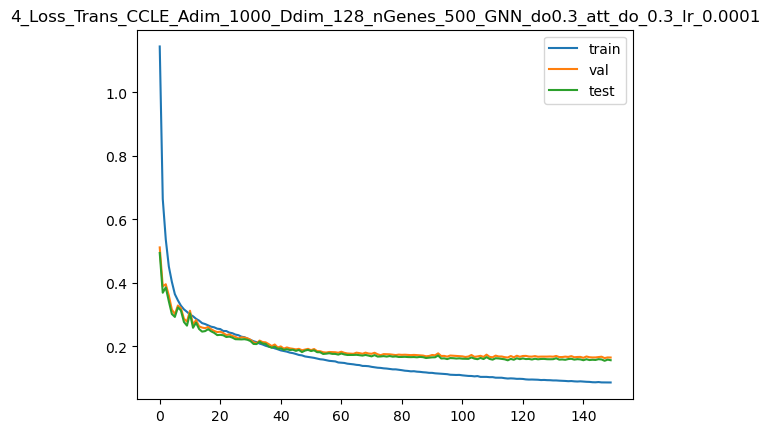

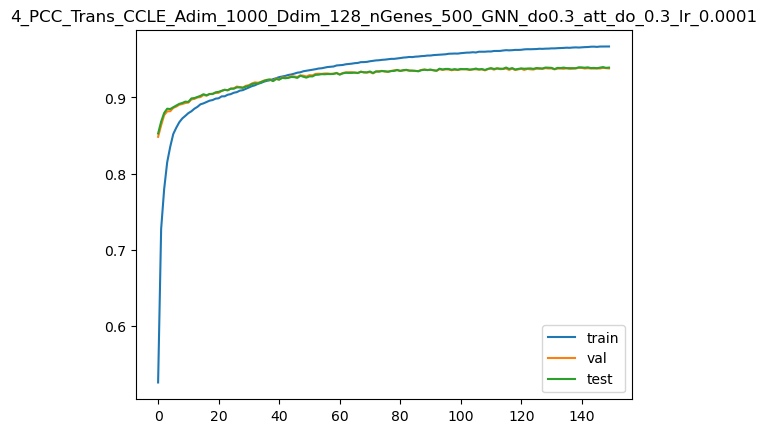

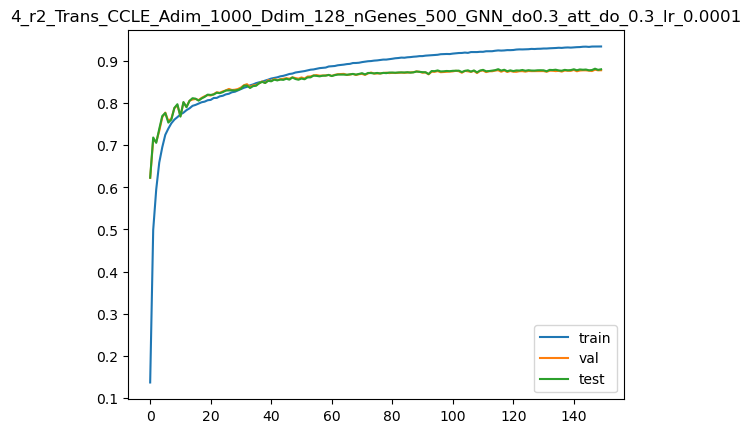

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08727836608886719
The overall Pearson's correlation is 0.9583.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.084232397377491
The overall Pearson's correlation is 0.9803.
Train avg_loss:  0.085392244
Train avg_pcc:  0.9672559868428665
Train r2:  0.9355785833608513


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16756195
Validation avg_pcc:  0.9383274291870939
Validation r2:  0.876434369581728


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15911211
Test avg_pcc:  0.9392289684089624
Test r2:  0.8786747262525154
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12958386540412903
The overall Pearson's correlation is 0.9540.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0945574939250946
The overall Pearson's correlation is 0.9607.
Train avg_loss:  0.08606259
Train avg_pcc:  0.9669931501799223
Train r2:  0.9350728672503619


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16672704
Validation avg_pcc:  0.9381861601990839
Validation r2:  0.8770500631261904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15954557
Test avg_pcc:  0.93859154359659
Test r2:  0.8783442098592699
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12061495333909988
The overall Pearson's correlation is 0.9528.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10568264126777649
The overall Pearson's correlation is 0.9664.
Train avg_loss:  0.08567373
Train avg_pcc:  0.9671458526641973
Train r2:  0.9353662266639999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16483556
Validation avg_pcc:  0.9383663900673472
Validation r2:  0.8784449084867446


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15845624
Test avg_pcc:  0.9384820708974961
Test r2:  0.8791748398580144
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10134902596473694
The overall Pearson's correlation is 0.9667.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06255413591861725
The overall Pearson's correlation is 0.9770.
Train avg_loss:  0.08464471
Train avg_pcc:  0.9675461364880884
Train r2:  0.936142533335883


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16417396
Validation avg_pcc:  0.9385869907637255
Validation r2:  0.8789327819382884


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15733436
Test avg_pcc:  0.9389733834766965
Test r2:  0.8800302977997138
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07087991386651993
The overall Pearson's correlation is 0.9776.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07593945413827896
The overall Pearson's correlation is 0.9671.
Train avg_loss:  0.0842944
Train avg_pcc:  0.9676835827351966
Train r2:  0.9364068127306548


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16530466
Validation avg_pcc:  0.9380365719577299
Validation r2:  0.8780989704498835


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15652406
Test avg_pcc:  0.9392317307017546
Test r2:  0.8806481399380389
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09286579489707947
The overall Pearson's correlation is 0.9754.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0772109180688858
The overall Pearson's correlation is 0.9759.
Train avg_loss:  0.08492159
Train avg_pcc:  0.967439010205958
Train r2:  0.9359336572176906


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1628756
Validation avg_pcc:  0.9388745642758328
Validation r2:  0.8798902441885501
Best Val r2  0.8798902441885501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15415534
Test avg_pcc:  0.940011119101922
Test r2:  0.8824543243520203
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07522223889827728
The overall Pearson's correlation is 0.9821.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08973588049411774
The overall Pearson's correlation is 0.9634.
Train avg_loss:  0.083784275
Train avg_pcc:  0.9678814901968539
Train r2:  0.9367916645897147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16412507
Validation avg_pcc:  0.9386927528447052
Validation r2:  0.8789688295226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15530263
Test avg_pcc:  0.9399092241379206
Test r2:  0.8815795037314867
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10608304291963577
The overall Pearson's correlation is 0.9371.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07939331978559494
The overall Pearson's correlation is 0.9637.
Train avg_loss:  0.08351192
Train avg_pcc:  0.9679883846908506
Train r2:  0.9369971399875158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16882382
Validation avg_pcc:  0.9369095109314296
Validation r2:  0.8755038169453601


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15956196
Test avg_pcc:  0.9382293237495856
Test r2:  0.8783317008767948
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06263631582260132
The overall Pearson's correlation is 0.9753.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07452645897865295
The overall Pearson's correlation is 0.9726.
Train avg_loss:  0.08378768
Train avg_pcc:  0.967880520668516
Train r2:  0.9367890961249355


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16943602
Validation avg_pcc:  0.9368771568021036
Validation r2:  0.8750523703339199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1614345
Test avg_pcc:  0.9376250478145038
Test r2:  0.8769038632061169
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09615623950958252
The overall Pearson's correlation is 0.9680.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08009983599185944
The overall Pearson's correlation is 0.9724.
Train avg_loss:  0.08403077
Train avg_pcc:  0.9677858558519145
Train r2:  0.9366057014902187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16327114
Validation avg_pcc:  0.9386127690286469
Validation r2:  0.8795985616555488


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1558279
Test avg_pcc:  0.9393381547158539
Test r2:  0.8811789870765931
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05789230763912201
The overall Pearson's correlation is 0.9773.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05590806156396866
The overall Pearson's correlation is 0.9740.
Train avg_loss:  0.082417734
Train avg_pcc:  0.9684148711136218
Train r2:  0.9378226006499002


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16503109
Validation avg_pcc:  0.9382551298822668
Validation r2:  0.8783007015707256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15684992
Test avg_pcc:  0.9392143184259615
Test r2:  0.8803996716290665
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08160721510648727
The overall Pearson's correlation is 0.9622.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07782641798257828
The overall Pearson's correlation is 0.9775.
Train avg_loss:  0.08299762
Train avg_pcc:  0.9681886223074777
Train r2:  0.9373851332916255


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16238163
Validation avg_pcc:  0.938856983885864
Validation r2:  0.8802544889934857
Best Val r2  0.8802544889934857


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15389688
Test avg_pcc:  0.9400293913572466
Test r2:  0.8826514100065566
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09190484881401062
The overall Pearson's correlation is 0.9697.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11071938276290894
The overall Pearson's correlation is 0.9710.
Train avg_loss:  0.08200024
Train avg_pcc:  0.968577274516511
Train r2:  0.9381375718517606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1662412
Validation avg_pcc:  0.9382893364143977
Validation r2:  0.8774083275543784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15868385
Test avg_pcc:  0.9389019852252596
Test r2:  0.8790012803898004
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08863063156604767
The overall Pearson's correlation is 0.9685.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06476504355669022
The overall Pearson's correlation is 0.9757.
Train avg_loss:  0.08157289
Train avg_pcc:  0.9687432343012229
Train r2:  0.9384599669443169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16349246
Validation avg_pcc:  0.9386172597342617
Validation r2:  0.8794353434526492


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15724353
Test avg_pcc:  0.9387220399635559
Test r2:  0.8800995406993203
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05426432564854622
The overall Pearson's correlation is 0.9762.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06289762258529663
The overall Pearson's correlation is 0.9713.
Train avg_loss:  0.08215014
Train avg_pcc:  0.9685183398773818
Train r2:  0.9380244838384523


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16357844
Validation avg_pcc:  0.9385907417672503
Validation r2:  0.879371936214376


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15623276
Test avg_pcc:  0.9391981211227465
Test r2:  0.8808702721173776
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07331545650959015
The overall Pearson's correlation is 0.9647.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07998216152191162
The overall Pearson's correlation is 0.9679.
Train avg_loss:  0.08136747
Train avg_pcc:  0.9688237705934974
Train r2:  0.9386149354456959


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16443448
Validation avg_pcc:  0.9382728967251333
Validation r2:  0.8787406566361537


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15754578
Test avg_pcc:  0.9386411419079489
Test r2:  0.8798690836587998
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07867760211229324
The overall Pearson's correlation is 0.9646.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06706972420215607
The overall Pearson's correlation is 0.9804.
Train avg_loss:  0.08139682
Train avg_pcc:  0.9688120072754441
Train r2:  0.9385928025180381


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16521427
Validation avg_pcc:  0.9383682521519251
Validation r2:  0.8781656125547512


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15696758
Test avg_pcc:  0.9392392379452296
Test r2:  0.8803099691760599
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.060031045228242874
The overall Pearson's correlation is 0.9766.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06269817799329758
The overall Pearson's correlation is 0.9796.
Train avg_loss:  0.08100194
Train avg_pcc:  0.9689656909412916
Train r2:  0.9388907129089274


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16838245
Validation avg_pcc:  0.937798602969035
Validation r2:  0.8758293070423911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15938021
Test avg_pcc:  0.9388874259594622
Test r2:  0.8784702879769639
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0760868638753891
The overall Pearson's correlation is 0.9571.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.054809439927339554
The overall Pearson's correlation is 0.9822.
Train avg_loss:  0.0805053
Train avg_pcc:  0.9691585840556203
Train r2:  0.939265378618746


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16324732
Validation avg_pcc:  0.939090838623507
Validation r2:  0.8796161193445482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15683317
Test avg_pcc:  0.939361001496562
Test r2:  0.880412446808646
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08682747930288315
The overall Pearson's correlation is 0.9713.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08992983400821686
The overall Pearson's correlation is 0.9639.
Train avg_loss:  0.08075693
Train avg_pcc:  0.9690608711007352
Train r2:  0.9390755443874111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16278195
Validation avg_pcc:  0.9382603436459983
Validation r2:  0.879959290301949


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15535873
Test avg_pcc:  0.9390035978081763
Test r2:  0.8815367273277701
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10640011727809906
The overall Pearson's correlation is 0.9701.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0621885247528553
The overall Pearson's correlation is 0.9807.
Train avg_loss:  0.08094346
Train avg_pcc:  0.9689891552248056
Train r2:  0.9389348244825078


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16403133
Validation avg_pcc:  0.9388127237839486
Validation r2:  0.879037969547197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1567684
Test avg_pcc:  0.9393298609483685
Test r2:  0.880461836703728
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08890232443809509
The overall Pearson's correlation is 0.9591.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06359508633613586
The overall Pearson's correlation is 0.9736.
Train avg_loss:  0.0799784
Train avg_pcc:  0.96936350050471
Train r2:  0.9396628768557349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16570596
Validation avg_pcc:  0.9377688285980531
Validation r2:  0.877803035181576


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15640694
Test avg_pcc:  0.9390731501967472
Test r2:  0.8807374585441882
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06210581958293915
The overall Pearson's correlation is 0.9788.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05040176212787628
The overall Pearson's correlation is 0.9827.
Train avg_loss:  0.08023379
Train avg_pcc:  0.9692646239855601
Train r2:  0.9394702131492445


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16682805
Validation avg_pcc:  0.9380534906433027
Validation r2:  0.8769755755314655


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15648177
Test avg_pcc:  0.9397747842701392
Test r2:  0.8806803974859799
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09886372089385986
The overall Pearson's correlation is 0.9734.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09590326994657516
The overall Pearson's correlation is 0.9636.
Train avg_loss:  0.080182314
Train avg_pcc:  0.9692844555242708
Train r2:  0.9395090413098939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16604294
Validation avg_pcc:  0.9382145413550088
Validation r2:  0.8775545332026297


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1566305
Test avg_pcc:  0.9395702446888735
Test r2:  0.8805669859442391
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06319977343082428
The overall Pearson's correlation is 0.9683.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10633116215467453
The overall Pearson's correlation is 0.9666.
Train avg_loss:  0.07945533
Train avg_pcc:  0.9695679022514615
Train r2:  0.940057495869552


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16921572
Validation avg_pcc:  0.9380473814398766
Validation r2:  0.8752148227657994


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16026537
Test avg_pcc:  0.9391902190017702
Test r2:  0.8777953460915944
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06667308509349823
The overall Pearson's correlation is 0.9806.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0739143043756485
The overall Pearson's correlation is 0.9703.
Train avg_loss:  0.078938656
Train avg_pcc:  0.9697683688395421
Train r2:  0.9404472871087586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1666465
Validation avg_pcc:  0.9383756155670889
Validation r2:  0.8771094434655684


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15740846
Test avg_pcc:  0.9396869562724837
Test r2:  0.8799737833898537
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08127371966838837
The overall Pearson's correlation is 0.9535.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06508530676364899
The overall Pearson's correlation is 0.9671.
Train avg_loss:  0.079594664
Train avg_pcc:  0.9695129882312961
Train r2:  0.9399523776161036


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1660643
Validation avg_pcc:  0.9377314365782031
Validation r2:  0.8775387731794329


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15628324
Test avg_pcc:  0.9392867833316101
Test r2:  0.8808317795039714
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09477438777685165
The overall Pearson's correlation is 0.9575.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06392759084701538
The overall Pearson's correlation is 0.9767.
Train avg_loss:  0.07907162
Train avg_pcc:  0.9697171458376898
Train r2:  0.9403469759554356


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16701567
Validation avg_pcc:  0.938433768842376
Validation r2:  0.876837204965235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15908587
Test avg_pcc:  0.9391150647246799
Test r2:  0.8786947288994108
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07383265346288681
The overall Pearson's correlation is 0.9669.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10167630016803741
The overall Pearson's correlation is 0.9671.
Train avg_loss:  0.07875345
Train avg_pcc:  0.9698405130071088
Train r2:  0.9405870109389203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1655774
Validation avg_pcc:  0.9386729424390602
Validation r2:  0.8778978400743114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15618189
Test avg_pcc:  0.9399827399604126
Test r2:  0.8809090650101625
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07211140543222427
The overall Pearson's correlation is 0.9700.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08840930461883545
The overall Pearson's correlation is 0.9711.
Train avg_loss:  0.07879919
Train avg_pcc:  0.9698229657800086
Train r2:  0.9405524994398223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16602054
Validation avg_pcc:  0.9375673255822671
Validation r2:  0.877571042661846


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15665664
Test avg_pcc:  0.9389124861028771
Test r2:  0.8805470448359474
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06450407207012177
The overall Pearson's correlation is 0.9784.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07713336497545242
The overall Pearson's correlation is 0.9733.
Train avg_loss:  0.07805601
Train avg_pcc:  0.9701117022912994
Train r2:  0.9411131717047362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16561045
Validation avg_pcc:  0.9392454945052431
Validation r2:  0.8778734718521974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15891308
Test avg_pcc:  0.9394148704590322
Test r2:  0.8788264941996705
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08295591175556183
The overall Pearson's correlation is 0.9524.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09499338269233704
The overall Pearson's correlation is 0.9811.
Train avg_loss:  0.07758789
Train avg_pcc:  0.9702939567632322
Train r2:  0.9414663336288022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1678329
Validation avg_pcc:  0.9390809513889447
Validation r2:  0.876234555827514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1603784
Test avg_pcc:  0.9394788673216699
Test r2:  0.8777091701401942
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07701669633388519
The overall Pearson's correlation is 0.9692.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06722144037485123
The overall Pearson's correlation is 0.9744.
Train avg_loss:  0.07805693
Train avg_pcc:  0.9701114121884142
Train r2:  0.9411124669222317


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16788925
Validation avg_pcc:  0.938127695403052
Validation r2:  0.876193011680501


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15990373
Test avg_pcc:  0.9389221216831447
Test r2:  0.8780711072799701
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.061056531965732574
The overall Pearson's correlation is 0.9719.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06913578510284424
The overall Pearson's correlation is 0.9764.
Train avg_loss:  0.07759084
Train avg_pcc:  0.9702928724573063
Train r2:  0.9414641033753696


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16735518
Validation avg_pcc:  0.9381500584775926
Validation r2:  0.8765868536221277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15892416
Test avg_pcc:  0.9390652971476263
Test r2:  0.8788180396570161
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10859600454568863
The overall Pearson's correlation is 0.9676.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07631241530179977
The overall Pearson's correlation is 0.9719.
Train avg_loss:  0.07773772
Train avg_pcc:  0.9702354087382924
Train r2:  0.9413532907970349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16867457
Validation avg_pcc:  0.9380087043143801
Validation r2:  0.8756138767631617


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1622556
Test avg_pcc:  0.9380220085283564
Test r2:  0.8762777680150491
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.057956963777542114
The overall Pearson's correlation is 0.9816.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0488378182053566
The overall Pearson's correlation is 0.9774.
Train avg_loss:  0.07682659
Train avg_pcc:  0.9705895082653115
Train r2:  0.9420406666154166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16494302
Validation avg_pcc:  0.9384151707098285
Validation r2:  0.8783656442388011


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15675074
Test avg_pcc:  0.9392581221632934
Test r2:  0.8804753013314868
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08249136805534363
The overall Pearson's correlation is 0.9622.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07862602174282074
The overall Pearson's correlation is 0.9640.
Train avg_loss:  0.0766914
Train avg_pcc:  0.9706424133310614
Train r2:  0.9421426581940174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1651593
Validation avg_pcc:  0.9388844029474369
Validation r2:  0.8782061697989381


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15650961
Test avg_pcc:  0.9398956650012331
Test r2:  0.8806591641149105
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1072189062833786
The overall Pearson's correlation is 0.9525.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.109307661652565
The overall Pearson's correlation is 0.9598.
Train avg_loss:  0.07649429
Train avg_pcc:  0.9707185183989284
Train r2:  0.9422913571491699


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16349481
Validation avg_pcc:  0.9389817732667449
Validation r2:  0.8794336074099152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15613417
Test avg_pcc:  0.9396350259632246
Test r2:  0.8809454504453437
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08622369170188904
The overall Pearson's correlation is 0.9748.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08796022832393646
The overall Pearson's correlation is 0.9678.
Train avg_loss:  0.07744786
Train avg_pcc:  0.9703480462397299
Train r2:  0.9415719660005218


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16356085
Validation avg_pcc:  0.9392509709844878
Validation r2:  0.8793848915411672


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1570209
Test avg_pcc:  0.9394452718970973
Test r2:  0.8802693124154011
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06530749052762985
The overall Pearson's correlation is 0.9696.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.054083555936813354
The overall Pearson's correlation is 0.9766.
Train avg_loss:  0.07607809
Train avg_pcc:  0.9708806698249084
Train r2:  0.9426053457326111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16243292
Validation avg_pcc:  0.9386941258647791
Validation r2:  0.8802166763421094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15518916
Test avg_pcc:  0.9393246874782812
Test r2:  0.8816660251874977
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.037860799580812454
The overall Pearson's correlation is 0.9819.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08462600409984589
The overall Pearson's correlation is 0.9541.
Train avg_loss:  0.076649055
Train avg_pcc:  0.9706586399267163
Train r2:  0.9421745964241575


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16141978
Validation avg_pcc:  0.9392637137094365
Validation r2:  0.8809638017014145
Best Val r2  0.8809638017014145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15440276
Test avg_pcc:  0.9397264235629645
Test r2:  0.8822656732330755
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.058251913636922836
The overall Pearson's correlation is 0.9744.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09162171185016632
The overall Pearson's correlation is 0.9650.
Train avg_loss:  0.07525563
Train avg_pcc:  0.9711997091913234
Train r2:  0.943225819860351


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16210736
Validation avg_pcc:  0.9390305421448325
Validation r2:  0.8804567619967028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1559839
Test avg_pcc:  0.9392502664668119
Test r2:  0.8810600224723775
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06746188551187515
The overall Pearson's correlation is 0.9723.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06597645580768585
The overall Pearson's correlation is 0.9830.
Train avg_loss:  0.075395174
Train avg_pcc:  0.9711460366825375
Train r2:  0.9431205533588094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1637293
Validation avg_pcc:  0.9386324901256976
Validation r2:  0.8792606987182608


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15590118
Test avg_pcc:  0.9394675972533321
Test r2:  0.8811231113914139
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.086009681224823
The overall Pearson's correlation is 0.9708.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07156726717948914
The overall Pearson's correlation is 0.9628.
Train avg_loss:  0.07565928
Train avg_pcc:  0.9710427574311643
Train r2:  0.9429213008253031


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16584417
Validation avg_pcc:  0.9386307633447188
Validation r2:  0.8777011119146917


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15889306
Test avg_pcc:  0.9390529299430326
Test r2:  0.8788417545066471
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08385482430458069
The overall Pearson's correlation is 0.9765.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07417258620262146
The overall Pearson's correlation is 0.9681.
Train avg_loss:  0.075532146
Train avg_pcc:  0.9710924124215025
Train r2:  0.9430172209011792


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16141544
Validation avg_pcc:  0.9390035695183264
Validation r2:  0.8809670028735092
Best Val r2  0.8809670028735092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1552131
Test avg_pcc:  0.9392393673606398
Test r2:  0.8816477902529869
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.056537359952926636
The overall Pearson's correlation is 0.9808.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07099884003400803
The overall Pearson's correlation is 0.9780.
Train avg_loss:  0.0761184
Train avg_pcc:  0.9708650814971072
Train r2:  0.942574932902217


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16531861
Validation avg_pcc:  0.9385504031694366
Validation r2:  0.8780886797086193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15828666
Test avg_pcc:  0.9389345354514662
Test r2:  0.8793041333645266
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06232906132936478
The overall Pearson's correlation is 0.9777.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0559694804251194
The overall Pearson's correlation is 0.9674.
Train avg_loss:  0.07507321
Train avg_pcc:  0.9712707073807868
Train r2:  0.9433634434552348


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1646875
Validation avg_pcc:  0.9391769992649167
Validation r2:  0.8785540844069815


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1587871
Test avg_pcc:  0.9390549814962775
Test r2:  0.8789225450334194
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0652274340391159
The overall Pearson's correlation is 0.9784.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07587645947933197
The overall Pearson's correlation is 0.9608.
Train avg_loss:  0.07506684
Train avg_pcc:  0.9712733325928968
Train r2:  0.9433682518792045


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16474521
Validation avg_pcc:  0.9391721324271687
Validation r2:  0.8785115300744889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15672043
Test avg_pcc:  0.9399791987051281
Test r2:  0.8804984168553462
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07443398237228394
The overall Pearson's correlation is 0.9615.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06173750385642052
The overall Pearson's correlation is 0.9812.
Train avg_loss:  0.07531922
Train avg_pcc:  0.9711751475087622
Train r2:  0.943177851902999


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16365574
Validation avg_pcc:  0.938316137817074
Validation r2:  0.8793149356207332


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15600628
Test avg_pcc:  0.9390563610298551
Test r2:  0.8810429691824818
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.045414768159389496
The overall Pearson's correlation is 0.9870.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05755236744880676
The overall Pearson's correlation is 0.9724.
Train avg_loss:  0.07456881
Train avg_pcc:  0.9714666879824305
Train r2:  0.9437439715644549


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16417292
Validation avg_pcc:  0.9390208341335304
Validation r2:  0.8789335525645203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15697439
Test avg_pcc:  0.9394251235975352
Test r2:  0.8803047576705763


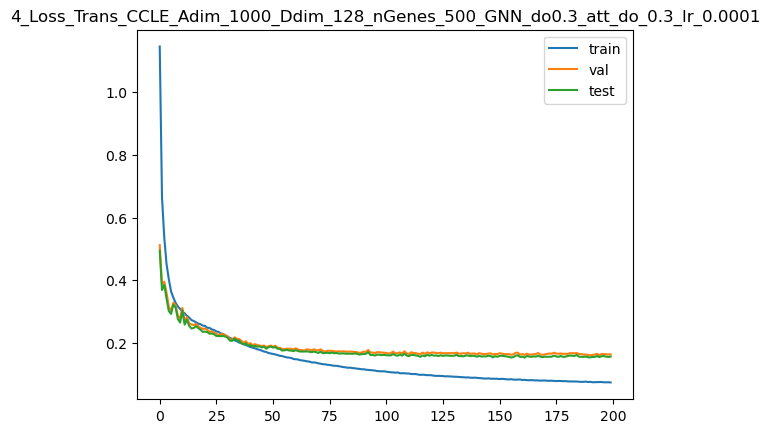

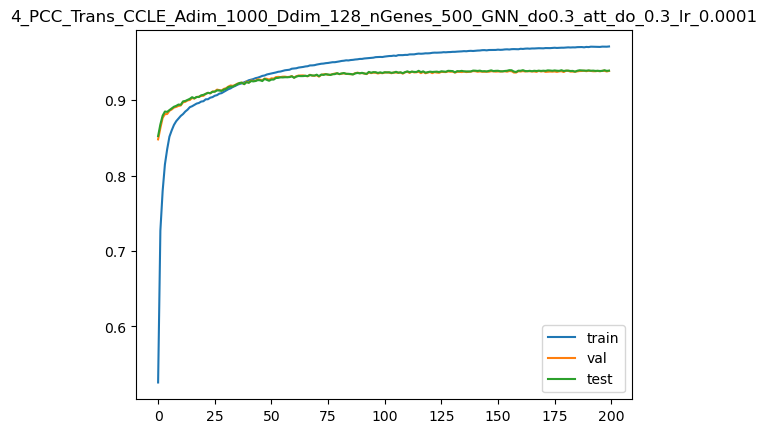

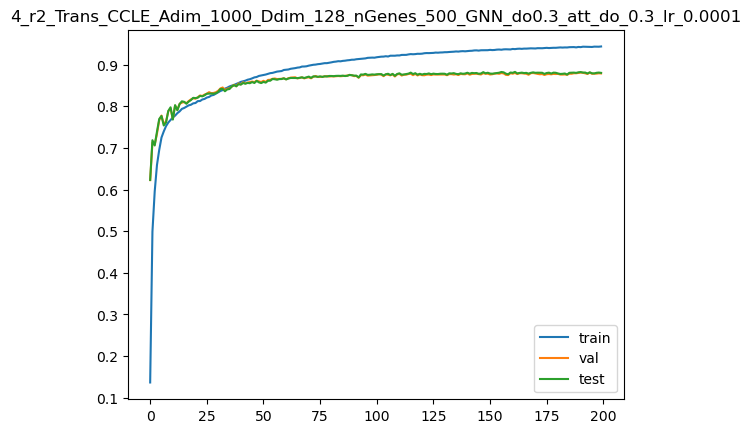

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.15521307
Test avg_pcc:  0.9392393670898935
Test r2:  0.8816477897968074


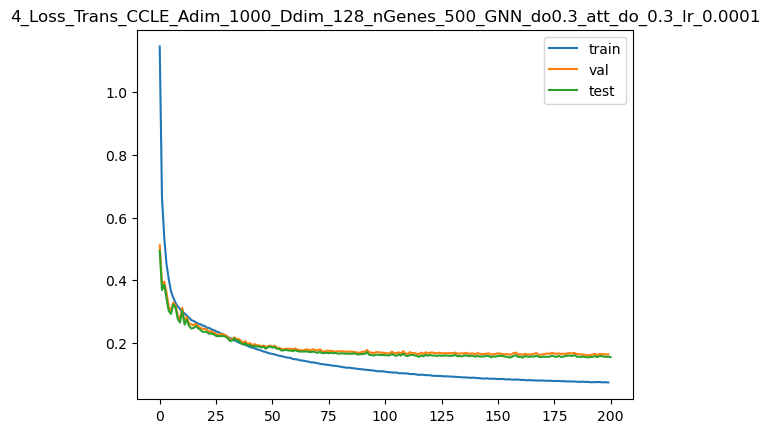

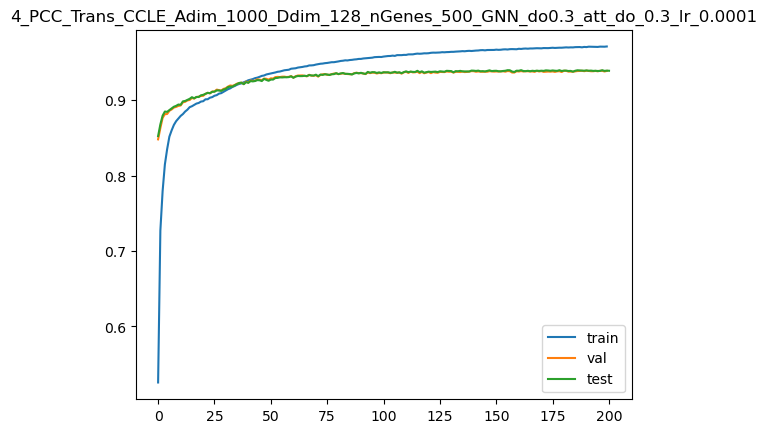

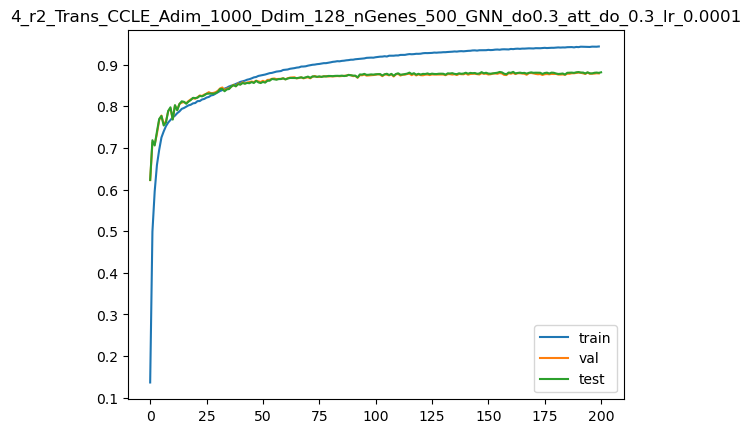

/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.8542127013206482
The overall Pearson's correlation is 0.6575.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  1.0511844158172607
The overall Pearson's correlation is 0.6204.
Train avg_loss:  1.1533793
Train avg_pcc:  0.5197840082887257
Train r2:  0.12480191881453151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.42652172
Validation avg_pcc:  0.8514187425428021
Validation r2:  0.6906581549258539
Best Val r2  0.6906581549258539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.42981115
Test avg_pcc:  0.8447757087573444
Test r2:  0.6760351630102972
#################### epoch ############################  0


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.48582881689071655
The overall Pearson's correlation is 0.8337.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3925277590751648
The overall Pearson's correlation is 0.8699.
Train avg_loss:  0.66570324
Train avg_pcc:  0.7251533866608373
Train r2:  0.4948563257332833


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.38193965
Validation avg_pcc:  0.8685226428547856
Validation r2:  0.7229920542603938
Best Val r2  0.7229920542603938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.381488
Test avg_pcc:  0.8636125025732865
Test r2:  0.7124581228610605
#################### epoch ############################  1


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3660081923007965
The overall Pearson's correlation is 0.7728.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.44930529594421387
The overall Pearson's correlation is 0.7850.
Train avg_loss:  0.5274206
Train avg_pcc:  0.7825057857666516
Train r2:  0.5997869454096387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.38578987
Validation avg_pcc:  0.8753776157938763
Validation r2:  0.7201995934491758


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.38439262
Test avg_pcc:  0.8714483587609202
Test r2:  0.7102687978075375
#################### epoch ############################  2


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.49596232175827026
The overall Pearson's correlation is 0.8202.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.5153943300247192
The overall Pearson's correlation is 0.8889.
Train avg_loss:  0.4529289
Train avg_pcc:  0.8134315138081326
Train r2:  0.6563121168760118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.35779202
Validation avg_pcc:  0.8810814271989634
Validation r2:  0.7405055235971236
Best Val r2  0.7405055235971236


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3510316
Test avg_pcc:  0.8791400795033473
Test r2:  0.7354142725276671
#################### epoch ############################  3


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2820916175842285
The overall Pearson's correlation is 0.8756.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.42368489503860474
The overall Pearson's correlation is 0.8161.
Train avg_loss:  0.39630306
Train avg_pcc:  0.8374026018195678
Train r2:  0.6992804613139624


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.3735084
Validation avg_pcc:  0.8812208901680737
Validation r2:  0.7291069358677429


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.37106305
Test avg_pcc:  0.8776301130761816
Test r2:  0.7203158173294031
#################### epoch ############################  4


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.43221190571784973
The overall Pearson's correlation is 0.8567.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.31313765048980713
The overall Pearson's correlation is 0.9112.
Train avg_loss:  0.35578337
Train avg_pcc:  0.8547610813005709
Train r2:  0.7300272788044961


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32753655
Validation avg_pcc:  0.885300901965341
Validation r2:  0.7624487873780845
Best Val r2  0.7624487873780845


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.32463247
Test avg_pcc:  0.8819267458119813
Test r2:  0.7553122966302345
#################### epoch ############################  5


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.5688076019287109
The overall Pearson's correlation is 0.7864.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3381735682487488
The overall Pearson's correlation is 0.8436.
Train avg_loss:  0.33957723
Train avg_pcc:  0.861726347409271
Train r2:  0.7423247119237514


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.32114938
Validation avg_pcc:  0.8881046279619456
Validation r2:  0.7670811816774459
Best Val r2  0.7670811816774459


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3181319
Test avg_pcc:  0.8848671428132254
Test r2:  0.7602120070226575
#################### epoch ############################  6


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.32003286480903625
The overall Pearson's correlation is 0.9089.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22062893211841583
The overall Pearson's correlation is 0.9315.
Train avg_loss:  0.32054308
Train avg_pcc:  0.8699661420516537
Train r2:  0.7567680437163062


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.33948758
Validation avg_pcc:  0.8887317420874253
Validation r2:  0.753781090245363


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.3348712
Test avg_pcc:  0.8866470101526928
Test r2:  0.7475949692845083
#################### epoch ############################  7


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29198867082595825
The overall Pearson's correlation is 0.9018.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2726009786128998
The overall Pearson's correlation is 0.8586.
Train avg_loss:  0.31077394
Train avg_pcc:  0.8741980696886587
Train r2:  0.7641810129860531


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29590115
Validation avg_pcc:  0.8904879345904264
Validation r2:  0.7853928603264343
Best Val r2  0.7853928603264343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2907902
Test avg_pcc:  0.8883697247815006
Test r2:  0.7808204960194493
#################### epoch ############################  8


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.27498722076416016
The overall Pearson's correlation is 0.8527.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20339488983154297
The overall Pearson's correlation is 0.9482.
Train avg_loss:  0.304055
Train avg_pcc:  0.8771027125976569
Train r2:  0.7692794160657417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29149112
Validation avg_pcc:  0.8912738739590759
Validation r2:  0.7885913138788352
Best Val r2  0.7885913138788352


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2863587
Test avg_pcc:  0.8891993721136061
Test r2:  0.7841606636506419
#################### epoch ############################  9


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.22982189059257507
The overall Pearson's correlation is 0.9291.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2975521683692932
The overall Pearson's correlation is 0.8862.
Train avg_loss:  0.29612756
Train avg_pcc:  0.8805207848667418
Train r2:  0.7752948577028929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.29437053
Validation avg_pcc:  0.8947058765611189
Validation r2:  0.7865029570771079


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.29134217
Test avg_pcc:  0.8919656354607952
Test r2:  0.7804044150959291
#################### epoch ############################  10


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.29523733258247375
The overall Pearson's correlation is 0.8930.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.3830391764640808
The overall Pearson's correlation is 0.8993.
Train avg_loss:  0.2877134
Train avg_pcc:  0.8841364908873027
Train r2:  0.7816796107850728


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.28347862
Validation avg_pcc:  0.8968556584868395
Validation r2:  0.7944025327691723
Best Val r2  0.7944025327691723


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27860615
Test avg_pcc:  0.894975986282563
Test r2:  0.790004060221311
#################### epoch ############################  11


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.37011414766311646
The overall Pearson's correlation is 0.8875.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2611178457736969
The overall Pearson's correlation is 0.8586.
Train avg_loss:  0.28104478
Train avg_pcc:  0.8869944726675107
Train r2:  0.786739828460056


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2767065
Validation avg_pcc:  0.8997730344483649
Validation r2:  0.7993141077368916
Best Val r2  0.7993141077368916


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.27203497
Test avg_pcc:  0.8978574032082258
Test r2:  0.7949570184806718
#################### epoch ############################  12


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.34341365098953247
The overall Pearson's correlation is 0.8263.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2887185513973236
The overall Pearson's correlation is 0.8981.
Train avg_loss:  0.27551126
Train avg_pcc:  0.8893581577454811
Train r2:  0.790938737555444


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26911908
Validation avg_pcc:  0.9008502555538145
Validation r2:  0.8048170000772339
Best Val r2  0.8048170000772339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.26758206
Test avg_pcc:  0.8978293405474366
Test r2:  0.7983133231850654
#################### epoch ############################  13


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2563473582267761
The overall Pearson's correlation is 0.9060.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2600718140602112
The overall Pearson's correlation is 0.8950.
Train avg_loss:  0.26910663
Train avg_pcc:  0.8920868724441442
Train r2:  0.7957986302772454


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26569965
Validation avg_pcc:  0.9042190669174186
Validation r2:  0.8072969827538599
Best Val r2  0.8072969827538599


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2655528
Test avg_pcc:  0.90057938661481
Test r2:  0.7998428805322353
#################### epoch ############################  14


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2508545517921448
The overall Pearson's correlation is 0.9018.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.331188440322876
The overall Pearson's correlation is 0.8527.
Train avg_loss:  0.26369464
Train avg_pcc:  0.894384440082953
Train r2:  0.7999053355334975


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25418076
Validation avg_pcc:  0.9040854608252962
Validation r2:  0.8156512611647209
Best Val r2  0.8156512611647209


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25474808
Test avg_pcc:  0.9001262712046579
Test r2:  0.8079867871968225
#################### epoch ############################  15


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2319091409444809
The overall Pearson's correlation is 0.9342.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26056021451950073
The overall Pearson's correlation is 0.9036.
Train avg_loss:  0.26086378
Train avg_pcc:  0.8955851258006696
Train r2:  0.8020534095805764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.251419
Validation avg_pcc:  0.9042672373456396
Validation r2:  0.8176542587788004
Best Val r2  0.8176542587788004


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24911626
Test avg_pcc:  0.9012880155255568
Test r2:  0.8122317023009903
#################### epoch ############################  16


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17146578431129456
The overall Pearson's correlation is 0.9234.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24685105681419373
The overall Pearson's correlation is 0.9203.
Train avg_loss:  0.2597785
Train avg_pcc:  0.896041852221685
Train r2:  0.8028769493697587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.25341645
Validation avg_pcc:  0.9048332380302909
Validation r2:  0.8162055899531092


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25254425
Test avg_pcc:  0.9014847412867223
Test r2:  0.8096478698366261
#################### epoch ############################  17


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15625569224357605
The overall Pearson's correlation is 0.9409.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20092475414276123
The overall Pearson's correlation is 0.9250.
Train avg_loss:  0.25541165
Train avg_pcc:  0.8978909893749865
Train r2:  0.8061905431045647


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24599198
Validation avg_pcc:  0.9071155780548372
Validation r2:  0.8215903161594449
Best Val r2  0.8215903161594449


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24509506
Test avg_pcc:  0.9036421860331126
Test r2:  0.8152626466364558
#################### epoch ############################  18


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15780875086784363
The overall Pearson's correlation is 0.9436.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19081532955169678
The overall Pearson's correlation is 0.9064.
Train avg_loss:  0.2509948
Train avg_pcc:  0.8997534793229696
Train r2:  0.8095421508039083


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2498453
Validation avg_pcc:  0.9062942697989185
Validation r2:  0.8187956119391694


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24716319
Test avg_pcc:  0.9035279593699959
Test r2:  0.813703807432825
#################### epoch ############################  19


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2560243010520935
The overall Pearson's correlation is 0.9049.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.30607932806015015
The overall Pearson's correlation is 0.8798.
Train avg_loss:  0.24872406
Train avg_pcc:  0.9007111813136255
Train r2:  0.8112651652850502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.26030058
Validation avg_pcc:  0.9042776552690494
Validation r2:  0.8112127527218425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.25961396
Test avg_pcc:  0.9008041750399103
Test r2:  0.8043191890953205
#################### epoch ############################  20


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18656203150749207
The overall Pearson's correlation is 0.9332.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18562105298042297
The overall Pearson's correlation is 0.9009.
Train avg_loss:  0.24573992
Train avg_pcc:  0.9019662511537291
Train r2:  0.8135296022394877


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24261202
Validation avg_pcc:  0.9090430485584164
Validation r2:  0.8240416836711967
Best Val r2  0.8240416836711967


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24330562
Test avg_pcc:  0.9052799529081464
Test r2:  0.8166113934149544
#################### epoch ############################  21


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1849180907011032
The overall Pearson's correlation is 0.9313.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1765328347682953
The overall Pearson's correlation is 0.9276.
Train avg_loss:  0.24178416
Train avg_pcc:  0.9036285851879543
Train r2:  0.8165312825746035


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24107549
Validation avg_pcc:  0.9094886915954175
Validation r2:  0.8251560706256476
Best Val r2  0.8251560706256476


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23909253
Test avg_pcc:  0.9067498710396349
Test r2:  0.8197869696018061
#################### epoch ############################  22


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2344774305820465
The overall Pearson's correlation is 0.9261.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.365905225276947
The overall Pearson's correlation is 0.8684.
Train avg_loss:  0.23844254
Train avg_pcc:  0.9050303848292286
Train r2:  0.819066939909962


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.24368769
Validation avg_pcc:  0.9090202563359779
Validation r2:  0.823261518491287


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24628581
Test avg_pcc:  0.9044527010349849
Test r2:  0.8143651214590277
#################### epoch ############################  23


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2512727379798889
The overall Pearson's correlation is 0.9063.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22983267903327942
The overall Pearson's correlation is 0.9253.
Train avg_loss:  0.23639466
Train avg_pcc:  0.9058874254722956
Train r2:  0.820620875199012


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2453249
Validation avg_pcc:  0.9108903907878005
Validation r2:  0.8220741085487724


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.24313666
Test avg_pcc:  0.9083263195551364
Test r2:  0.8167387478774842
#################### epoch ############################  24


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16906648874282837
The overall Pearson's correlation is 0.9075.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2174188792705536
The overall Pearson's correlation is 0.8958.
Train avg_loss:  0.23206413
Train avg_pcc:  0.907702637924561
Train r2:  0.8239069491041346


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23229724
Validation avg_pcc:  0.9119791999619169
Validation r2:  0.8315226287236295
Best Val r2  0.8315226287236295


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.2282788
Test avg_pcc:  0.9099715332152144
Test r2:  0.8279376790116265
#################### epoch ############################  25


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21353410184383392
The overall Pearson's correlation is 0.9289.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22925877571105957
The overall Pearson's correlation is 0.9419.
Train avg_loss:  0.22877255
Train avg_pcc:  0.9090740112681598
Train r2:  0.82640461853783


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2390142
Validation avg_pcc:  0.912266104958447
Validation r2:  0.8266510651144785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.23484696
Test avg_pcc:  0.9103957671585137
Test r2:  0.8229870066401005
#################### epoch ############################  26


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.213578000664711
The overall Pearson's correlation is 0.9165.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2501731514930725
The overall Pearson's correlation is 0.8887.
Train avg_loss:  0.22397791
Train avg_pcc:  0.9110743435199363
Train r2:  0.8300428719912735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.23113915
Validation avg_pcc:  0.9135640728519604
Validation r2:  0.8323625537594812
Best Val r2  0.8323625537594812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22879823
Test avg_pcc:  0.9112549508697713
Test r2:  0.8275461729761178
#################### epoch ############################  27


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.3307383358478546
The overall Pearson's correlation is 0.8208.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.314124196767807
The overall Pearson's correlation is 0.8658.
Train avg_loss:  0.22176023
Train avg_pcc:  0.9119980873521237
Train r2:  0.8317256740370929


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2231204
Validation avg_pcc:  0.9155522635298856
Validation r2:  0.8381782849024335
Best Val r2  0.8381782849024335


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22014432
Test avg_pcc:  0.913340990127602
Test r2:  0.8340689414598019
#################### epoch ############################  28


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21995747089385986
The overall Pearson's correlation is 0.9309.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20577988028526306
The overall Pearson's correlation is 0.9065.
Train avg_loss:  0.217936
Train avg_pcc:  0.913586005314831
Train r2:  0.8346275408354594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22719455
Validation avg_pcc:  0.91609792614369
Validation r2:  0.8352234448690433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22373767
Test avg_pcc:  0.9141317467769184
Test r2:  0.8313604957613276
#################### epoch ############################  29


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.25190645456314087
The overall Pearson's correlation is 0.9023.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.21865497529506683
The overall Pearson's correlation is 0.9079.
Train avg_loss:  0.21371973
Train avg_pcc:  0.9153336853611578
Train r2:  0.8378268794829387


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.22696313
Validation avg_pcc:  0.9186804025876079
Validation r2:  0.8353912740185412


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.22401886
Test avg_pcc:  0.9166016455038878
Test r2:  0.8311485570763637
#################### epoch ############################  30


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.246431365609169
The overall Pearson's correlation is 0.9125.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.22265248000621796
The overall Pearson's correlation is 0.9174.
Train avg_loss:  0.2084618
Train avg_pcc:  0.917511598907314
Train r2:  0.8418166626850362


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2200658
Validation avg_pcc:  0.9167717234227182
Validation r2:  0.8403936725408184
Best Val r2  0.8403936725408184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21578908
Test avg_pcc:  0.9151243531082607
Test r2:  0.8373516557571997
#################### epoch ############################  31


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1811337172985077
The overall Pearson's correlation is 0.9228.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2754313349723816
The overall Pearson's correlation is 0.8996.
Train avg_loss:  0.20637357
Train avg_pcc:  0.9183742142108059
Train r2:  0.8434012388421471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21312164
Validation avg_pcc:  0.9201740358532273
Validation r2:  0.8454300512838911
Best Val r2  0.8454300512838911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21094555
Test avg_pcc:  0.9177813220266724
Test r2:  0.8410024080115004
#################### epoch ############################  32


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16168394684791565
The overall Pearson's correlation is 0.9405.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25792980194091797
The overall Pearson's correlation is 0.9102.
Train avg_loss:  0.20365188
Train avg_pcc:  0.9194986373161024
Train r2:  0.8454665056325527


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.21355468
Validation avg_pcc:  0.9211221605419465
Validation r2:  0.8451159704996483


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.21084814
Test avg_pcc:  0.9190635184821614
Test r2:  0.8410758260487263
#################### epoch ############################  33


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23395442962646484
The overall Pearson's correlation is 0.9136.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.25653231143951416
The overall Pearson's correlation is 0.8727.
Train avg_loss:  0.19934796
Train avg_pcc:  0.9212722462312927
Train r2:  0.8487323633086323


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20866981
Validation avg_pcc:  0.9217774849573167
Validation r2:  0.8486587997844266
Best Val r2  0.8486587997844266


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20662636
Test avg_pcc:  0.9193545166969923
Test r2:  0.8442579349719848
#################### epoch ############################  34


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20009344816207886
The overall Pearson's correlation is 0.8906.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12672874331474304
The overall Pearson's correlation is 0.9370.
Train avg_loss:  0.19657667
Train avg_pcc:  0.9224121701288082
Train r2:  0.8508352434752942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20822605
Validation avg_pcc:  0.9218533053529924
Validation r2:  0.8489806471737968
Best Val r2  0.8489806471737968


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20401102
Test avg_pcc:  0.9203347046590664
Test r2:  0.8462292168146055
#################### epoch ############################  35


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11425323784351349
The overall Pearson's correlation is 0.9538.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26922839879989624
The overall Pearson's correlation is 0.8916.
Train avg_loss:  0.19397216
Train avg_pcc:  0.9234829997999879
Train r2:  0.8528116050641985


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.2083464
Validation avg_pcc:  0.9223598089957725
Validation r2:  0.8488933690350282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20583871
Test avg_pcc:  0.9202934416670749
Test r2:  0.8448516322191322
#################### epoch ############################  36


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19970092177391052
The overall Pearson's correlation is 0.9079.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1468580663204193
The overall Pearson's correlation is 0.9262.
Train avg_loss:  0.19188716
Train avg_pcc:  0.9243403683572652
Train r2:  0.8543937050155744


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20509697
Validation avg_pcc:  0.9233432912421723
Validation r2:  0.8512500651030372
Best Val r2  0.8512500651030372


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20193312
Test avg_pcc:  0.921538857507111
Test r2:  0.847795411534122
#################### epoch ############################  37


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.23942844569683075
The overall Pearson's correlation is 0.8965.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13140667974948883
The overall Pearson's correlation is 0.9560.
Train avg_loss:  0.18913995
Train avg_pcc:  0.9254658526389055
Train r2:  0.8564783306098812


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20532684
Validation avg_pcc:  0.9228158122974767
Validation r2:  0.8510833642463179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.20334536
Test avg_pcc:  0.920481743986219
Test r2:  0.8467309629567663
#################### epoch ############################  38


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16139882802963257
The overall Pearson's correlation is 0.9428.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.19897207617759705
The overall Pearson's correlation is 0.9363.
Train avg_loss:  0.18684354
Train avg_pcc:  0.9264060961343625
Train r2:  0.8582208883936553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20050922
Validation avg_pcc:  0.924887453933409
Validation r2:  0.8545774264516481
Best Val r2  0.8545774264516481


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19999777
Test avg_pcc:  0.9219544724381256
Test r2:  0.8492541614017851
#################### epoch ############################  39


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20753304660320282
The overall Pearson's correlation is 0.9105.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2727319598197937
The overall Pearson's correlation is 0.9048.
Train avg_loss:  0.18404256
Train avg_pcc:  0.9275538826249934
Train r2:  0.8603462926713338


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19964473
Validation avg_pcc:  0.9250383150088062
Validation r2:  0.8552044063789586
Best Val r2  0.8552044063789586


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19681223
Test avg_pcc:  0.9231278365354804
Test r2:  0.8516552143040308
#################### epoch ############################  40


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.21413441002368927
The overall Pearson's correlation is 0.9450.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2061002105474472
The overall Pearson's correlation is 0.9269.
Train avg_loss:  0.18070579
Train avg_pcc:  0.9289158820653476
Train r2:  0.8628782655810784


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19831982
Validation avg_pcc:  0.9253072085390301
Validation r2:  0.8561653062668735
Best Val r2  0.8561653062668735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1958843
Test avg_pcc:  0.9232369757325094
Test r2:  0.8523546295275561
#################### epoch ############################  41


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1400475651025772
The overall Pearson's correlation is 0.9511.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12965984642505646
The overall Pearson's correlation is 0.9493.
Train avg_loss:  0.1801611
Train avg_pcc:  0.9291404675653678
Train r2:  0.8632915934599502


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.20072816
Validation avg_pcc:  0.9252548652674817
Validation r2:  0.8544186265581644


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19859472
Test avg_pcc:  0.9230926153257031
Test r2:  0.8503116920487632
#################### epoch ############################  42


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1724179983139038
The overall Pearson's correlation is 0.9191.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.2268616259098053
The overall Pearson's correlation is 0.8959.
Train avg_loss:  0.17888339
Train avg_pcc:  0.9296611809594123
Train r2:  0.8642611380057136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1971834
Validation avg_pcc:  0.9257738028498717
Validation r2:  0.8569895227783273
Best Val r2  0.8569895227783273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19417305
Test avg_pcc:  0.9239683702846943
Test r2:  0.8536444709419387
#################### epoch ############################  43


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17384788393974304
The overall Pearson's correlation is 0.9414.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10204513370990753
The overall Pearson's correlation is 0.9602.
Train avg_loss:  0.17520383
Train avg_pcc:  0.9311621878969842
Train r2:  0.8670532215295286


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19683926
Validation avg_pcc:  0.9263132953604027
Validation r2:  0.8572391142918191
Best Val r2  0.8572391142918191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19231495
Test avg_pcc:  0.9250350669283929
Test r2:  0.8550449852992268
#################### epoch ############################  44


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18242508172988892
The overall Pearson's correlation is 0.9278.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15801942348480225
The overall Pearson's correlation is 0.9301.
Train avg_loss:  0.17325804
Train avg_pcc:  0.9319525701357966
Train r2:  0.8685297225741203


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1994491
Validation avg_pcc:  0.9249391697952813
Validation r2:  0.8553462815288276


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19619049
Test avg_pcc:  0.9232410912914312
Test r2:  0.8521238352421927
#################### epoch ############################  45


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1376936286687851
The overall Pearson's correlation is 0.9527.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14455433189868927
The overall Pearson's correlation is 0.9372.
Train avg_loss:  0.17186187
Train avg_pcc:  0.9325215178053804
Train r2:  0.8695891496970113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19382657
Validation avg_pcc:  0.9276361286388487
Validation r2:  0.8594241098659864
Best Val r2  0.8594241098659864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19210176
Test avg_pcc:  0.9254397888835129
Test r2:  0.8552056692706771
#################### epoch ############################  46


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.16075941920280457
The overall Pearson's correlation is 0.9285.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.24077923595905304
The overall Pearson's correlation is 0.9477.
Train avg_loss:  0.16932228
Train avg_pcc:  0.9335552400661873
Train r2:  0.8715162191327389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18980955
Validation avg_pcc:  0.9288371585591022
Validation r2:  0.8623375427483402
Best Val r2  0.8623375427483402


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1874524
Test avg_pcc:  0.9268124229510531
Test r2:  0.8587100654459437
#################### epoch ############################  47


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2656066119670868
The overall Pearson's correlation is 0.9297.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17760536074638367
The overall Pearson's correlation is 0.9131.
Train avg_loss:  0.16728017
Train avg_pcc:  0.9343839588137406
Train r2:  0.8730658038161216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18975616
Validation avg_pcc:  0.9289701179405768
Validation r2:  0.8623762555022261
Best Val r2  0.8623762555022261


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18834725
Test avg_pcc:  0.9265615929712079
Test r2:  0.8580355866961449
#################### epoch ############################  48


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09781497716903687
The overall Pearson's correlation is 0.9638.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1802745759487152
The overall Pearson's correlation is 0.9496.
Train avg_loss:  0.16524401
Train avg_pcc:  0.9352105052698039
Train r2:  0.8746108615752277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19379924
Validation avg_pcc:  0.927679538264001
Validation r2:  0.8594439384377057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.19201785
Test avg_pcc:  0.9254148633888885
Test r2:  0.8552689141039631


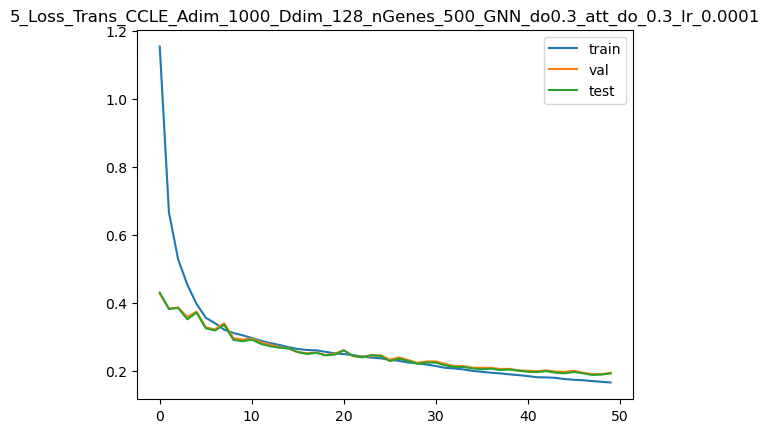

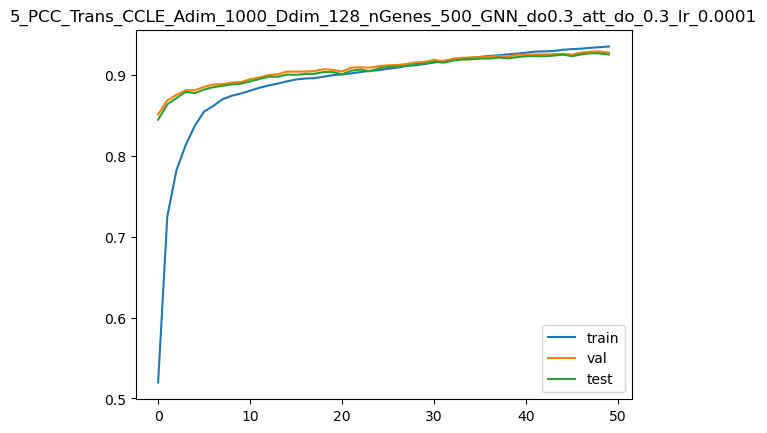

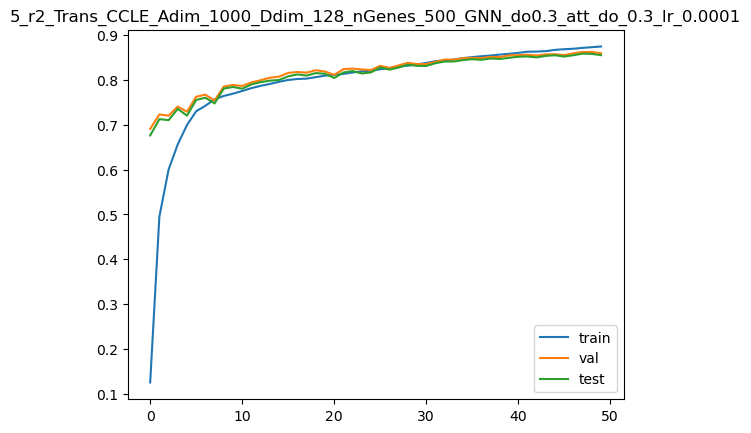

#################### epoch ############################  49


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11174172163009644
The overall Pearson's correlation is 0.9590.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18046902120113373
The overall Pearson's correlation is 0.9125.
Train avg_loss:  0.16253486
Train avg_pcc:  0.9363087325740885
Train r2:  0.8766665804296776


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18985698
Validation avg_pcc:  0.9287634652399409
Validation r2:  0.8623031392856864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18702735
Test avg_pcc:  0.9269885999970565
Test r2:  0.8590304403584508
#################### epoch ############################  50


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12615743279457092
The overall Pearson's correlation is 0.9461.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15521423518657684
The overall Pearson's correlation is 0.9391.
Train avg_loss:  0.16034587
Train avg_pcc:  0.9371944361508031
Train r2:  0.8783276217999293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19046298
Validation avg_pcc:  0.9285347044501369
Validation r2:  0.8618636149412733


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18790524
Test avg_pcc:  0.9266315388909072
Test r2:  0.8583687375895142
#################### epoch ############################  51


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1787632405757904
The overall Pearson's correlation is 0.9409.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10559818148612976
The overall Pearson's correlation is 0.9614.
Train avg_loss:  0.15886377
Train avg_pcc:  0.9377950263314616
Train r2:  0.8794522680480785


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19175011
Validation avg_pcc:  0.9279273341304534
Validation r2:  0.8609301125864509


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18910134
Test avg_pcc:  0.9260389475720542
Test r2:  0.8574672111488184
#################### epoch ############################  52


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13735371828079224
The overall Pearson's correlation is 0.9440.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.181160569190979
The overall Pearson's correlation is 0.9384.
Train avg_loss:  0.1584234
Train avg_pcc:  0.9379726557857649
Train r2:  0.879786418498667


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19297151
Validation avg_pcc:  0.9288345246878604
Validation r2:  0.8600442639634133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.188622
Test avg_pcc:  0.9275842431811039
Test r2:  0.8578285092259688
#################### epoch ############################  53


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11508676409721375
The overall Pearson's correlation is 0.9569.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13638338446617126
The overall Pearson's correlation is 0.9438.
Train avg_loss:  0.15569174
Train avg_pcc:  0.9390778518054045
Train r2:  0.8818592432442256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18980835
Validation avg_pcc:  0.9304978655042371
Validation r2:  0.8623383930517782


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18932022
Test avg_pcc:  0.9277700588766883
Test r2:  0.8573022227948404
#################### epoch ############################  54


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12267106771469116
The overall Pearson's correlation is 0.9455.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.26304733753204346
The overall Pearson's correlation is 0.8953.
Train avg_loss:  0.1536563
Train avg_pcc:  0.9399004091013192
Train r2:  0.8834037349821169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18872184
Validation avg_pcc:  0.9294681889954551
Validation r2:  0.863126411158811
Best Val r2  0.863126411158811


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18690798
Test avg_pcc:  0.9272802277121553
Test r2:  0.8591204231829727
#################### epoch ############################  55


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17610463500022888
The overall Pearson's correlation is 0.9552.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.20155683159828186
The overall Pearson's correlation is 0.9237.
Train avg_loss:  0.15370803
Train avg_pcc:  0.9398780130586679
Train r2:  0.8833644982628408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18456896
Validation avg_pcc:  0.931600706104441
Validation r2:  0.8661383568602603
Best Val r2  0.8661383568602603


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18364698
Test avg_pcc:  0.9290906114391221
Test r2:  0.8615783603332076
#################### epoch ############################  56


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.20412948727607727
The overall Pearson's correlation is 0.9174.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.16961564123630524
The overall Pearson's correlation is 0.9207.
Train avg_loss:  0.15097047
Train avg_pcc:  0.9409826273219057
Train r2:  0.8854417715725129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.19078378
Validation avg_pcc:  0.929964201472156
Validation r2:  0.8616309425743974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1896241
Test avg_pcc:  0.9276261642858513
Test r2:  0.857073169489283
#################### epoch ############################  57


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13175806403160095
The overall Pearson's correlation is 0.9114.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10564704239368439
The overall Pearson's correlation is 0.9597.
Train avg_loss:  0.14953311
Train avg_pcc:  0.9415635911364376
Train r2:  0.8865324682596063


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18492648
Validation avg_pcc:  0.9306219542572608
Validation r2:  0.865879042513364


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18261725
Test avg_pcc:  0.9286995335740711
Test r2:  0.8623545074928711
#################### epoch ############################  58


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.12080930918455124
The overall Pearson's correlation is 0.9662.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11402218043804169
The overall Pearson's correlation is 0.9440.
Train avg_loss:  0.1472443
Train avg_pcc:  0.9424834909105911
Train r2:  0.8882692513560309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18187961
Validation avg_pcc:  0.9322590086130071
Validation r2:  0.8680888505794007
Best Val r2  0.8680888505794007


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18012445
Test avg_pcc:  0.9301465158940133
Test r2:  0.864233428455961
#################### epoch ############################  59


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1964665949344635
The overall Pearson's correlation is 0.9402.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12338817864656448
The overall Pearson's correlation is 0.9356.
Train avg_loss:  0.14642586
Train avg_pcc:  0.9428136337715343
Train r2:  0.8888903012542018


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18621397
Validation avg_pcc:  0.9305469744976772
Validation r2:  0.864945272323862


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18420132
Test avg_pcc:  0.9285496004279735
Test r2:  0.86116054564034
#################### epoch ############################  60


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1515154242515564
The overall Pearson's correlation is 0.9636.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.17703984677791595
The overall Pearson's correlation is 0.9254.
Train avg_loss:  0.1439741
Train avg_pcc:  0.9438000554047554
Train r2:  0.8907507192641291


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18162534
Validation avg_pcc:  0.9320324590185257
Validation r2:  0.8682732538837262
Best Val r2  0.8682732538837262


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18073976
Test avg_pcc:  0.9295917402677116
Test r2:  0.8637696379349257
#################### epoch ############################  61


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15062062442302704
The overall Pearson's correlation is 0.9348.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13773012161254883
The overall Pearson's correlation is 0.9494.
Train avg_loss:  0.14328985
Train avg_pcc:  0.944074467202561
Train r2:  0.8912699353661743


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1858094
Validation avg_pcc:  0.9304008870510632
Validation r2:  0.865238688977192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1823499
Test avg_pcc:  0.9289213873592906
Test r2:  0.8625560185950282
#################### epoch ############################  62


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10254597663879395
The overall Pearson's correlation is 0.9543.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11972716450691223
The overall Pearson's correlation is 0.9465.
Train avg_loss:  0.14054658
Train avg_pcc:  0.945175577006772
Train r2:  0.8933515697392141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18245032
Validation avg_pcc:  0.9317552640281869
Validation r2:  0.8676749248719292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18096463
Test avg_pcc:  0.9295667699400724
Test r2:  0.8636001518522393
#################### epoch ############################  63


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.131219744682312
The overall Pearson's correlation is 0.9456.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10687115043401718
The overall Pearson's correlation is 0.9616.
Train avg_loss:  0.13981405
Train avg_pcc:  0.945469672755673
Train r2:  0.8939074061942163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18385224
Validation avg_pcc:  0.9321437227131185
Validation r2:  0.8666581611002504


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18005626
Test avg_pcc:  0.9308292725964642
Test r2:  0.8642848286907564
#################### epoch ############################  64


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15025965869426727
The overall Pearson's correlation is 0.9011.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1055343821644783
The overall Pearson's correlation is 0.9727.
Train avg_loss:  0.13982114
Train avg_pcc:  0.9454683104966943
Train r2:  0.8939020313973159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18197864
Validation avg_pcc:  0.931705163485403
Validation r2:  0.8680170262204762


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17819504
Test avg_pcc:  0.9304427237868086
Test r2:  0.865687685683435
#################### epoch ############################  65


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09114683419466019
The overall Pearson's correlation is 0.9638.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.15977051854133606
The overall Pearson's correlation is 0.9414.
Train avg_loss:  0.13777126
Train avg_pcc:  0.9462891995952034
Train r2:  0.8954575112188574


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18241401
Validation avg_pcc:  0.93231594792622
Validation r2:  0.8677012657774813


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18174005
Test avg_pcc:  0.9296926303988985
Test r2:  0.8630156895817
#################### epoch ############################  66


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13507482409477234
The overall Pearson's correlation is 0.9554.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13368076086044312
The overall Pearson's correlation is 0.9600.
Train avg_loss:  0.13619715
Train avg_pcc:  0.9469204651922177
Train r2:  0.8966519614968737


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17934287
Validation avg_pcc:  0.9331463306375531
Validation r2:  0.869928649434343
Best Val r2  0.869928649434343


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1756621
Test avg_pcc:  0.9318167175323084
Test r2:  0.8675968576219186
#################### epoch ############################  67


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1289001703262329
The overall Pearson's correlation is 0.9534.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13366669416427612
The overall Pearson's correlation is 0.9492.
Train avg_loss:  0.13455959
Train avg_pcc:  0.94757620062471
Train r2:  0.8978945561998154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17989938
Validation avg_pcc:  0.932729653862619
Validation r2:  0.8695250418984057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1794532
Test avg_pcc:  0.9301287216071961
Test r2:  0.8647393705708284
#################### epoch ############################  68


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14722347259521484
The overall Pearson's correlation is 0.9538.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.18738526105880737
The overall Pearson's correlation is 0.9052.
Train avg_loss:  0.13366026
Train avg_pcc:  0.9479366514335539
Train r2:  0.8985769921099872


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1823945
Validation avg_pcc:  0.932809192799869
Validation r2:  0.8677154120874201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17936702
Test avg_pcc:  0.931234604195466
Test r2:  0.8648043136607467
#################### epoch ############################  69


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10802175104618073
The overall Pearson's correlation is 0.9540.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12243153154850006
The overall Pearson's correlation is 0.9605.
Train avg_loss:  0.13262475
Train avg_pcc:  0.9483510349482844
Train r2:  0.8993627379106062


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17983551
Validation avg_pcc:  0.9329887848513536
Validation r2:  0.8695713625517825


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17734906
Test avg_pcc:  0.9312284545413108
Test r2:  0.8663253425356576
#################### epoch ############################  70


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.18202953040599823
The overall Pearson's correlation is 0.9248.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14669206738471985
The overall Pearson's correlation is 0.9504.
Train avg_loss:  0.13156529
Train avg_pcc:  0.9487739877529008
Train r2:  0.9001666748857939


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1800328
Validation avg_pcc:  0.9329688542254366
Validation r2:  0.869428266736689


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.176913
Test avg_pcc:  0.9314008390359969
Test r2:  0.8666540238273175
#################### epoch ############################  71


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13685046136379242
The overall Pearson's correlation is 0.9400.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10829627513885498
The overall Pearson's correlation is 0.9518.
Train avg_loss:  0.13056166
Train avg_pcc:  0.9491759130812575
Train r2:  0.9009282299621885


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18242268
Validation avg_pcc:  0.9335774678860058
Validation r2:  0.8676949681119817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.18006377
Test avg_pcc:  0.931691276948832
Test r2:  0.8642791647765327
#################### epoch ############################  72


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1336911916732788
The overall Pearson's correlation is 0.9431.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08369014412164688
The overall Pearson's correlation is 0.9622.
Train avg_loss:  0.12924023
Train avg_pcc:  0.9497029598175849
Train r2:  0.9019309575852571


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17824335
Validation avg_pcc:  0.9339412993241807
Validation r2:  0.87072610425206
Best Val r2  0.87072610425206


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17528751
Test avg_pcc:  0.932314757124617
Test r2:  0.8678791972457696
#################### epoch ############################  73


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1437157541513443
The overall Pearson's correlation is 0.9532.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1165289431810379
The overall Pearson's correlation is 0.9541.
Train avg_loss:  0.12835221
Train avg_pcc:  0.9500575731362508
Train r2:  0.9026047956935439


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18045421
Validation avg_pcc:  0.9328524434182686
Validation r2:  0.8691226339615636


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17861326
Test avg_pcc:  0.9307215789793789
Test r2:  0.8653724618959009
#################### epoch ############################  74


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11894342303276062
The overall Pearson's correlation is 0.9611.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1087881550192833
The overall Pearson's correlation is 0.9586.
Train avg_loss:  0.12662707
Train avg_pcc:  0.9507471171891934
Train r2:  0.9039138443309029


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17874512
Validation avg_pcc:  0.933483991724259
Validation r2:  0.8703621885383186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1772697
Test avg_pcc:  0.9313456052257186
Test r2:  0.8663851663320676
#################### epoch ############################  75


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11316128820180893
The overall Pearson's correlation is 0.9554.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1479409635066986
The overall Pearson's correlation is 0.9305.
Train avg_loss:  0.12571977
Train avg_pcc:  0.9511084419625377
Train r2:  0.904602337681495


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17938098
Validation avg_pcc:  0.9327860913294538
Validation r2:  0.8699010127064706


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17764983
Test avg_pcc:  0.9307885840028012
Test r2:  0.8660986406726557
#################### epoch ############################  76


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13750551640987396
The overall Pearson's correlation is 0.9494.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1371806263923645
The overall Pearson's correlation is 0.9608.
Train avg_loss:  0.12481652
Train avg_pcc:  0.9514693287942751
Train r2:  0.9052877185738925


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18418947
Validation avg_pcc:  0.9339980148418373
Validation r2:  0.8664135827300683


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17896432
Test avg_pcc:  0.9332786998554026
Test r2:  0.8651078571396806
#################### epoch ############################  77


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.15366244316101074
The overall Pearson's correlation is 0.9460.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11789312958717346
The overall Pearson's correlation is 0.9633.
Train avg_loss:  0.12351635
Train avg_pcc:  0.9519866392400606
Train r2:  0.906274303478425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1787933
Validation avg_pcc:  0.9331297346883989
Validation r2:  0.8703272392734533


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17551047
Test avg_pcc:  0.9317044674119008
Test r2:  0.8677111557198901
#################### epoch ############################  78


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.17921866476535797
The overall Pearson's correlation is 0.9308.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10005223751068115
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.122147344
Train avg_pcc:  0.9525339241098314
Train r2:  0.9073131310566417


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17997292
Validation avg_pcc:  0.9338365245506636
Validation r2:  0.8694717047640724


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17825423
Test avg_pcc:  0.9315712080074849
Test r2:  0.8656430795767321
#################### epoch ############################  79


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09445294737815857
The overall Pearson's correlation is 0.9722.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09580805897712708
The overall Pearson's correlation is 0.9570.
Train avg_loss:  0.12156905
Train avg_pcc:  0.9527627620183187
Train r2:  0.9077519374742471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17548238
Validation avg_pcc:  0.9353985615320923
Validation r2:  0.8727285404254934
Best Val r2  0.8727285404254934


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17453042
Test avg_pcc:  0.9328874125409908
Test r2:  0.8684498641165107
#################### epoch ############################  80


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.14978700876235962
The overall Pearson's correlation is 0.9276.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10887721180915833
The overall Pearson's correlation is 0.9603.
Train avg_loss:  0.12048731
Train avg_pcc:  0.95319353331745
Train r2:  0.9085727849425256


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17564897
Validation avg_pcc:  0.9350549304169549
Validation r2:  0.8726077177838993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17350028
Test avg_pcc:  0.9331525182128713
Test r2:  0.8692263063456753
#################### epoch ############################  81


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07280218601226807
The overall Pearson's correlation is 0.9658.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12839943170547485
The overall Pearson's correlation is 0.9510.
Train avg_loss:  0.11960332
Train avg_pcc:  0.953545319938554
Train r2:  0.9092435632805308


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18059489
Validation avg_pcc:  0.9324709036811331
Validation r2:  0.869020612850528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.177243
Test avg_pcc:  0.9310381380496772
Test r2:  0.8664052898781052
#################### epoch ############################  82


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13702663779258728
The overall Pearson's correlation is 0.9580.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08923010528087616
The overall Pearson's correlation is 0.9565.
Train avg_loss:  0.11916068
Train avg_pcc:  0.9537217177823195
Train r2:  0.9095794338361318


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17558612
Validation avg_pcc:  0.9343614184986955
Validation r2:  0.8726533011258609


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17349958
Test avg_pcc:  0.9324918586441671
Test r2:  0.8692268428344967
#################### epoch ############################  83


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07064968347549438
The overall Pearson's correlation is 0.9703.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1137252226471901
The overall Pearson's correlation is 0.9549.
Train avg_loss:  0.11940156
Train avg_pcc:  0.9536252515420441
Train r2:  0.9093966625344339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.18301412
Validation avg_pcc:  0.9330010824901008
Validation r2:  0.8672660238059534


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17895448
Test avg_pcc:  0.9317993408245439
Test r2:  0.8651152685517884
#################### epoch ############################  84


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1260843276977539
The overall Pearson's correlation is 0.9266.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11458262801170349
The overall Pearson's correlation is 0.9575.
Train avg_loss:  0.118257366
Train avg_pcc:  0.954082113648482
Train r2:  0.9102648774240437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17797883
Validation avg_pcc:  0.9334536158493798
Validation r2:  0.8709179468362378


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17448096
Test avg_pcc:  0.9321062104503859
Test r2:  0.868487136691723
#################### epoch ############################  85


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08441228419542313
The overall Pearson's correlation is 0.9590.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13106057047843933
The overall Pearson's correlation is 0.9590.
Train avg_loss:  0.11665836
Train avg_pcc:  0.9547166564807794
Train r2:  0.9114782269170301


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17312855
Validation avg_pcc:  0.9354729428058879
Validation r2:  0.8744356973863028
Best Val r2  0.8744356973863028


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17137663
Test avg_pcc:  0.9335057426403469
Test r2:  0.8708269799208119
#################### epoch ############################  86


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10851334035396576
The overall Pearson's correlation is 0.9592.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12279349565505981
The overall Pearson's correlation is 0.9420.
Train avg_loss:  0.11558405
Train avg_pcc:  0.9551433407338259
Train r2:  0.912293430160764


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1741094
Validation avg_pcc:  0.9355200102593126
Validation r2:  0.8737243077008283


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1722776
Test avg_pcc:  0.9335600857378629
Test r2:  0.8701479001977697
#################### epoch ############################  87


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09042052924633026
The overall Pearson's correlation is 0.9680.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11104603856801987
The overall Pearson's correlation is 0.9608.
Train avg_loss:  0.11516889
Train avg_pcc:  0.9553090656414789
Train r2:  0.9126084682978053


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17625904
Validation avg_pcc:  0.9348446267363695
Validation r2:  0.8721652623525201


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17294642
Test avg_pcc:  0.9333373477437158
Test r2:  0.8696437690100047
#################### epoch ############################  88


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11222044378519058
The overall Pearson's correlation is 0.9500.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09737394750118256
The overall Pearson's correlation is 0.9720.
Train avg_loss:  0.11398529
Train avg_pcc:  0.9557780129704632
Train r2:  0.9135065925063329


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17546576
Validation avg_pcc:  0.9344083840640547
Validation r2:  0.8727405946502109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17221825
Test avg_pcc:  0.9330016305092619
Test r2:  0.8701926290603528
#################### epoch ############################  89


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09979405999183655
The overall Pearson's correlation is 0.9618.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11076228320598602
The overall Pearson's correlation is 0.9417.
Train avg_loss:  0.112966515
Train avg_pcc:  0.9561821731094007
Train r2:  0.9142796411267553


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17341317
Validation avg_pcc:  0.9350606244859014
Validation r2:  0.8742292685449438


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1700442
Test avg_pcc:  0.9337524770963418
Test r2:  0.8718312906348739
#################### epoch ############################  90


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08590523898601532
The overall Pearson's correlation is 0.9711.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.122901052236557
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.11234698
Train avg_pcc:  0.9564287479505108
Train r2:  0.9147497523442794


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17587806
Validation avg_pcc:  0.935894725681456
Validation r2:  0.8724415595518972


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17437057
Test avg_pcc:  0.9336732492795221
Test r2:  0.8685703419073463
#################### epoch ############################  91


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07297194004058838
The overall Pearson's correlation is 0.9749.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09781017899513245
The overall Pearson's correlation is 0.9571.
Train avg_loss:  0.11111472
Train avg_pcc:  0.9569170139100909
Train r2:  0.9156848191576685


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17394654
Validation avg_pcc:  0.9348811123312861
Validation r2:  0.8738424352117937


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17149372
Test avg_pcc:  0.9331824010709384
Test r2:  0.8707387248648535
#################### epoch ############################  92


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.109040766954422
The overall Pearson's correlation is 0.9625.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13580918312072754
The overall Pearson's correlation is 0.9461.
Train avg_loss:  0.11106048
Train avg_pcc:  0.9569379461763888
Train r2:  0.915725972810226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17277832
Validation avg_pcc:  0.9356885015913008
Validation r2:  0.8746897084022132
Best Val r2  0.8746897084022132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17216781
Test avg_pcc:  0.9331377685248636
Test r2:  0.8702306306930616
#################### epoch ############################  93


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13979510962963104
The overall Pearson's correlation is 0.9634.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11743394285440445
The overall Pearson's correlation is 0.9635.
Train avg_loss:  0.11023692
Train avg_pcc:  0.9572653495181014
Train r2:  0.9163508951178558


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17406513
Validation avg_pcc:  0.935535143325104
Validation r2:  0.8737564178143273


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17128338
Test avg_pcc:  0.9338499031655096
Test r2:  0.8708972747875166
#################### epoch ############################  94


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11013549566268921
The overall Pearson's correlation is 0.9561.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11038525402545929
The overall Pearson's correlation is 0.9614.
Train avg_loss:  0.10971388
Train avg_pcc:  0.9574712398408182
Train r2:  0.916747781303425


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1749761
Validation avg_pcc:  0.9349979170503679
Validation r2:  0.8730957319756905


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17152834
Test avg_pcc:  0.9337125151014243
Test r2:  0.8707126379395291
#################### epoch ############################  95


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0873219445347786
The overall Pearson's correlation is 0.9646.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10900740325450897
The overall Pearson's correlation is 0.9606.
Train avg_loss:  0.10861194
Train avg_pcc:  0.957909047711364
Train r2:  0.9175839550099486


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17242774
Validation avg_pcc:  0.936206728379005
Validation r2:  0.8749439559290144
Best Val r2  0.8749439559290144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16876146
Test avg_pcc:  0.9349688396775687
Test r2:  0.8727981376595525
#################### epoch ############################  96


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.2223944216966629
The overall Pearson's correlation is 0.9277.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08621644228696823
The overall Pearson's correlation is 0.9681.
Train avg_loss:  0.10859858
Train avg_pcc:  0.9579132931696133
Train r2:  0.9175940937329911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17160183
Validation avg_pcc:  0.9363217343388845
Validation r2:  0.8755429739169851
Best Val r2  0.8755429739169851


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16793512
Test avg_pcc:  0.9351653997016666
Test r2:  0.8734209889091196
#################### epoch ############################  97


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09345821291208267
The overall Pearson's correlation is 0.9590.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.23306839168071747
The overall Pearson's correlation is 0.9023.
Train avg_loss:  0.10702393
Train avg_pcc:  0.9585382840719296
Train r2:  0.9187889474271197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1740172
Validation avg_pcc:  0.9352902415296015
Validation r2:  0.8737911811878185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16983895
Test avg_pcc:  0.9343086022603683
Test r2:  0.8719859928054268
#################### epoch ############################  98


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0819680318236351
The overall Pearson's correlation is 0.9693.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09568937122821808
The overall Pearson's correlation is 0.9550.
Train avg_loss:  0.1068394
Train avg_pcc:  0.9586106763545185
Train r2:  0.9189289681360618


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17145647
Validation avg_pcc:  0.937076825992583
Validation r2:  0.8756483912766748
Best Val r2  0.8756483912766748


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16947109
Test avg_pcc:  0.9351125569604709
Test r2:  0.8722632793619759


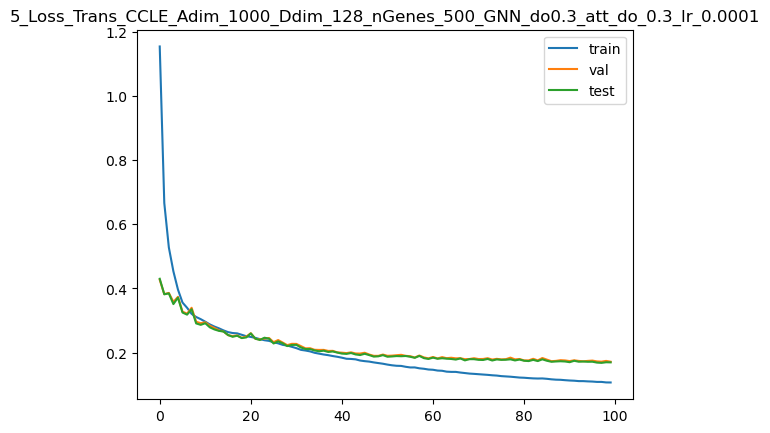

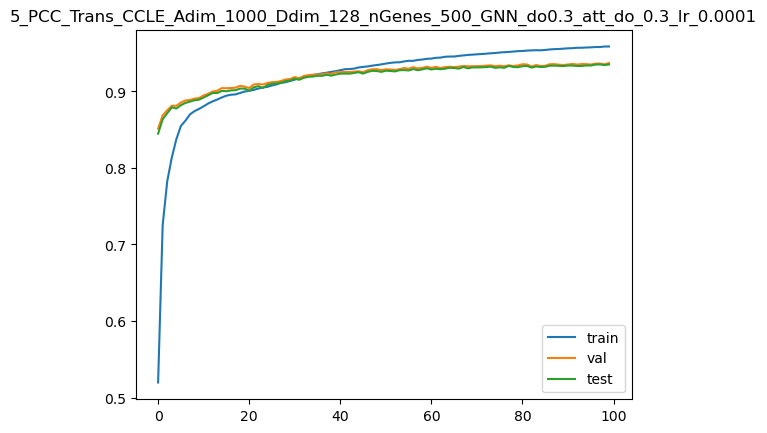

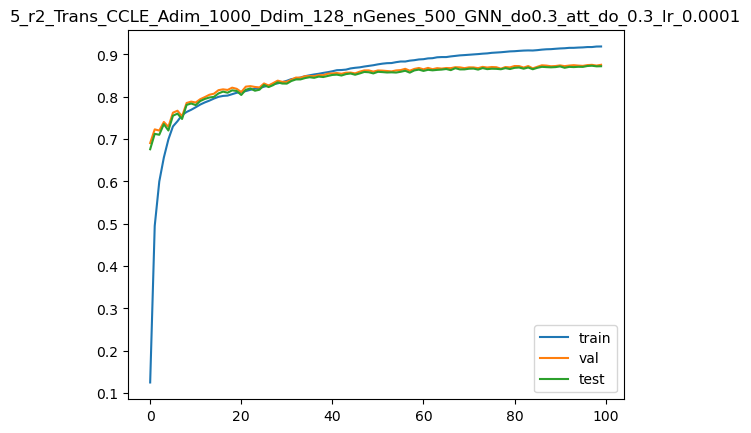

#################### epoch ############################  99


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10794977843761444
The overall Pearson's correlation is 0.9663.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09422095865011215
The overall Pearson's correlation is 0.9633.
Train avg_loss:  0.10639081
Train avg_pcc:  0.9587879158348378
Train r2:  0.9192693701176202


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17199726
Validation avg_pcc:  0.9365130822660528
Validation r2:  0.8752561832280005


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1692591
Test avg_pcc:  0.9348483406234652
Test r2:  0.8724230463750445
#################### epoch ############################  100


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1391160786151886
The overall Pearson's correlation is 0.9573.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12435396015644073
The overall Pearson's correlation is 0.9556.
Train avg_loss:  0.105331965
Train avg_pcc:  0.9592070004192966
Train r2:  0.9200728368272452


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17072815
Validation avg_pcc:  0.9366527544574275
Validation r2:  0.8761766252314592
Best Val r2  0.8761766252314592


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16896728
Test avg_pcc:  0.9346393818842926
Test r2:  0.8726430079892593
#################### epoch ############################  101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08849243819713593
The overall Pearson's correlation is 0.9664.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07902447879314423
The overall Pearson's correlation is 0.9593.
Train avg_loss:  0.10530682
Train avg_pcc:  0.9592168465676467
Train r2:  0.9200919131027173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1694342
Validation avg_pcc:  0.9368849788883119
Validation r2:  0.877115075139359
Best Val r2  0.877115075139359


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1681537
Test avg_pcc:  0.9347450662677311
Test r2:  0.8732562280989327
#################### epoch ############################  102


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07335268706083298
The overall Pearson's correlation is 0.9767.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09973680973052979
The overall Pearson's correlation is 0.9429.
Train avg_loss:  0.102822006
Train avg_pcc:  0.9601982370785435
Train r2:  0.9219774187011611


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16863851
Validation avg_pcc:  0.9372480058130231
Validation r2:  0.8776921721884081
Best Val r2  0.8776921721884081


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16754831
Test avg_pcc:  0.9351766231810775
Test r2:  0.8737125365721972
#################### epoch ############################  103


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08111067116260529
The overall Pearson's correlation is 0.9749.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08600657433271408
The overall Pearson's correlation is 0.9649.
Train avg_loss:  0.104323335
Train avg_pcc:  0.9596062363143406
Train r2:  0.9208381988017139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17292339
Validation avg_pcc:  0.9358499521664366
Validation r2:  0.8745844981991584


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17026266
Test avg_pcc:  0.9342637696769488
Test r2:  0.8716666167886329
#################### epoch ############################  104


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08337949961423874
The overall Pearson's correlation is 0.9383.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08392234146595001
The overall Pearson's correlation is 0.9783.
Train avg_loss:  0.103249505
Train avg_pcc:  0.9600303369928761
Train r2:  0.9216530354548433


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17051762
Validation avg_pcc:  0.936232012043461
Validation r2:  0.8763293075050638


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16837005
Test avg_pcc:  0.9344727072075917
Test r2:  0.8730931478998424
#################### epoch ############################  105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.13551950454711914
The overall Pearson's correlation is 0.9480.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09686078131198883
The overall Pearson's correlation is 0.9643.
Train avg_loss:  0.10242368
Train avg_pcc:  0.9603562559667972
Train r2:  0.9222796746670859


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17297477
Validation avg_pcc:  0.9361017538804034
Validation r2:  0.8745472387678938


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16956589
Test avg_pcc:  0.9346518609375722
Test r2:  0.8721918076360937
#################### epoch ############################  106


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0801292359828949
The overall Pearson's correlation is 0.9762.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08548663556575775
The overall Pearson's correlation is 0.9669.
Train avg_loss:  0.1017919
Train avg_pcc:  0.9606057008399889
Train r2:  0.9227590843519277


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1682061
Validation avg_pcc:  0.9371324458009539
Validation r2:  0.8780057772903908
Best Val r2  0.8780057772903908


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16678496
Test avg_pcc:  0.9351110372567677
Test r2:  0.8742878945496282
#################### epoch ############################  107


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10666025429964066
The overall Pearson's correlation is 0.9334.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11679702997207642
The overall Pearson's correlation is 0.9542.
Train avg_loss:  0.10092818
Train avg_pcc:  0.9609472600740306
Train r2:  0.9234144787360911


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17302859
Validation avg_pcc:  0.9363555105452382
Validation r2:  0.8745081886841184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17042148
Test avg_pcc:  0.9347729756627616
Test r2:  0.8715469126029188
#################### epoch ############################  108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0880725234746933
The overall Pearson's correlation is 0.9622.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08567734807729721
The overall Pearson's correlation is 0.9735.
Train avg_loss:  0.100546755
Train avg_pcc:  0.9610978444389172
Train r2:  0.9237039055334464


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17334767
Validation avg_pcc:  0.936064120820169
Validation r2:  0.8742767772734491


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16906945
Test avg_pcc:  0.9350287275547976
Test r2:  0.8725659877992481
#################### epoch ############################  109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11093521863222122
The overall Pearson's correlation is 0.9673.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09454737603664398
The overall Pearson's correlation is 0.9695.
Train avg_loss:  0.100342534
Train avg_pcc:  0.9611781982419433
Train r2:  0.9238588753175596


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17398444
Validation avg_pcc:  0.9359967345795503
Validation r2:  0.8738149450411734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17089473
Test avg_pcc:  0.9345563919080542
Test r2:  0.871190218955856
#################### epoch ############################  110


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10767407715320587
The overall Pearson's correlation is 0.9511.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10453340411186218
The overall Pearson's correlation is 0.9697.
Train avg_loss:  0.098743536
Train avg_pcc:  0.9618085646973191
Train r2:  0.9250722205958817


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17041269
Validation avg_pcc:  0.9366852294924173
Validation r2:  0.876405421468465


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16850479
Test avg_pcc:  0.9346934707258762
Test r2:  0.8729915849387695
#################### epoch ############################  111


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07191434502601624
The overall Pearson's correlation is 0.9695.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11980069428682327
The overall Pearson's correlation is 0.9606.
Train avg_loss:  0.09894218
Train avg_pcc:  0.961731480719523
Train r2:  0.9249214813118942


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17375097
Validation avg_pcc:  0.9360911567516006
Validation r2:  0.8739842684137453


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17038666
Test avg_pcc:  0.9346284669860525
Test r2:  0.8715731544002099
#################### epoch ############################  112


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07715874165296555
The overall Pearson's correlation is 0.9696.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07500245422124863
The overall Pearson's correlation is 0.9605.
Train avg_loss:  0.098642334
Train avg_pcc:  0.9618490171650936
Train r2:  0.925149004363094


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16852482
Validation avg_pcc:  0.9372034704059831
Validation r2:  0.8777746216434928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1661732
Test avg_pcc:  0.9355435521303913
Test r2:  0.8747490001274196
#################### epoch ############################  113


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09968598186969757
The overall Pearson's correlation is 0.9547.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08410795032978058
The overall Pearson's correlation is 0.9784.
Train avg_loss:  0.09816573
Train avg_pcc:  0.9620371596778861
Train r2:  0.9255106685764792


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17246094
Validation avg_pcc:  0.9367113260009582
Validation r2:  0.8749198851261615


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17125204
Test avg_pcc:  0.9344446800252991
Test r2:  0.8709208861170796
#################### epoch ############################  114


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07680504769086838
The overall Pearson's correlation is 0.9638.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10577547550201416
The overall Pearson's correlation is 0.9551.
Train avg_loss:  0.09765645
Train avg_pcc:  0.9622377353858733
Train r2:  0.9258971143245844


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16664945
Validation avg_pcc:  0.9377207453556405
Validation r2:  0.8791347738207375
Best Val r2  0.8791347738207375


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16520521
Test avg_pcc:  0.9357394365045856
Test r2:  0.8754786230309316
#################### epoch ############################  115


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.1032661721110344
The overall Pearson's correlation is 0.9619.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12745289504528046
The overall Pearson's correlation is 0.9566.
Train avg_loss:  0.09684265
Train avg_pcc:  0.9625587668513023
Train r2:  0.9265146337485493


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17150027
Validation avg_pcc:  0.936929011068712
Validation r2:  0.8756166458676469


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16841236
Test avg_pcc:  0.9354088314537072
Test r2:  0.8730612704374383
#################### epoch ############################  116


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08318847417831421
The overall Pearson's correlation is 0.9698.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09543699026107788
The overall Pearson's correlation is 0.9730.
Train avg_loss:  0.09595987
Train avg_pcc:  0.9629064535091412
Train r2:  0.9271844878844485


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17006491
Validation avg_pcc:  0.9377458164219848
Validation r2:  0.8766576524378061


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16720705
Test avg_pcc:  0.9361747582689712
Test r2:  0.873969756272802
#################### epoch ############################  117


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09931260347366333
The overall Pearson's correlation is 0.9624.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.1126900464296341
The overall Pearson's correlation is 0.9522.
Train avg_loss:  0.096135415
Train avg_pcc:  0.9628375509828877
Train r2:  0.9270512923462141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17058241
Validation avg_pcc:  0.9368192120415064
Validation r2:  0.8762823166230047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16757917
Test avg_pcc:  0.9353587841213895
Test r2:  0.8736892704230284
#################### epoch ############################  118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11145700514316559
The overall Pearson's correlation is 0.9577.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.11311479657888412
The overall Pearson's correlation is 0.9578.
Train avg_loss:  0.09564384
Train avg_pcc:  0.9630314039495333
Train r2:  0.9274243023122821


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16953921
Validation avg_pcc:  0.9368676757560349
Validation r2:  0.8770389210872331


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16670881
Test avg_pcc:  0.9354419997527292
Test r2:  0.8743452949698118
#################### epoch ############################  119


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09347403049468994
The overall Pearson's correlation is 0.9660.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13860997557640076
The overall Pearson's correlation is 0.9633.
Train avg_loss:  0.09441614
Train avg_pcc:  0.9635144112412865
Train r2:  0.9283558856804756


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17097442
Validation avg_pcc:  0.9374264686077182
Validation r2:  0.8759980105848304


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16868065
Test avg_pcc:  0.9355708297216666
Test r2:  0.8728590423312079
#################### epoch ############################  120


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.19818192720413208
The overall Pearson's correlation is 0.9129.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09098725765943527
The overall Pearson's correlation is 0.9511.
Train avg_loss:  0.09399746
Train avg_pcc:  0.963679462433073
Train r2:  0.9286735871408336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17338705
Validation avg_pcc:  0.936376484520134
Validation r2:  0.8742482111282662


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16932297
Test avg_pcc:  0.9351230360431135
Test r2:  0.872374914589131
#################### epoch ############################  121


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0734999030828476
The overall Pearson's correlation is 0.9652.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.059625253081321716
The overall Pearson's correlation is 0.9654.
Train avg_loss:  0.09436102
Train avg_pcc:  0.9635361426343845
Train r2:  0.9283977250044166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17291461
Validation avg_pcc:  0.9357065096323433
Validation r2:  0.8745908597653396


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16844106
Test avg_pcc:  0.9348458870683882
Test r2:  0.8730396367089815
#################### epoch ############################  122


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08089088648557663
The overall Pearson's correlation is 0.9711.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08287013322114944
The overall Pearson's correlation is 0.9597.
Train avg_loss:  0.09384577
Train avg_pcc:  0.9637399018929115
Train r2:  0.9287887014336389


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17380977
Validation avg_pcc:  0.9362578888425008
Validation r2:  0.8739416248046269


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.17003322
Test avg_pcc:  0.9349873572816643
Test r2:  0.8718395708569298
#################### epoch ############################  123


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08476749807596207
The overall Pearson's correlation is 0.9509.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.12135946750640869
The overall Pearson's correlation is 0.9633.
Train avg_loss:  0.09294998
Train avg_pcc:  0.9640914576008717
Train r2:  0.9294684330059237


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16958158
Validation avg_pcc:  0.9375812461392682
Validation r2:  0.8770081920345022


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1659868
Test avg_pcc:  0.9362718181017948
Test r2:  0.8748894991134248
#################### epoch ############################  124


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07518799602985382
The overall Pearson's correlation is 0.9628.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06959491968154907
The overall Pearson's correlation is 0.9674.
Train avg_loss:  0.09220143
Train avg_pcc:  0.9643860277168074
Train r2:  0.9300364525523734


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16848494
Validation avg_pcc:  0.9377916425937188
Validation r2:  0.8778035548470631


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16558434
Test avg_pcc:  0.9364331669473109
Test r2:  0.875192847911476
#################### epoch ############################  125


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08629816025495529
The overall Pearson's correlation is 0.9747.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06816038489341736
The overall Pearson's correlation is 0.9690.
Train avg_loss:  0.09239646
Train avg_pcc:  0.9643094749252668
Train r2:  0.929888458211547


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16988438
Validation avg_pcc:  0.9364653084191468
Validation r2:  0.8767885790103909


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16581504
Test avg_pcc:  0.9354664668629298
Test r2:  0.8750189597416617
#################### epoch ############################  126


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07893235981464386
The overall Pearson's correlation is 0.9657.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0876719057559967
The overall Pearson's correlation is 0.9620.
Train avg_loss:  0.091696784
Train avg_pcc:  0.964584869833597
Train r2:  0.9304193813284223


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17134546
Validation avg_pcc:  0.9366556858027317
Validation r2:  0.8757289056056297


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16826737
Test avg_pcc:  0.9351609310907403
Test r2:  0.873170554764731
#################### epoch ############################  127


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0805850625038147
The overall Pearson's correlation is 0.9709.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09436281025409698
The overall Pearson's correlation is 0.9581.
Train avg_loss:  0.091192946
Train avg_pcc:  0.9647825027420229
Train r2:  0.9308016906977955


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17063321
Validation avg_pcc:  0.9368418949078217
Validation r2:  0.8762454817763872


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16655068
Test avg_pcc:  0.9358213131101604
Test r2:  0.8744644827576662
#################### epoch ############################  128


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07760415971279144
The overall Pearson's correlation is 0.9695.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0758189707994461
The overall Pearson's correlation is 0.9712.
Train avg_loss:  0.091110416
Train avg_pcc:  0.9648151887701727
Train r2:  0.9308643229909971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16911961
Validation avg_pcc:  0.9368864841606326
Validation r2:  0.8773432453857569


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16459559
Test avg_pcc:  0.936120744109185
Test r2:  0.8759380967928889
#################### epoch ############################  129


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09202450513839722
The overall Pearson's correlation is 0.9651.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06601344794034958
The overall Pearson's correlation is 0.9676.
Train avg_loss:  0.0901606
Train avg_pcc:  0.9651887328012103
Train r2:  0.9315850497045108


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16871686
Validation avg_pcc:  0.9372773071786162
Validation r2:  0.8776353411444311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16536625
Test avg_pcc:  0.9360710728792743
Test r2:  0.8753572359354508
#################### epoch ############################  130


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08853709697723389
The overall Pearson's correlation is 0.9690.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08974554389715195
The overall Pearson's correlation is 0.9652.
Train avg_loss:  0.08991577
Train avg_pcc:  0.9652852006235355
Train r2:  0.9317708361692311


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1737219
Validation avg_pcc:  0.9367666097928152
Validation r2:  0.874005362273763


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16966976
Test avg_pcc:  0.93561443331061
Test r2:  0.8721135082602279
#################### epoch ############################  131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08099420368671417
The overall Pearson's correlation is 0.9789.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07273177802562714
The overall Pearson's correlation is 0.9712.
Train avg_loss:  0.08943819
Train avg_pcc:  0.9654725576618025
Train r2:  0.9321332191574281


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17265375
Validation avg_pcc:  0.9369100824798948
Validation r2:  0.874780047589921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16776234
Test avg_pcc:  0.9361513330565268
Test r2:  0.8735512121810016
#################### epoch ############################  132


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09834828972816467
The overall Pearson's correlation is 0.9641.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08585920929908752
The overall Pearson's correlation is 0.9670.
Train avg_loss:  0.089322805
Train avg_pcc:  0.9655177243725981
Train r2:  0.9322207854741901


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1711088
Validation avg_pcc:  0.9365648159625094
Validation r2:  0.8759005601260921


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16754226
Test avg_pcc:  0.9353131502544739
Test r2:  0.8737170951602727
#################### epoch ############################  133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06805408000946045
The overall Pearson's correlation is 0.9786.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07008331269025803
The overall Pearson's correlation is 0.9682.
Train avg_loss:  0.08888086
Train avg_pcc:  0.9656922462241992
Train r2:  0.9325561359197216


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16940297
Validation avg_pcc:  0.9374451275573085
Validation r2:  0.8771377346694539


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16670083
Test avg_pcc:  0.9358949479715925
Test r2:  0.8743513240734688
#################### epoch ############################  134


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10832039266824722
The overall Pearson's correlation is 0.9414.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.13180634379386902
The overall Pearson's correlation is 0.9546.
Train avg_loss:  0.08846346
Train avg_pcc:  0.9658554667581282
Train r2:  0.9328728586339282


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16935685
Validation avg_pcc:  0.937940570692749
Validation r2:  0.8771711843393966


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1668437
Test avg_pcc:  0.9362374574235905
Test r2:  0.874243623728967
#################### epoch ############################  135


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.055099621415138245
The overall Pearson's correlation is 0.9825.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10270313918590546
The overall Pearson's correlation is 0.9437.
Train avg_loss:  0.0885385
Train avg_pcc:  0.9658264904769644
Train r2:  0.9328159236614105


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17122422
Validation avg_pcc:  0.9367362374851557
Validation r2:  0.8758168342176392


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1669372
Test avg_pcc:  0.935654607495599
Test r2:  0.8741731446202066
#################### epoch ############################  136


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.11460112780332565
The overall Pearson's correlation is 0.9608.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06681689620018005
The overall Pearson's correlation is 0.9653.
Train avg_loss:  0.08803073
Train avg_pcc:  0.9660256438080445
Train r2:  0.9332012207849398


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17050785
Validation avg_pcc:  0.9370854375466402
Validation r2:  0.8763364004792047


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16571909
Test avg_pcc:  0.9363216871920909
Test r2:  0.8750912873781285
#################### epoch ############################  137


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08785408735275269
The overall Pearson's correlation is 0.9604.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06961104273796082
The overall Pearson's correlation is 0.9847.
Train avg_loss:  0.087734595
Train avg_pcc:  0.9661420825618616
Train r2:  0.9334259334269246


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17121106
Validation avg_pcc:  0.9369550059442612
Validation r2:  0.8758263822735155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16805696
Test avg_pcc:  0.9355355155712389
Test r2:  0.8733291358041486
#################### epoch ############################  138


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08806508034467697
The overall Pearson's correlation is 0.9269.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10017873346805573
The overall Pearson's correlation is 0.9399.
Train avg_loss:  0.087792024
Train avg_pcc:  0.9661196514524306
Train r2:  0.9333823541657236


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.170349
Validation avg_pcc:  0.9367373757932581
Validation r2:  0.876451602873517


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1666178
Test avg_pcc:  0.9355545182628776
Test r2:  0.8744138870526047
#################### epoch ############################  139


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07982312887907028
The overall Pearson's correlation is 0.9721.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06735758483409882
The overall Pearson's correlation is 0.9764.
Train avg_loss:  0.08596892
Train avg_pcc:  0.9668348599193924
Train r2:  0.9347657453752747


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17134859
Validation avg_pcc:  0.9361957947808021
Validation r2:  0.875726642112703


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16714863
Test avg_pcc:  0.9351832691609174
Test r2:  0.8740137742400806
#################### epoch ############################  140


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07720085233449936
The overall Pearson's correlation is 0.9744.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06654133647680283
The overall Pearson's correlation is 0.9826.
Train avg_loss:  0.086488806
Train avg_pcc:  0.966630737348439
Train r2:  0.9343712546711074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1709608
Validation avg_pcc:  0.9373522879293238
Validation r2:  0.8760078936333293


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16844645
Test avg_pcc:  0.9356812436754574
Test r2:  0.8730355829884955
#################### epoch ############################  141


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08238149434328079
The overall Pearson's correlation is 0.9713.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0905277281999588
The overall Pearson's correlation is 0.9628.
Train avg_loss:  0.08596439
Train avg_pcc:  0.9668366978091397
Train r2:  0.9347691848544379


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16955641
Validation avg_pcc:  0.9381299466018229
Validation r2:  0.8770264487104642


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16596891
Test avg_pcc:  0.9369792627787876
Test r2:  0.874902982656236
#################### epoch ############################  142


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08366204053163528
The overall Pearson's correlation is 0.9748.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10108137130737305
The overall Pearson's correlation is 0.9494.
Train avg_loss:  0.086230256
Train avg_pcc:  0.9667328215921103
Train r2:  0.9345674464079358


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17022428
Validation avg_pcc:  0.9371784645215835
Validation r2:  0.8765420684219738


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16606766
Test avg_pcc:  0.9361956794149762
Test r2:  0.8748285563249649
#################### epoch ############################  143


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07474663108587265
The overall Pearson's correlation is 0.9603.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08819963037967682
The overall Pearson's correlation is 0.9824.
Train avg_loss:  0.08601717
Train avg_pcc:  0.9668160799161428
Train r2:  0.9347291357411528


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17181262
Validation avg_pcc:  0.9366777467540421
Validation r2:  0.8753900893972195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1673883
Test avg_pcc:  0.935746870735238
Test r2:  0.8738331316255556
#################### epoch ############################  144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08465021848678589
The overall Pearson's correlation is 0.9677.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07531023025512695
The overall Pearson's correlation is 0.9659.
Train avg_loss:  0.085374616
Train avg_pcc:  0.9670681367829956
Train r2:  0.9352167143658118


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1684993
Validation avg_pcc:  0.9378309021258366
Validation r2:  0.8777931279601373


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16401282
Test avg_pcc:  0.93694152328163
Test r2:  0.8763773710366642
#################### epoch ############################  145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09401816129684448
The overall Pearson's correlation is 0.9646.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07927212119102478
The overall Pearson's correlation is 0.9537.
Train avg_loss:  0.084457025
Train avg_pcc:  0.9674280903576986
Train r2:  0.9359129871234594


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16824849
Validation avg_pcc:  0.9381893186013834
Validation r2:  0.8779750274633986


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16461304
Test avg_pcc:  0.9368719398643554
Test r2:  0.8759249601548135
#################### epoch ############################  146


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07329464703798294
The overall Pearson's correlation is 0.9705.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10237134993076324
The overall Pearson's correlation is 0.9617.
Train avg_loss:  0.08496726
Train avg_pcc:  0.9672283721737206
Train r2:  0.9355258216397349


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16863635
Validation avg_pcc:  0.9373902173950496
Validation r2:  0.8776937316516152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.163129
Test avg_pcc:  0.936944305518914
Test r2:  0.8770435335510732
#################### epoch ############################  147


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06255071610212326
The overall Pearson's correlation is 0.9773.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07966398447751999
The overall Pearson's correlation is 0.9442.
Train avg_loss:  0.084525906
Train avg_pcc:  0.9674008270233521
Train r2:  0.9358607219126873


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16881989
Validation avg_pcc:  0.9376833474893337
Validation r2:  0.8775606249885798


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16376086
Test avg_pcc:  0.9370907234110937
Test r2:  0.8765672876868275
#################### epoch ############################  148


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08840227127075195
The overall Pearson's correlation is 0.9650.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08800380676984787
The overall Pearson's correlation is 0.9701.
Train avg_loss:  0.083297394
Train avg_pcc:  0.9678827386040948
Train r2:  0.9367929365040907


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16952586
Validation avg_pcc:  0.9378123801524471
Validation r2:  0.8770486004634057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16630483
Test avg_pcc:  0.9363450151713075
Test r2:  0.8746497944873732


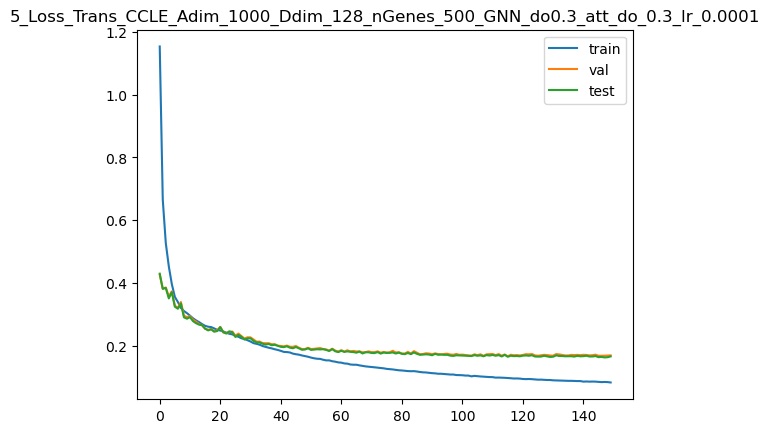

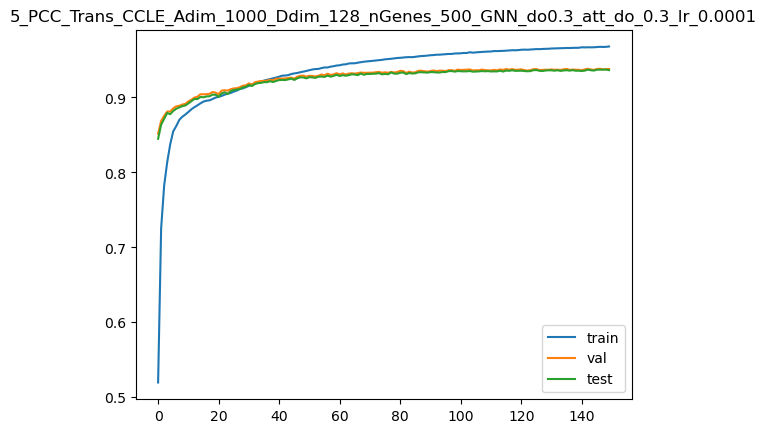

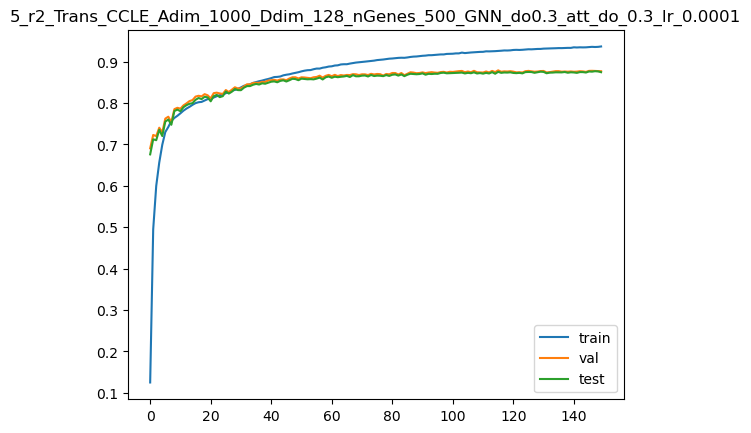

#################### epoch ############################  149


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0997413694858551
The overall Pearson's correlation is 0.9735.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07140646874904633
The overall Pearson's correlation is 0.9772.
Train avg_loss:  0.084403545
Train avg_pcc:  0.9674491828976907
Train r2:  0.9359535774205314


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16825016
Validation avg_pcc:  0.9380915726284563
Validation r2:  0.8779738420904974


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16514401
Test avg_pcc:  0.9366728229973339
Test r2:  0.8755247338274406
#################### epoch ############################  150


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0885610431432724
The overall Pearson's correlation is 0.9630.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08445839583873749
The overall Pearson's correlation is 0.9712.
Train avg_loss:  0.08325651
Train avg_pcc:  0.967898191153419
Train r2:  0.936823958820145


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16630027
Validation avg_pcc:  0.9385838888197283
Validation r2:  0.8793880214281686
Best Val r2  0.8793880214281686


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16322371
Test avg_pcc:  0.9371604334653147
Test r2:  0.8769721373274989
#################### epoch ############################  151


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07415362447500229
The overall Pearson's correlation is 0.9658.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07538408786058426
The overall Pearson's correlation is 0.9822.
Train avg_loss:  0.08310789
Train avg_pcc:  0.9679573307558434
Train r2:  0.936936736533337


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16745447
Validation avg_pcc:  0.9381698049972906
Validation r2:  0.8785509132399973


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16427258
Test avg_pcc:  0.9367731089244307
Test r2:  0.8761815848936078
#################### epoch ############################  152


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07171390950679779
The overall Pearson's correlation is 0.9774.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09576119482517242
The overall Pearson's correlation is 0.9701.
Train avg_loss:  0.08332449
Train avg_pcc:  0.9678719032933247
Train r2:  0.936772373740144


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17120998
Validation avg_pcc:  0.9379144155342294
Validation r2:  0.8758271658968079


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1669863
Test avg_pcc:  0.936748873793573
Test r2:  0.8741361300905485
#################### epoch ############################  153


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09053584933280945
The overall Pearson's correlation is 0.9680.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08362877368927002
The overall Pearson's correlation is 0.9715.
Train avg_loss:  0.08196986
Train avg_pcc:  0.9684032609708212
Train r2:  0.93780028194338


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16749626
Validation avg_pcc:  0.9379830291739267
Validation r2:  0.8785206070818606


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16537338
Test avg_pcc:  0.9361818211932589
Test r2:  0.8753518550207663
#################### epoch ############################  154


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07272151112556458
The overall Pearson's correlation is 0.9720.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06207675859332085
The overall Pearson's correlation is 0.9829.
Train avg_loss:  0.08204313
Train avg_pcc:  0.9683739477962495
Train r2:  0.9377446828231101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16800417
Validation avg_pcc:  0.9379486788374313
Validation r2:  0.8781522368429807


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1649351
Test avg_pcc:  0.9364700012404042
Test r2:  0.8756822002997325
#################### epoch ############################  155


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09080218523740768
The overall Pearson's correlation is 0.9719.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06598667800426483
The overall Pearson's correlation is 0.9753.
Train avg_loss:  0.08191961
Train avg_pcc:  0.9684226700434156
Train r2:  0.9378384153157996


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16744204
Validation avg_pcc:  0.937979781560978
Validation r2:  0.8785599276957109


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16436064
Test avg_pcc:  0.9366193863316123
Test r2:  0.8761151922878807
#################### epoch ############################  156


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07988259196281433
The overall Pearson's correlation is 0.9733.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0607466995716095
The overall Pearson's correlation is 0.9731.
Train avg_loss:  0.08161174
Train avg_pcc:  0.968543375930484
Train r2:  0.938072027077507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16889247
Validation avg_pcc:  0.9380304627453019
Validation r2:  0.8775079791434993


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16524413
Test avg_pcc:  0.9366552352446021
Test r2:  0.8754492736107449
#################### epoch ############################  157


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09629958122968674
The overall Pearson's correlation is 0.9746.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.056344494223594666
The overall Pearson's correlation is 0.9780.
Train avg_loss:  0.081245765
Train avg_pcc:  0.9686864488177672
Train r2:  0.9383497252927616


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16834006
Validation avg_pcc:  0.9386119109323716
Validation r2:  0.8779086241725482


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16500692
Test avg_pcc:  0.9372330526136224
Test r2:  0.8756280701476358
#################### epoch ############################  158


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09996141493320465
The overall Pearson's correlation is 0.9550.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0709107518196106
The overall Pearson's correlation is 0.9771.
Train avg_loss:  0.08125101
Train avg_pcc:  0.9686843640603513
Train r2:  0.9383457555848971


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16778407
Validation avg_pcc:  0.9379986606577841
Validation r2:  0.8783118771217161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1643569
Test avg_pcc:  0.9366340014201429
Test r2:  0.8761180109634793
#################### epoch ############################  159


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09371219575405121
The overall Pearson's correlation is 0.9658.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08214737474918365
The overall Pearson's correlation is 0.9724.
Train avg_loss:  0.08017785
Train avg_pcc:  0.9691045960363126
Train r2:  0.9391600836642205


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17012057
Validation avg_pcc:  0.9382940694043854
Validation r2:  0.8766172852455074


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16607961
Test avg_pcc:  0.9370910216786048
Test r2:  0.8748195490495756
#################### epoch ############################  160


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08090072125196457
The overall Pearson's correlation is 0.9743.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06092144548892975
The overall Pearson's correlation is 0.9762.
Train avg_loss:  0.08096404
Train avg_pcc:  0.9687967882709414
Train r2:  0.9385635155160944


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16584839
Validation avg_pcc:  0.9383355454540397
Validation r2:  0.8797157429344717
Best Val r2  0.8797157429344717


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16356112
Test avg_pcc:  0.9366796899775961
Test r2:  0.8767178204876183
#################### epoch ############################  161


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07593797147274017
The overall Pearson's correlation is 0.9802.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08292685449123383
The overall Pearson's correlation is 0.9602.
Train avg_loss:  0.08033385
Train avg_pcc:  0.9690432912689035
Train r2:  0.9390417027872605


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16858068
Validation avg_pcc:  0.9376227567249431
Validation r2:  0.8777341123523089


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16505268
Test avg_pcc:  0.9364207185148299
Test r2:  0.8755935707722311
#################### epoch ############################  162


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07432528585195541
The overall Pearson's correlation is 0.9645.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0899437963962555
The overall Pearson's correlation is 0.9590.
Train avg_loss:  0.07978913
Train avg_pcc:  0.9692567924438735
Train r2:  0.9394550456777587


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16803423
Validation avg_pcc:  0.9377874103945281
Validation r2:  0.8781304347333889


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.164348
Test avg_pcc:  0.9365849522249163
Test r2:  0.8761247176462871
#################### epoch ############################  163


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08456185460090637
The overall Pearson's correlation is 0.9736.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0660507082939148
The overall Pearson's correlation is 0.9753.
Train avg_loss:  0.07997033
Train avg_pcc:  0.9691865091410395
Train r2:  0.9393175519623437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16725664
Validation avg_pcc:  0.9376406705647838
Validation r2:  0.878694398053101


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16262224
Test avg_pcc:  0.9368902171181303
Test r2:  0.8774255072163701
#################### epoch ############################  164


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08047342300415039
The overall Pearson's correlation is 0.9683.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.14485442638397217
The overall Pearson's correlation is 0.9319.
Train avg_loss:  0.07973833
Train avg_pcc:  0.9692768978866543
Train r2:  0.939493596926456


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17033744
Validation avg_pcc:  0.9372056416372252
Validation r2:  0.8764599894063021


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16581962
Test avg_pcc:  0.9362125484063698
Test r2:  0.8750155149495826
#################### epoch ############################  165


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07736731320619583
The overall Pearson's correlation is 0.9804.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08053623884916306
The overall Pearson's correlation is 0.9749.
Train avg_loss:  0.07871358
Train avg_pcc:  0.9696775284534586
Train r2:  0.9402711869893235


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16815266
Validation avg_pcc:  0.9384102340105506
Validation r2:  0.8780445488945795


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16560115
Test avg_pcc:  0.9368677366093816
Test r2:  0.875180169211667
#################### epoch ############################  166


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.10320661216974258
The overall Pearson's correlation is 0.9656.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05187948793172836
The overall Pearson's correlation is 0.9773.
Train avg_loss:  0.07928592
Train avg_pcc:  0.9694536152428115
Train r2:  0.9398368890328431


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16986859
Validation avg_pcc:  0.9373616742804747
Validation r2:  0.8768000330331093


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16648847
Test avg_pcc:  0.9361184608841084
Test r2:  0.8745113739156896
#################### epoch ############################  167


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07490695267915726
The overall Pearson's correlation is 0.9736.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0716741532087326
The overall Pearson's correlation is 0.9648.
Train avg_loss:  0.0786903
Train avg_pcc:  0.9696869006908639
Train r2:  0.9402888539377754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16978356
Validation avg_pcc:  0.9381220389655948
Validation r2:  0.8768617133063226


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16624787
Test avg_pcc:  0.9367799629130644
Test r2:  0.8746927201420474
#################### epoch ############################  168


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.09950867295265198
The overall Pearson's correlation is 0.9553.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07322350889444351
The overall Pearson's correlation is 0.9742.
Train avg_loss:  0.07885035
Train avg_pcc:  0.9696243323219409
Train r2:  0.94016739954701


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16812238
Validation avg_pcc:  0.9376226729605449
Validation r2:  0.878066497738327


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16549145
Test avg_pcc:  0.9360678944847065
Test r2:  0.8752628719665114
#################### epoch ############################  169


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07146617770195007
The overall Pearson's correlation is 0.9657.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06903746724128723
The overall Pearson's correlation is 0.9668.
Train avg_loss:  0.07828135
Train avg_pcc:  0.9698473088457686
Train r2:  0.940599171452292


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17066497
Validation avg_pcc:  0.937395653375431
Validation r2:  0.876222453488023


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16735065
Test avg_pcc:  0.9359125784876614
Test r2:  0.8738615263814853
#################### epoch ############################  170


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05521475151181221
The overall Pearson's correlation is 0.9754.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08403724431991577
The overall Pearson's correlation is 0.9577.
Train avg_loss:  0.07867792
Train avg_pcc:  0.9696917932280628
Train r2:  0.9402982419538506


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1718596
Validation avg_pcc:  0.9376718077897462
Validation r2:  0.8753560167097406


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16876265
Test avg_pcc:  0.9362102096470821
Test r2:  0.8727972460081093
#################### epoch ############################  171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.055335208773612976
The overall Pearson's correlation is 0.9765.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05793158710002899
The overall Pearson's correlation is 0.9797.
Train avg_loss:  0.07842693
Train avg_pcc:  0.9697895112155949
Train r2:  0.9404886989559471


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16731271
Validation avg_pcc:  0.9382862219072126
Validation r2:  0.8786537245840849


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16366379
Test avg_pcc:  0.9371156375439286
Test r2:  0.876640445673369
#################### epoch ############################  172


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.04720335081219673
The overall Pearson's correlation is 0.9809.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0623173713684082
The overall Pearson's correlation is 0.9761.
Train avg_loss:  0.07839687
Train avg_pcc:  0.9698016005672321
Train r2:  0.9405115106062851


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16701983
Validation avg_pcc:  0.9380000029225672
Validation r2:  0.8788661476242904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16299997
Test avg_pcc:  0.9369628668293648
Test r2:  0.8771407852106078
#################### epoch ############################  173


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0745164230465889
The overall Pearson's correlation is 0.9679.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07470311224460602
The overall Pearson's correlation is 0.9763.
Train avg_loss:  0.07789567
Train avg_pcc:  0.969997664596024
Train r2:  0.9408918249391397


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16539437
Validation avg_pcc:  0.9386115053725379
Validation r2:  0.8800450471261754
Best Val r2  0.8800450471261754


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16154042
Test avg_pcc:  0.9376123751045867
Test r2:  0.8782409147695441
#################### epoch ############################  174


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06602891534566879
The overall Pearson's correlation is 0.9757.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0696248859167099
The overall Pearson's correlation is 0.9719.
Train avg_loss:  0.07750976
Train avg_pcc:  0.9701498422322196
Train r2:  0.9411846644806339


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17253916
Validation avg_pcc:  0.9382403728102218
Validation r2:  0.8748631540027171


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16764373
Test avg_pcc:  0.937419127415088
Test r2:  0.8736406114091554
#################### epoch ############################  175


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0861133337020874
The overall Pearson's correlation is 0.9686.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09495118260383606
The overall Pearson's correlation is 0.9668.
Train avg_loss:  0.07711741
Train avg_pcc:  0.9703016671593091
Train r2:  0.9414823847066741


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17285885
Validation avg_pcc:  0.9370413944049453
Validation r2:  0.874631298174625


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16719525
Test avg_pcc:  0.9366097642600585
Test r2:  0.8739786485911774
#################### epoch ############################  176


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08062778413295746
The overall Pearson's correlation is 0.9632.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07872369885444641
The overall Pearson's correlation is 0.9656.
Train avg_loss:  0.07702911
Train avg_pcc:  0.9703365479434529
Train r2:  0.9415493933592303


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16876067
Validation avg_pcc:  0.9376247610610311
Validation r2:  0.8776035668718809


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16454403
Test avg_pcc:  0.9365903223554235
Test r2:  0.8759769657038923
#################### epoch ############################  177


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06971155107021332
The overall Pearson's correlation is 0.9663.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.060230694711208344
The overall Pearson's correlation is 0.9840.
Train avg_loss:  0.076783046
Train avg_pcc:  0.9704326971167333
Train r2:  0.941736092458309


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16791052
Validation avg_pcc:  0.9376328267005153
Validation r2:  0.8782201624416852


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16382445
Test avg_pcc:  0.9366233592994404
Test r2:  0.8765193437152825
#################### epoch ############################  178


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.04965394735336304
The overall Pearson's correlation is 0.9759.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08996575325727463
The overall Pearson's correlation is 0.9536.
Train avg_loss:  0.07709403
Train avg_pcc:  0.9703114632276209
Train r2:  0.9415001237500472


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16764398
Validation avg_pcc:  0.938902771382569
Validation r2:  0.8784134652006087


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16498469
Test avg_pcc:  0.9373257071806731
Test r2:  0.8756448295902467
#################### epoch ############################  179


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.04875561594963074
The overall Pearson's correlation is 0.9823.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08654908090829849
The overall Pearson's correlation is 0.9714.
Train avg_loss:  0.07603822
Train avg_pcc:  0.9707238042399603
Train r2:  0.942301288124979


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16689396
Validation avg_pcc:  0.9385569407108124
Validation r2:  0.8789574294219408


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16449119
Test avg_pcc:  0.9368572146300587
Test r2:  0.8760167987893821
#################### epoch ############################  180


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05127788335084915
The overall Pearson's correlation is 0.9848.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0758759155869484
The overall Pearson's correlation is 0.9642.
Train avg_loss:  0.07621829
Train avg_pcc:  0.970653439087463
Train r2:  0.9421646460456695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16836943
Validation avg_pcc:  0.9375716692378149
Validation r2:  0.877887320244928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16510181
Test avg_pcc:  0.9361888442741203
Test r2:  0.8755565467453276
#################### epoch ############################  181


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.060656849294900894
The overall Pearson's correlation is 0.9767.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.08014160394668579
The overall Pearson's correlation is 0.9565.
Train avg_loss:  0.07575149
Train avg_pcc:  0.9708356247410996
Train r2:  0.9425188531893695


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16394016
Validation avg_pcc:  0.938929797905172
Validation r2:  0.8810997214620057
Best Val r2  0.8810997214620057


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16114408
Test avg_pcc:  0.9374882367550367
Test r2:  0.8785396363078043
#################### epoch ############################  182


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0851294994354248
The overall Pearson's correlation is 0.9690.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07550723105669022
The overall Pearson's correlation is 0.9771.
Train avg_loss:  0.07548623
Train avg_pcc:  0.9709399944019784
Train r2:  0.9427201452463957


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17251249
Validation avg_pcc:  0.9376676380862308
Validation r2:  0.874882497546051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16700375
Test avg_pcc:  0.9372014410487987
Test r2:  0.8741229812533202
#################### epoch ############################  183


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05659285932779312
The overall Pearson's correlation is 0.9760.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09840957075357437
The overall Pearson's correlation is 0.9703.
Train avg_loss:  0.07464288
Train avg_pcc:  0.9712690585915189
Train r2:  0.9433600853731775


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16761376
Validation avg_pcc:  0.9374080919759036
Validation r2:  0.8784353843671793


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16251728
Test avg_pcc:  0.9369011514366166
Test r2:  0.8775046105164872
#################### epoch ############################  184


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.045535262674093246
The overall Pearson's correlation is 0.9864.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07901259511709213
The overall Pearson's correlation is 0.9691.
Train avg_loss:  0.07515577
Train avg_pcc:  0.9710690629528863
Train r2:  0.9429709003702191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16691461
Validation avg_pcc:  0.9390439763177437
Validation r2:  0.8789424610468413


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1650282
Test avg_pcc:  0.937129342919222
Test r2:  0.8756120276942224
#################### epoch ############################  185


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07465064525604248
The overall Pearson's correlation is 0.9798.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06404276937246323
The overall Pearson's correlation is 0.9778.
Train avg_loss:  0.07514626
Train avg_pcc:  0.9710722928189337
Train r2:  0.9429781174362133


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16983691
Validation avg_pcc:  0.937814455366208
Validation r2:  0.8768230074934521


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16610615
Test avg_pcc:  0.9365850245427761
Test r2:  0.8747995479537498
#################### epoch ############################  186


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07800181210041046
The overall Pearson's correlation is 0.9689.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0742989331483841
The overall Pearson's correlation is 0.9615.
Train avg_loss:  0.074845396
Train avg_pcc:  0.9711898392047444
Train r2:  0.9432064122749864


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16473413
Validation avg_pcc:  0.9389402664623164
Validation r2:  0.8805238836114899


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16117178
Test avg_pcc:  0.9378048920131001
Test r2:  0.8785187606420954
#################### epoch ############################  187


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05646882951259613
The overall Pearson's correlation is 0.9769.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0955171138048172
The overall Pearson's correlation is 0.9689.
Train avg_loss:  0.07468012
Train avg_pcc:  0.9712546339860925
Train r2:  0.9433318314557946


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17305425
Validation avg_pcc:  0.937971554851458
Validation r2:  0.8744895740844735


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16944262
Test avg_pcc:  0.9365842685691851
Test r2:  0.872284714927992
#################### epoch ############################  188


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0963883101940155
The overall Pearson's correlation is 0.9664.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07666149735450745
The overall Pearson's correlation is 0.9658.
Train avg_loss:  0.07402422
Train avg_pcc:  0.9715105840416808
Train r2:  0.9438295326049357


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16758397
Validation avg_pcc:  0.9383656636580523
Validation r2:  0.8784569834415098


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16368282
Test avg_pcc:  0.9373125417519895
Test r2:  0.8766261069774264
#################### epoch ############################  189


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08053764700889587
The overall Pearson's correlation is 0.9719.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07953357696533203
The overall Pearson's correlation is 0.9713.
Train avg_loss:  0.07430157
Train avg_pcc:  0.9714023172857438
Train r2:  0.9436190790773215


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16992205
Validation avg_pcc:  0.9377583329124973
Validation r2:  0.8767612653857865


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16607592
Test avg_pcc:  0.9365772693141117
Test r2:  0.8748223306632049
#################### epoch ############################  190


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.056647464632987976
The overall Pearson's correlation is 0.9739.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.062283553183078766
The overall Pearson's correlation is 0.9774.
Train avg_loss:  0.07416087
Train avg_pcc:  0.971457615703933
Train r2:  0.9437258422312904


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16898467
Validation avg_pcc:  0.9379556385356582
Validation r2:  0.8774411104867131


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16400301
Test avg_pcc:  0.937234276793662
Test r2:  0.8763847582375583
#################### epoch ############################  191


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08197677135467529
The overall Pearson's correlation is 0.9635.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10094431042671204
The overall Pearson's correlation is 0.9541.
Train avg_loss:  0.074130215
Train avg_pcc:  0.9714690009768263
Train r2:  0.9437491013398412


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16994749
Validation avg_pcc:  0.9378724049899212
Validation r2:  0.876742804172312


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16602655
Test avg_pcc:  0.9366721858458941
Test r2:  0.8748595440903667
#################### epoch ############################  192


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07043363153934479
The overall Pearson's correlation is 0.9579.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.10576670616865158
The overall Pearson's correlation is 0.9627.
Train avg_loss:  0.07417202
Train avg_pcc:  0.9714529955812111
Train r2:  0.9437173765859828


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16827825
Validation avg_pcc:  0.9380086032360797
Validation r2:  0.8779534531036612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16599068
Test avg_pcc:  0.9363595626027967
Test r2:  0.8748865653633817
#################### epoch ############################  193


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.08620414137840271
The overall Pearson's correlation is 0.9693.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.06701374053955078
The overall Pearson's correlation is 0.9781.
Train avg_loss:  0.07378926
Train avg_pcc:  0.9716023025767601
Train r2:  0.9440078200072995


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16651353
Validation avg_pcc:  0.9386482631120981
Validation r2:  0.8792333501754437


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16280903
Test avg_pcc:  0.937542886141404
Test r2:  0.8772846996999134
#################### epoch ############################  194


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06627170741558075
The overall Pearson's correlation is 0.9704.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.05385890230536461
The overall Pearson's correlation is 0.9751.
Train avg_loss:  0.072984695
Train avg_pcc:  0.9719167786323509
Train r2:  0.9446183332428097


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1677314
Validation avg_pcc:  0.9381041529290177
Validation r2:  0.8783500655517507


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16479388
Test avg_pcc:  0.936641909810827
Test r2:  0.8757886469133951
#################### epoch ############################  195


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.0777362659573555
The overall Pearson's correlation is 0.9633.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.09417590498924255
The overall Pearson's correlation is 0.9634.
Train avg_loss:  0.07338429
Train avg_pcc:  0.971760903832535
Train r2:  0.9443151135792051


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16957419
Validation avg_pcc:  0.9387596094062232
Validation r2:  0.8770135522508612


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.1665401
Test avg_pcc:  0.937159499493386
Test r2:  0.8744724623285736
#################### epoch ############################  196


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.07295969128608704
The overall Pearson's correlation is 0.9642.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.0574956014752388
The overall Pearson's correlation is 0.9641.
Train avg_loss:  0.0734494
Train avg_pcc:  0.9717349041788392
Train r2:  0.9442657136757928


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.16847
Validation avg_pcc:  0.9378393308098272
Validation r2:  0.877814393203432


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16507825
Test avg_pcc:  0.9365388567672933
Test r2:  0.8755743047177537
#################### epoch ############################  197


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.05352392792701721
The overall Pearson's correlation is 0.9770.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07033920288085938
The overall Pearson's correlation is 0.9724.
Train avg_loss:  0.07286104
Train avg_pcc:  0.9719649415378819
Train r2:  0.9447121688717379


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.17335251
Validation avg_pcc:  0.9379559759611669
Validation r2:  0.8742732603167336


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16961312
Test avg_pcc:  0.9366080594619616
Test r2:  0.8721562141963025
#################### epoch ############################  198


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  499
step_training loss:  0.06062020733952522
The overall Pearson's correlation is 0.9781.
Trans_CCLE_Adim_1000_Ddim_128_nGenes_500_GNN_do0.3_att_do_0.3_lr_0.0001
training step:  999
step_training loss:  0.07209572196006775
The overall Pearson's correlation is 0.9782.
Train avg_loss:  0.07261346
Train avg_pcc:  0.9720610533651333
Train r2:  0.9449000332172759


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Validation avg_loss:  0.1689305
Validation avg_pcc:  0.9382595949898426
Validation r2:  0.8774803968812247


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16491187
Test avg_pcc:  0.9371897496303038
Test r2:  0.8756997220067205


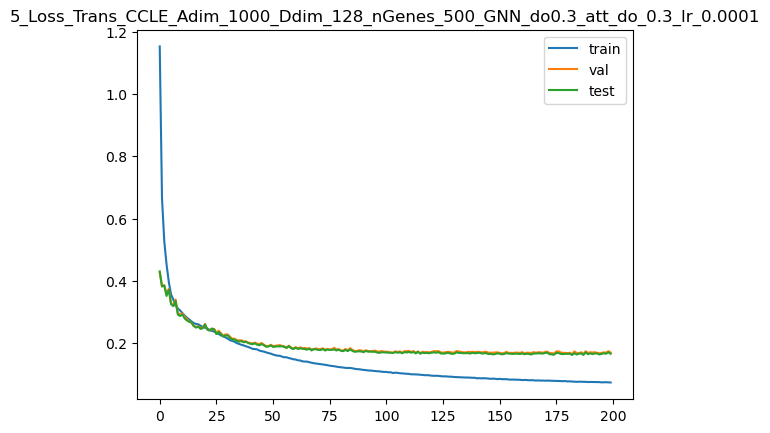

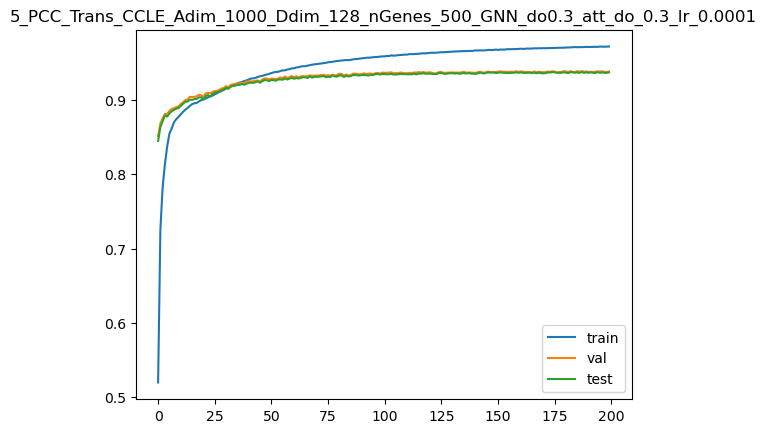

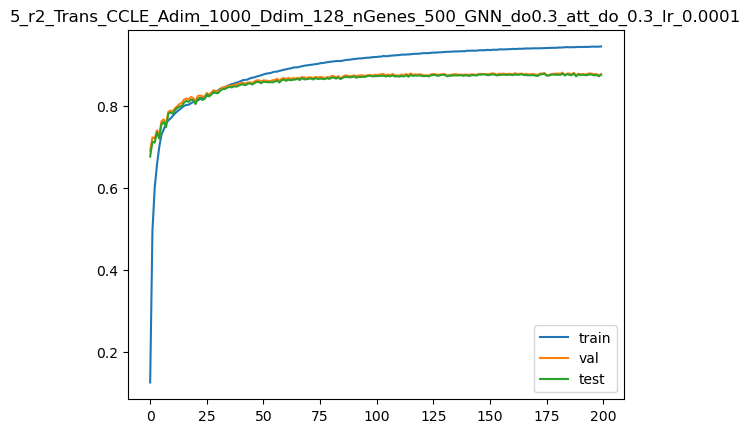

#################### epoch ############################  199


/home/zoo00/anaconda3/envs/python38/lib/python3.8/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


Test avg_loss:  0.16114408
Test avg_pcc:  0.9374882368734881
Test r2:  0.8785396364570128


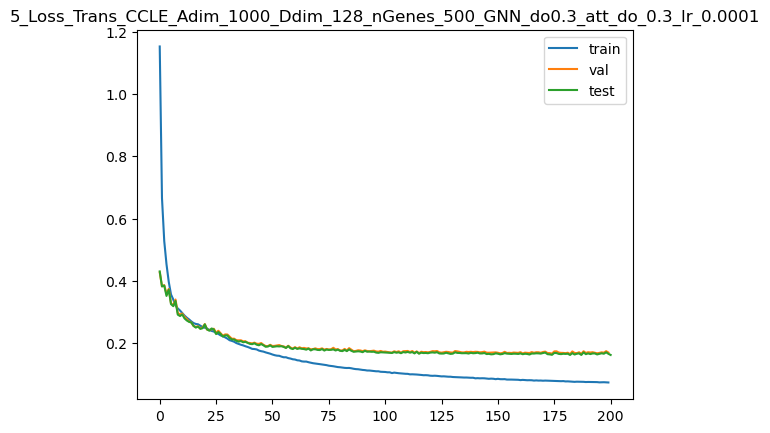

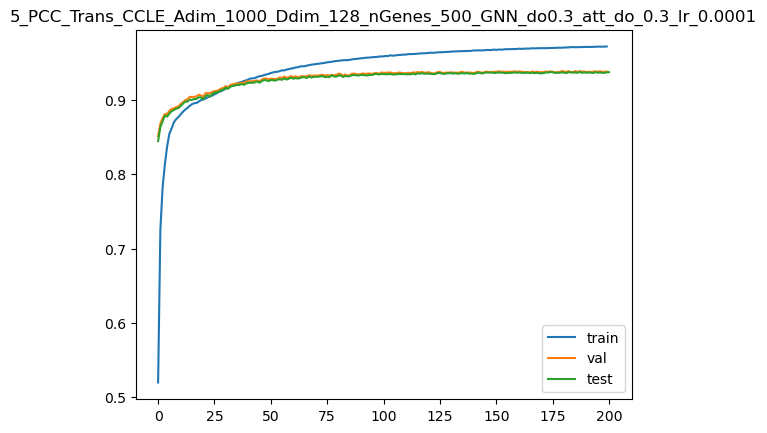

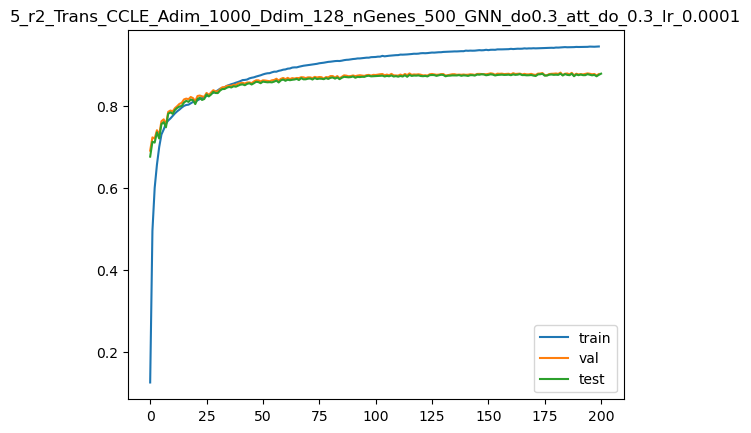

In [10]:
att_dim = 1000
all_samples =  gexpr_feature.index
title = name+'_Adim_'+str(att_dim)+'_Ddim_'+str(dim_drug)+'_nGenes_'+str(nGenes)+'_GNN_do'+str(gnn_dropout)+'_att_do_'+str(att_dropout)+'_lr_'+str(lr)

save_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/5fold/coatt/epoch150/att1000/weights/'
img_path = '/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/5fold/coatt/epoch150/att1000/imgs/'
result_path = "/NAS_Storage3/zoo00/GEN/CCLE/multi_cor/5fold/coatt/epoch150/att1000/results/"

total_train_pcc = []
total_val_pcc = []
total_test_pcc = []
total_train_r2 = []
total_val_r2 = []
total_test_r2 = []
total_train_losses = []
total_test_losses = []
total_val_losses = []

from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2)

split1 = ss.split(input_df_gexpr)
split2 = ss.split(input_df_gexpr)

fold = 0
for train2_index, test2_index in split2:
    fold += 1

    train2_index, val2_index = train_test_split(train2_index, test_size=1/8)
    train_df_gexpr = input_df_gexpr.iloc[train2_index].reset_index(drop=True)
    val_df_gexpr = input_df_gexpr.iloc[val2_index].reset_index(drop=True)
    test_df_gexpr = input_df_gexpr.iloc[test2_index].reset_index(drop=True)
    train_df_methyl = input_df_methyl.iloc[train2_index].reset_index(drop=True)
    val_df_methyl = input_df_methyl.iloc[val2_index].reset_index(drop=True)
    test_df_methyl = input_df_methyl.iloc[test2_index].reset_index(drop=True)


    train_dataloader = get_gnn_dataloader(train_df_gexpr,train_df_methyl, batch_size=batch_size)
    validation_dataloader = get_gnn_dataloader(val_df_gexpr,val_df_methyl, batch_size=batch_size)
    test_dataloader = get_gnn_dataloader(test_df_gexpr, test_df_methyl,batch_size=batch_size)

    gene_embedding = Gene_Embedding(vocab_size= vocab_size,embed_size=embed_size)

    gnn = GNN_drug(layer_drug = layer_drug, dim_drug = dim_drug, do = gnn_dropout)

    cell_encoder = COT_Att_Encoder(genes = nGenes, x_dim= embed_size, y_dim = att_dim,
                                        dropout = att_dropout, encoder = C_EnC)

    drug_encoder = COT_Att_Encoder(genes = nGenes, x_dim= nhid, y_dim = att_dim,
                                        dropout = att_dropout, encoder = D_EnC)


    encoder = Main_Encoder(cell_encoder = cell_encoder, d_dim = nhid,
                            genes=nGenes, y_dim=att_dim, dropout = att_dropout)

    model = GEN(y_dim = att_dim*2, dropout_ratio = fc_dropout,
                gnn = gnn, embedding = gene_embedding, encoder = encoder)

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) #0.0001
    mse = nn.MSELoss()

    train_pcc = []
    val_pcc = []
    test_pcc = []

    train_r2 = []
    val_r2 = []
    test_r2 = []

    best_pcc = 0
    train_loss = []
    test_loss = []
    val_loss = []
    for ep in range(nb_epoch):
        true_Y = []
        pred_Y = []


        model.train()
        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(train_dataloader):
            if len(y) >1:
                optimizer.zero_grad()

                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)

                loss = mse(pred_y.view(-1),y)

                loss.backward()
                optimizer.step()

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

            if (step+1) %500 ==0:
                print(title)
                print("training step: ", step)
                print("step_training loss: ", loss.item())
                overall_pcc = pearsonr(pred_y,y)[0]
                print("The overall Pearson's correlation is %.4f."%overall_pcc)

        loss_train = mean_squared_error(true_Y, pred_Y)
        pcc_train = pearsonr(true_Y, pred_Y)[0]
        r2_train = r2_score(true_Y, pred_Y)
        print("Train avg_loss: ", loss_train)
        print("Train avg_pcc: ", pcc_train)
        print("Train r2: ", r2_train)

        train_pcc.append(pcc_train)
        train_loss.append(loss_train)
        train_r2.append(r2_train)

        total_val_loss = 0.
        sum_pcc = 0.
        true_Y = []
        pred_Y = []

        model.eval()
        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(validation_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)

                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

                total_val_loss += loss.item()


        loss_val = mean_squared_error(true_Y, pred_Y)
        pcc_val = pearsonr(true_Y, pred_Y)[0]
        r2_val = r2_score(true_Y, pred_Y)

        print("Validation avg_loss: ", loss_val)
        print("Validation avg_pcc: ", pcc_val)
        print("Validation r2: ", r2_val)
        val_loss.append(loss_val)
        val_pcc.append(pcc_val)
        val_r2.append(r2_val)

        if best_pcc < val_r2[-1]:
            best_pcc = val_r2[-1]
            torch.save(model.state_dict(),save_path+title+'.pt')
            print('Best Val r2 ', best_pcc)

        true_Y = []
        pred_Y = []

        model.eval()

        for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(test_dataloader):
            if len(y) >1:
                x_drug = x_drug.to(device)
                x_gexpr = x_gexpr.to(device)
                x_genes_gexpr = x_genes_gexpr.to(device)
                x_methyl = x_methyl.to(device)
                x_genes_methyl = x_genes_methyl.to(device)
                y = y.to(device).float()

                pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)
                loss = mse(pred_y.view(-1),y)

                pred_y = pred_y.view(-1).detach().cpu().numpy()
                y = y.detach().cpu().numpy()

                true_Y += list(y)
                pred_Y += list(pred_y)

        loss_test = mean_squared_error(true_Y, pred_Y)
        pcc_test = pearsonr(true_Y, pred_Y)[0]
        r2_test = r2_score(true_Y, pred_Y)

        print("Test avg_loss: ", loss_test)
        print("Test avg_pcc: ", pcc_test)
        print("Test r2: ", r2_test)

        test_pcc.append(pcc_test)
        test_loss.append(loss_test)
        test_r2.append(r2_test)

        if (ep+1) %50 ==0:
            input_title = str(fold)+'_Loss_'+title
            show_picture(train_loss,val_loss, test_loss, input_title)
            input_title = str(fold)+'_PCC_'+title
            show_picture(train_pcc,val_pcc, test_pcc, input_title)
            input_title = str(fold)+'_r2_'+title
            show_picture(train_r2,val_r2, test_r2, input_title)


        print("#################### epoch ############################ ",ep)

    model.load_state_dict(torch.load(save_path+title+'.pt'))
    torch.save(model.state_dict(), save_path+title+'_final.pt')
    true_Y = []
    pred_Y = []

    model.eval()

    for step, (x_drug, x_genes_gexpr, x_gexpr, x_genes_methyl, x_methyl, y) in enumerate(test_dataloader):
        if len(y) >1:
            x_drug = x_drug.to(device)
            x_gexpr = x_gexpr.to(device)
            x_genes_gexpr = x_genes_gexpr.to(device)
            x_methyl = x_methyl.to(device)
            x_genes_methyl = x_genes_methyl.to(device)
            y = y.to(device).float()

            pred_y = model(x_drug,x_gexpr, x_genes_gexpr,x_methyl,x_genes_methyl)
            loss = mse(pred_y.view(-1),y)

            pred_y = pred_y.view(-1).detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            true_Y += list(y)
            pred_Y += list(pred_y)


    loss_test = mean_squared_error(true_Y, pred_Y)
    pcc_test = pearsonr(true_Y, pred_Y)[0]
    r2_test = r2_score(true_Y, pred_Y)

    print("Test avg_loss: ", loss_test)
    print("Test avg_pcc: ", pcc_test)
    print("Test r2: ", r2_test)

    test_pcc.append(pcc_test)
    test_loss.append(loss_test)
    test_r2.append(r2_test)

    input_title = str(fold)+'_Loss_'+title
    show_picture(train_loss,val_loss, test_loss, input_title,path=img_path, save=True)
    input_title = str(fold)+'_PCC_'+title
    show_picture(train_pcc,val_pcc, test_pcc, input_title,path=img_path, save=True)
    input_title = str(fold)+'_r2_'+title
    show_picture(train_r2,val_r2, test_r2, input_title,path=img_path, save=True)

    total_train_pcc.append(train_pcc)
    total_val_pcc.append(val_pcc)

    total_train_r2.append(train_r2)
    total_val_r2.append(val_r2)

    total_train_losses.append(train_loss)
    total_val_losses.append(val_loss)

    total_test_pcc.append(pcc_test)
    total_test_r2.append(r2_test)
    total_test_losses.append(loss_test)

    df_test_pcc = pd.DataFrame(data = total_test_pcc)
    df_test_r2 = pd.DataFrame(data = total_test_r2)

    df_test_losses = pd.DataFrame(data = total_test_losses)

    df_test_pcc.to_csv(result_path+title+'_pcc.csv')
    df_test_r2.to_csv(result_path+title+'_r2.csv')

    df_test_losses.to_csv(result_path+title+'_loss.csv')